# Install and import dependencies

In [ ]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib pydot PyLaTeX latex

In [1]:
import cv2 # OpenCV
import numpy as np
import os # For manipulating directory
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.layers import LSTM, Dense, Dropout # Layers name
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Matrics visualization
import itertools

# Visualize dataset distribution

In [ ]:
#Visualize data distribution per class
action_class = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
nvideo = [10, 10, 10, 9, 9, 9, 9, 9, 9, 9]
#font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 12})
#plot
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.xticks(rotation=45)
_ = plt.grid(which="major", axis="y", zorder=0)
_ = ax.set(title="Jumlah Video per Kelas pada Dataset Weizmann", yticks=[0,1,2,3,4,5,6,7,8,9,10])
barplot = ax.bar(action_class, nvideo, zorder=3, color="lightsteelblue")
#_ = ax.bar_label(barplot, label_type="center")
#save plot
#plt.savefig("graphdatasetlegacy.png", dpi=96, orientation="landscape", format="png", transparent=True)

In [ ]:
#Visualize data split after augmentation
action_class = np.arange(10)
nvideo_train = [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
nvideo_valid = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9] 
nvideo_test = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
width = 0.3
#plot
fig, ax = plt.subplots(figsize=(12, 6.75))
_ = plt.xticks(action_class,
               ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"],
               rotation=0)
_ = plt.grid(which="major", axis="y", zorder=0)
_ = ax.set(title="Jumlah Video per Kelas pada Dataset Weizmann Hasil Data Augmentation", yticks=[0,5,9,10,15,20,25,27,30])
barplot1 = ax.bar(action_class-width, nvideo_train, width, zorder=3, color="salmon")
barplot2 = ax.bar(action_class, nvideo_valid, width, zorder=3, color="lightgreen")
barplot3 = ax.bar(action_class+width, nvideo_test, width, zorder=3, color="skyblue")
_ = ax.bar_label(barplot1, label_type="center")
_ = ax.bar_label(barplot2, label_type="center")
_ = ax.bar_label(barplot3, label_type="center")
_ = ax.legend(["training", "validation", "testing"])
#save plot
#plt.savefig("graphdatasetaug.png", dpi=96, orientation="landscape", format="png", transparent=True)

# Function initialization

In [3]:
mp_pose = mp.solutions.pose # Pose model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_connections = mp.solutions.pose_connections # Pose Connections

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    image.flags.writeable = False # Image is unwritable
    results = model.process(image) # Prediction
    image.flags.writeable = True # Image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image,
                              results.pose_landmarks,
                              mp_pose.POSE_CONNECTIONS)
    
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image,
                              results.pose_landmarks,
                              mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10),
                                                     thickness=1,
                                                     circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,255,121),
                                                     thickness=1,
                                                     circle_radius=1))
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(4*33)
    return pose

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    """
    Prints & plots confusion matrix.
    Normalization can be applied by setting "normalize=True".
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Base variables

In [5]:
# Path for exporting data in numpy array format
DATA_PATH = os.path.join("dataset_weizmann450_trainvalidtest_mp")

# Action to detect
actions = np.array(["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"])

# Data role
roles = np.array(["train", "valid", "test"])

# 27 videos per action for training
no_sequences_train = 27

# 9 videos per action for validation
no_sequences_valid = 9

# 9 videos per action for testing
no_sequences_test = 9

# frame length
sequence_length = 25

In [29]:
actions.shape[0]

10

# Collecting MediaPipe:Pose keypoints

In [4]:
# Make folder for saving landmarks/keypoints data

for role in roles:
    if role == "train":
        for action in actions:
            for sequence_train in range(no_sequences_train):
                try:
                    os.makedirs(os.path.join(DATA_PATH, role, action, str(sequence_train)))
                except:
                    pass
    elif role == "valid":
        for action in actions:
            for sequence_valid in range(no_sequences_valid):
                try:
                    os.makedirs(os.path.join(DATA_PATH, role, action, str(sequence_valid)))
                except:
                    pass
    else:
        for action in actions:
            for sequence_test in range(no_sequences_test):
                try:
                    os.makedirs(os.path.join(DATA_PATH, role, action, str(sequence_test)))
                except:
                    pass

In [7]:
# Play video input simultaneously & try to collect keypoints values
# for train, valid, & test folder

with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    
    for role in roles:
        if role == "train":
            for action in actions:
                for sequence_train in range(no_sequences_train):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action, 
                                                                                                           sequence_train))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH, role, action, str(sequence_train), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()
                
        elif role == "valid":
            for action in actions:
                for sequence_valid in range(no_sequences_valid):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action,
                                                                                                           sequence_valid))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH, role, action, str(sequence_valid), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()
                
        else:
            for action in actions:
                for sequence_test in range(no_sequences_test):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action,
                                                                                                           sequence_test))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH, role, action, str(sequence_test), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Labelling data

In [6]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'run': 0,
 'walk': 1,
 'skip': 2,
 'jack': 3,
 'jump': 4,
 'pjump': 5,
 'side': 6,
 'wave2': 7,
 'wave1': 8,
 'bend': 9}

In [7]:
# Labelling each sequence/class
sequences_train, labels_train = [], []
sequences_valid, labels_valid = [], []
sequences_test, labels_test = [], []

for role in roles:
    if role == "train":
        for action in actions:
            for sequence_train in range(no_sequences_train):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH, role, action, str(sequence_train), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_train.append(window)
                labels_train.append(label_map[action])
    elif role == "valid":
        for action in actions:
            for sequence_valid in range(no_sequences_valid):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH, role, action, str(sequence_valid), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_valid.append(window)
                labels_valid.append(label_map[action])
    else:
        for action in actions:
            for sequence_test in range(no_sequences_test):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH, role, action, str(sequence_test), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_test.append(window)
                labels_test.append(label_map[action])

In [8]:
X_train = np.array(sequences_train)
X_valid = np.array(sequences_valid)
X_test = np.array(sequences_test)

y_train = to_categorical(labels_train).astype(int)
y_valid = to_categorical(labels_valid).astype(int)
y_test = to_categorical(labels_test).astype(int)

print("X_train shape : "+str(X_train.shape))
print("X_valid shape : "+str(X_valid.shape))
print("X_test shape : "+str(X_test.shape))
print("y_train shape : "+str(y_train.shape))
print("y_valid shape : "+str(y_valid.shape))
print("y_test shape : "+str(y_test.shape))

# X shape = (data, frame, keypoint)
# keypoint = 33 keypoints * 4 values (3 axis[x,y,z] + visibility) = 132

# y shape = (data, label)

X_train shape : (270, 25, 132)
X_valid shape : (90, 25, 132)
X_test shape : (90, 25, 132)
y_train shape : (270, 10)
y_valid shape : (90, 10)
y_test shape : (90, 10)


# Illustrate extracting keypoints process
for report only

In [25]:
# Visualize extracting keypoints process

cap = cv2.VideoCapture("dataset_weizmann450\jack\denis_jack_3.avi") # Video File

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, pose)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow("OpenCV Feed", image)
        
        # Break while loop
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

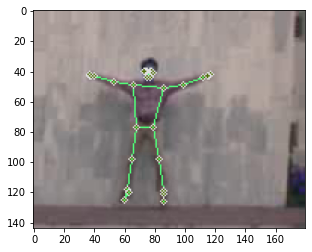

In [26]:
plt.figure()
plt.imshow(image)

In [ ]:
# Locate log folder for monitoring with TensorBoard
#log_dir = os.path.join("Logs")
#tb_callback = TensorBoard(log_dir=log_dir)

# Dropout layer added below

# lstm2_dense2_d_shf_nar_shl
lstm3 (128,64) + dense2 (32,10) + shuffle=True -> recentlyTheBest
#### Candidate

In [78]:
# Define a sequential model - another format
lstm2_dense2_d_shf_nar_shl = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [79]:
# Compile model with learning rate
lstm2_dense2_d_shf_nar_shl.compile(Adam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [80]:
# Training model with validation
history = lstm2_dense2_d_shf_nar_shl.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 55s - loss: 2.2937 - categorical_accuracy: 0.1185 - val_loss: 2.2388 - val_categorical_accuracy: 0.2333 - 55s/epoch - 805ms/step
Epoch 2/200
68/68 - 2s - loss: 2.1589 - categorical_accuracy: 0.1815 - val_loss: 1.9258 - val_categorical_accuracy: 0.2444 - 2s/epoch - 30ms/step
Epoch 3/200
68/68 - 2s - loss: 1.9160 - categorical_accuracy: 0.2444 - val_loss: 1.8481 - val_categorical_accuracy: 0.3333 - 2s/epoch - 29ms/step
Epoch 4/200
68/68 - 2s - loss: 1.7674 - categorical_accuracy: 0.2704 - val_loss: 1.6624 - val_categorical_accuracy: 0.3444 - 2s/epoch - 32ms/step
Epoch 5/200
68/68 - 2s - loss: 1.7256 - categorical_accuracy: 0.3259 - val_loss: 1.6791 - val_categorical_accuracy: 0.2889 - 2s/epoch - 32ms/step
Epoch 6/200
68/68 - 2s - loss: 1.6659 - categorical_accuracy: 0.3630 - val_loss: 1.4491 - val_categorical_accuracy: 0.4444 - 2s/epoch - 30ms/step
Epoch 7/200
68/68 - 2s - loss: 1.5287 - categorical_accuracy: 0.4222 - val_loss: 1.4069 - val_categorical_accuracy: 0.433

Epoch 57/200
68/68 - 2s - loss: 0.4645 - categorical_accuracy: 0.8222 - val_loss: 0.6226 - val_categorical_accuracy: 0.7111 - 2s/epoch - 30ms/step
Epoch 58/200
68/68 - 2s - loss: 0.4401 - categorical_accuracy: 0.8185 - val_loss: 0.5571 - val_categorical_accuracy: 0.7333 - 2s/epoch - 31ms/step
Epoch 59/200
68/68 - 2s - loss: 0.3764 - categorical_accuracy: 0.8444 - val_loss: 1.2488 - val_categorical_accuracy: 0.6556 - 2s/epoch - 30ms/step
Epoch 60/200
68/68 - 3s - loss: 0.6197 - categorical_accuracy: 0.7630 - val_loss: 0.5692 - val_categorical_accuracy: 0.7667 - 3s/epoch - 37ms/step
Epoch 61/200
68/68 - 3s - loss: 0.4387 - categorical_accuracy: 0.8481 - val_loss: 0.4702 - val_categorical_accuracy: 0.7667 - 3s/epoch - 39ms/step
Epoch 62/200
68/68 - 4s - loss: 0.3964 - categorical_accuracy: 0.8556 - val_loss: 0.4564 - val_categorical_accuracy: 0.8333 - 4s/epoch - 57ms/step
Epoch 63/200
68/68 - 3s - loss: 0.3552 - categorical_accuracy: 0.8741 - val_loss: 0.4876 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 2s - loss: 0.3256 - categorical_accuracy: 0.8630 - val_loss: 0.3772 - val_categorical_accuracy: 0.8444 - 2s/epoch - 31ms/step
Epoch 114/200
68/68 - 2s - loss: 0.1633 - categorical_accuracy: 0.9556 - val_loss: 0.5824 - val_categorical_accuracy: 0.7889 - 2s/epoch - 30ms/step
Epoch 115/200
68/68 - 2s - loss: 0.1552 - categorical_accuracy: 0.9444 - val_loss: 0.5748 - val_categorical_accuracy: 0.8111 - 2s/epoch - 29ms/step
Epoch 116/200
68/68 - 2s - loss: 0.3380 - categorical_accuracy: 0.8815 - val_loss: 0.3554 - val_categorical_accuracy: 0.8333 - 2s/epoch - 30ms/step
Epoch 117/200
68/68 - 2s - loss: 0.1460 - categorical_accuracy: 0.9444 - val_loss: 0.4557 - val_categorical_accuracy: 0.8111 - 2s/epoch - 34ms/step
Epoch 118/200
68/68 - 2s - loss: 0.1477 - categorical_accuracy: 0.9519 - val_loss: 0.5115 - val_categorical_accuracy: 0.8000 - 2s/epoch - 31ms/step
Epoch 119/200
68/68 - 2s - loss: 0.1723 - categorical_accuracy: 0.9259 - val_loss: 0.5287 - val_categorical_accu

Epoch 169/200
68/68 - 2s - loss: 0.2914 - categorical_accuracy: 0.9148 - val_loss: 0.5866 - val_categorical_accuracy: 0.8111 - 2s/epoch - 29ms/step
Epoch 170/200
68/68 - 2s - loss: 0.2670 - categorical_accuracy: 0.8963 - val_loss: 0.4802 - val_categorical_accuracy: 0.8333 - 2s/epoch - 30ms/step
Epoch 171/200
68/68 - 2s - loss: 0.0941 - categorical_accuracy: 0.9630 - val_loss: 0.4996 - val_categorical_accuracy: 0.8111 - 2s/epoch - 29ms/step
Epoch 172/200
68/68 - 2s - loss: 0.1077 - categorical_accuracy: 0.9667 - val_loss: 0.8447 - val_categorical_accuracy: 0.7778 - 2s/epoch - 29ms/step
Epoch 173/200
68/68 - 2s - loss: 0.1789 - categorical_accuracy: 0.9259 - val_loss: 0.4665 - val_categorical_accuracy: 0.8222 - 2s/epoch - 30ms/step
Epoch 174/200
68/68 - 2s - loss: 0.1512 - categorical_accuracy: 0.9407 - val_loss: 0.5756 - val_categorical_accuracy: 0.8000 - 2s/epoch - 29ms/step
Epoch 175/200
68/68 - 2s - loss: 0.1352 - categorical_accuracy: 0.9407 - val_loss: 0.8177 - val_categorical_accu

In [81]:
lstm2_dense2_d_shf_nar_shl.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 25, 128)           133632    
                                                                 
 dropout_21 (Dropout)        (None, 25, 128)           0         
                                                                 
 lstm_22 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-tr

In [82]:
# Save Model
lstm2_dense2_d_shf_nar_shl.save("lstm2_dense2_d_shf_nar_shl_2149_14032022.h5")

In [83]:
# Load Model
lstm2_dense2_d_shf_nar_shl.load_weights("lstm2_dense2_d_shf_nar_shl_2149_14032022.h5")

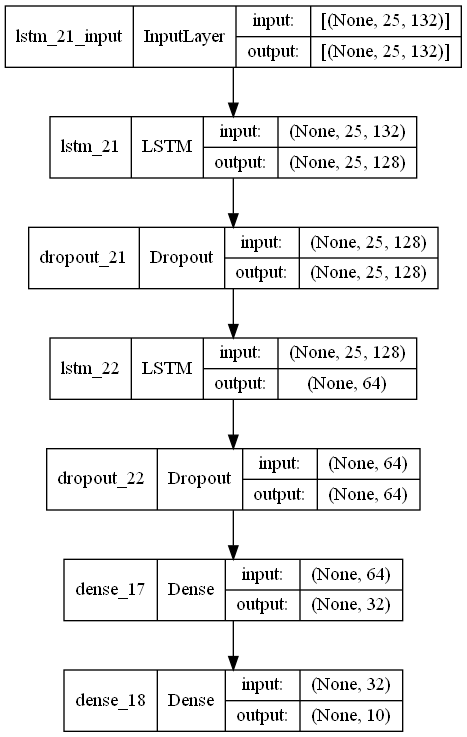

In [84]:
# Visualize
plot_model(lstm2_dense2_d_shf_nar_shl, to_file = "arc_lstm2_dense2_d_shf_nar_shl_2149_14032022.png", show_shapes = True)

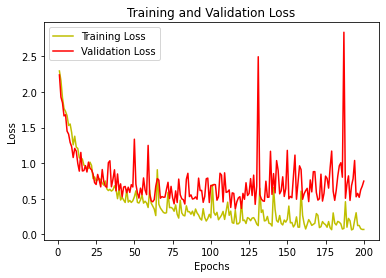

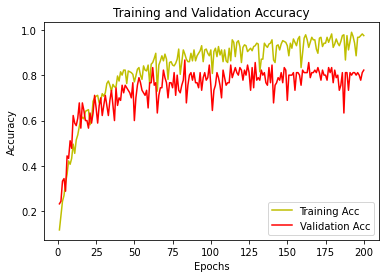

In [85]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [86]:
res = lstm2_dense2_d_shf_nar_shl.predict(X_test)

In [87]:
yhat = lstm2_dense2_d_shf_nar_shl.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [88]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[76,  5],
        [ 3,  6]],

       [[80,  1],
        [ 2,  7]],

       [[78,  3],
        [ 4,  5]],

       [[80,  1],
        [ 1,  8]],

       [[80,  1],
        [ 1,  8]],

       [[81,  0],
        [ 1,  8]],

       [[80,  1],
        [ 0,  9]],

       [[81,  0],
        [ 0,  9]],

       [[80,  1],
        [ 1,  8]],

       [[80,  1],
        [ 1,  8]]], dtype=int64)

In [89]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[6 1 2 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [3 0 5 0 1 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 1 0 0 8]]


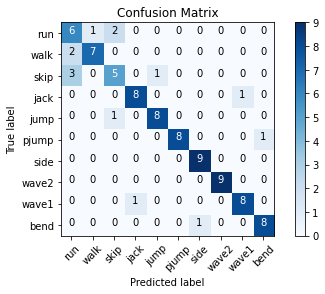

In [90]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [91]:
y_pred = lstm2_dense2_d_shf_nar_shl.predict(X_test)
y_pred = (y_pred > 0.5)

In [92]:
_, acc = lstm2_dense2_d_shf_nar_shl.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 27ms/step - loss: 0.7725 - categorical_accuracy: 0.8444
Accuracy =  84.44444537162781  %


In [93]:
accuracy_score(ytrue, yhat)

0.8444444444444444

In [94]:
lstm2_dense2_d_defaultprint(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.55      0.67      0.60         9
        walk       0.88      0.78      0.82         9
        skip       0.62      0.56      0.59         9
        jack       0.89      0.89      0.89         9
        jump       0.89      0.89      0.89         9
       pjump       1.00      0.89      0.94         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.84        90
   macro avg       0.85      0.84      0.85        90
weighted avg       0.85      0.84      0.85        90



# Dropout layer added below + relu + nadam

# lstm2_dense2_d_relu
lstm3 (128,64) + dense2 (32,10) + activation=relu + nadam -> not good enough

In [25]:
# Define a sequential model - another format
lstm2_dense2_d_relu = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [26]:
# Compile model with learning rate
lstm2_dense2_d_relu.compile(Adam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [27]:
# Training model with validation
history = lstm2_dense2_d_relu.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 5s - loss: 2.3059 - categorical_accuracy: 0.1370 - val_loss: 2.2763 - val_categorical_accuracy: 0.1333 - 5s/epoch - 81ms/step
Epoch 2/200
68/68 - 2s - loss: 2.2416 - categorical_accuracy: 0.2037 - val_loss: 2.1744 - val_categorical_accuracy: 0.2333 - 2s/epoch - 29ms/step
Epoch 3/200
68/68 - 2s - loss: 2.1212 - categorical_accuracy: 0.2333 - val_loss: 1.9591 - val_categorical_accuracy: 0.2889 - 2s/epoch - 29ms/step
Epoch 4/200
68/68 - 2s - loss: 1.9437 - categorical_accuracy: 0.2778 - val_loss: 1.8060 - val_categorical_accuracy: 0.2667 - 2s/epoch - 29ms/step
Epoch 5/200
68/68 - 2s - loss: 1.8016 - categorical_accuracy: 0.2926 - val_loss: 1.6656 - val_categorical_accuracy: 0.3000 - 2s/epoch - 29ms/step
Epoch 6/200
68/68 - 2s - loss: 1.6661 - categorical_accuracy: 0.3593 - val_loss: 1.4906 - val_categorical_accuracy: 0.3778 - 2s/epoch - 29ms/step
Epoch 7/200
68/68 - 2s - loss: 1.5098 - categorical_accuracy: 0.3815 - val_loss: 1.5303 - val_categorical_accuracy: 0.3444 -

Epoch 57/200
68/68 - 2s - loss: 0.3641 - categorical_accuracy: 0.8741 - val_loss: 0.7172 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 58/200
68/68 - 2s - loss: 0.3510 - categorical_accuracy: 0.8852 - val_loss: 0.5821 - val_categorical_accuracy: 0.7778 - 2s/epoch - 29ms/step
Epoch 59/200
68/68 - 2s - loss: 0.3690 - categorical_accuracy: 0.8704 - val_loss: 0.6135 - val_categorical_accuracy: 0.7778 - 2s/epoch - 29ms/step
Epoch 60/200
68/68 - 2s - loss: 0.5684 - categorical_accuracy: 0.8111 - val_loss: 0.5968 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 61/200
68/68 - 2s - loss: 0.3727 - categorical_accuracy: 0.8630 - val_loss: 0.6300 - val_categorical_accuracy: 0.7444 - 2s/epoch - 29ms/step
Epoch 62/200
68/68 - 2s - loss: 0.3255 - categorical_accuracy: 0.8889 - val_loss: 0.5596 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 63/200
68/68 - 2s - loss: 0.2723 - categorical_accuracy: 0.8926 - val_loss: 0.5905 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 2s - loss: 0.2107 - categorical_accuracy: 0.9222 - val_loss: 0.5630 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 114/200
68/68 - 2s - loss: 0.1794 - categorical_accuracy: 0.9296 - val_loss: 0.5572 - val_categorical_accuracy: 0.8333 - 2s/epoch - 29ms/step
Epoch 115/200
68/68 - 2s - loss: 0.1550 - categorical_accuracy: 0.9407 - val_loss: 1.0576 - val_categorical_accuracy: 0.7222 - 2s/epoch - 29ms/step
Epoch 116/200
68/68 - 2s - loss: 0.3693 - categorical_accuracy: 0.8889 - val_loss: 0.9415 - val_categorical_accuracy: 0.6778 - 2s/epoch - 29ms/step
Epoch 117/200
68/68 - 2s - loss: 0.2655 - categorical_accuracy: 0.9074 - val_loss: 0.5494 - val_categorical_accuracy: 0.7889 - 2s/epoch - 29ms/step
Epoch 118/200
68/68 - 2s - loss: 0.1898 - categorical_accuracy: 0.9333 - val_loss: 0.5175 - val_categorical_accuracy: 0.8333 - 2s/epoch - 29ms/step
Epoch 119/200
68/68 - 2s - loss: 0.1304 - categorical_accuracy: 0.9556 - val_loss: 0.6271 - val_categorical_accu

Epoch 169/200
68/68 - 2s - loss: 0.1086 - categorical_accuracy: 0.9630 - val_loss: 1.2516 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 170/200
68/68 - 2s - loss: 0.1169 - categorical_accuracy: 0.9593 - val_loss: 0.8506 - val_categorical_accuracy: 0.7667 - 2s/epoch - 29ms/step
Epoch 171/200
68/68 - 2s - loss: 0.0457 - categorical_accuracy: 0.9889 - val_loss: 0.9742 - val_categorical_accuracy: 0.7667 - 2s/epoch - 30ms/step
Epoch 172/200
68/68 - 2s - loss: 0.5930 - categorical_accuracy: 0.8889 - val_loss: 0.8495 - val_categorical_accuracy: 0.7111 - 2s/epoch - 31ms/step
Epoch 173/200
68/68 - 2s - loss: 0.3154 - categorical_accuracy: 0.8778 - val_loss: 0.9106 - val_categorical_accuracy: 0.7778 - 2s/epoch - 29ms/step
Epoch 174/200
68/68 - 2s - loss: 0.2070 - categorical_accuracy: 0.9333 - val_loss: 0.9260 - val_categorical_accuracy: 0.7778 - 2s/epoch - 29ms/step
Epoch 175/200
68/68 - 2s - loss: 0.1456 - categorical_accuracy: 0.9630 - val_loss: 1.1420 - val_categorical_accu

In [28]:
lstm2_dense2_d_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 25, 128)           133632    
                                                                 
 dropout_4 (Dropout)         (None, 25, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-tr

In [29]:
# Save Model
lstm2_dense2_d_relu.save("lstm2_dense2_d_relu_1408_17032022.h5")

In [30]:
# Load Model
lstm2_dense2_d_relu.load_weights("lstm2_dense2_d_relu_1408_17032022.h5")

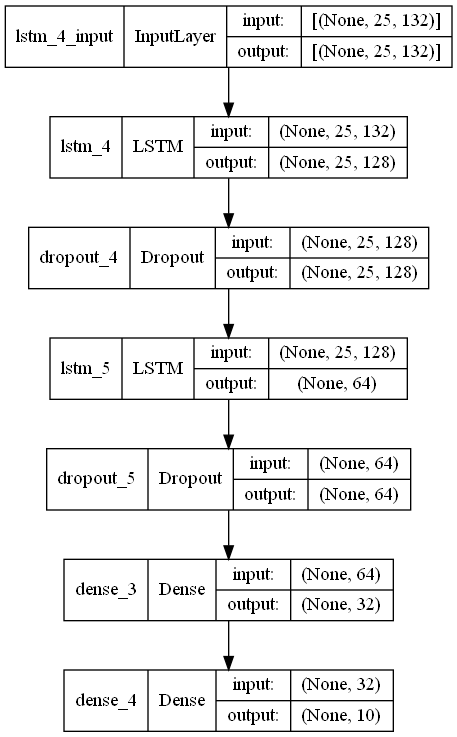

In [31]:
# Visualize
plot_model(lstm2_dense2_d_relu, to_file = "arc_lstm2_dense2_d_relu_1408_17032022.png", show_shapes = True)

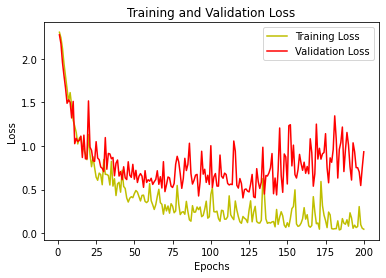

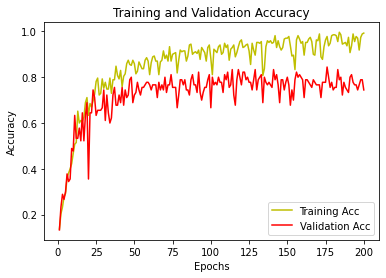

In [32]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
res = lstm2_dense2_d_relu.predict(X_test)

In [34]:
yhat = lstm2_dense2_d_relu.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [35]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 3 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [4 1 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 1 0 0]
 [1 1 1 0 5 1 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 1 0 1 7]]


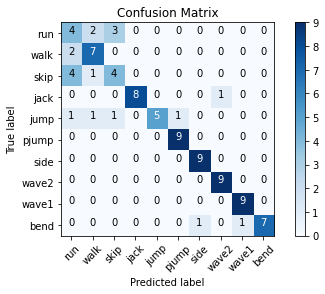

In [36]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [37]:
y_pred = lstm2_dense2_d_relu.predict(X_test)
y_pred = (y_pred > 0.5)

In [38]:
_, acc = lstm2_dense2_d_relu.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 1.2554 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [39]:
accuracy_score(ytrue, yhat)

0.7888888888888889

In [42]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.36      0.44      0.40         9
        walk       0.64      0.78      0.70         9
        skip       0.50      0.44      0.47         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.56      0.71         9
       pjump       0.90      1.00      0.95         9
        side       0.90      1.00      0.95         9
       wave2       0.90      1.00      0.95         9
       wave1       0.90      1.00      0.95         9
        bend       1.00      0.78      0.88         9

    accuracy                           0.79        90
   macro avg       0.81      0.79      0.79        90
weighted avg       0.81      0.79      0.79        90



# lstm2_dense2_d_relu_e300
lstm3 (128,64) + dense2 (32,10) + activation=relu + nadam + epochs=300 -> worse than e200 (let's keep 200)

In [43]:
# Define a sequential model - another format
lstm2_dense2_d_relu_e300 = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [44]:
# Compile model with learning rate
lstm2_dense2_d_relu_e300.compile(Adam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [45]:
# Training model with validation
history = lstm2_dense2_d_relu_e300.fit(X_train, y_train, batch_size=4, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
68/68 - 6s - loss: 2.3020 - categorical_accuracy: 0.1593 - val_loss: 2.2633 - val_categorical_accuracy: 0.2333 - 6s/epoch - 86ms/step
Epoch 2/300
68/68 - 2s - loss: 2.2220 - categorical_accuracy: 0.2000 - val_loss: 2.0079 - val_categorical_accuracy: 0.2000 - 2s/epoch - 30ms/step
Epoch 3/300
68/68 - 2s - loss: 1.9840 - categorical_accuracy: 0.2370 - val_loss: 1.8598 - val_categorical_accuracy: 0.2667 - 2s/epoch - 30ms/step
Epoch 4/300
68/68 - 2s - loss: 1.8817 - categorical_accuracy: 0.2704 - val_loss: 1.7474 - val_categorical_accuracy: 0.2667 - 2s/epoch - 29ms/step
Epoch 5/300
68/68 - 2s - loss: 1.8402 - categorical_accuracy: 0.3185 - val_loss: 1.6652 - val_categorical_accuracy: 0.3667 - 2s/epoch - 31ms/step
Epoch 6/300
68/68 - 2s - loss: 1.7151 - categorical_accuracy: 0.3222 - val_loss: 1.6379 - val_categorical_accuracy: 0.3667 - 2s/epoch - 32ms/step
Epoch 7/300
68/68 - 2s - loss: 1.6540 - categorical_accuracy: 0.3481 - val_loss: 1.5716 - val_categorical_accuracy: 0.3333 -

Epoch 57/300
68/68 - 3s - loss: 0.5019 - categorical_accuracy: 0.8074 - val_loss: 0.4840 - val_categorical_accuracy: 0.7889 - 3s/epoch - 40ms/step
Epoch 58/300
68/68 - 2s - loss: 0.4488 - categorical_accuracy: 0.8259 - val_loss: 0.6451 - val_categorical_accuracy: 0.7444 - 2s/epoch - 35ms/step
Epoch 59/300
68/68 - 2s - loss: 0.4180 - categorical_accuracy: 0.8370 - val_loss: 0.4366 - val_categorical_accuracy: 0.8222 - 2s/epoch - 35ms/step
Epoch 60/300
68/68 - 2s - loss: 0.3711 - categorical_accuracy: 0.8630 - val_loss: 0.5033 - val_categorical_accuracy: 0.7556 - 2s/epoch - 35ms/step
Epoch 61/300
68/68 - 2s - loss: 0.3928 - categorical_accuracy: 0.8444 - val_loss: 0.6100 - val_categorical_accuracy: 0.7222 - 2s/epoch - 36ms/step
Epoch 62/300
68/68 - 2s - loss: 0.4318 - categorical_accuracy: 0.8333 - val_loss: 0.4282 - val_categorical_accuracy: 0.8111 - 2s/epoch - 35ms/step
Epoch 63/300
68/68 - 2s - loss: 0.2887 - categorical_accuracy: 0.8963 - val_loss: 0.5656 - val_categorical_accuracy: 0

Epoch 113/300
68/68 - 2s - loss: 0.1644 - categorical_accuracy: 0.9370 - val_loss: 0.8102 - val_categorical_accuracy: 0.7556 - 2s/epoch - 30ms/step
Epoch 114/300
68/68 - 2s - loss: 0.2889 - categorical_accuracy: 0.9037 - val_loss: 0.4723 - val_categorical_accuracy: 0.8222 - 2s/epoch - 30ms/step
Epoch 115/300
68/68 - 2s - loss: 0.3092 - categorical_accuracy: 0.8741 - val_loss: 0.7906 - val_categorical_accuracy: 0.7111 - 2s/epoch - 34ms/step
Epoch 116/300
68/68 - 2s - loss: 0.3320 - categorical_accuracy: 0.8852 - val_loss: 0.6484 - val_categorical_accuracy: 0.7444 - 2s/epoch - 32ms/step
Epoch 117/300
68/68 - 2s - loss: 0.2497 - categorical_accuracy: 0.9074 - val_loss: 0.7238 - val_categorical_accuracy: 0.7444 - 2s/epoch - 35ms/step
Epoch 118/300
68/68 - 2s - loss: 0.2101 - categorical_accuracy: 0.8963 - val_loss: 0.5472 - val_categorical_accuracy: 0.8667 - 2s/epoch - 32ms/step
Epoch 119/300
68/68 - 2s - loss: 0.2462 - categorical_accuracy: 0.9296 - val_loss: 0.4624 - val_categorical_accu

Epoch 169/300
68/68 - 2s - loss: 0.0896 - categorical_accuracy: 0.9630 - val_loss: 1.0055 - val_categorical_accuracy: 0.8111 - 2s/epoch - 30ms/step
Epoch 170/300
68/68 - 2s - loss: 0.2952 - categorical_accuracy: 0.9222 - val_loss: 0.4704 - val_categorical_accuracy: 0.8222 - 2s/epoch - 30ms/step
Epoch 171/300
68/68 - 2s - loss: 0.0830 - categorical_accuracy: 0.9667 - val_loss: 0.6980 - val_categorical_accuracy: 0.7778 - 2s/epoch - 30ms/step
Epoch 172/300
68/68 - 2s - loss: 0.1420 - categorical_accuracy: 0.9519 - val_loss: 0.5369 - val_categorical_accuracy: 0.8111 - 2s/epoch - 34ms/step
Epoch 173/300
68/68 - 2s - loss: 0.2117 - categorical_accuracy: 0.9074 - val_loss: 0.4365 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 174/300
68/68 - 2s - loss: 0.1207 - categorical_accuracy: 0.9556 - val_loss: 0.5692 - val_categorical_accuracy: 0.7778 - 2s/epoch - 30ms/step
Epoch 175/300
68/68 - 2s - loss: 0.3129 - categorical_accuracy: 0.9111 - val_loss: 0.5737 - val_categorical_accu

Epoch 225/300
68/68 - 2s - loss: 0.1437 - categorical_accuracy: 0.9519 - val_loss: 0.6316 - val_categorical_accuracy: 0.7889 - 2s/epoch - 29ms/step
Epoch 226/300
68/68 - 2s - loss: 0.1342 - categorical_accuracy: 0.9630 - val_loss: 0.5112 - val_categorical_accuracy: 0.8333 - 2s/epoch - 29ms/step
Epoch 227/300
68/68 - 2s - loss: 0.0620 - categorical_accuracy: 0.9815 - val_loss: 0.7492 - val_categorical_accuracy: 0.7667 - 2s/epoch - 30ms/step
Epoch 228/300
68/68 - 2s - loss: 0.0769 - categorical_accuracy: 0.9667 - val_loss: 0.6732 - val_categorical_accuracy: 0.8111 - 2s/epoch - 30ms/step
Epoch 229/300
68/68 - 2s - loss: 0.1475 - categorical_accuracy: 0.9444 - val_loss: 0.4274 - val_categorical_accuracy: 0.8556 - 2s/epoch - 31ms/step
Epoch 230/300
68/68 - 2s - loss: 0.0622 - categorical_accuracy: 0.9741 - val_loss: 0.5642 - val_categorical_accuracy: 0.8222 - 2s/epoch - 32ms/step
Epoch 231/300
68/68 - 2s - loss: 0.1687 - categorical_accuracy: 0.9556 - val_loss: 0.4723 - val_categorical_accu

Epoch 281/300
68/68 - 2s - loss: 0.0850 - categorical_accuracy: 0.9667 - val_loss: 0.8845 - val_categorical_accuracy: 0.8000 - 2s/epoch - 34ms/step
Epoch 282/300
68/68 - 2s - loss: 0.0619 - categorical_accuracy: 0.9741 - val_loss: 1.0717 - val_categorical_accuracy: 0.7667 - 2s/epoch - 32ms/step
Epoch 283/300
68/68 - 2s - loss: 0.0472 - categorical_accuracy: 0.9852 - val_loss: 0.6651 - val_categorical_accuracy: 0.8000 - 2s/epoch - 34ms/step
Epoch 284/300
68/68 - 2s - loss: 0.0199 - categorical_accuracy: 0.9963 - val_loss: 1.0222 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 285/300
68/68 - 2s - loss: 0.0139 - categorical_accuracy: 0.9963 - val_loss: 1.0761 - val_categorical_accuracy: 0.8000 - 2s/epoch - 35ms/step
Epoch 286/300
68/68 - 3s - loss: 0.0386 - categorical_accuracy: 0.9815 - val_loss: 0.9806 - val_categorical_accuracy: 0.8111 - 3s/epoch - 39ms/step
Epoch 287/300
68/68 - 2s - loss: 0.0295 - categorical_accuracy: 0.9926 - val_loss: 1.1357 - val_categorical_accu

In [46]:
lstm2_dense2_d_relu_e300.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 25, 128)           133632    
                                                                 
 dropout_6 (Dropout)         (None, 25, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-tr

In [47]:
# Save Model
lstm2_dense2_d_relu_e300.save("lstm2_dense2_d_relu_e300_1452_17032022.h5")

In [48]:
# Load Model
lstm2_dense2_d_relu_e300.load_weights("lstm2_dense2_d_relu_e300_1452_17032022.h5")

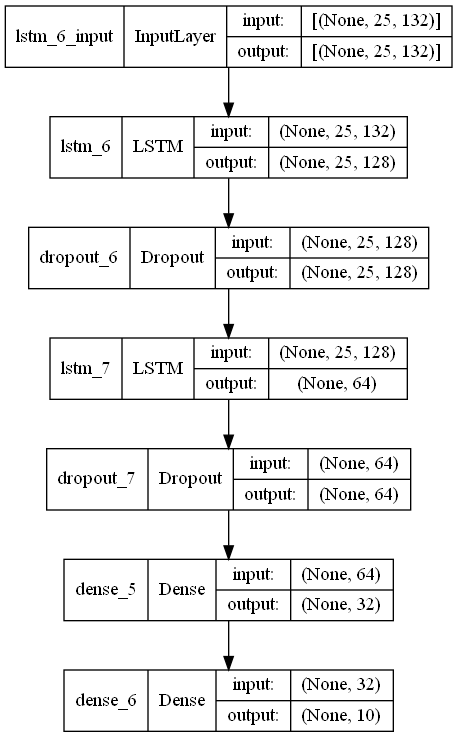

In [49]:
# Visualize
plot_model(lstm2_dense2_d_relu_e300, to_file = "arc_lstm2_dense2_d_relu_e300_1452_17032022.png", show_shapes = True)

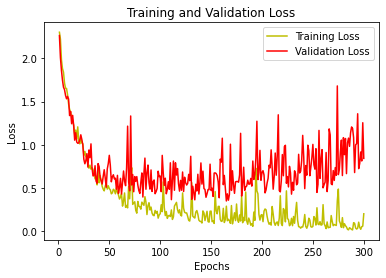

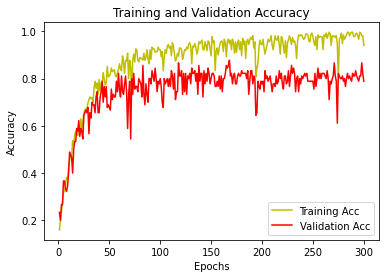

In [50]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
res = lstm2_dense2_d_relu_e300.predict(X_test)

In [34]:
yhat = lstm2_dense2_d_relu_e300.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [35]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 3 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [4 1 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 1 0 0]
 [1 1 1 0 5 1 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 1 0 1 7]]


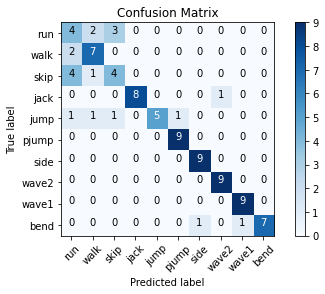

In [36]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [37]:
y_pred = lstm2_dense2_d_relu_e300.predict(X_test)
y_pred = (y_pred > 0.5)

In [38]:
_, acc = lstm2_dense2_d_relu_e300.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 1.2554 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [39]:
accuracy_score(ytrue, yhat)

0.7888888888888889

In [42]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.36      0.44      0.40         9
        walk       0.64      0.78      0.70         9
        skip       0.50      0.44      0.47         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.56      0.71         9
       pjump       0.90      1.00      0.95         9
        side       0.90      1.00      0.95         9
       wave2       0.90      1.00      0.95         9
       wave1       0.90      1.00      0.95         9
        bend       1.00      0.78      0.88         9

    accuracy                           0.79        90
   macro avg       0.81      0.79      0.79        90
weighted avg       0.81      0.79      0.79        90



# Dropout layer added below +  default tanh&sigmoid + nadam

# lstm2_dense2_d_default
lstm3 (128,64) + dense2 (32,10) + activation=default + nadam -> unexpectedly good, a bit overfit, a bit undiverse
#### Candidate

In [9]:
# Define a sequential model - another format
lstm2_dense2_d_default = Sequential([
    LSTM(128, return_sequences=True, input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [10]:
# Compile model with learning rate
lstm2_dense2_d_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [11]:
# Training model with validation
history = lstm2_dense2_d_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 12s - loss: 2.3069 - categorical_accuracy: 0.1185 - val_loss: 2.2522 - val_categorical_accuracy: 0.1444 - 12s/epoch - 180ms/step
Epoch 2/200
68/68 - 3s - loss: 2.2186 - categorical_accuracy: 0.1926 - val_loss: 2.1139 - val_categorical_accuracy: 0.1667 - 3s/epoch - 41ms/step
Epoch 3/200
68/68 - 3s - loss: 2.0653 - categorical_accuracy: 0.2000 - val_loss: 1.9477 - val_categorical_accuracy: 0.2667 - 3s/epoch - 40ms/step
Epoch 4/200
68/68 - 2s - loss: 1.8909 - categorical_accuracy: 0.2889 - val_loss: 1.7612 - val_categorical_accuracy: 0.3778 - 2s/epoch - 34ms/step
Epoch 5/200
68/68 - 2s - loss: 1.6964 - categorical_accuracy: 0.3222 - val_loss: 1.5559 - val_categorical_accuracy: 0.4111 - 2s/epoch - 33ms/step
Epoch 6/200
68/68 - 2s - loss: 1.5083 - categorical_accuracy: 0.4222 - val_loss: 1.6213 - val_categorical_accuracy: 0.2444 - 2s/epoch - 33ms/step
Epoch 7/200
68/68 - 2s - loss: 1.3962 - categorical_accuracy: 0.4815 - val_loss: 1.3410 - val_categorical_accuracy: 0.444

Epoch 57/200
68/68 - 2s - loss: 0.3696 - categorical_accuracy: 0.8519 - val_loss: 0.6464 - val_categorical_accuracy: 0.7444 - 2s/epoch - 36ms/step
Epoch 58/200
68/68 - 2s - loss: 0.3413 - categorical_accuracy: 0.8667 - val_loss: 0.6163 - val_categorical_accuracy: 0.7444 - 2s/epoch - 34ms/step
Epoch 59/200
68/68 - 2s - loss: 0.3095 - categorical_accuracy: 0.8963 - val_loss: 0.6444 - val_categorical_accuracy: 0.7556 - 2s/epoch - 36ms/step
Epoch 60/200
68/68 - 2s - loss: 0.3051 - categorical_accuracy: 0.8926 - val_loss: 0.7241 - val_categorical_accuracy: 0.7000 - 2s/epoch - 36ms/step
Epoch 61/200
68/68 - 3s - loss: 0.4381 - categorical_accuracy: 0.8519 - val_loss: 0.7805 - val_categorical_accuracy: 0.7000 - 3s/epoch - 38ms/step
Epoch 62/200
68/68 - 2s - loss: 0.3711 - categorical_accuracy: 0.8519 - val_loss: 1.0741 - val_categorical_accuracy: 0.5889 - 2s/epoch - 35ms/step
Epoch 63/200
68/68 - 2s - loss: 0.3873 - categorical_accuracy: 0.8556 - val_loss: 0.5842 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 2s - loss: 0.3845 - categorical_accuracy: 0.8852 - val_loss: 0.8203 - val_categorical_accuracy: 0.7333 - 2s/epoch - 35ms/step
Epoch 114/200
68/68 - 2s - loss: 0.2313 - categorical_accuracy: 0.9185 - val_loss: 0.8966 - val_categorical_accuracy: 0.7111 - 2s/epoch - 34ms/step
Epoch 115/200
68/68 - 2s - loss: 0.3033 - categorical_accuracy: 0.8963 - val_loss: 0.6767 - val_categorical_accuracy: 0.7667 - 2s/epoch - 34ms/step
Epoch 116/200
68/68 - 2s - loss: 0.1168 - categorical_accuracy: 0.9704 - val_loss: 0.6548 - val_categorical_accuracy: 0.8222 - 2s/epoch - 34ms/step
Epoch 117/200
68/68 - 2s - loss: 0.1262 - categorical_accuracy: 0.9704 - val_loss: 0.6767 - val_categorical_accuracy: 0.7556 - 2s/epoch - 34ms/step
Epoch 118/200
68/68 - 2s - loss: 0.1569 - categorical_accuracy: 0.9593 - val_loss: 0.6128 - val_categorical_accuracy: 0.7889 - 2s/epoch - 34ms/step
Epoch 119/200
68/68 - 2s - loss: 0.0903 - categorical_accuracy: 0.9815 - val_loss: 0.5521 - val_categorical_accu

Epoch 169/200
68/68 - 2s - loss: 0.0683 - categorical_accuracy: 0.9778 - val_loss: 0.6964 - val_categorical_accuracy: 0.8111 - 2s/epoch - 34ms/step
Epoch 170/200
68/68 - 3s - loss: 0.0591 - categorical_accuracy: 0.9815 - val_loss: 0.8859 - val_categorical_accuracy: 0.7778 - 3s/epoch - 39ms/step
Epoch 171/200
68/68 - 2s - loss: 0.1157 - categorical_accuracy: 0.9593 - val_loss: 0.9740 - val_categorical_accuracy: 0.7333 - 2s/epoch - 33ms/step
Epoch 172/200
68/68 - 3s - loss: 0.0995 - categorical_accuracy: 0.9815 - val_loss: 1.1987 - val_categorical_accuracy: 0.7000 - 3s/epoch - 39ms/step
Epoch 173/200
68/68 - 3s - loss: 0.2117 - categorical_accuracy: 0.9370 - val_loss: 0.9411 - val_categorical_accuracy: 0.7111 - 3s/epoch - 40ms/step
Epoch 174/200
68/68 - 2s - loss: 0.1564 - categorical_accuracy: 0.9556 - val_loss: 1.0348 - val_categorical_accuracy: 0.7111 - 2s/epoch - 33ms/step
Epoch 175/200
68/68 - 2s - loss: 0.2279 - categorical_accuracy: 0.9333 - val_loss: 0.5383 - val_categorical_accu

In [12]:
lstm2_dense2_d_default.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 128)           133632    
                                                                 
 dropout_2 (Dropout)         (None, 25, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trai

In [13]:
# Save Model
lstm2_dense2_d_default.save("lstm2_dense2_d_default_1345_17032022.h5")

In [14]:
# Load Model
lstm2_dense2_d_default.load_weights("lstm2_dense2_d_default_1345_17032022.h5")

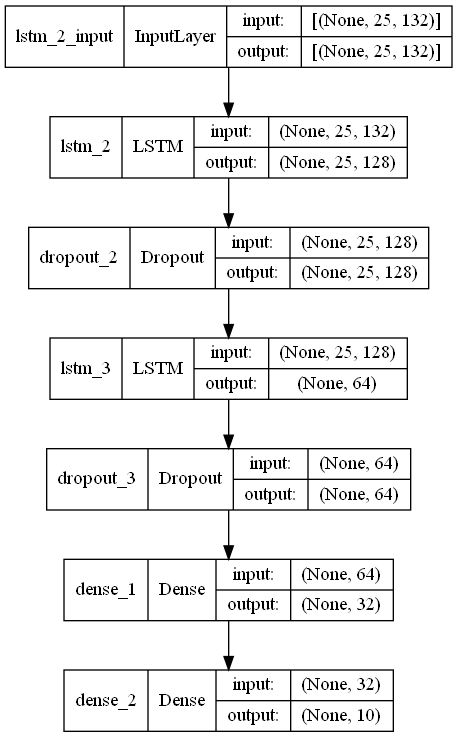

In [15]:
# Visualize
plot_model(lstm2_dense2_d_default, to_file = "arc_lstm2_dense2_d_default_1345_17032022.png", show_shapes = True)

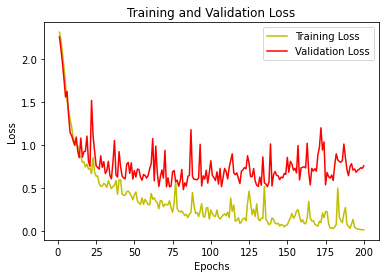

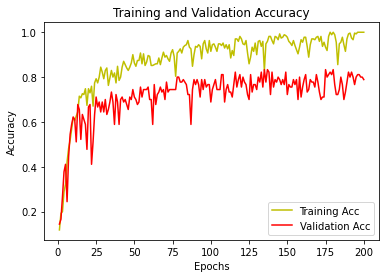

In [16]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [17]:
res = lstm2_dense2_d_default.predict(X_test)

In [18]:
yhat = lstm2_dense2_d_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [19]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 2 0 1 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [4 0 5 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


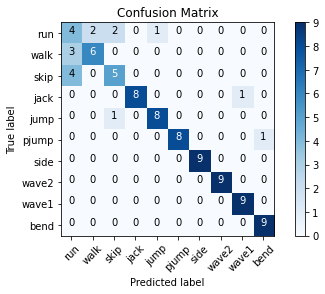

In [20]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [21]:
y_pred = lstm2_dense2_d_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [22]:
_, acc = lstm2_dense2_d_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 25ms/step - loss: 0.7139 - categorical_accuracy: 0.8333
Accuracy =  83.33333134651184  %


In [23]:
accuracy_score(ytrue, yhat)

0.8333333333333334

In [24]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.36      0.44      0.40         9
        walk       0.75      0.67      0.71         9
        skip       0.62      0.56      0.59         9
        jack       1.00      0.89      0.94         9
        jump       0.89      0.89      0.89         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.83        90
   macro avg       0.84      0.83      0.84        90
weighted avg       0.84      0.83      0.84        90



# lstm2_dense2_d_default_e300
lstm3 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=300 -> good but still worse

In [51]:
# Define a sequential model - another format
lstm2_dense2_d_default_e300 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [52]:
# Compile model with learning rate
lstm2_dense2_d_default_e300.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [53]:
# Training model with validation
history = lstm2_dense2_d_default_e300.fit(X_train, y_train, batch_size=4, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
68/68 - 9s - loss: 2.3099 - categorical_accuracy: 0.0778 - val_loss: 2.2788 - val_categorical_accuracy: 0.1222 - 9s/epoch - 139ms/step
Epoch 2/300
68/68 - 2s - loss: 2.2454 - categorical_accuracy: 0.1556 - val_loss: 2.1917 - val_categorical_accuracy: 0.1889 - 2s/epoch - 33ms/step
Epoch 3/300
68/68 - 2s - loss: 2.0992 - categorical_accuracy: 0.2481 - val_loss: 2.0071 - val_categorical_accuracy: 0.1889 - 2s/epoch - 33ms/step
Epoch 4/300
68/68 - 2s - loss: 1.9430 - categorical_accuracy: 0.2926 - val_loss: 1.9531 - val_categorical_accuracy: 0.2222 - 2s/epoch - 33ms/step
Epoch 5/300
68/68 - 2s - loss: 1.8215 - categorical_accuracy: 0.3444 - val_loss: 1.7845 - val_categorical_accuracy: 0.2889 - 2s/epoch - 33ms/step
Epoch 6/300
68/68 - 2s - loss: 1.6899 - categorical_accuracy: 0.3741 - val_loss: 1.8718 - val_categorical_accuracy: 0.2889 - 2s/epoch - 33ms/step
Epoch 7/300
68/68 - 2s - loss: 1.5725 - categorical_accuracy: 0.4333 - val_loss: 1.5048 - val_categorical_accuracy: 0.4222 

Epoch 57/300
68/68 - 2s - loss: 0.3105 - categorical_accuracy: 0.9037 - val_loss: 0.5358 - val_categorical_accuracy: 0.7778 - 2s/epoch - 33ms/step
Epoch 58/300
68/68 - 2s - loss: 0.2752 - categorical_accuracy: 0.9037 - val_loss: 0.6161 - val_categorical_accuracy: 0.7667 - 2s/epoch - 33ms/step
Epoch 59/300
68/68 - 2s - loss: 0.2475 - categorical_accuracy: 0.9407 - val_loss: 0.4232 - val_categorical_accuracy: 0.8111 - 2s/epoch - 33ms/step
Epoch 60/300
68/68 - 2s - loss: 0.2929 - categorical_accuracy: 0.9037 - val_loss: 0.7311 - val_categorical_accuracy: 0.6889 - 2s/epoch - 35ms/step
Epoch 61/300
68/68 - 2s - loss: 0.2857 - categorical_accuracy: 0.9000 - val_loss: 0.5554 - val_categorical_accuracy: 0.8222 - 2s/epoch - 34ms/step
Epoch 62/300
68/68 - 2s - loss: 0.2529 - categorical_accuracy: 0.9037 - val_loss: 0.5023 - val_categorical_accuracy: 0.7778 - 2s/epoch - 33ms/step
Epoch 63/300
68/68 - 2s - loss: 0.2812 - categorical_accuracy: 0.9037 - val_loss: 0.5907 - val_categorical_accuracy: 0

Epoch 113/300
68/68 - 2s - loss: 0.1947 - categorical_accuracy: 0.9370 - val_loss: 0.6985 - val_categorical_accuracy: 0.7444 - 2s/epoch - 35ms/step
Epoch 114/300
68/68 - 2s - loss: 0.1455 - categorical_accuracy: 0.9519 - val_loss: 0.5931 - val_categorical_accuracy: 0.7556 - 2s/epoch - 33ms/step
Epoch 115/300
68/68 - 2s - loss: 0.1325 - categorical_accuracy: 0.9630 - val_loss: 0.5865 - val_categorical_accuracy: 0.7667 - 2s/epoch - 33ms/step
Epoch 116/300
68/68 - 2s - loss: 0.0898 - categorical_accuracy: 0.9741 - val_loss: 0.6963 - val_categorical_accuracy: 0.8000 - 2s/epoch - 33ms/step
Epoch 117/300
68/68 - 2s - loss: 0.0952 - categorical_accuracy: 0.9741 - val_loss: 0.6136 - val_categorical_accuracy: 0.8111 - 2s/epoch - 33ms/step
Epoch 118/300
68/68 - 2s - loss: 0.0690 - categorical_accuracy: 0.9852 - val_loss: 0.7770 - val_categorical_accuracy: 0.7778 - 2s/epoch - 32ms/step
Epoch 119/300
68/68 - 2s - loss: 0.1252 - categorical_accuracy: 0.9667 - val_loss: 0.6577 - val_categorical_accu

Epoch 169/300
68/68 - 2s - loss: 0.0500 - categorical_accuracy: 0.9963 - val_loss: 0.6195 - val_categorical_accuracy: 0.8111 - 2s/epoch - 33ms/step
Epoch 170/300
68/68 - 2s - loss: 0.0450 - categorical_accuracy: 0.9963 - val_loss: 0.5021 - val_categorical_accuracy: 0.8333 - 2s/epoch - 33ms/step
Epoch 171/300
68/68 - 2s - loss: 0.1364 - categorical_accuracy: 0.9519 - val_loss: 0.6137 - val_categorical_accuracy: 0.8000 - 2s/epoch - 33ms/step
Epoch 172/300
68/68 - 2s - loss: 0.1031 - categorical_accuracy: 0.9741 - val_loss: 0.6020 - val_categorical_accuracy: 0.8111 - 2s/epoch - 33ms/step
Epoch 173/300
68/68 - 2s - loss: 0.0622 - categorical_accuracy: 0.9889 - val_loss: 0.5666 - val_categorical_accuracy: 0.8111 - 2s/epoch - 33ms/step
Epoch 174/300
68/68 - 2s - loss: 0.0584 - categorical_accuracy: 0.9815 - val_loss: 0.4841 - val_categorical_accuracy: 0.8444 - 2s/epoch - 33ms/step
Epoch 175/300
68/68 - 2s - loss: 0.0638 - categorical_accuracy: 0.9889 - val_loss: 0.5802 - val_categorical_accu

Epoch 225/300
68/68 - 2s - loss: 0.0859 - categorical_accuracy: 0.9815 - val_loss: 0.6983 - val_categorical_accuracy: 0.7889 - 2s/epoch - 33ms/step
Epoch 226/300
68/68 - 2s - loss: 0.0896 - categorical_accuracy: 0.9704 - val_loss: 0.7692 - val_categorical_accuracy: 0.8222 - 2s/epoch - 32ms/step
Epoch 227/300
68/68 - 2s - loss: 0.0247 - categorical_accuracy: 1.0000 - val_loss: 0.6212 - val_categorical_accuracy: 0.8333 - 2s/epoch - 33ms/step
Epoch 228/300
68/68 - 2s - loss: 0.0255 - categorical_accuracy: 0.9963 - val_loss: 0.5946 - val_categorical_accuracy: 0.8444 - 2s/epoch - 33ms/step
Epoch 229/300
68/68 - 2s - loss: 0.0158 - categorical_accuracy: 1.0000 - val_loss: 0.6598 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 230/300
68/68 - 2s - loss: 0.0167 - categorical_accuracy: 1.0000 - val_loss: 0.6342 - val_categorical_accuracy: 0.8333 - 2s/epoch - 33ms/step
Epoch 231/300
68/68 - 2s - loss: 0.0132 - categorical_accuracy: 1.0000 - val_loss: 0.5731 - val_categorical_accu

Epoch 281/300
68/68 - 2s - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.6162 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 282/300
68/68 - 2s - loss: 0.0078 - categorical_accuracy: 1.0000 - val_loss: 0.6357 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 283/300
68/68 - 2s - loss: 0.0092 - categorical_accuracy: 1.0000 - val_loss: 0.7025 - val_categorical_accuracy: 0.8111 - 2s/epoch - 32ms/step
Epoch 284/300
68/68 - 2s - loss: 0.0061 - categorical_accuracy: 1.0000 - val_loss: 0.7230 - val_categorical_accuracy: 0.8222 - 2s/epoch - 33ms/step
Epoch 285/300
68/68 - 2s - loss: 0.0069 - categorical_accuracy: 1.0000 - val_loss: 0.6708 - val_categorical_accuracy: 0.8333 - 2s/epoch - 33ms/step
Epoch 286/300
68/68 - 2s - loss: 0.0061 - categorical_accuracy: 1.0000 - val_loss: 0.6833 - val_categorical_accuracy: 0.8000 - 2s/epoch - 33ms/step
Epoch 287/300
68/68 - 2s - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.6131 - val_categorical_accu

In [54]:
lstm2_dense2_d_default_e300.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 25, 128)           133632    
                                                                 
 dropout_8 (Dropout)         (None, 25, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-tr

In [55]:
# Save Model
lstm2_dense2_d_default_e300.save("lstm2_dense2_d_default_e300_1510_17032022.h5")

In [56]:
# Load Model
lstm2_dense2_d_default_e300.load_weights("lstm2_dense2_d_default_e300_1510_17032022.h5")

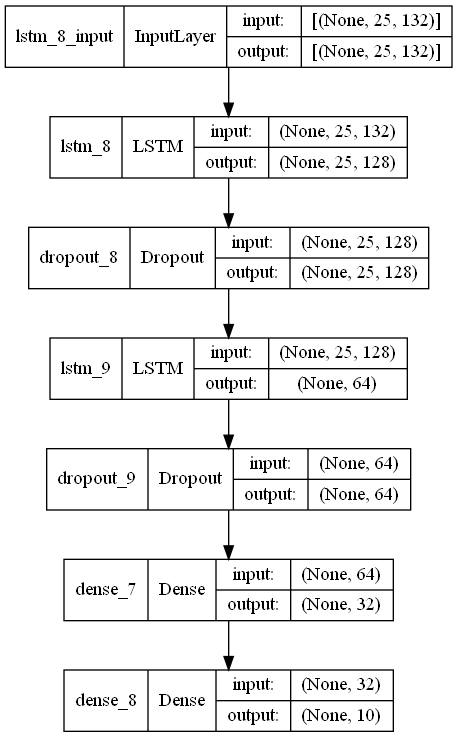

In [57]:
# Visualize
plot_model(lstm2_dense2_d_default_e300, to_file = "arc_lstm2_dense2_d_default_e300_1510_17032022.png", show_shapes = True)

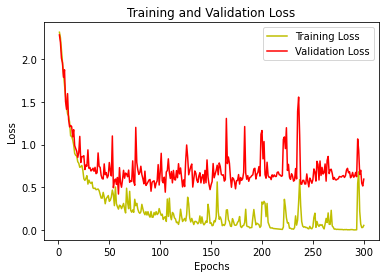

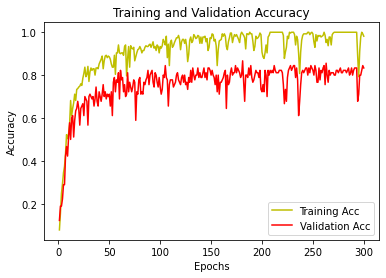

In [58]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [59]:
res = lstm2_dense2_d_default_e300.predict(X_test)

In [60]:
yhat = lstm2_dense2_d_default_e300.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [61]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 1 4 0 0 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [3 1 4 0 1 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


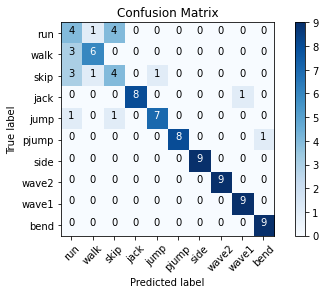

In [62]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [63]:
y_pred = lstm2_dense2_d_default_e300.predict(X_test)
y_pred = (y_pred > 0.5)

In [64]:
_, acc = lstm2_dense2_d_default_e300.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 19ms/step - loss: 0.7237 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [65]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [66]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.36      0.44      0.40         9
        walk       0.75      0.67      0.71         9
        skip       0.44      0.44      0.44         9
        jack       1.00      0.89      0.94         9
        jump       0.88      0.78      0.82         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.81        90
   macro avg       0.82      0.81      0.82        90
weighted avg       0.82      0.81      0.82        90



# lstm2_dense2_rd_default_e300
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=300 + recurrent_dropout -> bad, testing not as good as training

In [68]:
# Define a sequential model - another format
lstm2_dense2_rd_default_e300 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [69]:
# Compile model with learning rate
lstm2_dense2_rd_default_e300.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [70]:
# Training model with validation
history = lstm2_dense2_rd_default_e300.fit(X_train, y_train, batch_size=4, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
68/68 - 12s - loss: 2.2884 - categorical_accuracy: 0.1704 - val_loss: 2.2297 - val_categorical_accuracy: 0.2111 - 12s/epoch - 177ms/step
Epoch 2/300
68/68 - 4s - loss: 2.1494 - categorical_accuracy: 0.2111 - val_loss: 2.0401 - val_categorical_accuracy: 0.2556 - 4s/epoch - 65ms/step
Epoch 3/300
68/68 - 4s - loss: 1.9490 - categorical_accuracy: 0.2778 - val_loss: 1.8857 - val_categorical_accuracy: 0.2556 - 4s/epoch - 65ms/step
Epoch 4/300
68/68 - 4s - loss: 1.7514 - categorical_accuracy: 0.3111 - val_loss: 1.6616 - val_categorical_accuracy: 0.3667 - 4s/epoch - 66ms/step
Epoch 5/300
68/68 - 4s - loss: 1.5749 - categorical_accuracy: 0.3815 - val_loss: 1.4649 - val_categorical_accuracy: 0.4222 - 4s/epoch - 65ms/step
Epoch 6/300
68/68 - 4s - loss: 1.4293 - categorical_accuracy: 0.4889 - val_loss: 1.3010 - val_categorical_accuracy: 0.5000 - 4s/epoch - 66ms/step
Epoch 7/300
68/68 - 4s - loss: 1.2931 - categorical_accuracy: 0.5407 - val_loss: 1.3397 - val_categorical_accuracy: 0.566

Epoch 57/300
68/68 - 4s - loss: 0.2792 - categorical_accuracy: 0.8963 - val_loss: 0.6195 - val_categorical_accuracy: 0.7222 - 4s/epoch - 64ms/step
Epoch 58/300
68/68 - 4s - loss: 0.2852 - categorical_accuracy: 0.8963 - val_loss: 0.8804 - val_categorical_accuracy: 0.6556 - 4s/epoch - 64ms/step
Epoch 59/300
68/68 - 4s - loss: 0.4353 - categorical_accuracy: 0.8481 - val_loss: 0.7923 - val_categorical_accuracy: 0.6556 - 4s/epoch - 65ms/step
Epoch 60/300
68/68 - 4s - loss: 0.6364 - categorical_accuracy: 0.8037 - val_loss: 0.5908 - val_categorical_accuracy: 0.7111 - 4s/epoch - 65ms/step
Epoch 61/300
68/68 - 4s - loss: 0.3649 - categorical_accuracy: 0.8630 - val_loss: 0.6645 - val_categorical_accuracy: 0.7222 - 4s/epoch - 65ms/step
Epoch 62/300
68/68 - 5s - loss: 0.3710 - categorical_accuracy: 0.8704 - val_loss: 0.6936 - val_categorical_accuracy: 0.7333 - 5s/epoch - 67ms/step
Epoch 63/300
68/68 - 4s - loss: 0.3438 - categorical_accuracy: 0.8704 - val_loss: 0.5625 - val_categorical_accuracy: 0

Epoch 113/300
68/68 - 4s - loss: 0.1288 - categorical_accuracy: 0.9593 - val_loss: 0.5652 - val_categorical_accuracy: 0.7889 - 4s/epoch - 65ms/step
Epoch 114/300
68/68 - 4s - loss: 0.1365 - categorical_accuracy: 0.9519 - val_loss: 0.5008 - val_categorical_accuracy: 0.8444 - 4s/epoch - 65ms/step
Epoch 115/300
68/68 - 4s - loss: 0.1224 - categorical_accuracy: 0.9630 - val_loss: 0.5424 - val_categorical_accuracy: 0.7778 - 4s/epoch - 65ms/step
Epoch 116/300
68/68 - 4s - loss: 0.1781 - categorical_accuracy: 0.9370 - val_loss: 0.5590 - val_categorical_accuracy: 0.7889 - 4s/epoch - 65ms/step
Epoch 117/300
68/68 - 4s - loss: 0.0967 - categorical_accuracy: 0.9778 - val_loss: 0.5767 - val_categorical_accuracy: 0.7778 - 4s/epoch - 65ms/step
Epoch 118/300
68/68 - 4s - loss: 0.0849 - categorical_accuracy: 0.9741 - val_loss: 0.6650 - val_categorical_accuracy: 0.7667 - 4s/epoch - 66ms/step
Epoch 119/300
68/68 - 5s - loss: 0.0928 - categorical_accuracy: 0.9704 - val_loss: 0.6324 - val_categorical_accu

Epoch 169/300
68/68 - 5s - loss: 0.1503 - categorical_accuracy: 0.9444 - val_loss: 0.6725 - val_categorical_accuracy: 0.8222 - 5s/epoch - 69ms/step
Epoch 170/300
68/68 - 5s - loss: 0.0934 - categorical_accuracy: 0.9778 - val_loss: 0.5260 - val_categorical_accuracy: 0.8333 - 5s/epoch - 67ms/step
Epoch 171/300
68/68 - 5s - loss: 0.0614 - categorical_accuracy: 0.9852 - val_loss: 0.4355 - val_categorical_accuracy: 0.8556 - 5s/epoch - 71ms/step
Epoch 172/300
68/68 - 6s - loss: 0.0620 - categorical_accuracy: 0.9815 - val_loss: 0.5724 - val_categorical_accuracy: 0.8111 - 6s/epoch - 85ms/step
Epoch 173/300
68/68 - 6s - loss: 0.0876 - categorical_accuracy: 0.9778 - val_loss: 0.5520 - val_categorical_accuracy: 0.8000 - 6s/epoch - 89ms/step
Epoch 174/300
68/68 - 6s - loss: 0.0379 - categorical_accuracy: 0.9926 - val_loss: 0.6034 - val_categorical_accuracy: 0.8000 - 6s/epoch - 82ms/step
Epoch 175/300
68/68 - 6s - loss: 0.0571 - categorical_accuracy: 0.9778 - val_loss: 0.5308 - val_categorical_accu

Epoch 225/300
68/68 - 4s - loss: 0.1019 - categorical_accuracy: 0.9704 - val_loss: 0.6614 - val_categorical_accuracy: 0.8000 - 4s/epoch - 66ms/step
Epoch 226/300
68/68 - 5s - loss: 0.0977 - categorical_accuracy: 0.9704 - val_loss: 0.7286 - val_categorical_accuracy: 0.7444 - 5s/epoch - 66ms/step
Epoch 227/300
68/68 - 5s - loss: 0.0667 - categorical_accuracy: 0.9889 - val_loss: 0.6490 - val_categorical_accuracy: 0.8111 - 5s/epoch - 72ms/step
Epoch 228/300
68/68 - 5s - loss: 0.0551 - categorical_accuracy: 0.9778 - val_loss: 0.6153 - val_categorical_accuracy: 0.8556 - 5s/epoch - 67ms/step
Epoch 229/300
68/68 - 5s - loss: 0.0650 - categorical_accuracy: 0.9815 - val_loss: 0.6382 - val_categorical_accuracy: 0.8222 - 5s/epoch - 68ms/step
Epoch 230/300
68/68 - 5s - loss: 0.0497 - categorical_accuracy: 0.9889 - val_loss: 0.6638 - val_categorical_accuracy: 0.8111 - 5s/epoch - 67ms/step
Epoch 231/300
68/68 - 5s - loss: 0.0323 - categorical_accuracy: 0.9963 - val_loss: 0.6138 - val_categorical_accu

Epoch 281/300
68/68 - 5s - loss: 0.0789 - categorical_accuracy: 0.9778 - val_loss: 0.8890 - val_categorical_accuracy: 0.7556 - 5s/epoch - 73ms/step
Epoch 282/300
68/68 - 5s - loss: 0.0962 - categorical_accuracy: 0.9667 - val_loss: 0.6681 - val_categorical_accuracy: 0.8333 - 5s/epoch - 73ms/step
Epoch 283/300
68/68 - 5s - loss: 0.0164 - categorical_accuracy: 0.9963 - val_loss: 0.7572 - val_categorical_accuracy: 0.7889 - 5s/epoch - 70ms/step
Epoch 284/300
68/68 - 5s - loss: 0.0559 - categorical_accuracy: 0.9778 - val_loss: 0.8893 - val_categorical_accuracy: 0.7667 - 5s/epoch - 70ms/step
Epoch 285/300
68/68 - 5s - loss: 0.0517 - categorical_accuracy: 0.9815 - val_loss: 0.7151 - val_categorical_accuracy: 0.8000 - 5s/epoch - 72ms/step
Epoch 286/300
68/68 - 5s - loss: 0.0188 - categorical_accuracy: 0.9963 - val_loss: 0.6108 - val_categorical_accuracy: 0.8222 - 5s/epoch - 73ms/step
Epoch 287/300
68/68 - 5s - loss: 0.0101 - categorical_accuracy: 0.9963 - val_loss: 0.7787 - val_categorical_accu

In [71]:
lstm2_dense2_rd_default_e300.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Save Model
lstm2_dense2_rd_default_e300.save("lstm2_dense2_rd_default_e300_1532_17032022.h5")

In [73]:
# Load Model
lstm2_dense2_rd_default_e300.load_weights("lstm2_dense2_rd_default_e300_1532_17032022.h5")

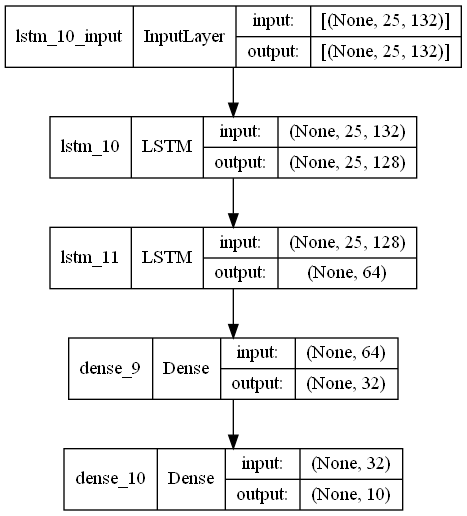

In [74]:
# Visualize
plot_model(lstm2_dense2_rd_default_e300, to_file = "arc_lstm2_dense2_rd_default_e300_1532_17032022.png", show_shapes = True)

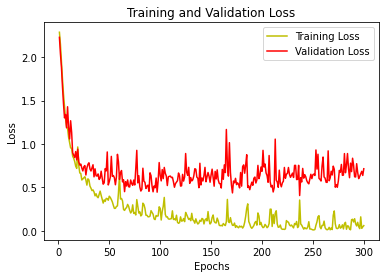

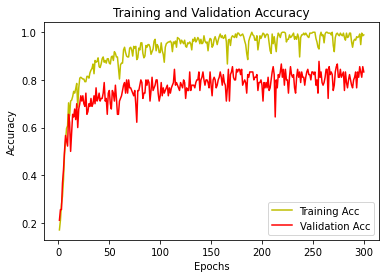

In [75]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [76]:
res = lstm2_dense2_rd_default_e300.predict(X_test)

In [77]:
yhat = lstm2_dense2_rd_default_e300.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [78]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 3 2 0 0 0 0 0 0 0]
 [4 5 0 0 0 0 0 0 0 0]
 [5 2 1 0 1 0 0 0 0 0]
 [0 0 0 7 0 1 0 1 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 7 1 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [1 0 0 0 0 0 0 0 0 8]]


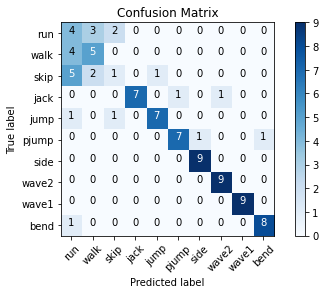

In [79]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [80]:
y_pred = lstm2_dense2_rd_default_e300.predict(X_test)
y_pred = (y_pred > 0.5)

In [81]:
_, acc = lstm2_dense2_rd_default_e300.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 20ms/step - loss: 0.9429 - categorical_accuracy: 0.7333
Accuracy =  73.33333492279053  %


In [82]:
accuracy_score(ytrue, yhat)

0.7333333333333333

In [83]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.27      0.44      0.33         9
        walk       0.50      0.56      0.53         9
        skip       0.25      0.11      0.15         9
        jack       1.00      0.78      0.88         9
        jump       0.88      0.78      0.82         9
       pjump       0.88      0.78      0.82         9
        side       0.90      1.00      0.95         9
       wave2       0.90      1.00      0.95         9
       wave1       1.00      1.00      1.00         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.73        90
   macro avg       0.75      0.73      0.73        90
weighted avg       0.75      0.73      0.73        90



# lstm2_dense2_rd_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout -> good though, need a bit more diversity
#### Candidate

In [84]:
# Define a sequential model - another format
lstm2_dense2_rd_default = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [85]:
# Compile model with learning rate
lstm2_dense2_rd_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [86]:
# Training model with validation
history = lstm2_dense2_rd_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 14s - loss: 2.3132 - categorical_accuracy: 0.1296 - val_loss: 2.2854 - val_categorical_accuracy: 0.2778 - 14s/epoch - 210ms/step
Epoch 2/200
68/68 - 6s - loss: 2.2547 - categorical_accuracy: 0.2037 - val_loss: 2.2146 - val_categorical_accuracy: 0.2889 - 6s/epoch - 83ms/step
Epoch 3/200
68/68 - 5s - loss: 2.1425 - categorical_accuracy: 0.2481 - val_loss: 2.0478 - val_categorical_accuracy: 0.2556 - 5s/epoch - 79ms/step
Epoch 4/200
68/68 - 6s - loss: 1.9886 - categorical_accuracy: 0.2852 - val_loss: 1.9184 - val_categorical_accuracy: 0.3000 - 6s/epoch - 92ms/step
Epoch 5/200
68/68 - 7s - loss: 1.8281 - categorical_accuracy: 0.3074 - val_loss: 1.7439 - val_categorical_accuracy: 0.3222 - 7s/epoch - 102ms/step
Epoch 6/200
68/68 - 6s - loss: 1.6989 - categorical_accuracy: 0.3407 - val_loss: 1.5504 - val_categorical_accuracy: 0.4222 - 6s/epoch - 89ms/step
Epoch 7/200
68/68 - 5s - loss: 1.5033 - categorical_accuracy: 0.4333 - val_loss: 1.5369 - val_categorical_accuracy: 0.45

Epoch 57/200
68/68 - 6s - loss: 0.5466 - categorical_accuracy: 0.7926 - val_loss: 0.5109 - val_categorical_accuracy: 0.7778 - 6s/epoch - 81ms/step
Epoch 58/200
68/68 - 5s - loss: 0.3367 - categorical_accuracy: 0.8741 - val_loss: 0.5881 - val_categorical_accuracy: 0.7556 - 5s/epoch - 73ms/step
Epoch 59/200
68/68 - 7s - loss: 0.3413 - categorical_accuracy: 0.8667 - val_loss: 0.5499 - val_categorical_accuracy: 0.7444 - 7s/epoch - 101ms/step
Epoch 60/200
68/68 - 9s - loss: 0.3236 - categorical_accuracy: 0.8926 - val_loss: 0.4214 - val_categorical_accuracy: 0.8000 - 9s/epoch - 139ms/step
Epoch 61/200
68/68 - 9s - loss: 0.3239 - categorical_accuracy: 0.8852 - val_loss: 0.4610 - val_categorical_accuracy: 0.7667 - 9s/epoch - 136ms/step
Epoch 62/200
68/68 - 7s - loss: 0.2990 - categorical_accuracy: 0.9074 - val_loss: 0.6248 - val_categorical_accuracy: 0.7667 - 7s/epoch - 107ms/step
Epoch 63/200
68/68 - 6s - loss: 0.4134 - categorical_accuracy: 0.8519 - val_loss: 0.6313 - val_categorical_accurac

Epoch 113/200
68/68 - 6s - loss: 0.1789 - categorical_accuracy: 0.9407 - val_loss: 0.5565 - val_categorical_accuracy: 0.7222 - 6s/epoch - 86ms/step
Epoch 114/200
68/68 - 5s - loss: 0.1527 - categorical_accuracy: 0.9444 - val_loss: 0.4301 - val_categorical_accuracy: 0.7889 - 5s/epoch - 77ms/step
Epoch 115/200
68/68 - 5s - loss: 0.1335 - categorical_accuracy: 0.9593 - val_loss: 0.3611 - val_categorical_accuracy: 0.8000 - 5s/epoch - 78ms/step
Epoch 116/200
68/68 - 5s - loss: 0.1130 - categorical_accuracy: 0.9741 - val_loss: 0.4061 - val_categorical_accuracy: 0.8000 - 5s/epoch - 77ms/step
Epoch 117/200
68/68 - 5s - loss: 0.1703 - categorical_accuracy: 0.9370 - val_loss: 0.4413 - val_categorical_accuracy: 0.8444 - 5s/epoch - 75ms/step
Epoch 118/200
68/68 - 5s - loss: 0.2297 - categorical_accuracy: 0.9370 - val_loss: 0.4767 - val_categorical_accuracy: 0.7667 - 5s/epoch - 78ms/step
Epoch 119/200
68/68 - 5s - loss: 0.1939 - categorical_accuracy: 0.9259 - val_loss: 0.4773 - val_categorical_accu

Epoch 169/200
68/68 - 5s - loss: 0.1191 - categorical_accuracy: 0.9667 - val_loss: 0.5701 - val_categorical_accuracy: 0.7778 - 5s/epoch - 71ms/step
Epoch 170/200
68/68 - 5s - loss: 0.1985 - categorical_accuracy: 0.9296 - val_loss: 0.5585 - val_categorical_accuracy: 0.8000 - 5s/epoch - 68ms/step
Epoch 171/200
68/68 - 5s - loss: 0.2720 - categorical_accuracy: 0.9222 - val_loss: 0.5139 - val_categorical_accuracy: 0.7667 - 5s/epoch - 68ms/step
Epoch 172/200
68/68 - 5s - loss: 0.2307 - categorical_accuracy: 0.9074 - val_loss: 0.4810 - val_categorical_accuracy: 0.7778 - 5s/epoch - 72ms/step
Epoch 173/200
68/68 - 5s - loss: 0.1040 - categorical_accuracy: 0.9667 - val_loss: 0.4577 - val_categorical_accuracy: 0.8000 - 5s/epoch - 73ms/step
Epoch 174/200
68/68 - 5s - loss: 0.0936 - categorical_accuracy: 0.9741 - val_loss: 0.3215 - val_categorical_accuracy: 0.8556 - 5s/epoch - 70ms/step
Epoch 175/200
68/68 - 5s - loss: 0.0783 - categorical_accuracy: 0.9778 - val_loss: 0.4341 - val_categorical_accu

In [87]:
lstm2_dense2_rd_default.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Save Model
lstm2_dense2_rd_default.save("lstm2_dense2_rd_default_1608_17032022.h5")

In [89]:
# Load Model
lstm2_dense2_rd_default.load_weights("lstm2_dense2_rd_default_1608_17032022.h5")

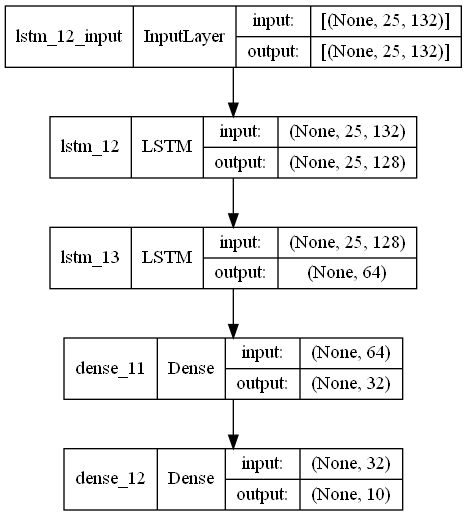

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_default, to_file = "arc_lstm2_dense2_rd_default_1608_17032022.png", show_shapes = True)

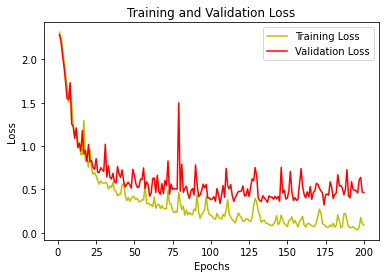

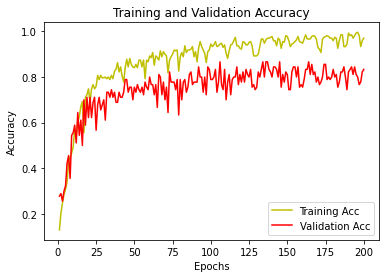

In [91]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [92]:
res = lstm2_dense2_rd_default.predict(X_test)

In [93]:
yhat = lstm2_dense2_rd_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [94]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 3 1 0 1 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [2 2 4 0 1 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [2 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


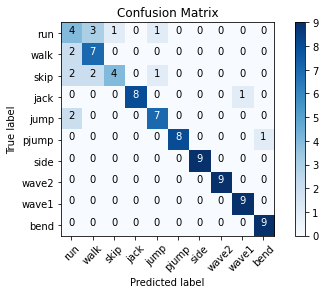

In [95]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [96]:
y_pred = lstm2_dense2_rd_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [97]:
_, acc = lstm2_dense2_rd_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 0.5187 - categorical_accuracy: 0.8222
Accuracy =  82.22222328186035  %


In [98]:
accuracy_score(ytrue, yhat)

0.8222222222222222

In [83]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.27      0.44      0.33         9
        walk       0.50      0.56      0.53         9
        skip       0.25      0.11      0.15         9
        jack       1.00      0.78      0.88         9
        jump       0.88      0.78      0.82         9
       pjump       0.88      0.78      0.82         9
        side       0.90      1.00      0.95         9
       wave2       0.90      1.00      0.95         9
       wave1       1.00      1.00      1.00         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.73        90
   macro avg       0.75      0.73      0.73        90
weighted avg       0.75      0.73      0.73        90



# lstm2_dense2_d_rd_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + dropout + recurrent_dropout -> good, not enough

In [99]:
# Define a sequential model - another format
lstm2_dense2_d_rd_default = Sequential([
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [100]:
# Compile model with learning rate
lstm2_dense2_d_rd_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [101]:
# Training model with validation
history = lstm2_dense2_d_rd_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 14s - loss: 2.2736 - categorical_accuracy: 0.1444 - val_loss: 2.1901 - val_categorical_accuracy: 0.3000 - 14s/epoch - 210ms/step
Epoch 2/200
68/68 - 5s - loss: 2.1221 - categorical_accuracy: 0.2185 - val_loss: 1.9781 - val_categorical_accuracy: 0.2778 - 5s/epoch - 71ms/step
Epoch 3/200
68/68 - 5s - loss: 1.9508 - categorical_accuracy: 0.2519 - val_loss: 1.8761 - val_categorical_accuracy: 0.2778 - 5s/epoch - 73ms/step
Epoch 4/200
68/68 - 5s - loss: 1.8523 - categorical_accuracy: 0.3148 - val_loss: 1.7223 - val_categorical_accuracy: 0.3333 - 5s/epoch - 73ms/step
Epoch 5/200
68/68 - 5s - loss: 1.7553 - categorical_accuracy: 0.3481 - val_loss: 1.6760 - val_categorical_accuracy: 0.3889 - 5s/epoch - 74ms/step
Epoch 6/200
68/68 - 5s - loss: 1.6653 - categorical_accuracy: 0.3667 - val_loss: 1.5961 - val_categorical_accuracy: 0.4111 - 5s/epoch - 73ms/step
Epoch 7/200
68/68 - 5s - loss: 1.5783 - categorical_accuracy: 0.4148 - val_loss: 1.5053 - val_categorical_accuracy: 0.444

Epoch 57/200
68/68 - 5s - loss: 0.5810 - categorical_accuracy: 0.8000 - val_loss: 0.6135 - val_categorical_accuracy: 0.7667 - 5s/epoch - 71ms/step
Epoch 58/200
68/68 - 5s - loss: 0.5545 - categorical_accuracy: 0.8111 - val_loss: 0.5894 - val_categorical_accuracy: 0.7444 - 5s/epoch - 76ms/step
Epoch 59/200
68/68 - 5s - loss: 0.5369 - categorical_accuracy: 0.8185 - val_loss: 0.5990 - val_categorical_accuracy: 0.7889 - 5s/epoch - 73ms/step
Epoch 60/200
68/68 - 5s - loss: 0.5544 - categorical_accuracy: 0.8074 - val_loss: 0.6070 - val_categorical_accuracy: 0.7556 - 5s/epoch - 72ms/step
Epoch 61/200
68/68 - 5s - loss: 0.4932 - categorical_accuracy: 0.8259 - val_loss: 0.6286 - val_categorical_accuracy: 0.7111 - 5s/epoch - 72ms/step
Epoch 62/200
68/68 - 5s - loss: 0.4505 - categorical_accuracy: 0.8370 - val_loss: 0.5958 - val_categorical_accuracy: 0.7111 - 5s/epoch - 72ms/step
Epoch 63/200
68/68 - 5s - loss: 0.4810 - categorical_accuracy: 0.8259 - val_loss: 0.5495 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 6s - loss: 0.3613 - categorical_accuracy: 0.8667 - val_loss: 0.7350 - val_categorical_accuracy: 0.7000 - 6s/epoch - 87ms/step
Epoch 114/200
68/68 - 6s - loss: 0.3326 - categorical_accuracy: 0.8556 - val_loss: 0.4207 - val_categorical_accuracy: 0.8000 - 6s/epoch - 93ms/step
Epoch 115/200
68/68 - 7s - loss: 0.3532 - categorical_accuracy: 0.8667 - val_loss: 0.4353 - val_categorical_accuracy: 0.8111 - 7s/epoch - 100ms/step
Epoch 116/200
68/68 - 6s - loss: 0.3021 - categorical_accuracy: 0.8852 - val_loss: 0.6633 - val_categorical_accuracy: 0.7556 - 6s/epoch - 86ms/step
Epoch 117/200
68/68 - 6s - loss: 0.2814 - categorical_accuracy: 0.8593 - val_loss: 0.5110 - val_categorical_accuracy: 0.8000 - 6s/epoch - 92ms/step
Epoch 118/200
68/68 - 7s - loss: 0.2703 - categorical_accuracy: 0.8963 - val_loss: 0.4987 - val_categorical_accuracy: 0.7889 - 7s/epoch - 104ms/step
Epoch 119/200
68/68 - 6s - loss: 0.3288 - categorical_accuracy: 0.8852 - val_loss: 0.5158 - val_categorical_ac

Epoch 169/200
68/68 - 6s - loss: 0.2212 - categorical_accuracy: 0.9185 - val_loss: 0.4455 - val_categorical_accuracy: 0.8222 - 6s/epoch - 85ms/step
Epoch 170/200
68/68 - 6s - loss: 0.3025 - categorical_accuracy: 0.8926 - val_loss: 0.4880 - val_categorical_accuracy: 0.8222 - 6s/epoch - 87ms/step
Epoch 171/200
68/68 - 6s - loss: 0.2624 - categorical_accuracy: 0.8778 - val_loss: 0.4785 - val_categorical_accuracy: 0.7667 - 6s/epoch - 84ms/step
Epoch 172/200
68/68 - 6s - loss: 0.2567 - categorical_accuracy: 0.8815 - val_loss: 0.4336 - val_categorical_accuracy: 0.8222 - 6s/epoch - 90ms/step
Epoch 173/200
68/68 - 6s - loss: 0.1739 - categorical_accuracy: 0.9444 - val_loss: 0.4717 - val_categorical_accuracy: 0.7889 - 6s/epoch - 86ms/step
Epoch 174/200
68/68 - 6s - loss: 0.2974 - categorical_accuracy: 0.8778 - val_loss: 0.4355 - val_categorical_accuracy: 0.8000 - 6s/epoch - 87ms/step
Epoch 175/200
68/68 - 6s - loss: 0.1872 - categorical_accuracy: 0.9370 - val_loss: 0.4491 - val_categorical_accu

In [102]:
lstm2_dense2_d_rd_default.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_15 (LSTM)              (None, 64)                49408     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Save Model
lstm2_dense2_d_rd_default.save("lstm2_dense2_d_rd_default_1638_17032022.h5")

In [104]:
# Load Model
lstm2_dense2_d_rd_default.load_weights("lstm2_dense2_d_rd_default_1638_17032022.h5")

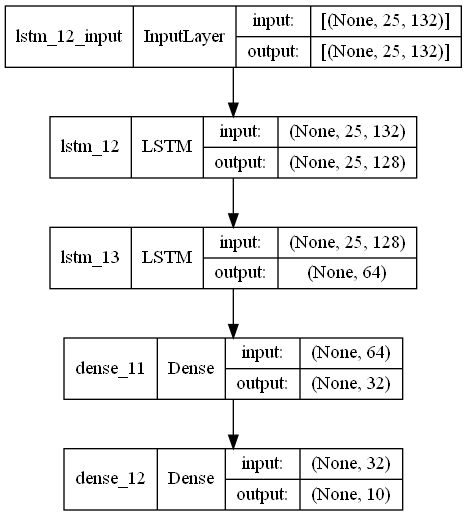

In [90]:
# Visualize
plot_model(lstm2_dense2_d_rd_default, to_file = "arc_lstm2_dense2_d_rd_default_1638_17032022.png", show_shapes = True)

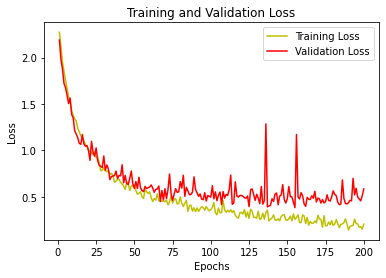

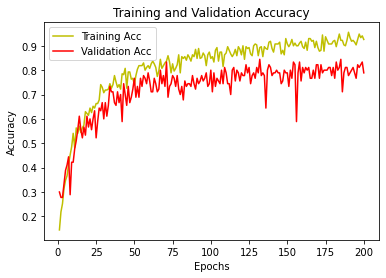

In [105]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [106]:
res = lstm2_dense2_d_rd_default.predict(X_test)

In [107]:
yhat = lstm2_dense2_d_rd_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [108]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[2 5 1 0 1 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [3 3 2 0 1 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


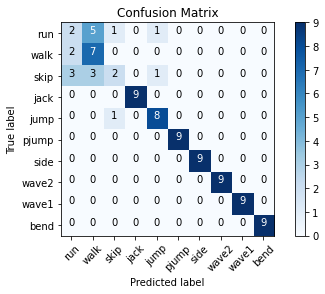

In [109]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [110]:
y_pred = lstm2_dense2_d_rd_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [111]:
_, acc = lstm2_dense2_d_rd_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 19ms/step - loss: 0.6337 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [112]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [113]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.29      0.22      0.25         9
        walk       0.47      0.78      0.58         9
        skip       0.50      0.22      0.31         9
        jack       1.00      1.00      1.00         9
        jump       0.80      0.89      0.84         9
       pjump       1.00      1.00      1.00         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.80        90
weighted avg       0.81      0.81      0.80        90



# lstm2_dense2_rd5_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout=0.5 -> bad

In [117]:
# Define a sequential model - another format
lstm2_dense2_rd5_default = Sequential([
    LSTM(128, recurrent_dropout=0.5, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.5, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [118]:
# Compile model with learning rate
lstm2_dense2_rd5_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [119]:
# Training model with validation
history = lstm2_dense2_rd5_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 15s - loss: 2.2834 - categorical_accuracy: 0.1333 - val_loss: 2.2254 - val_categorical_accuracy: 0.2111 - 15s/epoch - 217ms/step
Epoch 2/200
68/68 - 5s - loss: 2.1478 - categorical_accuracy: 0.2333 - val_loss: 2.0059 - val_categorical_accuracy: 0.3556 - 5s/epoch - 79ms/step
Epoch 3/200
68/68 - 5s - loss: 1.9538 - categorical_accuracy: 0.2963 - val_loss: 1.8202 - val_categorical_accuracy: 0.3222 - 5s/epoch - 81ms/step
Epoch 4/200
68/68 - 5s - loss: 1.8202 - categorical_accuracy: 0.3481 - val_loss: 1.6823 - val_categorical_accuracy: 0.4222 - 5s/epoch - 79ms/step
Epoch 5/200
68/68 - 6s - loss: 1.6978 - categorical_accuracy: 0.3926 - val_loss: 1.6111 - val_categorical_accuracy: 0.4111 - 6s/epoch - 81ms/step
Epoch 6/200
68/68 - 6s - loss: 1.5625 - categorical_accuracy: 0.4815 - val_loss: 1.4912 - val_categorical_accuracy: 0.4556 - 6s/epoch - 86ms/step
Epoch 7/200
68/68 - 6s - loss: 1.4686 - categorical_accuracy: 0.4704 - val_loss: 1.4033 - val_categorical_accuracy: 0.488

Epoch 57/200
68/68 - 5s - loss: 0.4943 - categorical_accuracy: 0.8148 - val_loss: 0.5183 - val_categorical_accuracy: 0.7556 - 5s/epoch - 80ms/step
Epoch 58/200
68/68 - 6s - loss: 0.3708 - categorical_accuracy: 0.8852 - val_loss: 0.4521 - val_categorical_accuracy: 0.8111 - 6s/epoch - 84ms/step
Epoch 59/200
68/68 - 5s - loss: 0.3974 - categorical_accuracy: 0.8630 - val_loss: 0.5319 - val_categorical_accuracy: 0.7667 - 5s/epoch - 79ms/step
Epoch 60/200
68/68 - 5s - loss: 0.3913 - categorical_accuracy: 0.8704 - val_loss: 0.6259 - val_categorical_accuracy: 0.7000 - 5s/epoch - 80ms/step
Epoch 61/200
68/68 - 5s - loss: 0.4264 - categorical_accuracy: 0.8333 - val_loss: 0.4607 - val_categorical_accuracy: 0.8111 - 5s/epoch - 79ms/step
Epoch 62/200
68/68 - 5s - loss: 0.3976 - categorical_accuracy: 0.8667 - val_loss: 0.4842 - val_categorical_accuracy: 0.8222 - 5s/epoch - 80ms/step
Epoch 63/200
68/68 - 5s - loss: 0.3570 - categorical_accuracy: 0.8481 - val_loss: 0.5295 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 5s - loss: 0.1660 - categorical_accuracy: 0.9370 - val_loss: 0.5727 - val_categorical_accuracy: 0.7667 - 5s/epoch - 80ms/step
Epoch 114/200
68/68 - 6s - loss: 0.2515 - categorical_accuracy: 0.9074 - val_loss: 0.5237 - val_categorical_accuracy: 0.7444 - 6s/epoch - 81ms/step
Epoch 115/200
68/68 - 5s - loss: 0.2322 - categorical_accuracy: 0.9259 - val_loss: 0.4743 - val_categorical_accuracy: 0.8222 - 5s/epoch - 78ms/step
Epoch 116/200
68/68 - 5s - loss: 0.1890 - categorical_accuracy: 0.9333 - val_loss: 0.4385 - val_categorical_accuracy: 0.7778 - 5s/epoch - 79ms/step
Epoch 117/200
68/68 - 6s - loss: 0.2480 - categorical_accuracy: 0.9148 - val_loss: 0.4273 - val_categorical_accuracy: 0.8444 - 6s/epoch - 83ms/step
Epoch 118/200
68/68 - 5s - loss: 0.2211 - categorical_accuracy: 0.9222 - val_loss: 0.4647 - val_categorical_accuracy: 0.8000 - 5s/epoch - 76ms/step
Epoch 119/200
68/68 - 5s - loss: 0.1561 - categorical_accuracy: 0.9444 - val_loss: 0.3719 - val_categorical_accu

Epoch 169/200
68/68 - 5s - loss: 0.0845 - categorical_accuracy: 0.9704 - val_loss: 0.5693 - val_categorical_accuracy: 0.7889 - 5s/epoch - 79ms/step
Epoch 170/200
68/68 - 5s - loss: 0.2535 - categorical_accuracy: 0.9148 - val_loss: 0.5427 - val_categorical_accuracy: 0.8000 - 5s/epoch - 78ms/step
Epoch 171/200
68/68 - 6s - loss: 0.1721 - categorical_accuracy: 0.9333 - val_loss: 0.7427 - val_categorical_accuracy: 0.7889 - 6s/epoch - 83ms/step
Epoch 172/200
68/68 - 5s - loss: 0.1266 - categorical_accuracy: 0.9444 - val_loss: 0.4604 - val_categorical_accuracy: 0.8333 - 5s/epoch - 79ms/step
Epoch 173/200
68/68 - 7s - loss: 0.1328 - categorical_accuracy: 0.9370 - val_loss: 0.4539 - val_categorical_accuracy: 0.8333 - 7s/epoch - 102ms/step
Epoch 174/200
68/68 - 12s - loss: 0.0783 - categorical_accuracy: 0.9852 - val_loss: 0.6034 - val_categorical_accuracy: 0.7667 - 12s/epoch - 177ms/step
Epoch 175/200
68/68 - 6s - loss: 0.1021 - categorical_accuracy: 0.9593 - val_loss: 0.4715 - val_categorical_

In [120]:
lstm2_dense2_rd5_default.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [125]:
# Save Model
lstm2_dense2_rd5_default.save("lstm2_dense2_rd5_default_1732_17032022.h5")

In [126]:
# Load Model
lstm2_dense2_rd5_default.load_weights("lstm2_dense2_rd5_default_1732_17032022.h5")

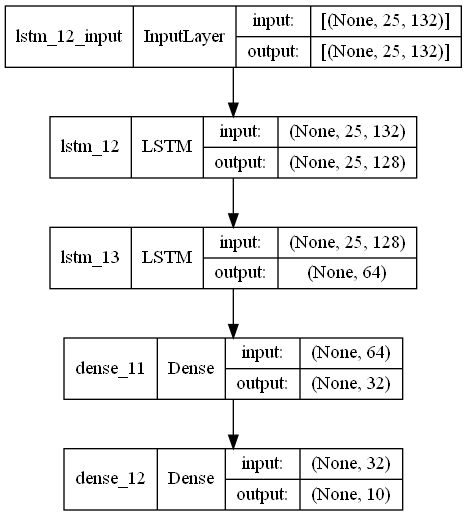

In [90]:
# Visualize
plot_model(lstm2_dense2_rd5_default, to_file = "arc_lstm2_dense2_rd5_default_1732_17032022.png", show_shapes = True)

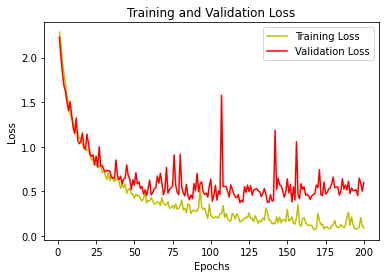

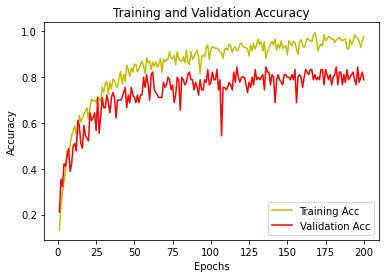

In [127]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [128]:
res = lstm2_dense2_rd5_default.predict(X_test)

In [129]:
yhat = lstm2_dense2_rd5_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [130]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[5 3 1 0 0 0 0 0 0 0]
 [3 4 0 0 2 0 0 0 0 0]
 [4 1 3 0 1 0 0 0 0 0]
 [0 0 0 7 0 0 0 1 1 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


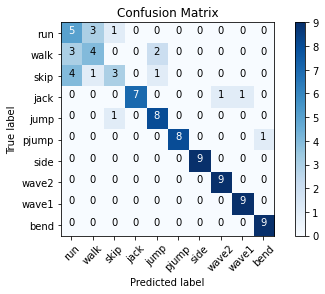

In [131]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [132]:
y_pred = lstm2_dense2_rd5_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [133]:
_, acc = lstm2_dense2_rd5_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 0.7052 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [134]:
accuracy_score(ytrue, yhat)

0.7888888888888889

In [135]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.42      0.56      0.48         9
        walk       0.50      0.44      0.47         9
        skip       0.60      0.33      0.43         9
        jack       1.00      0.78      0.88         9
        jump       0.73      0.89      0.80         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       0.90      1.00      0.95         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.79        90
   macro avg       0.79      0.79      0.78        90
weighted avg       0.79      0.79      0.78        90



# lstm2_dense2_rd05_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout=0.05 -> good too, need a bit more diversitiy test result

In [136]:
# Define a sequential model - another format
lstm2_dense2_rd05_default = Sequential([
    LSTM(128, recurrent_dropout=0.05, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.05, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [137]:
# Compile model with learning rate
lstm2_dense2_rd05_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [138]:
# Training model with validation
history = lstm2_dense2_rd05_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 16s - loss: 2.3097 - categorical_accuracy: 0.1037 - val_loss: 2.2625 - val_categorical_accuracy: 0.1778 - 16s/epoch - 238ms/step
Epoch 2/200
68/68 - 6s - loss: 2.1950 - categorical_accuracy: 0.1630 - val_loss: 2.1037 - val_categorical_accuracy: 0.1667 - 6s/epoch - 82ms/step
Epoch 3/200
68/68 - 6s - loss: 2.0165 - categorical_accuracy: 0.2444 - val_loss: 1.9467 - val_categorical_accuracy: 0.4000 - 6s/epoch - 88ms/step
Epoch 4/200
68/68 - 5s - loss: 1.8803 - categorical_accuracy: 0.3593 - val_loss: 1.8001 - val_categorical_accuracy: 0.4444 - 5s/epoch - 80ms/step
Epoch 5/200
68/68 - 5s - loss: 1.7332 - categorical_accuracy: 0.4037 - val_loss: 1.6484 - val_categorical_accuracy: 0.4889 - 5s/epoch - 75ms/step
Epoch 6/200
68/68 - 6s - loss: 1.6186 - categorical_accuracy: 0.4667 - val_loss: 1.5952 - val_categorical_accuracy: 0.4667 - 6s/epoch - 91ms/step
Epoch 7/200
68/68 - 6s - loss: 1.4945 - categorical_accuracy: 0.5222 - val_loss: 1.4981 - val_categorical_accuracy: 0.488

Epoch 57/200
68/68 - 5s - loss: 0.2315 - categorical_accuracy: 0.9259 - val_loss: 0.6333 - val_categorical_accuracy: 0.7444 - 5s/epoch - 78ms/step
Epoch 58/200
68/68 - 5s - loss: 0.2635 - categorical_accuracy: 0.9111 - val_loss: 0.7117 - val_categorical_accuracy: 0.7778 - 5s/epoch - 76ms/step
Epoch 59/200
68/68 - 5s - loss: 0.2360 - categorical_accuracy: 0.9111 - val_loss: 0.5811 - val_categorical_accuracy: 0.8111 - 5s/epoch - 75ms/step
Epoch 60/200
68/68 - 5s - loss: 0.4181 - categorical_accuracy: 0.8519 - val_loss: 0.6773 - val_categorical_accuracy: 0.7000 - 5s/epoch - 78ms/step
Epoch 61/200
68/68 - 5s - loss: 0.3015 - categorical_accuracy: 0.8778 - val_loss: 0.6111 - val_categorical_accuracy: 0.8000 - 5s/epoch - 74ms/step
Epoch 62/200
68/68 - 5s - loss: 0.2008 - categorical_accuracy: 0.9407 - val_loss: 0.5260 - val_categorical_accuracy: 0.8000 - 5s/epoch - 76ms/step
Epoch 63/200
68/68 - 5s - loss: 0.1861 - categorical_accuracy: 0.9444 - val_loss: 0.6347 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 5s - loss: 0.0988 - categorical_accuracy: 0.9667 - val_loss: 0.5818 - val_categorical_accuracy: 0.8111 - 5s/epoch - 76ms/step
Epoch 114/200
68/68 - 5s - loss: 0.0849 - categorical_accuracy: 0.9630 - val_loss: 0.5757 - val_categorical_accuracy: 0.7889 - 5s/epoch - 74ms/step
Epoch 115/200
68/68 - 5s - loss: 0.1540 - categorical_accuracy: 0.9593 - val_loss: 0.5855 - val_categorical_accuracy: 0.7333 - 5s/epoch - 77ms/step
Epoch 116/200
68/68 - 5s - loss: 0.2583 - categorical_accuracy: 0.9148 - val_loss: 0.8264 - val_categorical_accuracy: 0.7222 - 5s/epoch - 74ms/step
Epoch 117/200
68/68 - 5s - loss: 0.1616 - categorical_accuracy: 0.9481 - val_loss: 0.5419 - val_categorical_accuracy: 0.7778 - 5s/epoch - 78ms/step
Epoch 118/200
68/68 - 5s - loss: 0.0851 - categorical_accuracy: 0.9778 - val_loss: 0.5452 - val_categorical_accuracy: 0.7667 - 5s/epoch - 75ms/step
Epoch 119/200
68/68 - 5s - loss: 0.0708 - categorical_accuracy: 0.9815 - val_loss: 0.6574 - val_categorical_accu

Epoch 169/200
68/68 - 6s - loss: 0.0420 - categorical_accuracy: 0.9926 - val_loss: 0.7332 - val_categorical_accuracy: 0.7444 - 6s/epoch - 83ms/step
Epoch 170/200
68/68 - 6s - loss: 0.0626 - categorical_accuracy: 0.9852 - val_loss: 0.6328 - val_categorical_accuracy: 0.8111 - 6s/epoch - 83ms/step
Epoch 171/200
68/68 - 6s - loss: 0.0282 - categorical_accuracy: 1.0000 - val_loss: 0.5663 - val_categorical_accuracy: 0.8556 - 6s/epoch - 82ms/step
Epoch 172/200
68/68 - 6s - loss: 0.0414 - categorical_accuracy: 0.9852 - val_loss: 0.7639 - val_categorical_accuracy: 0.7333 - 6s/epoch - 82ms/step
Epoch 173/200
68/68 - 6s - loss: 0.0730 - categorical_accuracy: 0.9815 - val_loss: 0.6709 - val_categorical_accuracy: 0.7889 - 6s/epoch - 84ms/step
Epoch 174/200
68/68 - 5s - loss: 0.1527 - categorical_accuracy: 0.9407 - val_loss: 0.7957 - val_categorical_accuracy: 0.7333 - 5s/epoch - 76ms/step
Epoch 175/200
68/68 - 5s - loss: 0.1877 - categorical_accuracy: 0.9259 - val_loss: 0.6006 - val_categorical_accu

In [139]:
lstm2_dense2_rd05_default.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [140]:
# Save Model
lstm2_dense2_rd05_default.save("lstm2_dense2_rd05_default_1804_17032022.h5")

In [141]:
# Load Model
lstm2_dense2_rd05_default.load_weights("lstm2_dense2_rd05_default_1804_17032022.h5")

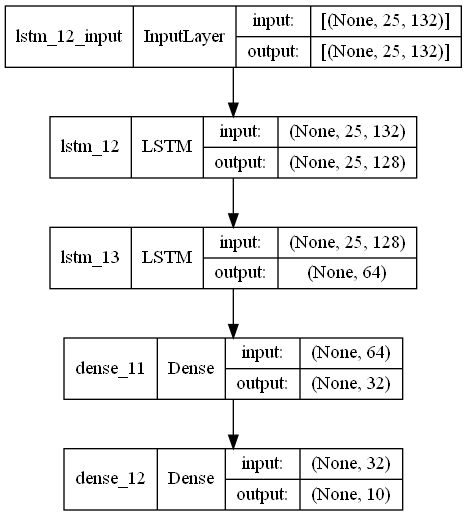

In [90]:
# Visualize
plot_model(lstm2_dense2_rd05_default, to_file = "arc_lstm2_dense2_rd05_default_1804_17032022.png", show_shapes = True)

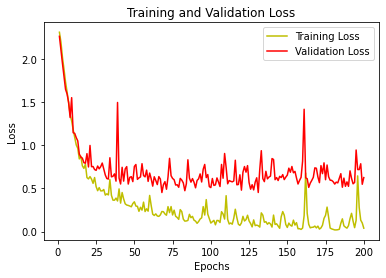

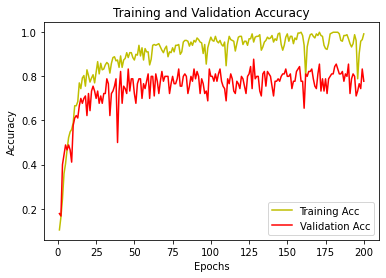

In [142]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [143]:
res = lstm2_dense2_rd05_default.predict(X_test)

In [144]:
yhat = lstm2_dense2_rd05_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [145]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 3 0 0 0 0 0 0 0]
 [4 5 0 0 0 0 0 0 0 0]
 [4 0 5 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


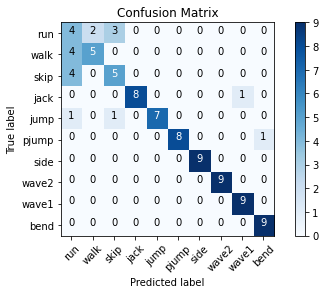

In [146]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [147]:
y_pred = lstm2_dense2_rd05_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [148]:
_, acc = lstm2_dense2_rd05_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 0.6101 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [149]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [150]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.31      0.44      0.36         9
        walk       0.71      0.56      0.63         9
        skip       0.56      0.56      0.56         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.78      0.88         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.81        90
   macro avg       0.84      0.81      0.82        90
weighted avg       0.84      0.81      0.82        90



# lstm2_dense2_rd1_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout=0.1 -> 188-190 maybe enough, bad

In [151]:
# Define a sequential model - another format
lstm2_dense2_rd1_default = Sequential([
    LSTM(128, recurrent_dropout=0.1, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.1, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [152]:
# Compile model with learning rate
lstm2_dense2_rd1_default.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [153]:
# Training model with validation
history = lstm2_dense2_rd1_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 16s - loss: 2.3047 - categorical_accuracy: 0.1333 - val_loss: 2.2653 - val_categorical_accuracy: 0.1889 - 16s/epoch - 233ms/step
Epoch 2/200
68/68 - 6s - loss: 2.2431 - categorical_accuracy: 0.1778 - val_loss: 2.2017 - val_categorical_accuracy: 0.2222 - 6s/epoch - 95ms/step
Epoch 3/200
68/68 - 6s - loss: 2.1388 - categorical_accuracy: 0.3037 - val_loss: 2.0470 - val_categorical_accuracy: 0.3333 - 6s/epoch - 84ms/step
Epoch 4/200
68/68 - 6s - loss: 1.9732 - categorical_accuracy: 0.3407 - val_loss: 1.8811 - val_categorical_accuracy: 0.3667 - 6s/epoch - 83ms/step
Epoch 5/200
68/68 - 5s - loss: 1.8121 - categorical_accuracy: 0.4000 - val_loss: 1.7939 - val_categorical_accuracy: 0.3222 - 5s/epoch - 80ms/step
Epoch 6/200
68/68 - 5s - loss: 1.6912 - categorical_accuracy: 0.4333 - val_loss: 1.8184 - val_categorical_accuracy: 0.3889 - 5s/epoch - 80ms/step
Epoch 7/200
68/68 - 6s - loss: 1.5699 - categorical_accuracy: 0.5074 - val_loss: 1.6216 - val_categorical_accuracy: 0.411

Epoch 57/200
68/68 - 5s - loss: 0.2791 - categorical_accuracy: 0.9000 - val_loss: 0.5493 - val_categorical_accuracy: 0.8000 - 5s/epoch - 80ms/step
Epoch 58/200
68/68 - 6s - loss: 0.2506 - categorical_accuracy: 0.9259 - val_loss: 0.4865 - val_categorical_accuracy: 0.7889 - 6s/epoch - 82ms/step
Epoch 59/200
68/68 - 5s - loss: 0.2406 - categorical_accuracy: 0.9222 - val_loss: 0.4924 - val_categorical_accuracy: 0.8111 - 5s/epoch - 80ms/step
Epoch 60/200
68/68 - 6s - loss: 0.2018 - categorical_accuracy: 0.9444 - val_loss: 0.5089 - val_categorical_accuracy: 0.8333 - 6s/epoch - 83ms/step
Epoch 61/200
68/68 - 6s - loss: 0.2198 - categorical_accuracy: 0.9222 - val_loss: 0.5556 - val_categorical_accuracy: 0.7667 - 6s/epoch - 81ms/step
Epoch 62/200
68/68 - 5s - loss: 0.2234 - categorical_accuracy: 0.9407 - val_loss: 0.4740 - val_categorical_accuracy: 0.7778 - 5s/epoch - 80ms/step
Epoch 63/200
68/68 - 6s - loss: 0.1999 - categorical_accuracy: 0.9370 - val_loss: 0.4288 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 6s - loss: 0.0777 - categorical_accuracy: 0.9815 - val_loss: 0.4510 - val_categorical_accuracy: 0.8000 - 6s/epoch - 84ms/step
Epoch 114/200
68/68 - 6s - loss: 0.0589 - categorical_accuracy: 0.9889 - val_loss: 0.4341 - val_categorical_accuracy: 0.8556 - 6s/epoch - 81ms/step
Epoch 115/200
68/68 - 6s - loss: 0.0734 - categorical_accuracy: 0.9741 - val_loss: 0.4938 - val_categorical_accuracy: 0.8556 - 6s/epoch - 81ms/step
Epoch 116/200
68/68 - 6s - loss: 0.1251 - categorical_accuracy: 0.9519 - val_loss: 0.4250 - val_categorical_accuracy: 0.8111 - 6s/epoch - 83ms/step
Epoch 117/200
68/68 - 6s - loss: 0.0731 - categorical_accuracy: 0.9815 - val_loss: 0.5909 - val_categorical_accuracy: 0.7667 - 6s/epoch - 89ms/step
Epoch 118/200
68/68 - 6s - loss: 0.1164 - categorical_accuracy: 0.9704 - val_loss: 0.4275 - val_categorical_accuracy: 0.8333 - 6s/epoch - 83ms/step
Epoch 119/200
68/68 - 6s - loss: 0.1914 - categorical_accuracy: 0.9407 - val_loss: 0.5221 - val_categorical_accu

Epoch 169/200
68/68 - 6s - loss: 0.0375 - categorical_accuracy: 0.9963 - val_loss: 0.5272 - val_categorical_accuracy: 0.8444 - 6s/epoch - 89ms/step
Epoch 170/200
68/68 - 6s - loss: 0.0744 - categorical_accuracy: 0.9778 - val_loss: 0.4321 - val_categorical_accuracy: 0.8444 - 6s/epoch - 84ms/step
Epoch 171/200
68/68 - 5s - loss: 0.0228 - categorical_accuracy: 1.0000 - val_loss: 0.4797 - val_categorical_accuracy: 0.8333 - 5s/epoch - 80ms/step
Epoch 172/200
68/68 - 5s - loss: 0.0227 - categorical_accuracy: 1.0000 - val_loss: 0.4483 - val_categorical_accuracy: 0.8556 - 5s/epoch - 80ms/step
Epoch 173/200
68/68 - 6s - loss: 0.1149 - categorical_accuracy: 0.9667 - val_loss: 0.6115 - val_categorical_accuracy: 0.7667 - 6s/epoch - 84ms/step
Epoch 174/200
68/68 - 6s - loss: 0.0773 - categorical_accuracy: 0.9852 - val_loss: 0.3782 - val_categorical_accuracy: 0.8667 - 6s/epoch - 82ms/step
Epoch 175/200
68/68 - 5s - loss: 0.0255 - categorical_accuracy: 1.0000 - val_loss: 0.4301 - val_categorical_accu

In [154]:
lstm2_dense2_rd1_default.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [155]:
# Save Model
lstm2_dense2_rd1_default.save("lstm2_dense2_rd1_default_1828_17032022.h5")

In [156]:
# Load Model
lstm2_dense2_rd1_default.load_weights("lstm2_dense2_rd1_default_1828_17032022.h5")

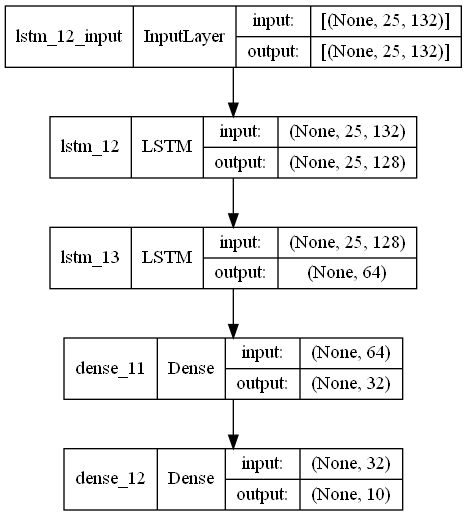

In [90]:
# Visualize
plot_model(lstm2_dense2_rd1_default, to_file = "arc_lstm2_dense2_rd1_default_1828_17032022.png", show_shapes = True)

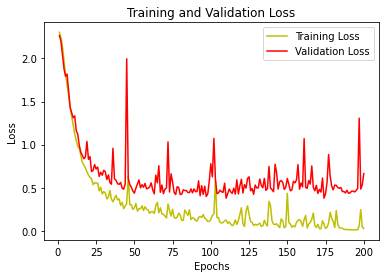

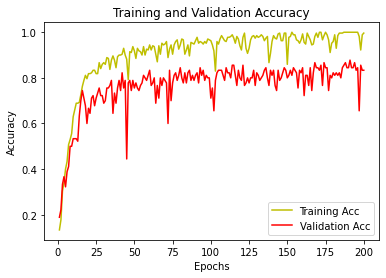

In [157]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [158]:
res = lstm2_dense2_rd1_default.predict(X_test)

In [159]:
yhat = lstm2_dense2_rd1_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [160]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[5 3 0 0 0 1 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [7 2 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 1 0 0 0 0]
 [2 1 0 0 5 1 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 1 0 0 0 8]]


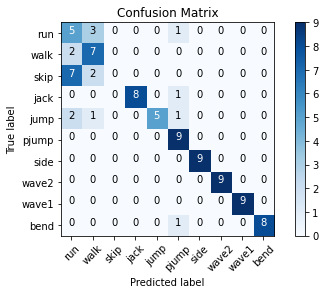

In [161]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [162]:
y_pred = lstm2_dense2_rd1_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [163]:
_, acc = lstm2_dense2_rd1_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 1.0580 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [164]:
accuracy_score(ytrue, yhat)

0.7666666666666667

In [165]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.31      0.56      0.40         9
        walk       0.54      0.78      0.64         9
        skip       0.00      0.00      0.00         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.56      0.71         9
       pjump       0.69      1.00      0.82         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      0.89      0.94         9

    accuracy                           0.77        90
   macro avg       0.75      0.77      0.75        90
weighted avg       0.75      0.77      0.75        90



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# lstm2_dense2_rd1_default_e190
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=190 + recurrent_dropout=0.1 -> bad, unexpected

In [166]:
# Define a sequential model - another format
lstm2_dense2_rd1_default_e190 = Sequential([
    LSTM(128, recurrent_dropout=0.1, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.1, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [167]:
# Compile model with learning rate
lstm2_dense2_rd1_default_e190.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [168]:
# Training model with validation
history = lstm2_dense2_rd1_default_e190.fit(X_train, y_train, batch_size=4, epochs=190, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/190
68/68 - 15s - loss: 2.3002 - categorical_accuracy: 0.1185 - val_loss: 2.2461 - val_categorical_accuracy: 0.2222 - 15s/epoch - 218ms/step
Epoch 2/190
68/68 - 5s - loss: 2.1760 - categorical_accuracy: 0.2778 - val_loss: 2.0946 - val_categorical_accuracy: 0.3222 - 5s/epoch - 74ms/step
Epoch 3/190
68/68 - 6s - loss: 2.0004 - categorical_accuracy: 0.2963 - val_loss: 1.9128 - val_categorical_accuracy: 0.4000 - 6s/epoch - 93ms/step
Epoch 4/190
68/68 - 6s - loss: 1.8718 - categorical_accuracy: 0.3815 - val_loss: 1.7771 - val_categorical_accuracy: 0.3889 - 6s/epoch - 84ms/step
Epoch 5/190
68/68 - 6s - loss: 1.7586 - categorical_accuracy: 0.3778 - val_loss: 1.7119 - val_categorical_accuracy: 0.4000 - 6s/epoch - 86ms/step
Epoch 6/190
68/68 - 6s - loss: 1.6481 - categorical_accuracy: 0.4741 - val_loss: 1.6513 - val_categorical_accuracy: 0.4333 - 6s/epoch - 87ms/step
Epoch 7/190
68/68 - 6s - loss: 1.5728 - categorical_accuracy: 0.4630 - val_loss: 1.5836 - val_categorical_accuracy: 0.444

Epoch 57/190
68/68 - 6s - loss: 0.2768 - categorical_accuracy: 0.9111 - val_loss: 0.4886 - val_categorical_accuracy: 0.7778 - 6s/epoch - 84ms/step
Epoch 58/190
68/68 - 6s - loss: 0.3154 - categorical_accuracy: 0.9000 - val_loss: 0.4957 - val_categorical_accuracy: 0.7778 - 6s/epoch - 84ms/step
Epoch 59/190
68/68 - 6s - loss: 0.2623 - categorical_accuracy: 0.9037 - val_loss: 0.4562 - val_categorical_accuracy: 0.8000 - 6s/epoch - 85ms/step
Epoch 60/190
68/68 - 6s - loss: 0.2752 - categorical_accuracy: 0.9037 - val_loss: 1.7603 - val_categorical_accuracy: 0.4889 - 6s/epoch - 82ms/step
Epoch 61/190
68/68 - 6s - loss: 0.6494 - categorical_accuracy: 0.7852 - val_loss: 0.4822 - val_categorical_accuracy: 0.7444 - 6s/epoch - 83ms/step
Epoch 62/190
68/68 - 5s - loss: 0.3282 - categorical_accuracy: 0.9000 - val_loss: 0.4866 - val_categorical_accuracy: 0.7444 - 5s/epoch - 79ms/step
Epoch 63/190
68/68 - 6s - loss: 0.2561 - categorical_accuracy: 0.9222 - val_loss: 0.4822 - val_categorical_accuracy: 0

Epoch 113/190
68/68 - 6s - loss: 0.0621 - categorical_accuracy: 0.9926 - val_loss: 0.4699 - val_categorical_accuracy: 0.8333 - 6s/epoch - 83ms/step
Epoch 114/190
68/68 - 6s - loss: 0.0811 - categorical_accuracy: 0.9815 - val_loss: 0.4560 - val_categorical_accuracy: 0.8444 - 6s/epoch - 83ms/step
Epoch 115/190
68/68 - 6s - loss: 0.1229 - categorical_accuracy: 0.9519 - val_loss: 0.4591 - val_categorical_accuracy: 0.8000 - 6s/epoch - 84ms/step
Epoch 116/190
68/68 - 5s - loss: 0.0694 - categorical_accuracy: 0.9815 - val_loss: 0.4886 - val_categorical_accuracy: 0.7889 - 5s/epoch - 80ms/step
Epoch 117/190
68/68 - 6s - loss: 0.0588 - categorical_accuracy: 0.9889 - val_loss: 0.4727 - val_categorical_accuracy: 0.8222 - 6s/epoch - 87ms/step
Epoch 118/190
68/68 - 6s - loss: 0.1741 - categorical_accuracy: 0.9593 - val_loss: 0.6222 - val_categorical_accuracy: 0.7778 - 6s/epoch - 87ms/step
Epoch 119/190
68/68 - 6s - loss: 0.0924 - categorical_accuracy: 0.9704 - val_loss: 0.5106 - val_categorical_accu

Epoch 169/190
68/68 - 6s - loss: 0.0348 - categorical_accuracy: 0.9963 - val_loss: 0.5547 - val_categorical_accuracy: 0.8333 - 6s/epoch - 81ms/step
Epoch 170/190
68/68 - 6s - loss: 0.0382 - categorical_accuracy: 0.9889 - val_loss: 0.6449 - val_categorical_accuracy: 0.7889 - 6s/epoch - 81ms/step
Epoch 171/190
68/68 - 6s - loss: 0.1486 - categorical_accuracy: 0.9519 - val_loss: 0.6864 - val_categorical_accuracy: 0.7778 - 6s/epoch - 83ms/step
Epoch 172/190
68/68 - 6s - loss: 0.1512 - categorical_accuracy: 0.9593 - val_loss: 0.5616 - val_categorical_accuracy: 0.8222 - 6s/epoch - 84ms/step
Epoch 173/190
68/68 - 6s - loss: 0.0484 - categorical_accuracy: 0.9889 - val_loss: 0.5355 - val_categorical_accuracy: 0.8111 - 6s/epoch - 82ms/step
Epoch 174/190
68/68 - 6s - loss: 0.0299 - categorical_accuracy: 0.9963 - val_loss: 0.5971 - val_categorical_accuracy: 0.7889 - 6s/epoch - 83ms/step
Epoch 175/190
68/68 - 6s - loss: 0.0248 - categorical_accuracy: 0.9963 - val_loss: 0.6260 - val_categorical_accu

In [169]:
lstm2_dense2_rd1_default_e190.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_25 (LSTM)              (None, 64)                49408     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [170]:
# Save Model
lstm2_dense2_rd1_default_e190.save("lstm2_dense2_rd1_default_e190_1859_17032022.h5")

In [171]:
# Load Model
lstm2_dense2_rd1_default_e190.load_weights("lstm2_dense2_rd1_default_e190_1859_17032022.h5")

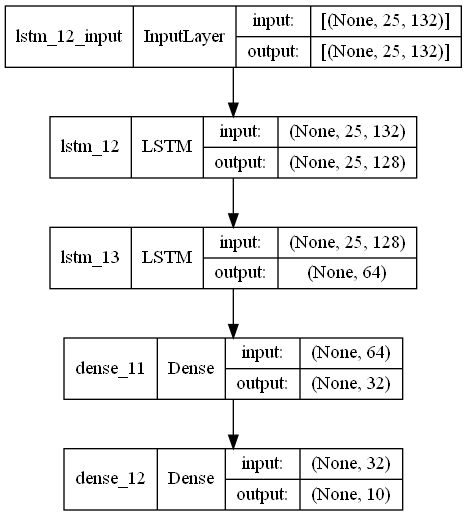

In [90]:
# Visualize
plot_model(lstm2_dense2_rd1_default_e190, to_file = "arc_lstm2_dense2_rd1_default_e190_1859_17032022.png", show_shapes = True)

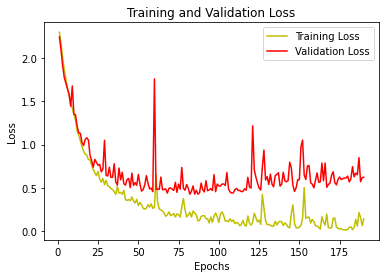

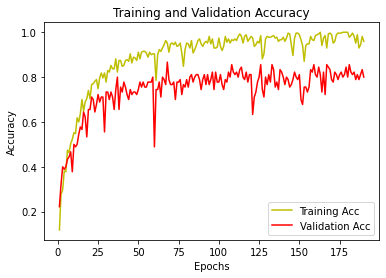

In [172]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [173]:
res = lstm2_dense2_rd1_default_e190.predict(X_test)

In [174]:
yhat = lstm2_dense2_rd1_default_e190.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [175]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[2 0 7 0 0 0 0 0 0 0]
 [2 4 1 0 1 0 1 0 0 0]
 [5 0 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 1 1 0 6 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [2 1 0 0 0 0 0 0 0 6]]


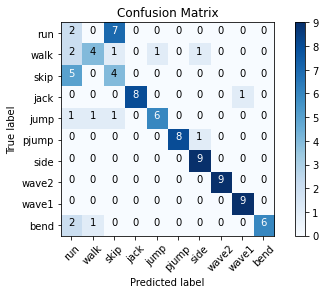

In [176]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [177]:
y_pred = lstm2_dense2_rd1_default_e190.predict(X_test)
y_pred = (y_pred > 0.5)

In [178]:
_, acc = lstm2_dense2_rd1_default_e190.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 0.9050 - categorical_accuracy: 0.7222
Accuracy =  72.22222089767456  %


In [179]:
accuracy_score(ytrue, yhat)

0.7222222222222222

In [180]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.17      0.22      0.19         9
        walk       0.67      0.44      0.53         9
        skip       0.31      0.44      0.36         9
        jack       1.00      0.89      0.94         9
        jump       0.86      0.67      0.75         9
       pjump       1.00      0.89      0.94         9
        side       0.82      1.00      0.90         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       1.00      0.67      0.80         9

    accuracy                           0.72        90
   macro avg       0.77      0.72      0.74        90
weighted avg       0.77      0.72      0.74        90



# lstm2_dense2_rd1_default_e190
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=190 + recurrent_dropout=0.1 -> bad, unexpected

In [166]:
# Define a sequential model - another format
lstm2_dense2_rd1_default_e190 = Sequential([
    LSTM(128, recurrent_dropout=0.1, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.1, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [167]:
# Compile model with learning rate
lstm2_dense2_rd1_default_e190.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [168]:
# Training model with validation
history = lstm2_dense2_rd1_default_e190.fit(X_train, y_train, batch_size=4, epochs=190, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/190
68/68 - 15s - loss: 2.3002 - categorical_accuracy: 0.1185 - val_loss: 2.2461 - val_categorical_accuracy: 0.2222 - 15s/epoch - 218ms/step
Epoch 2/190
68/68 - 5s - loss: 2.1760 - categorical_accuracy: 0.2778 - val_loss: 2.0946 - val_categorical_accuracy: 0.3222 - 5s/epoch - 74ms/step
Epoch 3/190
68/68 - 6s - loss: 2.0004 - categorical_accuracy: 0.2963 - val_loss: 1.9128 - val_categorical_accuracy: 0.4000 - 6s/epoch - 93ms/step
Epoch 4/190
68/68 - 6s - loss: 1.8718 - categorical_accuracy: 0.3815 - val_loss: 1.7771 - val_categorical_accuracy: 0.3889 - 6s/epoch - 84ms/step
Epoch 5/190
68/68 - 6s - loss: 1.7586 - categorical_accuracy: 0.3778 - val_loss: 1.7119 - val_categorical_accuracy: 0.4000 - 6s/epoch - 86ms/step
Epoch 6/190
68/68 - 6s - loss: 1.6481 - categorical_accuracy: 0.4741 - val_loss: 1.6513 - val_categorical_accuracy: 0.4333 - 6s/epoch - 87ms/step
Epoch 7/190
68/68 - 6s - loss: 1.5728 - categorical_accuracy: 0.4630 - val_loss: 1.5836 - val_categorical_accuracy: 0.444

Epoch 57/190
68/68 - 6s - loss: 0.2768 - categorical_accuracy: 0.9111 - val_loss: 0.4886 - val_categorical_accuracy: 0.7778 - 6s/epoch - 84ms/step
Epoch 58/190
68/68 - 6s - loss: 0.3154 - categorical_accuracy: 0.9000 - val_loss: 0.4957 - val_categorical_accuracy: 0.7778 - 6s/epoch - 84ms/step
Epoch 59/190
68/68 - 6s - loss: 0.2623 - categorical_accuracy: 0.9037 - val_loss: 0.4562 - val_categorical_accuracy: 0.8000 - 6s/epoch - 85ms/step
Epoch 60/190
68/68 - 6s - loss: 0.2752 - categorical_accuracy: 0.9037 - val_loss: 1.7603 - val_categorical_accuracy: 0.4889 - 6s/epoch - 82ms/step
Epoch 61/190
68/68 - 6s - loss: 0.6494 - categorical_accuracy: 0.7852 - val_loss: 0.4822 - val_categorical_accuracy: 0.7444 - 6s/epoch - 83ms/step
Epoch 62/190
68/68 - 5s - loss: 0.3282 - categorical_accuracy: 0.9000 - val_loss: 0.4866 - val_categorical_accuracy: 0.7444 - 5s/epoch - 79ms/step
Epoch 63/190
68/68 - 6s - loss: 0.2561 - categorical_accuracy: 0.9222 - val_loss: 0.4822 - val_categorical_accuracy: 0

Epoch 113/190
68/68 - 6s - loss: 0.0621 - categorical_accuracy: 0.9926 - val_loss: 0.4699 - val_categorical_accuracy: 0.8333 - 6s/epoch - 83ms/step
Epoch 114/190
68/68 - 6s - loss: 0.0811 - categorical_accuracy: 0.9815 - val_loss: 0.4560 - val_categorical_accuracy: 0.8444 - 6s/epoch - 83ms/step
Epoch 115/190
68/68 - 6s - loss: 0.1229 - categorical_accuracy: 0.9519 - val_loss: 0.4591 - val_categorical_accuracy: 0.8000 - 6s/epoch - 84ms/step
Epoch 116/190
68/68 - 5s - loss: 0.0694 - categorical_accuracy: 0.9815 - val_loss: 0.4886 - val_categorical_accuracy: 0.7889 - 5s/epoch - 80ms/step
Epoch 117/190
68/68 - 6s - loss: 0.0588 - categorical_accuracy: 0.9889 - val_loss: 0.4727 - val_categorical_accuracy: 0.8222 - 6s/epoch - 87ms/step
Epoch 118/190
68/68 - 6s - loss: 0.1741 - categorical_accuracy: 0.9593 - val_loss: 0.6222 - val_categorical_accuracy: 0.7778 - 6s/epoch - 87ms/step
Epoch 119/190
68/68 - 6s - loss: 0.0924 - categorical_accuracy: 0.9704 - val_loss: 0.5106 - val_categorical_accu

Epoch 169/190
68/68 - 6s - loss: 0.0348 - categorical_accuracy: 0.9963 - val_loss: 0.5547 - val_categorical_accuracy: 0.8333 - 6s/epoch - 81ms/step
Epoch 170/190
68/68 - 6s - loss: 0.0382 - categorical_accuracy: 0.9889 - val_loss: 0.6449 - val_categorical_accuracy: 0.7889 - 6s/epoch - 81ms/step
Epoch 171/190
68/68 - 6s - loss: 0.1486 - categorical_accuracy: 0.9519 - val_loss: 0.6864 - val_categorical_accuracy: 0.7778 - 6s/epoch - 83ms/step
Epoch 172/190
68/68 - 6s - loss: 0.1512 - categorical_accuracy: 0.9593 - val_loss: 0.5616 - val_categorical_accuracy: 0.8222 - 6s/epoch - 84ms/step
Epoch 173/190
68/68 - 6s - loss: 0.0484 - categorical_accuracy: 0.9889 - val_loss: 0.5355 - val_categorical_accuracy: 0.8111 - 6s/epoch - 82ms/step
Epoch 174/190
68/68 - 6s - loss: 0.0299 - categorical_accuracy: 0.9963 - val_loss: 0.5971 - val_categorical_accuracy: 0.7889 - 6s/epoch - 83ms/step
Epoch 175/190
68/68 - 6s - loss: 0.0248 - categorical_accuracy: 0.9963 - val_loss: 0.6260 - val_categorical_accu

In [169]:
lstm2_dense2_rd1_default_e190.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_25 (LSTM)              (None, 64)                49408     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [170]:
# Save Model
lstm2_dense2_rd1_default_e190.save("lstm2_dense2_rd1_default_e190_1859_17032022.h5")

In [171]:
# Load Model
lstm2_dense2_rd1_default_e190.load_weights("lstm2_dense2_rd1_default_e190_1859_17032022.h5")

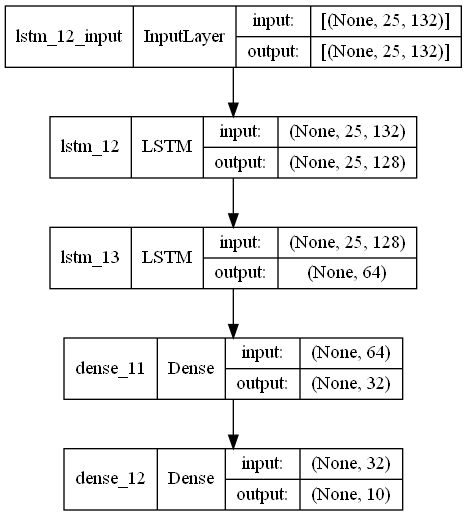

In [90]:
# Visualize
plot_model(lstm2_dense2_rd1_default_e190, to_file = "arc_lstm2_dense2_rd1_default_e190_1859_17032022.png", show_shapes = True)

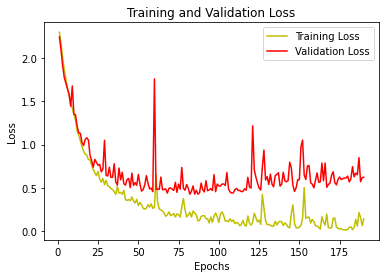

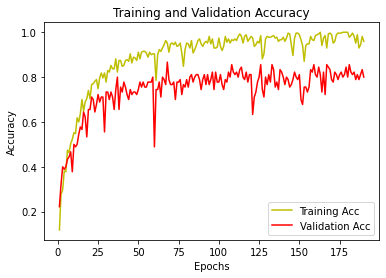

In [172]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [173]:
res = lstm2_dense2_rd1_default_e190.predict(X_test)

In [174]:
yhat = lstm2_dense2_rd1_default_e190.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [175]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[2 0 7 0 0 0 0 0 0 0]
 [2 4 1 0 1 0 1 0 0 0]
 [5 0 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 1 1 0 6 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [2 1 0 0 0 0 0 0 0 6]]


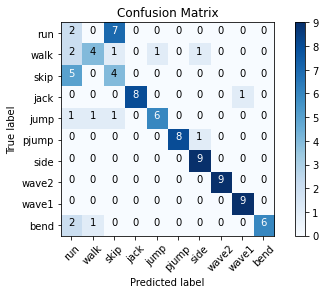

In [176]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [177]:
y_pred = lstm2_dense2_rd1_default_e190.predict(X_test)
y_pred = (y_pred > 0.5)

In [178]:
_, acc = lstm2_dense2_rd1_default_e190.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 0.9050 - categorical_accuracy: 0.7222
Accuracy =  72.22222089767456  %


In [179]:
accuracy_score(ytrue, yhat)

0.7222222222222222

In [180]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.17      0.22      0.19         9
        walk       0.67      0.44      0.53         9
        skip       0.31      0.44      0.36         9
        jack       1.00      0.89      0.94         9
        jump       0.86      0.67      0.75         9
       pjump       1.00      0.89      0.94         9
        side       0.82      1.00      0.90         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       1.00      0.67      0.80         9

    accuracy                           0.72        90
   macro avg       0.77      0.72      0.74        90
weighted avg       0.77      0.72      0.74        90



# lstm2_dense2_rd_lr_default
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=default -> 100% train, not good enough, a bit overfit

In [181]:
# Define a sequential model - another format
lstm2_dense2_rd_lr_default = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [182]:
# Compile model with learning rate
lstm2_dense2_rd_lr_default.compile(Nadam(learning_rate=0.001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [183]:
# Training model with validation
history = lstm2_dense2_rd_lr_default.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
68/68 - 18s - loss: 2.2321 - categorical_accuracy: 0.1407 - val_loss: 1.9884 - val_categorical_accuracy: 0.2556 - 18s/epoch - 265ms/step
Epoch 2/200
68/68 - 5s - loss: 2.1578 - categorical_accuracy: 0.1667 - val_loss: 2.2921 - val_categorical_accuracy: 0.1444 - 5s/epoch - 80ms/step
Epoch 3/200
68/68 - 6s - loss: 2.1337 - categorical_accuracy: 0.1815 - val_loss: 2.0279 - val_categorical_accuracy: 0.3000 - 6s/epoch - 83ms/step
Epoch 4/200
68/68 - 5s - loss: 1.9418 - categorical_accuracy: 0.2407 - val_loss: 1.6735 - val_categorical_accuracy: 0.3444 - 5s/epoch - 80ms/step
Epoch 5/200
68/68 - 5s - loss: 1.6656 - categorical_accuracy: 0.3519 - val_loss: 1.9321 - val_categorical_accuracy: 0.2889 - 5s/epoch - 80ms/step
Epoch 6/200
68/68 - 6s - loss: 1.6120 - categorical_accuracy: 0.3148 - val_loss: 1.7725 - val_categorical_accuracy: 0.3000 - 6s/epoch - 84ms/step
Epoch 7/200
68/68 - 6s - loss: 1.5505 - categorical_accuracy: 0.4148 - val_loss: 1.3841 - val_categorical_accuracy: 0.344

Epoch 57/200
68/68 - 5s - loss: 0.2741 - categorical_accuracy: 0.8963 - val_loss: 0.5818 - val_categorical_accuracy: 0.7889 - 5s/epoch - 80ms/step
Epoch 58/200
68/68 - 5s - loss: 0.3636 - categorical_accuracy: 0.8667 - val_loss: 0.5016 - val_categorical_accuracy: 0.8000 - 5s/epoch - 78ms/step
Epoch 59/200
68/68 - 5s - loss: 0.4135 - categorical_accuracy: 0.8148 - val_loss: 0.5621 - val_categorical_accuracy: 0.7556 - 5s/epoch - 80ms/step
Epoch 60/200
68/68 - 6s - loss: 0.3149 - categorical_accuracy: 0.8704 - val_loss: 0.6351 - val_categorical_accuracy: 0.8222 - 6s/epoch - 82ms/step
Epoch 61/200
68/68 - 6s - loss: 0.3520 - categorical_accuracy: 0.8778 - val_loss: 0.6194 - val_categorical_accuracy: 0.7667 - 6s/epoch - 82ms/step
Epoch 62/200
68/68 - 6s - loss: 0.2972 - categorical_accuracy: 0.8741 - val_loss: 0.4651 - val_categorical_accuracy: 0.7667 - 6s/epoch - 83ms/step
Epoch 63/200
68/68 - 5s - loss: 0.3408 - categorical_accuracy: 0.8778 - val_loss: 0.8381 - val_categorical_accuracy: 0

Epoch 113/200
68/68 - 5s - loss: 0.1997 - categorical_accuracy: 0.9407 - val_loss: 0.6968 - val_categorical_accuracy: 0.7778 - 5s/epoch - 80ms/step
Epoch 114/200
68/68 - 6s - loss: 0.0891 - categorical_accuracy: 0.9667 - val_loss: 0.3878 - val_categorical_accuracy: 0.8444 - 6s/epoch - 82ms/step
Epoch 115/200
68/68 - 6s - loss: 0.0916 - categorical_accuracy: 0.9630 - val_loss: 0.5907 - val_categorical_accuracy: 0.8222 - 6s/epoch - 85ms/step
Epoch 116/200
68/68 - 6s - loss: 0.2518 - categorical_accuracy: 0.9074 - val_loss: 0.5161 - val_categorical_accuracy: 0.8333 - 6s/epoch - 81ms/step
Epoch 117/200
68/68 - 6s - loss: 0.1243 - categorical_accuracy: 0.9481 - val_loss: 0.8512 - val_categorical_accuracy: 0.7889 - 6s/epoch - 81ms/step
Epoch 118/200
68/68 - 5s - loss: 0.1189 - categorical_accuracy: 0.9519 - val_loss: 0.5621 - val_categorical_accuracy: 0.8222 - 5s/epoch - 81ms/step
Epoch 119/200
68/68 - 5s - loss: 0.1280 - categorical_accuracy: 0.9593 - val_loss: 0.4223 - val_categorical_accu

Epoch 169/200
68/68 - 6s - loss: 0.0096 - categorical_accuracy: 1.0000 - val_loss: 0.3457 - val_categorical_accuracy: 0.8667 - 6s/epoch - 86ms/step
Epoch 170/200
68/68 - 5s - loss: 0.0048 - categorical_accuracy: 1.0000 - val_loss: 0.3705 - val_categorical_accuracy: 0.8778 - 5s/epoch - 79ms/step
Epoch 171/200
68/68 - 5s - loss: 0.0053 - categorical_accuracy: 1.0000 - val_loss: 0.3817 - val_categorical_accuracy: 0.8778 - 5s/epoch - 78ms/step
Epoch 172/200
68/68 - 5s - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 0.4071 - val_categorical_accuracy: 0.8778 - 5s/epoch - 78ms/step
Epoch 173/200
68/68 - 6s - loss: 0.0069 - categorical_accuracy: 1.0000 - val_loss: 0.4267 - val_categorical_accuracy: 0.8667 - 6s/epoch - 82ms/step
Epoch 174/200
68/68 - 5s - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.3884 - val_categorical_accuracy: 0.8556 - 5s/epoch - 78ms/step
Epoch 175/200
68/68 - 5s - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.3975 - val_categorical_accu

In [184]:
lstm2_dense2_rd_lr_default.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_27 (LSTM)              (None, 64)                49408     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [185]:
# Save Model
lstm2_dense2_rd_lr_default.save("lstm2_dense2_rd_lr_default_1932_17032022.h5")

In [186]:
# Load Model
lstm2_dense2_rd_lr_default.load_weights("lstm2_dense2_rd_lr_default_1932_17032022.h5")

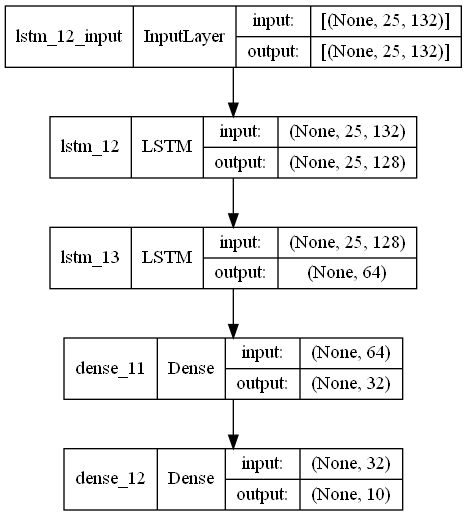

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr_default, to_file = "arc_lstm2_dense2_rd_lr_default_1932_17032022.png", show_shapes = True)

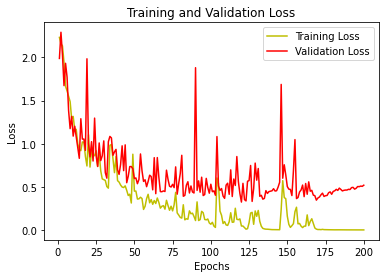

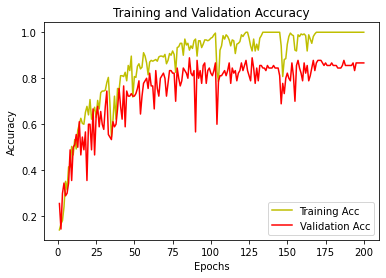

In [187]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [188]:
res = lstm2_dense2_rd_lr_default.predict(X_test)

In [189]:
yhat = lstm2_dense2_rd_lr_default.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [190]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[6 1 2 0 0 0 0 0 0 0]
 [2 5 0 0 0 1 1 0 0 0]
 [5 1 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 2 0 6 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


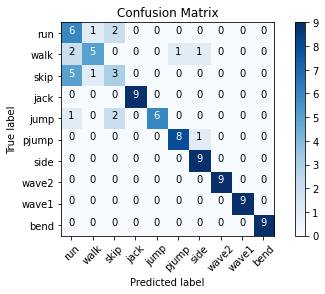

In [191]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [192]:
y_pred = lstm2_dense2_rd_lr_default.predict(X_test)
y_pred = (y_pred > 0.5)

In [193]:
_, acc = lstm2_dense2_rd_lr_default.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 0.8165 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [194]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [195]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.67      0.52         9
        walk       0.71      0.56      0.63         9
        skip       0.43      0.33      0.38         9
        jack       1.00      1.00      1.00         9
        jump       1.00      0.67      0.80         9
       pjump       0.89      0.89      0.89         9
        side       0.82      1.00      0.90         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.81        90
   macro avg       0.83      0.81      0.81        90
weighted avg       0.83      0.81      0.81        90



# lstm2_dense2_rd_lr_def_b8
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=default + batch=8 -> overfit, not good enough test

In [196]:
# Define a sequential model
lstm2_dense2_rd_lr_def_b8 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [197]:
# Compile model with learning rate
lstm2_dense2_rd_lr_def_b8.compile(Nadam(learning_rate=0.001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [198]:
# Training model with validation
history = lstm2_dense2_rd_lr_def_b8.fit(X_train, y_train, batch_size=8, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
34/34 - 13s - loss: 2.3129 - categorical_accuracy: 0.1000 - val_loss: 2.3583 - val_categorical_accuracy: 0.1111 - 13s/epoch - 381ms/step
Epoch 2/200
34/34 - 3s - loss: 2.2011 - categorical_accuracy: 0.1815 - val_loss: 2.2234 - val_categorical_accuracy: 0.1778 - 3s/epoch - 85ms/step
Epoch 3/200
34/34 - 3s - loss: 2.0867 - categorical_accuracy: 0.2370 - val_loss: 1.9126 - val_categorical_accuracy: 0.3111 - 3s/epoch - 96ms/step
Epoch 4/200
34/34 - 3s - loss: 2.1592 - categorical_accuracy: 0.2074 - val_loss: 2.1924 - val_categorical_accuracy: 0.1889 - 3s/epoch - 86ms/step
Epoch 5/200
34/34 - 3s - loss: 2.0419 - categorical_accuracy: 0.2259 - val_loss: 2.1657 - val_categorical_accuracy: 0.2333 - 3s/epoch - 85ms/step
Epoch 6/200
34/34 - 3s - loss: 1.8643 - categorical_accuracy: 0.3185 - val_loss: 1.8211 - val_categorical_accuracy: 0.3000 - 3s/epoch - 85ms/step
Epoch 7/200
34/34 - 3s - loss: 1.7815 - categorical_accuracy: 0.2778 - val_loss: 1.6444 - val_categorical_accuracy: 0.355

Epoch 57/200
34/34 - 3s - loss: 0.2490 - categorical_accuracy: 0.9037 - val_loss: 0.4443 - val_categorical_accuracy: 0.8222 - 3s/epoch - 86ms/step
Epoch 58/200
34/34 - 3s - loss: 0.2910 - categorical_accuracy: 0.8889 - val_loss: 1.5551 - val_categorical_accuracy: 0.5889 - 3s/epoch - 92ms/step
Epoch 59/200
34/34 - 3s - loss: 0.3699 - categorical_accuracy: 0.8741 - val_loss: 0.5240 - val_categorical_accuracy: 0.8222 - 3s/epoch - 92ms/step
Epoch 60/200
34/34 - 4s - loss: 0.2592 - categorical_accuracy: 0.9185 - val_loss: 0.5185 - val_categorical_accuracy: 0.8000 - 4s/epoch - 118ms/step
Epoch 61/200
34/34 - 4s - loss: 0.1924 - categorical_accuracy: 0.9148 - val_loss: 0.5945 - val_categorical_accuracy: 0.7667 - 4s/epoch - 121ms/step
Epoch 62/200
34/34 - 4s - loss: 0.2867 - categorical_accuracy: 0.8963 - val_loss: 0.4988 - val_categorical_accuracy: 0.8111 - 4s/epoch - 120ms/step
Epoch 63/200
34/34 - 4s - loss: 0.1541 - categorical_accuracy: 0.9593 - val_loss: 0.6863 - val_categorical_accuracy

Epoch 113/200
34/34 - 3s - loss: 0.0862 - categorical_accuracy: 0.9704 - val_loss: 0.6329 - val_categorical_accuracy: 0.8556 - 3s/epoch - 84ms/step
Epoch 114/200
34/34 - 3s - loss: 0.0364 - categorical_accuracy: 0.9889 - val_loss: 0.5933 - val_categorical_accuracy: 0.8444 - 3s/epoch - 86ms/step
Epoch 115/200
34/34 - 3s - loss: 0.0735 - categorical_accuracy: 0.9778 - val_loss: 0.7827 - val_categorical_accuracy: 0.7889 - 3s/epoch - 82ms/step
Epoch 116/200
34/34 - 3s - loss: 0.2006 - categorical_accuracy: 0.9296 - val_loss: 0.7284 - val_categorical_accuracy: 0.7889 - 3s/epoch - 95ms/step
Epoch 117/200
34/34 - 3s - loss: 0.2509 - categorical_accuracy: 0.9111 - val_loss: 0.7259 - val_categorical_accuracy: 0.7778 - 3s/epoch - 91ms/step
Epoch 118/200
34/34 - 3s - loss: 0.0879 - categorical_accuracy: 0.9667 - val_loss: 0.6376 - val_categorical_accuracy: 0.8333 - 3s/epoch - 84ms/step
Epoch 119/200
34/34 - 3s - loss: 0.0732 - categorical_accuracy: 0.9704 - val_loss: 0.5348 - val_categorical_accu

Epoch 169/200
34/34 - 3s - loss: 0.0090 - categorical_accuracy: 1.0000 - val_loss: 0.6544 - val_categorical_accuracy: 0.8333 - 3s/epoch - 98ms/step
Epoch 170/200
34/34 - 3s - loss: 0.0065 - categorical_accuracy: 1.0000 - val_loss: 0.6587 - val_categorical_accuracy: 0.8444 - 3s/epoch - 84ms/step
Epoch 171/200
34/34 - 3s - loss: 0.0060 - categorical_accuracy: 1.0000 - val_loss: 0.6436 - val_categorical_accuracy: 0.8556 - 3s/epoch - 83ms/step
Epoch 172/200
34/34 - 3s - loss: 0.0041 - categorical_accuracy: 1.0000 - val_loss: 0.6447 - val_categorical_accuracy: 0.8556 - 3s/epoch - 84ms/step
Epoch 173/200
34/34 - 3s - loss: 0.0041 - categorical_accuracy: 1.0000 - val_loss: 0.6695 - val_categorical_accuracy: 0.8556 - 3s/epoch - 96ms/step
Epoch 174/200
34/34 - 3s - loss: 0.0038 - categorical_accuracy: 1.0000 - val_loss: 0.6879 - val_categorical_accuracy: 0.8444 - 3s/epoch - 89ms/step
Epoch 175/200
34/34 - 4s - loss: 0.0033 - categorical_accuracy: 1.0000 - val_loss: 0.7046 - val_categorical_accu

In [199]:
lstm2_dense2_rd_lr_def_b8.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [200]:
# Save Model
lstm2_dense2_rd_lr_def_b8.save("lstm2_dense2_rd_lr_def_b8_2003_17032022.h5")

In [201]:
# Load Model
lstm2_dense2_rd_lr_def_b8.load_weights("lstm2_dense2_rd_lr_def_b8_2003_17032022.h5")

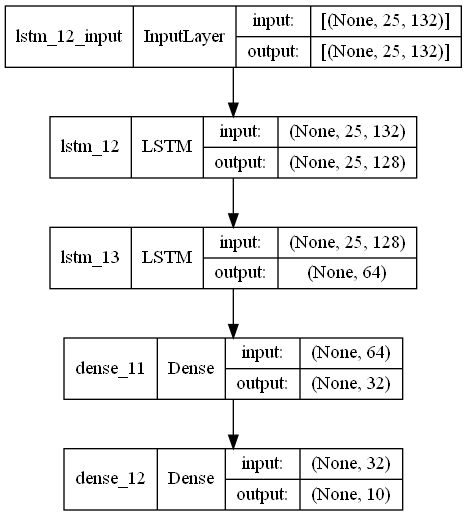

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr_def_b8, to_file = "arc_lstm2_dense2_rd_lr_def_b8_2003_17032022.png", show_shapes = True)

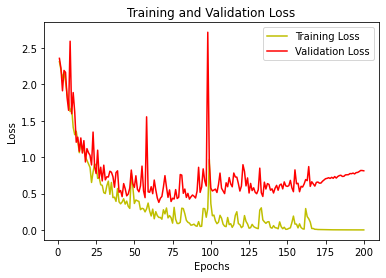

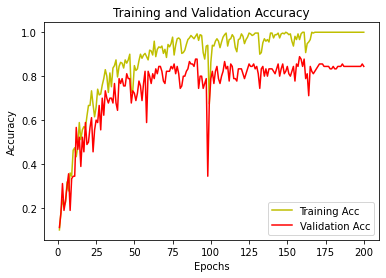

In [202]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [188]:
res = lstm2_dense2_rd_lr_def_b8.predict(X_test)

In [189]:
yhat = lstm2_dense2_rd_lr_def_b8.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [190]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[6 1 2 0 0 0 0 0 0 0]
 [2 5 0 0 0 1 1 0 0 0]
 [5 1 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 2 0 6 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


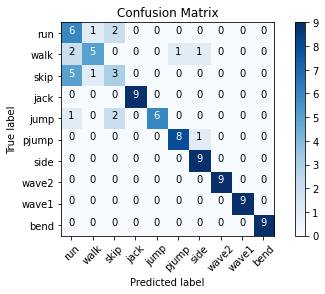

In [191]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [192]:
y_pred = lstm2_dense2_rd_lr_def_b8.predict(X_test)
y_pred = (y_pred > 0.5)

In [193]:
_, acc = lstm2_dense2_rd_lr_def_b8.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 0.8165 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [194]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [195]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.67      0.52         9
        walk       0.71      0.56      0.63         9
        skip       0.43      0.33      0.38         9
        jack       1.00      1.00      1.00         9
        jump       1.00      0.67      0.80         9
       pjump       0.89      0.89      0.89         9
        side       0.82      1.00      0.90         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.81        90
   macro avg       0.83      0.81      0.81        90
weighted avg       0.83      0.81      0.81        90



# lstm2_dense2_rd_lr4_def_b8
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.0001 + batch=8 -> good train, bad test

In [203]:
# Define a sequential model
lstm2_dense2_rd_lr4_def_b8 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [204]:
# Compile model with learning rate
lstm2_dense2_rd_lr4_def_b8.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [205]:
# Training model with validation
history = lstm2_dense2_rd_lr4_def_b8.fit(X_train, y_train, batch_size=8, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
34/34 - 15s - loss: 2.3158 - categorical_accuracy: 0.1407 - val_loss: 2.2692 - val_categorical_accuracy: 0.2556 - 15s/epoch - 446ms/step
Epoch 2/200
34/34 - 3s - loss: 2.2530 - categorical_accuracy: 0.2741 - val_loss: 2.2032 - val_categorical_accuracy: 0.3111 - 3s/epoch - 89ms/step
Epoch 3/200
34/34 - 3s - loss: 2.1529 - categorical_accuracy: 0.2963 - val_loss: 2.0647 - val_categorical_accuracy: 0.2556 - 3s/epoch - 94ms/step
Epoch 4/200
34/34 - 3s - loss: 1.9923 - categorical_accuracy: 0.2593 - val_loss: 1.8737 - val_categorical_accuracy: 0.2889 - 3s/epoch - 86ms/step
Epoch 5/200
34/34 - 3s - loss: 1.8063 - categorical_accuracy: 0.3074 - val_loss: 1.7343 - val_categorical_accuracy: 0.3444 - 3s/epoch - 84ms/step
Epoch 6/200
34/34 - 3s - loss: 1.6571 - categorical_accuracy: 0.3519 - val_loss: 1.5423 - val_categorical_accuracy: 0.4111 - 3s/epoch - 82ms/step
Epoch 7/200
34/34 - 3s - loss: 1.5534 - categorical_accuracy: 0.4148 - val_loss: 1.5141 - val_categorical_accuracy: 0.377

Epoch 57/200
34/34 - 3s - loss: 0.3789 - categorical_accuracy: 0.8926 - val_loss: 0.6819 - val_categorical_accuracy: 0.7111 - 3s/epoch - 90ms/step
Epoch 58/200
34/34 - 3s - loss: 0.3600 - categorical_accuracy: 0.9000 - val_loss: 0.6894 - val_categorical_accuracy: 0.7000 - 3s/epoch - 86ms/step
Epoch 59/200
34/34 - 3s - loss: 0.3856 - categorical_accuracy: 0.8741 - val_loss: 0.7538 - val_categorical_accuracy: 0.6889 - 3s/epoch - 90ms/step
Epoch 60/200
34/34 - 3s - loss: 0.3627 - categorical_accuracy: 0.8852 - val_loss: 0.6355 - val_categorical_accuracy: 0.7333 - 3s/epoch - 89ms/step
Epoch 61/200
34/34 - 3s - loss: 0.3896 - categorical_accuracy: 0.8593 - val_loss: 0.6398 - val_categorical_accuracy: 0.7333 - 3s/epoch - 88ms/step
Epoch 62/200
34/34 - 3s - loss: 0.3522 - categorical_accuracy: 0.9000 - val_loss: 0.6235 - val_categorical_accuracy: 0.7222 - 3s/epoch - 91ms/step
Epoch 63/200
34/34 - 3s - loss: 0.3623 - categorical_accuracy: 0.8852 - val_loss: 0.5858 - val_categorical_accuracy: 0

Epoch 113/200
34/34 - 3s - loss: 0.1733 - categorical_accuracy: 0.9593 - val_loss: 0.4961 - val_categorical_accuracy: 0.7444 - 3s/epoch - 86ms/step
Epoch 114/200
34/34 - 3s - loss: 0.1476 - categorical_accuracy: 0.9741 - val_loss: 0.4156 - val_categorical_accuracy: 0.8222 - 3s/epoch - 86ms/step
Epoch 115/200
34/34 - 3s - loss: 0.1379 - categorical_accuracy: 0.9630 - val_loss: 0.4908 - val_categorical_accuracy: 0.8000 - 3s/epoch - 95ms/step
Epoch 116/200
34/34 - 4s - loss: 0.1655 - categorical_accuracy: 0.9444 - val_loss: 0.4366 - val_categorical_accuracy: 0.8222 - 4s/epoch - 116ms/step
Epoch 117/200
34/34 - 4s - loss: 0.1244 - categorical_accuracy: 0.9741 - val_loss: 0.5308 - val_categorical_accuracy: 0.7778 - 4s/epoch - 123ms/step
Epoch 118/200
34/34 - 4s - loss: 0.1431 - categorical_accuracy: 0.9630 - val_loss: 0.4714 - val_categorical_accuracy: 0.8222 - 4s/epoch - 124ms/step
Epoch 119/200
34/34 - 4s - loss: 0.1698 - categorical_accuracy: 0.9593 - val_loss: 0.4755 - val_categorical_a

Epoch 169/200
34/34 - 3s - loss: 0.0855 - categorical_accuracy: 0.9852 - val_loss: 0.6755 - val_categorical_accuracy: 0.7889 - 3s/epoch - 93ms/step
Epoch 170/200
34/34 - 3s - loss: 0.1009 - categorical_accuracy: 0.9704 - val_loss: 0.7132 - val_categorical_accuracy: 0.7778 - 3s/epoch - 91ms/step
Epoch 171/200
34/34 - 3s - loss: 0.0612 - categorical_accuracy: 0.9889 - val_loss: 0.6212 - val_categorical_accuracy: 0.8222 - 3s/epoch - 89ms/step
Epoch 172/200
34/34 - 3s - loss: 0.1075 - categorical_accuracy: 0.9667 - val_loss: 0.5142 - val_categorical_accuracy: 0.8222 - 3s/epoch - 89ms/step
Epoch 173/200
34/34 - 3s - loss: 0.0970 - categorical_accuracy: 0.9741 - val_loss: 0.5877 - val_categorical_accuracy: 0.8000 - 3s/epoch - 91ms/step
Epoch 174/200
34/34 - 3s - loss: 0.0775 - categorical_accuracy: 0.9889 - val_loss: 0.4727 - val_categorical_accuracy: 0.8222 - 3s/epoch - 86ms/step
Epoch 175/200
34/34 - 3s - loss: 0.0954 - categorical_accuracy: 0.9852 - val_loss: 0.4943 - val_categorical_accu

In [206]:
lstm2_dense2_rd_lr4_def_b8.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_31 (LSTM)              (None, 64)                49408     
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Save Model
lstm2_dense2_rd_lr4_def_b8.save("lstm2_dense2_rd_lr4_def_b8_2027_17032022.h5")

In [208]:
# Load Model
lstm2_dense2_rd_lr4_def_b8.load_weights("lstm2_dense2_rd_lr4_def_b8_2027_17032022.h5")

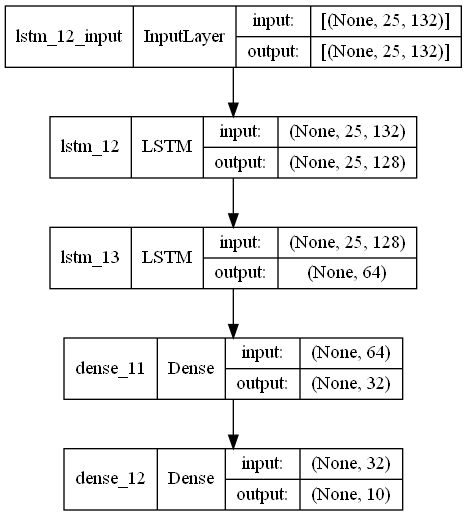

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr4_def_b8, to_file = "arc_lstm2_dense2_rd_lr4_def_b8_2027_17032022.png", show_shapes = True)

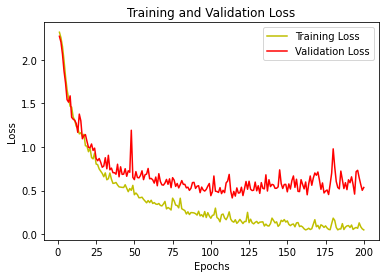

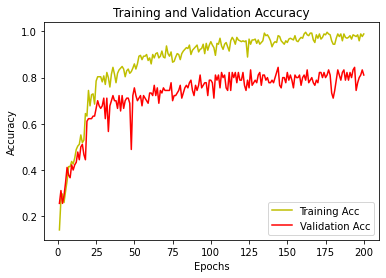

In [209]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [210]:
res = lstm2_dense2_rd_lr4_def_b8.predict(X_test)

In [211]:
yhat = lstm2_dense2_rd_lr4_def_b8.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [212]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[1 5 3 0 0 0 0 0 0 0]
 [3 5 0 0 0 0 0 0 0 1]
 [3 1 4 0 0 0 0 0 0 1]
 [0 0 0 8 0 0 0 0 1 0]
 [0 0 1 0 7 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 1 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


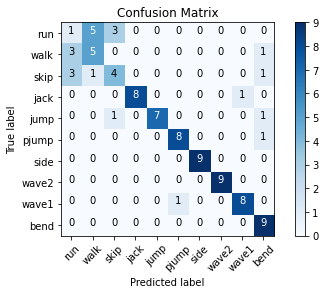

In [213]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [214]:
y_pred = lstm2_dense2_rd_lr4_def_b8.predict(X_test)
y_pred = (y_pred > 0.5)

In [215]:
_, acc = lstm2_dense2_rd_lr4_def_b8.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 20ms/step - loss: 0.7949 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [216]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [217]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.14      0.11      0.12         9
        walk       0.45      0.56      0.50         9
        skip       0.50      0.44      0.47         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.78      0.88         9
       pjump       0.89      0.89      0.89         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.69      1.00      0.82         9

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.75        90
weighted avg       0.76      0.76      0.75        90



# lstm2_dense2_rd_lr4_def_b1
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.0001 + batch=1 -> best_2, a bit worse diverse
#### Candidate

In [218]:
# Define a sequential model
lstm2_dense2_rd_lr4_def_b1 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [219]:
# Compile model with learning rate
lstm2_dense2_rd_lr4_def_b1.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [220]:
# Training model with validation
history = lstm2_dense2_rd_lr4_def_b1.fit(X_train, y_train, batch_size=1, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
270/270 - 25s - loss: 2.2788 - categorical_accuracy: 0.1259 - val_loss: 2.1779 - val_categorical_accuracy: 0.2333 - 25s/epoch - 91ms/step
Epoch 2/200
270/270 - 15s - loss: 2.0192 - categorical_accuracy: 0.2556 - val_loss: 1.8338 - val_categorical_accuracy: 0.3778 - 15s/epoch - 54ms/step
Epoch 3/200
270/270 - 16s - loss: 1.7243 - categorical_accuracy: 0.3444 - val_loss: 1.6670 - val_categorical_accuracy: 0.4000 - 16s/epoch - 61ms/step
Epoch 4/200
270/270 - 17s - loss: 1.5164 - categorical_accuracy: 0.4148 - val_loss: 1.5272 - val_categorical_accuracy: 0.4444 - 17s/epoch - 62ms/step
Epoch 5/200
270/270 - 19s - loss: 1.3905 - categorical_accuracy: 0.4889 - val_loss: 1.3236 - val_categorical_accuracy: 0.4556 - 19s/epoch - 72ms/step
Epoch 6/200
270/270 - 15s - loss: 1.2437 - categorical_accuracy: 0.5222 - val_loss: 1.1856 - val_categorical_accuracy: 0.5556 - 15s/epoch - 55ms/step
Epoch 7/200
270/270 - 14s - loss: 1.1619 - categorical_accuracy: 0.5481 - val_loss: 1.1664 - val_cat

Epoch 56/200
270/270 - 17s - loss: 0.3244 - categorical_accuracy: 0.8815 - val_loss: 0.9786 - val_categorical_accuracy: 0.6333 - 17s/epoch - 62ms/step
Epoch 57/200
270/270 - 16s - loss: 0.2243 - categorical_accuracy: 0.9296 - val_loss: 0.5623 - val_categorical_accuracy: 0.7889 - 16s/epoch - 60ms/step
Epoch 58/200
270/270 - 16s - loss: 0.3359 - categorical_accuracy: 0.8704 - val_loss: 0.6432 - val_categorical_accuracy: 0.7222 - 16s/epoch - 60ms/step
Epoch 59/200
270/270 - 17s - loss: 0.3592 - categorical_accuracy: 0.8667 - val_loss: 1.5852 - val_categorical_accuracy: 0.5444 - 17s/epoch - 62ms/step
Epoch 60/200
270/270 - 16s - loss: 0.4341 - categorical_accuracy: 0.8519 - val_loss: 0.8149 - val_categorical_accuracy: 0.6778 - 16s/epoch - 60ms/step
Epoch 61/200
270/270 - 16s - loss: 0.3039 - categorical_accuracy: 0.8852 - val_loss: 0.4805 - val_categorical_accuracy: 0.8111 - 16s/epoch - 61ms/step
Epoch 62/200
270/270 - 17s - loss: 0.2785 - categorical_accuracy: 0.8926 - val_loss: 0.5567 - 

Epoch 111/200
270/270 - 16s - loss: 0.2531 - categorical_accuracy: 0.9111 - val_loss: 0.4790 - val_categorical_accuracy: 0.8111 - 16s/epoch - 61ms/step
Epoch 112/200
270/270 - 17s - loss: 0.0925 - categorical_accuracy: 0.9815 - val_loss: 0.3896 - val_categorical_accuracy: 0.8444 - 17s/epoch - 63ms/step
Epoch 113/200
270/270 - 16s - loss: 0.0687 - categorical_accuracy: 0.9778 - val_loss: 0.4503 - val_categorical_accuracy: 0.8444 - 16s/epoch - 60ms/step
Epoch 114/200
270/270 - 17s - loss: 0.4858 - categorical_accuracy: 0.8481 - val_loss: 0.9339 - val_categorical_accuracy: 0.6556 - 17s/epoch - 62ms/step
Epoch 115/200
270/270 - 17s - loss: 0.2601 - categorical_accuracy: 0.9074 - val_loss: 0.4585 - val_categorical_accuracy: 0.8000 - 17s/epoch - 62ms/step
Epoch 116/200
270/270 - 17s - loss: 0.0820 - categorical_accuracy: 0.9778 - val_loss: 0.5170 - val_categorical_accuracy: 0.8111 - 17s/epoch - 62ms/step
Epoch 117/200
270/270 - 17s - loss: 0.1574 - categorical_accuracy: 0.9519 - val_loss: 0.

Epoch 165/200
270/270 - 16s - loss: 0.1602 - categorical_accuracy: 0.9444 - val_loss: 0.6745 - val_categorical_accuracy: 0.8000 - 16s/epoch - 60ms/step
Epoch 166/200
270/270 - 17s - loss: 0.0604 - categorical_accuracy: 0.9778 - val_loss: 0.6208 - val_categorical_accuracy: 0.8333 - 17s/epoch - 63ms/step
Epoch 167/200
270/270 - 16s - loss: 0.1040 - categorical_accuracy: 0.9593 - val_loss: 0.6484 - val_categorical_accuracy: 0.8333 - 16s/epoch - 59ms/step
Epoch 168/200
270/270 - 16s - loss: 0.0575 - categorical_accuracy: 0.9889 - val_loss: 0.5381 - val_categorical_accuracy: 0.8333 - 16s/epoch - 61ms/step
Epoch 169/200
270/270 - 16s - loss: 0.0390 - categorical_accuracy: 0.9926 - val_loss: 0.5838 - val_categorical_accuracy: 0.7667 - 16s/epoch - 60ms/step
Epoch 170/200
270/270 - 16s - loss: 0.0653 - categorical_accuracy: 0.9852 - val_loss: 0.5618 - val_categorical_accuracy: 0.8333 - 16s/epoch - 61ms/step
Epoch 171/200
270/270 - 17s - loss: 0.2712 - categorical_accuracy: 0.8926 - val_loss: 0.

In [221]:
lstm2_dense2_rd_lr4_def_b1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_33 (LSTM)              (None, 64)                49408     
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [222]:
# Save Model
lstm2_dense2_rd_lr4_def_b1.save("lstm2_dense2_rd_lr4_def_b1_2049_17032022.h5")

In [223]:
# Load Model
lstm2_dense2_rd_lr4_def_b1.load_weights("lstm2_dense2_rd_lr4_def_b1_2049_17032022.h5")

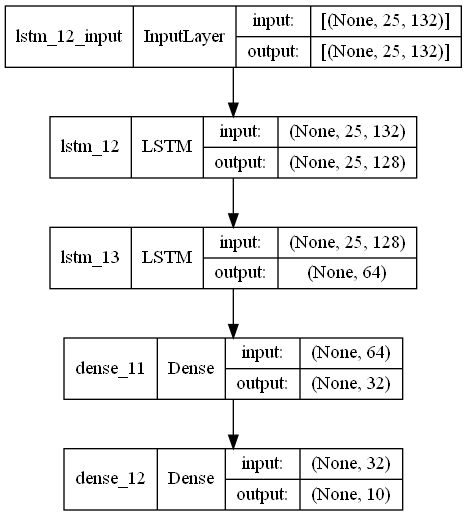

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr4_def_b1, to_file = "arc_lstm2_dense2_rd_lr4_def_b1_2049_17032022.png", show_shapes = True)

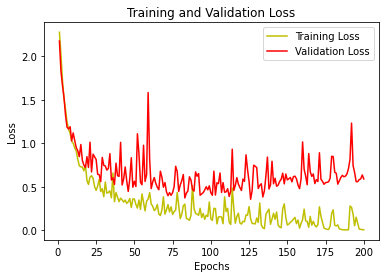

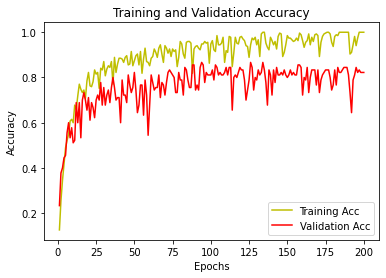

In [224]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [225]:
res = lstm2_dense2_rd_lr4_def_b1.predict(X_test)

In [226]:
yhat = lstm2_dense2_rd_lr4_def_b1.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [227]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[6 1 1 0 1 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [3 2 3 0 1 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


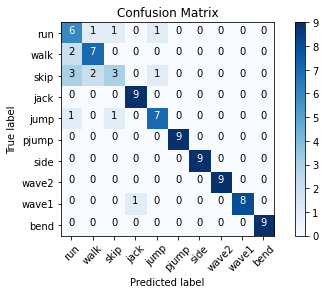

In [228]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [229]:
y_pred = lstm2_dense2_rd_lr4_def_b1.predict(X_test)
y_pred = (y_pred > 0.5)

In [230]:
_, acc = lstm2_dense2_rd_lr4_def_b1.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 25ms/step - loss: 0.6119 - categorical_accuracy: 0.8444
Accuracy =  84.44444537162781  %


In [231]:
accuracy_score(ytrue, yhat)

0.8444444444444444

In [217]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.14      0.11      0.12         9
        walk       0.45      0.56      0.50         9
        skip       0.50      0.44      0.47         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.78      0.88         9
       pjump       0.89      0.89      0.89         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.69      1.00      0.82         9

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.75        90
weighted avg       0.76      0.76      0.75        90



# lstm2_dense2_rd_lr5_def_b1_e300
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=300 + recurrent_dropout=0.2 + lr=0.00001 + batch=1 -> good curves, god train, not too good test

In [262]:
# Define a sequential model
lstm2_dense2_rd_lr5_def_b1_e300 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [263]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_def_b1_e300.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [264]:
# Training model with validation
history = lstm2_dense2_rd_lr5_def_b1_e300.fit(X_train, y_train, batch_size=1, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
270/270 - 20s - loss: 2.3219 - categorical_accuracy: 0.0926 - val_loss: 2.2814 - val_categorical_accuracy: 0.1222 - 20s/epoch - 74ms/step
Epoch 2/300
270/270 - 14s - loss: 2.2743 - categorical_accuracy: 0.1333 - val_loss: 2.2468 - val_categorical_accuracy: 0.1889 - 14s/epoch - 53ms/step
Epoch 3/300
270/270 - 14s - loss: 2.2439 - categorical_accuracy: 0.2000 - val_loss: 2.2089 - val_categorical_accuracy: 0.2667 - 14s/epoch - 51ms/step
Epoch 4/300
270/270 - 14s - loss: 2.1994 - categorical_accuracy: 0.2704 - val_loss: 2.1622 - val_categorical_accuracy: 0.3000 - 14s/epoch - 51ms/step
Epoch 5/300
270/270 - 14s - loss: 2.1442 - categorical_accuracy: 0.2963 - val_loss: 2.1075 - val_categorical_accuracy: 0.3556 - 14s/epoch - 51ms/step
Epoch 6/300
270/270 - 14s - loss: 2.0897 - categorical_accuracy: 0.3185 - val_loss: 2.0422 - val_categorical_accuracy: 0.3333 - 14s/epoch - 53ms/step
Epoch 7/300
270/270 - 14s - loss: 2.0241 - categorical_accuracy: 0.3259 - val_loss: 1.9801 - val_cat

Epoch 56/300
270/270 - 14s - loss: 0.7867 - categorical_accuracy: 0.7889 - val_loss: 0.8941 - val_categorical_accuracy: 0.6667 - 14s/epoch - 52ms/step
Epoch 57/300
270/270 - 14s - loss: 0.7892 - categorical_accuracy: 0.7704 - val_loss: 0.8727 - val_categorical_accuracy: 0.6667 - 14s/epoch - 52ms/step
Epoch 58/300
270/270 - 14s - loss: 0.7661 - categorical_accuracy: 0.7741 - val_loss: 0.8772 - val_categorical_accuracy: 0.6444 - 14s/epoch - 51ms/step
Epoch 59/300
270/270 - 14s - loss: 0.7798 - categorical_accuracy: 0.7333 - val_loss: 0.8571 - val_categorical_accuracy: 0.7111 - 14s/epoch - 52ms/step
Epoch 60/300
270/270 - 14s - loss: 0.7497 - categorical_accuracy: 0.7889 - val_loss: 0.8722 - val_categorical_accuracy: 0.6889 - 14s/epoch - 52ms/step
Epoch 61/300
270/270 - 14s - loss: 0.7392 - categorical_accuracy: 0.7852 - val_loss: 0.8397 - val_categorical_accuracy: 0.7111 - 14s/epoch - 52ms/step
Epoch 62/300
270/270 - 16s - loss: 0.7159 - categorical_accuracy: 0.7852 - val_loss: 0.8435 - 

Epoch 111/300
270/270 - 15s - loss: 0.4698 - categorical_accuracy: 0.8704 - val_loss: 0.6016 - val_categorical_accuracy: 0.7444 - 15s/epoch - 55ms/step
Epoch 112/300
270/270 - 15s - loss: 0.4447 - categorical_accuracy: 0.8556 - val_loss: 0.6141 - val_categorical_accuracy: 0.7444 - 15s/epoch - 56ms/step
Epoch 113/300
270/270 - 15s - loss: 0.4536 - categorical_accuracy: 0.8481 - val_loss: 0.6137 - val_categorical_accuracy: 0.7333 - 15s/epoch - 55ms/step
Epoch 114/300
270/270 - 15s - loss: 0.4547 - categorical_accuracy: 0.8519 - val_loss: 0.6241 - val_categorical_accuracy: 0.7222 - 15s/epoch - 55ms/step
Epoch 115/300
270/270 - 15s - loss: 0.4387 - categorical_accuracy: 0.8741 - val_loss: 0.6303 - val_categorical_accuracy: 0.7444 - 15s/epoch - 56ms/step
Epoch 116/300
270/270 - 15s - loss: 0.4464 - categorical_accuracy: 0.8296 - val_loss: 0.6085 - val_categorical_accuracy: 0.7556 - 15s/epoch - 57ms/step
Epoch 117/300
270/270 - 15s - loss: 0.4380 - categorical_accuracy: 0.8556 - val_loss: 0.

Epoch 165/300
270/270 - 16s - loss: 0.3253 - categorical_accuracy: 0.9185 - val_loss: 0.5720 - val_categorical_accuracy: 0.7556 - 16s/epoch - 58ms/step
Epoch 166/300
270/270 - 15s - loss: 0.2860 - categorical_accuracy: 0.9259 - val_loss: 0.5363 - val_categorical_accuracy: 0.7667 - 15s/epoch - 56ms/step
Epoch 167/300
270/270 - 15s - loss: 0.2866 - categorical_accuracy: 0.9222 - val_loss: 0.5070 - val_categorical_accuracy: 0.7556 - 15s/epoch - 57ms/step
Epoch 168/300
270/270 - 15s - loss: 0.2844 - categorical_accuracy: 0.9185 - val_loss: 0.5049 - val_categorical_accuracy: 0.7667 - 15s/epoch - 56ms/step
Epoch 169/300
270/270 - 16s - loss: 0.2840 - categorical_accuracy: 0.9333 - val_loss: 0.4939 - val_categorical_accuracy: 0.7778 - 16s/epoch - 57ms/step
Epoch 170/300
270/270 - 15s - loss: 0.2896 - categorical_accuracy: 0.9333 - val_loss: 0.5245 - val_categorical_accuracy: 0.8111 - 15s/epoch - 56ms/step
Epoch 171/300
270/270 - 15s - loss: 0.3082 - categorical_accuracy: 0.9037 - val_loss: 0.

Epoch 219/300
270/270 - 16s - loss: 0.2160 - categorical_accuracy: 0.9519 - val_loss: 0.4619 - val_categorical_accuracy: 0.8111 - 16s/epoch - 61ms/step
Epoch 220/300
270/270 - 16s - loss: 0.1988 - categorical_accuracy: 0.9481 - val_loss: 0.5233 - val_categorical_accuracy: 0.7556 - 16s/epoch - 61ms/step
Epoch 221/300
270/270 - 17s - loss: 0.2348 - categorical_accuracy: 0.9296 - val_loss: 0.6139 - val_categorical_accuracy: 0.7222 - 17s/epoch - 62ms/step
Epoch 222/300
270/270 - 16s - loss: 0.2271 - categorical_accuracy: 0.9259 - val_loss: 0.4927 - val_categorical_accuracy: 0.7667 - 16s/epoch - 61ms/step
Epoch 223/300
270/270 - 16s - loss: 0.2205 - categorical_accuracy: 0.9370 - val_loss: 0.5714 - val_categorical_accuracy: 0.7222 - 16s/epoch - 60ms/step
Epoch 224/300
270/270 - 16s - loss: 0.2000 - categorical_accuracy: 0.9481 - val_loss: 0.4418 - val_categorical_accuracy: 0.8000 - 16s/epoch - 61ms/step
Epoch 225/300
270/270 - 17s - loss: 0.2044 - categorical_accuracy: 0.9481 - val_loss: 0.

Epoch 273/300
270/270 - 14s - loss: 0.1664 - categorical_accuracy: 0.9444 - val_loss: 0.4612 - val_categorical_accuracy: 0.8222 - 14s/epoch - 51ms/step
Epoch 274/300
270/270 - 14s - loss: 0.1553 - categorical_accuracy: 0.9556 - val_loss: 0.4456 - val_categorical_accuracy: 0.8000 - 14s/epoch - 52ms/step
Epoch 275/300
270/270 - 14s - loss: 0.1205 - categorical_accuracy: 0.9741 - val_loss: 0.4792 - val_categorical_accuracy: 0.7889 - 14s/epoch - 51ms/step
Epoch 276/300
270/270 - 14s - loss: 0.1746 - categorical_accuracy: 0.9370 - val_loss: 0.5195 - val_categorical_accuracy: 0.8111 - 14s/epoch - 51ms/step
Epoch 277/300
270/270 - 14s - loss: 0.1542 - categorical_accuracy: 0.9519 - val_loss: 0.4784 - val_categorical_accuracy: 0.8222 - 14s/epoch - 51ms/step
Epoch 278/300
270/270 - 14s - loss: 0.1309 - categorical_accuracy: 0.9741 - val_loss: 0.4418 - val_categorical_accuracy: 0.8000 - 14s/epoch - 52ms/step
Epoch 279/300
270/270 - 14s - loss: 0.1415 - categorical_accuracy: 0.9704 - val_loss: 0.

In [265]:
lstm2_dense2_rd_lr5_def_b1_e300.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_39 (LSTM)              (None, 64)                49408     
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [266]:
# Save Model
lstm2_dense2_rd_lr5_def_b1_e300.save("lstm2_dense2_rd_lr5_def_b1_e300_0000_18032022.h5")

In [270]:
# Load Model
lstm2_dense2_rd_lr5_def_b1_e300.load_weights("lstm2_dense2_rd_lr5_def_b1_e300_0000_18032022.h5")

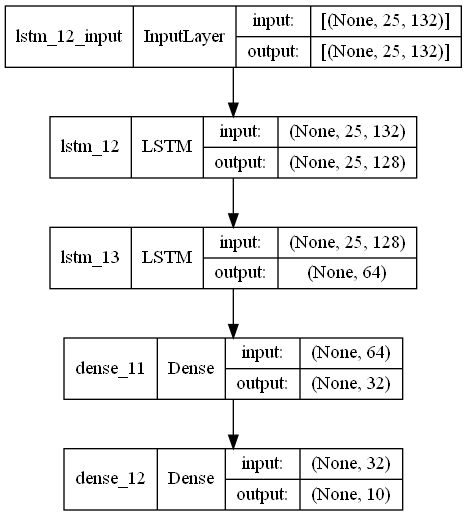

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_def_b1_e300, to_file = "arc_lstm2_dense2_rd_lr5_def_b1_e300_0000_18032022.png", show_shapes = True)

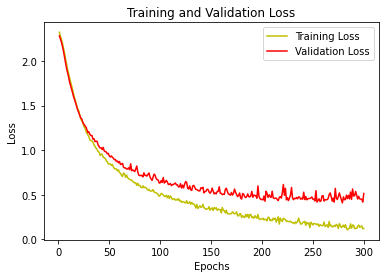

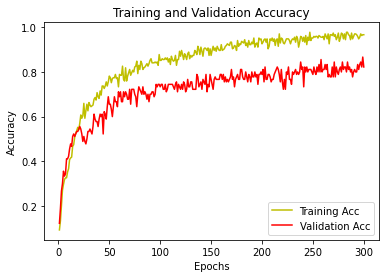

In [271]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [272]:
res = lstm2_dense2_rd_lr5_def_b1_e300.predict(X_test)

In [273]:
yhat = lstm2_dense2_rd_lr5_def_b1_e300.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [274]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 4 2 0 0 0 0 0 0 0]
 [1 5 1 0 2 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [0 0 1 0 7 0 1 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


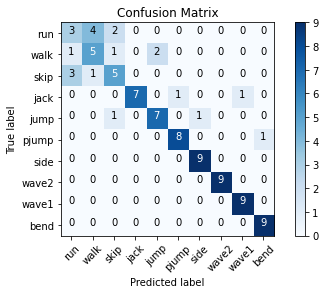

In [275]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [276]:
y_pred = lstm2_dense2_rd_lr5_def_b1_e300.predict(X_test)
y_pred = (y_pred > 0.5)

In [277]:
_, acc = lstm2_dense2_rd_lr5_def_b1_e300.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 23ms/step - loss: 0.6345 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [278]:
accuracy_score(ytrue, yhat)

0.7888888888888889

In [279]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.33      0.38         9
        walk       0.50      0.56      0.53         9
        skip       0.56      0.56      0.56         9
        jack       1.00      0.78      0.88         9
        jump       0.78      0.78      0.78         9
       pjump       0.89      0.89      0.89         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.79        90
   macro avg       0.79      0.79      0.78        90
weighted avg       0.79      0.79      0.78        90



# lstm2_dense2_rd_lr5_def_b1_e350
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=350 + recurrent_dropout=0.2 + lr=0.00001 + batch=1 -> good training, not too good test

In [280]:
# Define a sequential model
lstm2_dense2_rd_lr5_def_b1_e350 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [281]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_def_b1_e350.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [282]:
# Training model with validation
history = lstm2_dense2_rd_lr5_def_b1_e350.fit(X_train, y_train, batch_size=1, epochs=350, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/350
270/270 - 23s - loss: 2.3041 - categorical_accuracy: 0.1556 - val_loss: 2.2964 - val_categorical_accuracy: 0.1333 - 23s/epoch - 85ms/step
Epoch 2/350
270/270 - 20s - loss: 2.2905 - categorical_accuracy: 0.1481 - val_loss: 2.2870 - val_categorical_accuracy: 0.1444 - 20s/epoch - 74ms/step
Epoch 3/350
270/270 - 18s - loss: 2.2787 - categorical_accuracy: 0.1889 - val_loss: 2.2731 - val_categorical_accuracy: 0.1333 - 18s/epoch - 68ms/step
Epoch 4/350
270/270 - 17s - loss: 2.2641 - categorical_accuracy: 0.1704 - val_loss: 2.2558 - val_categorical_accuracy: 0.1333 - 17s/epoch - 61ms/step
Epoch 5/350
270/270 - 18s - loss: 2.2433 - categorical_accuracy: 0.1852 - val_loss: 2.2356 - val_categorical_accuracy: 0.1333 - 18s/epoch - 65ms/step
Epoch 6/350
270/270 - 16s - loss: 2.2165 - categorical_accuracy: 0.2148 - val_loss: 2.2104 - val_categorical_accuracy: 0.2222 - 16s/epoch - 60ms/step
Epoch 7/350
270/270 - 16s - loss: 2.1854 - categorical_accuracy: 0.2630 - val_loss: 2.1797 - val_cat

Epoch 56/350
270/270 - 17s - loss: 0.9583 - categorical_accuracy: 0.7556 - val_loss: 1.0110 - val_categorical_accuracy: 0.6889 - 17s/epoch - 62ms/step
Epoch 57/350
270/270 - 16s - loss: 0.9465 - categorical_accuracy: 0.7259 - val_loss: 1.0231 - val_categorical_accuracy: 0.6222 - 16s/epoch - 60ms/step
Epoch 58/350
270/270 - 16s - loss: 0.9455 - categorical_accuracy: 0.7593 - val_loss: 0.9774 - val_categorical_accuracy: 0.7000 - 16s/epoch - 59ms/step
Epoch 59/350
270/270 - 16s - loss: 0.9520 - categorical_accuracy: 0.7333 - val_loss: 0.9612 - val_categorical_accuracy: 0.7111 - 16s/epoch - 58ms/step
Epoch 60/350
270/270 - 16s - loss: 0.9634 - categorical_accuracy: 0.7074 - val_loss: 0.9429 - val_categorical_accuracy: 0.7222 - 16s/epoch - 60ms/step
Epoch 61/350
270/270 - 16s - loss: 0.9286 - categorical_accuracy: 0.7444 - val_loss: 0.9399 - val_categorical_accuracy: 0.7111 - 16s/epoch - 61ms/step
Epoch 62/350
270/270 - 16s - loss: 0.8956 - categorical_accuracy: 0.7519 - val_loss: 0.9290 - 

Epoch 111/350
270/270 - 15s - loss: 0.4994 - categorical_accuracy: 0.8852 - val_loss: 0.6915 - val_categorical_accuracy: 0.7333 - 15s/epoch - 56ms/step
Epoch 112/350
270/270 - 15s - loss: 0.5290 - categorical_accuracy: 0.8593 - val_loss: 0.6764 - val_categorical_accuracy: 0.7111 - 15s/epoch - 55ms/step
Epoch 113/350
270/270 - 15s - loss: 0.5161 - categorical_accuracy: 0.8556 - val_loss: 0.6649 - val_categorical_accuracy: 0.7333 - 15s/epoch - 56ms/step
Epoch 114/350
270/270 - 15s - loss: 0.5219 - categorical_accuracy: 0.8481 - val_loss: 0.6417 - val_categorical_accuracy: 0.7333 - 15s/epoch - 54ms/step
Epoch 115/350
270/270 - 15s - loss: 0.5079 - categorical_accuracy: 0.8852 - val_loss: 0.6397 - val_categorical_accuracy: 0.7000 - 15s/epoch - 55ms/step
Epoch 116/350
270/270 - 15s - loss: 0.4801 - categorical_accuracy: 0.8778 - val_loss: 0.6437 - val_categorical_accuracy: 0.7111 - 15s/epoch - 56ms/step
Epoch 117/350
270/270 - 15s - loss: 0.4877 - categorical_accuracy: 0.8889 - val_loss: 0.

Epoch 165/350
270/270 - 15s - loss: 0.3048 - categorical_accuracy: 0.9148 - val_loss: 0.5283 - val_categorical_accuracy: 0.7667 - 15s/epoch - 56ms/step
Epoch 166/350
270/270 - 15s - loss: 0.3316 - categorical_accuracy: 0.9111 - val_loss: 0.5188 - val_categorical_accuracy: 0.7556 - 15s/epoch - 56ms/step
Epoch 167/350
270/270 - 15s - loss: 0.3059 - categorical_accuracy: 0.9444 - val_loss: 0.5417 - val_categorical_accuracy: 0.7444 - 15s/epoch - 55ms/step
Epoch 168/350
270/270 - 15s - loss: 0.3298 - categorical_accuracy: 0.8963 - val_loss: 0.6071 - val_categorical_accuracy: 0.7111 - 15s/epoch - 55ms/step
Epoch 169/350
270/270 - 15s - loss: 0.3082 - categorical_accuracy: 0.9111 - val_loss: 0.5390 - val_categorical_accuracy: 0.7333 - 15s/epoch - 56ms/step
Epoch 170/350
270/270 - 15s - loss: 0.3391 - categorical_accuracy: 0.8926 - val_loss: 0.5581 - val_categorical_accuracy: 0.7333 - 15s/epoch - 55ms/step
Epoch 171/350
270/270 - 15s - loss: 0.2868 - categorical_accuracy: 0.9370 - val_loss: 0.

Epoch 219/350
270/270 - 15s - loss: 0.2306 - categorical_accuracy: 0.9370 - val_loss: 0.4773 - val_categorical_accuracy: 0.7778 - 15s/epoch - 55ms/step
Epoch 220/350
270/270 - 15s - loss: 0.2127 - categorical_accuracy: 0.9333 - val_loss: 0.4744 - val_categorical_accuracy: 0.8222 - 15s/epoch - 55ms/step
Epoch 221/350
270/270 - 15s - loss: 0.1918 - categorical_accuracy: 0.9630 - val_loss: 0.4478 - val_categorical_accuracy: 0.7889 - 15s/epoch - 55ms/step
Epoch 222/350
270/270 - 16s - loss: 0.2168 - categorical_accuracy: 0.9444 - val_loss: 0.4799 - val_categorical_accuracy: 0.7778 - 16s/epoch - 59ms/step
Epoch 223/350
270/270 - 15s - loss: 0.2099 - categorical_accuracy: 0.9407 - val_loss: 0.5123 - val_categorical_accuracy: 0.7333 - 15s/epoch - 55ms/step
Epoch 224/350
270/270 - 15s - loss: 0.2301 - categorical_accuracy: 0.9185 - val_loss: 0.5715 - val_categorical_accuracy: 0.7667 - 15s/epoch - 55ms/step
Epoch 225/350
270/270 - 15s - loss: 0.2421 - categorical_accuracy: 0.9296 - val_loss: 0.

Epoch 273/350
270/270 - 16s - loss: 0.1678 - categorical_accuracy: 0.9370 - val_loss: 0.4291 - val_categorical_accuracy: 0.8444 - 16s/epoch - 59ms/step
Epoch 274/350
270/270 - 16s - loss: 0.1547 - categorical_accuracy: 0.9667 - val_loss: 0.4772 - val_categorical_accuracy: 0.8222 - 16s/epoch - 59ms/step
Epoch 275/350
270/270 - 16s - loss: 0.1533 - categorical_accuracy: 0.9481 - val_loss: 0.4850 - val_categorical_accuracy: 0.7889 - 16s/epoch - 61ms/step
Epoch 276/350
270/270 - 17s - loss: 0.1489 - categorical_accuracy: 0.9630 - val_loss: 0.4729 - val_categorical_accuracy: 0.7889 - 17s/epoch - 64ms/step
Epoch 277/350
270/270 - 18s - loss: 0.1781 - categorical_accuracy: 0.9519 - val_loss: 0.4486 - val_categorical_accuracy: 0.8222 - 18s/epoch - 66ms/step
Epoch 278/350
270/270 - 17s - loss: 0.1351 - categorical_accuracy: 0.9667 - val_loss: 0.4893 - val_categorical_accuracy: 0.8000 - 17s/epoch - 62ms/step
Epoch 279/350
270/270 - 16s - loss: 0.1637 - categorical_accuracy: 0.9519 - val_loss: 0.

Epoch 327/350
270/270 - 16s - loss: 0.1134 - categorical_accuracy: 0.9667 - val_loss: 0.4732 - val_categorical_accuracy: 0.8222 - 16s/epoch - 61ms/step
Epoch 328/350
270/270 - 16s - loss: 0.1428 - categorical_accuracy: 0.9630 - val_loss: 0.5191 - val_categorical_accuracy: 0.7667 - 16s/epoch - 59ms/step
Epoch 329/350
270/270 - 16s - loss: 0.1296 - categorical_accuracy: 0.9481 - val_loss: 0.4874 - val_categorical_accuracy: 0.7889 - 16s/epoch - 60ms/step
Epoch 330/350
270/270 - 16s - loss: 0.0958 - categorical_accuracy: 0.9889 - val_loss: 0.4598 - val_categorical_accuracy: 0.7889 - 16s/epoch - 59ms/step
Epoch 331/350
270/270 - 16s - loss: 0.0817 - categorical_accuracy: 0.9926 - val_loss: 0.4913 - val_categorical_accuracy: 0.8556 - 16s/epoch - 60ms/step
Epoch 332/350
270/270 - 16s - loss: 0.1036 - categorical_accuracy: 0.9704 - val_loss: 0.6749 - val_categorical_accuracy: 0.7556 - 16s/epoch - 58ms/step
Epoch 333/350
270/270 - 16s - loss: 0.1430 - categorical_accuracy: 0.9630 - val_loss: 0.

In [283]:
lstm2_dense2_rd_lr5_def_b1_e350.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [284]:
# Save Model
lstm2_dense2_rd_lr5_def_b1_e350.save("lstm2_dense2_rd_lr5_def_b1_e350_0646_18032022.h5")

In [285]:
# Load Model
lstm2_dense2_rd_lr5_def_b1_e350.load_weights("lstm2_dense2_rd_lr5_def_b1_e350_0646_18032022.h5")

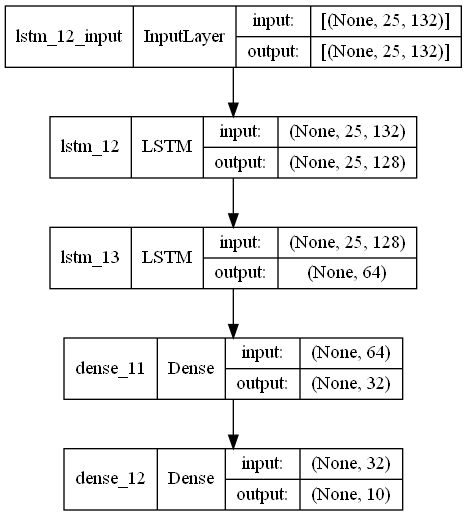

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_def_b1_e350, to_file = "arc_lstm2_dense2_rd_lr5_def_b1_e350_0000_18032022.png", show_shapes = True)

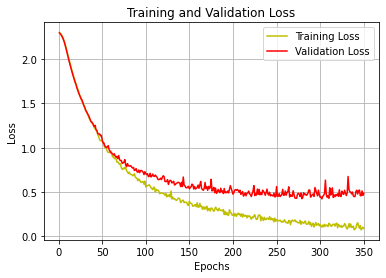

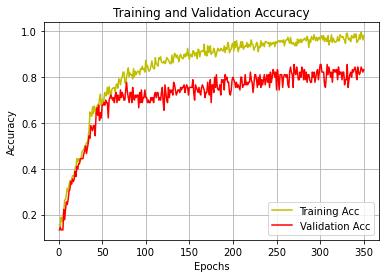

In [290]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [291]:
res = lstm2_dense2_rd_lr5_def_b1_e350.predict(X_test)

In [292]:
yhat = lstm2_dense2_rd_lr5_def_b1_e350.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [293]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 3 3 0 0 0 0 0 0 0]
 [2 6 1 0 0 0 0 0 0 0]
 [2 1 6 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [0 0 2 0 7 0 0 0 0 0]
 [0 0 0 0 0 6 2 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 1 0 0 8]]


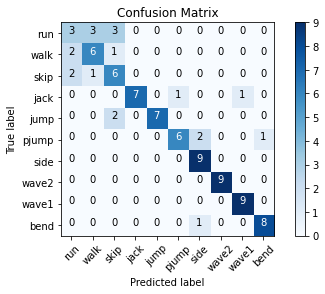

In [294]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [295]:
y_pred = lstm2_dense2_rd_lr5_def_b1_e350.predict(X_test)
y_pred = (y_pred > 0.5)

In [296]:
_, acc = lstm2_dense2_rd_lr5_def_b1_e350.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 2s 69ms/step - loss: 0.6012 - categorical_accuracy: 0.7778
Accuracy =  77.77777910232544  %


In [297]:
accuracy_score(ytrue, yhat)

0.7777777777777778

In [298]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.33      0.38         9
        walk       0.60      0.67      0.63         9
        skip       0.50      0.67      0.57         9
        jack       1.00      0.78      0.88         9
        jump       1.00      0.78      0.88         9
       pjump       0.86      0.67      0.75         9
        side       0.75      1.00      0.86         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.78        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.79      0.78      0.78        90



# lstm2_dense2_rd_lr4_def_b2_
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.0001 + batch=2 -> best train, bad test

In [247]:
# Define a sequential model
lstm2_dense2_rd_lr4_def_b2_ = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [248]:
# Compile model with learning rate
lstm2_dense2_rd_lr4_def_b2_.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [249]:
# Training model with validation
history = lstm2_dense2_rd_lr4_def_b2_.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/200
135/135 - 16s - loss: 2.3013 - categorical_accuracy: 0.1222 - val_loss: 2.2505 - val_categorical_accuracy: 0.2000 - 16s/epoch - 119ms/step
Epoch 2/200
135/135 - 8s - loss: 2.1827 - categorical_accuracy: 0.2296 - val_loss: 2.0394 - val_categorical_accuracy: 0.3333 - 8s/epoch - 59ms/step
Epoch 3/200
135/135 - 8s - loss: 1.9327 - categorical_accuracy: 0.3185 - val_loss: 1.8555 - val_categorical_accuracy: 0.3000 - 8s/epoch - 60ms/step
Epoch 4/200
135/135 - 8s - loss: 1.7524 - categorical_accuracy: 0.3407 - val_loss: 1.7218 - val_categorical_accuracy: 0.3556 - 8s/epoch - 61ms/step
Epoch 5/200
135/135 - 10s - loss: 1.5886 - categorical_accuracy: 0.4222 - val_loss: 1.7017 - val_categorical_accuracy: 0.3667 - 10s/epoch - 76ms/step
Epoch 6/200
135/135 - 10s - loss: 1.4272 - categorical_accuracy: 0.4704 - val_loss: 1.3346 - val_categorical_accuracy: 0.5000 - 10s/epoch - 73ms/step
Epoch 7/200
135/135 - 9s - loss: 1.3180 - categorical_accuracy: 0.5111 - val_loss: 1.3232 - val_categoric

Epoch 56/200
135/135 - 8s - loss: 0.2506 - categorical_accuracy: 0.9074 - val_loss: 0.4638 - val_categorical_accuracy: 0.7556 - 8s/epoch - 61ms/step
Epoch 57/200
135/135 - 8s - loss: 0.3313 - categorical_accuracy: 0.8741 - val_loss: 0.4926 - val_categorical_accuracy: 0.7556 - 8s/epoch - 63ms/step
Epoch 58/200
135/135 - 8s - loss: 0.3836 - categorical_accuracy: 0.8704 - val_loss: 0.4029 - val_categorical_accuracy: 0.8000 - 8s/epoch - 61ms/step
Epoch 59/200
135/135 - 8s - loss: 0.2387 - categorical_accuracy: 0.9185 - val_loss: 0.3795 - val_categorical_accuracy: 0.8222 - 8s/epoch - 61ms/step
Epoch 60/200
135/135 - 9s - loss: 0.2439 - categorical_accuracy: 0.9185 - val_loss: 0.4237 - val_categorical_accuracy: 0.7889 - 9s/epoch - 64ms/step
Epoch 61/200
135/135 - 8s - loss: 0.2674 - categorical_accuracy: 0.9111 - val_loss: 0.4544 - val_categorical_accuracy: 0.8111 - 8s/epoch - 62ms/step
Epoch 62/200
135/135 - 8s - loss: 0.3146 - categorical_accuracy: 0.8704 - val_loss: 0.4682 - val_categoric

Epoch 111/200
135/135 - 8s - loss: 0.1479 - categorical_accuracy: 0.9593 - val_loss: 0.3940 - val_categorical_accuracy: 0.8556 - 8s/epoch - 61ms/step
Epoch 112/200
135/135 - 8s - loss: 0.1415 - categorical_accuracy: 0.9519 - val_loss: 0.4884 - val_categorical_accuracy: 0.8000 - 8s/epoch - 60ms/step
Epoch 113/200
135/135 - 8s - loss: 0.1430 - categorical_accuracy: 0.9407 - val_loss: 0.5845 - val_categorical_accuracy: 0.8222 - 8s/epoch - 60ms/step
Epoch 114/200
135/135 - 8s - loss: 0.1796 - categorical_accuracy: 0.9333 - val_loss: 0.4699 - val_categorical_accuracy: 0.8222 - 8s/epoch - 61ms/step
Epoch 115/200
135/135 - 8s - loss: 0.2616 - categorical_accuracy: 0.9148 - val_loss: 0.4623 - val_categorical_accuracy: 0.8000 - 8s/epoch - 62ms/step
Epoch 116/200
135/135 - 8s - loss: 0.2356 - categorical_accuracy: 0.9222 - val_loss: 0.7966 - val_categorical_accuracy: 0.6889 - 8s/epoch - 60ms/step
Epoch 117/200
135/135 - 9s - loss: 0.1633 - categorical_accuracy: 0.9519 - val_loss: 0.4917 - val_ca

Epoch 166/200
135/135 - 8s - loss: 0.0375 - categorical_accuracy: 0.9889 - val_loss: 0.4217 - val_categorical_accuracy: 0.8556 - 8s/epoch - 62ms/step
Epoch 167/200
135/135 - 9s - loss: 0.0216 - categorical_accuracy: 1.0000 - val_loss: 0.5386 - val_categorical_accuracy: 0.8333 - 9s/epoch - 63ms/step
Epoch 168/200
135/135 - 8s - loss: 0.1084 - categorical_accuracy: 0.9741 - val_loss: 0.5472 - val_categorical_accuracy: 0.8111 - 8s/epoch - 63ms/step
Epoch 169/200
135/135 - 8s - loss: 0.0565 - categorical_accuracy: 0.9889 - val_loss: 0.4999 - val_categorical_accuracy: 0.8444 - 8s/epoch - 61ms/step
Epoch 170/200
135/135 - 8s - loss: 0.0246 - categorical_accuracy: 0.9963 - val_loss: 0.5002 - val_categorical_accuracy: 0.8556 - 8s/epoch - 61ms/step
Epoch 171/200
135/135 - 8s - loss: 0.1278 - categorical_accuracy: 0.9593 - val_loss: 0.5952 - val_categorical_accuracy: 0.8333 - 8s/epoch - 61ms/step
Epoch 172/200
135/135 - 10s - loss: 0.2956 - categorical_accuracy: 0.9148 - val_loss: 0.5234 - val_c

In [250]:
lstm2_dense2_rd_lr4_def_b2_.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_37 (LSTM)              (None, 64)                49408     
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dense_36 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [251]:
# Save Model
lstm2_dense2_rd_lr4_def_b2_.save("lstm2_dense2_rd_lr4_def_b2__2323_17032022.h5")

In [252]:
# Load Model
lstm2_dense2_rd_lr4_def_b2_.load_weights("lstm2_dense2_rd_lr4_def_b2__2323_17032022.h5")

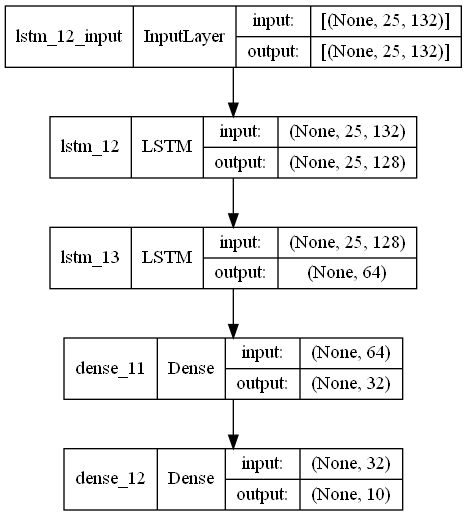

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr4_def_b2_, to_file = "arc_lstm2_dense2_rd_lr4_def_b2__2323_17032022.png", show_shapes = True)

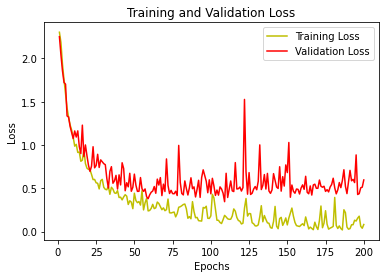

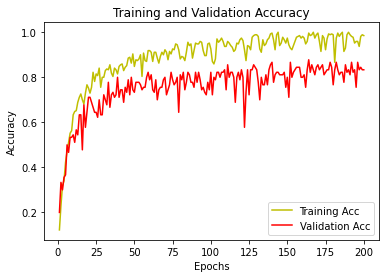

In [253]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [254]:
res = lstm2_dense2_rd_lr4_def_b2_.predict(X_test)

In [255]:
yhat = lstm2_dense2_rd_lr4_def_b2_.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [256]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[5 2 2 0 0 0 0 0 0 0]
 [3 5 0 0 0 0 1 0 0 0]
 [7 1 1 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 1 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [1 0 0 0 0 0 0 0 0 8]]


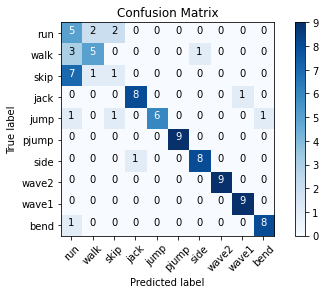

In [257]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [258]:
y_pred = lstm2_dense2_rd_lr4_def_b2_.predict(X_test)
y_pred = (y_pred > 0.5)

In [259]:
_, acc = lstm2_dense2_rd_lr4_def_b2_.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 20ms/step - loss: 0.8576 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [260]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [261]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.29      0.56      0.38         9
        walk       0.62      0.56      0.59         9
        skip       0.25      0.11      0.15         9
        jack       0.89      0.89      0.89         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      1.00      1.00         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.76        90
   macro avg       0.77      0.76      0.75        90
weighted avg       0.77      0.76      0.75        90



# lstm2_dense2_rd_lr5_2_def_b1_e300
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=350 + recurrent_dropout=0.2 + lr=0.00002 + batch=1 -> bad

In [299]:
# Define a sequential model
lstm2_dense2_rd_lr5_2_def_b1_e300 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [300]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_2_def_b1_e300.compile(Nadam(learning_rate=0.00002),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [301]:
# Training model with validation
history = lstm2_dense2_rd_lr5_2_def_b1_e300.fit(X_train, y_train, batch_size=1, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
270/270 - 27s - loss: 2.2988 - categorical_accuracy: 0.1593 - val_loss: 2.2779 - val_categorical_accuracy: 0.1444 - 27s/epoch - 101ms/step
Epoch 2/300
270/270 - 16s - loss: 2.2591 - categorical_accuracy: 0.1704 - val_loss: 2.2319 - val_categorical_accuracy: 0.2111 - 16s/epoch - 61ms/step
Epoch 3/300
270/270 - 18s - loss: 2.1988 - categorical_accuracy: 0.2222 - val_loss: 2.1516 - val_categorical_accuracy: 0.2667 - 18s/epoch - 68ms/step
Epoch 4/300
270/270 - 18s - loss: 2.1053 - categorical_accuracy: 0.3111 - val_loss: 2.0475 - val_categorical_accuracy: 0.3333 - 18s/epoch - 67ms/step
Epoch 5/300
270/270 - 18s - loss: 1.9839 - categorical_accuracy: 0.3333 - val_loss: 1.9294 - val_categorical_accuracy: 0.3778 - 18s/epoch - 68ms/step
Epoch 6/300
270/270 - 19s - loss: 1.8691 - categorical_accuracy: 0.3778 - val_loss: 1.8262 - val_categorical_accuracy: 0.3444 - 19s/epoch - 69ms/step
Epoch 7/300
270/270 - 16s - loss: 1.7754 - categorical_accuracy: 0.3556 - val_loss: 1.7410 - val_ca

Epoch 56/300
270/270 - 16s - loss: 0.4988 - categorical_accuracy: 0.8704 - val_loss: 0.7076 - val_categorical_accuracy: 0.7111 - 16s/epoch - 58ms/step
Epoch 57/300
270/270 - 16s - loss: 0.5000 - categorical_accuracy: 0.8296 - val_loss: 0.6449 - val_categorical_accuracy: 0.7444 - 16s/epoch - 59ms/step
Epoch 58/300
270/270 - 16s - loss: 0.5001 - categorical_accuracy: 0.8556 - val_loss: 0.6577 - val_categorical_accuracy: 0.7444 - 16s/epoch - 58ms/step
Epoch 59/300
270/270 - 16s - loss: 0.4694 - categorical_accuracy: 0.8630 - val_loss: 0.6663 - val_categorical_accuracy: 0.7111 - 16s/epoch - 58ms/step
Epoch 60/300
270/270 - 16s - loss: 0.4843 - categorical_accuracy: 0.8630 - val_loss: 0.6372 - val_categorical_accuracy: 0.7444 - 16s/epoch - 59ms/step
Epoch 61/300
270/270 - 18s - loss: 0.4992 - categorical_accuracy: 0.8667 - val_loss: 0.6818 - val_categorical_accuracy: 0.7000 - 18s/epoch - 65ms/step
Epoch 62/300
270/270 - 17s - loss: 0.4855 - categorical_accuracy: 0.8370 - val_loss: 0.6840 - 

Epoch 111/300
270/270 - 20s - loss: 0.2548 - categorical_accuracy: 0.9185 - val_loss: 0.5189 - val_categorical_accuracy: 0.7667 - 20s/epoch - 73ms/step
Epoch 112/300
270/270 - 16s - loss: 0.2841 - categorical_accuracy: 0.9111 - val_loss: 0.6722 - val_categorical_accuracy: 0.7111 - 16s/epoch - 58ms/step
Epoch 113/300
270/270 - 16s - loss: 0.2338 - categorical_accuracy: 0.9444 - val_loss: 0.5578 - val_categorical_accuracy: 0.7778 - 16s/epoch - 61ms/step
Epoch 114/300
270/270 - 16s - loss: 0.2533 - categorical_accuracy: 0.9333 - val_loss: 0.5883 - val_categorical_accuracy: 0.7556 - 16s/epoch - 59ms/step
Epoch 115/300
270/270 - 16s - loss: 0.2244 - categorical_accuracy: 0.9407 - val_loss: 0.5420 - val_categorical_accuracy: 0.7556 - 16s/epoch - 58ms/step
Epoch 116/300
270/270 - 16s - loss: 0.2393 - categorical_accuracy: 0.9222 - val_loss: 0.5544 - val_categorical_accuracy: 0.7667 - 16s/epoch - 58ms/step
Epoch 117/300
270/270 - 16s - loss: 0.2296 - categorical_accuracy: 0.9370 - val_loss: 0.

Epoch 165/300
270/270 - 16s - loss: 0.1378 - categorical_accuracy: 0.9630 - val_loss: 0.6004 - val_categorical_accuracy: 0.7889 - 16s/epoch - 59ms/step
Epoch 166/300
270/270 - 15s - loss: 0.1682 - categorical_accuracy: 0.9556 - val_loss: 0.5218 - val_categorical_accuracy: 0.8000 - 15s/epoch - 57ms/step
Epoch 167/300
270/270 - 16s - loss: 0.1145 - categorical_accuracy: 0.9704 - val_loss: 0.4826 - val_categorical_accuracy: 0.8444 - 16s/epoch - 58ms/step
Epoch 168/300
270/270 - 16s - loss: 0.1226 - categorical_accuracy: 0.9704 - val_loss: 0.4454 - val_categorical_accuracy: 0.8333 - 16s/epoch - 57ms/step
Epoch 169/300
270/270 - 16s - loss: 0.2034 - categorical_accuracy: 0.9259 - val_loss: 0.4998 - val_categorical_accuracy: 0.8222 - 16s/epoch - 58ms/step
Epoch 170/300
270/270 - 15s - loss: 0.1695 - categorical_accuracy: 0.9556 - val_loss: 0.5535 - val_categorical_accuracy: 0.7889 - 15s/epoch - 57ms/step
Epoch 171/300
270/270 - 16s - loss: 0.1046 - categorical_accuracy: 0.9852 - val_loss: 0.

Epoch 219/300
270/270 - 16s - loss: 0.0760 - categorical_accuracy: 0.9926 - val_loss: 0.5660 - val_categorical_accuracy: 0.8111 - 16s/epoch - 58ms/step
Epoch 220/300
270/270 - 16s - loss: 0.1452 - categorical_accuracy: 0.9593 - val_loss: 0.5132 - val_categorical_accuracy: 0.8111 - 16s/epoch - 59ms/step
Epoch 221/300
270/270 - 15s - loss: 0.1025 - categorical_accuracy: 0.9704 - val_loss: 0.6445 - val_categorical_accuracy: 0.7889 - 15s/epoch - 57ms/step
Epoch 222/300
270/270 - 16s - loss: 0.0544 - categorical_accuracy: 0.9963 - val_loss: 0.5392 - val_categorical_accuracy: 0.8333 - 16s/epoch - 58ms/step
Epoch 223/300
270/270 - 16s - loss: 0.1434 - categorical_accuracy: 0.9630 - val_loss: 0.5386 - val_categorical_accuracy: 0.7889 - 16s/epoch - 58ms/step
Epoch 224/300
270/270 - 16s - loss: 0.0855 - categorical_accuracy: 0.9741 - val_loss: 0.5741 - val_categorical_accuracy: 0.8000 - 16s/epoch - 58ms/step
Epoch 225/300
270/270 - 16s - loss: 0.0566 - categorical_accuracy: 0.9852 - val_loss: 0.

Epoch 273/300
270/270 - 16s - loss: 0.0313 - categorical_accuracy: 1.0000 - val_loss: 0.5701 - val_categorical_accuracy: 0.7889 - 16s/epoch - 59ms/step
Epoch 274/300
270/270 - 15s - loss: 0.1437 - categorical_accuracy: 0.9519 - val_loss: 0.5758 - val_categorical_accuracy: 0.7778 - 15s/epoch - 57ms/step
Epoch 275/300
270/270 - 16s - loss: 0.0359 - categorical_accuracy: 0.9963 - val_loss: 0.6016 - val_categorical_accuracy: 0.8333 - 16s/epoch - 59ms/step
Epoch 276/300
270/270 - 15s - loss: 0.0277 - categorical_accuracy: 1.0000 - val_loss: 0.4683 - val_categorical_accuracy: 0.8444 - 15s/epoch - 56ms/step
Epoch 277/300
270/270 - 15s - loss: 0.0343 - categorical_accuracy: 0.9963 - val_loss: 0.5338 - val_categorical_accuracy: 0.8222 - 15s/epoch - 57ms/step
Epoch 278/300
270/270 - 15s - loss: 0.0585 - categorical_accuracy: 0.9926 - val_loss: 0.6409 - val_categorical_accuracy: 0.8000 - 15s/epoch - 56ms/step
Epoch 279/300
270/270 - 16s - loss: 0.1184 - categorical_accuracy: 0.9778 - val_loss: 0.

In [302]:
lstm2_dense2_rd_lr5_2_def_b1_e300.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_43 (LSTM)              (None, 64)                49408     
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [306]:
# Save Model
lstm2_dense2_rd_lr5_2_def_b1_e300.save("lstm2_dense2_rd_lr5_2_def_b1_e300_0840_18032022.h5")

In [307]:
# Load Model
lstm2_dense2_rd_lr5_2_def_b1_e300.load_weights("lstm2_dense2_rd_lr5_2_def_b1_e300_0840_18032022.h5")

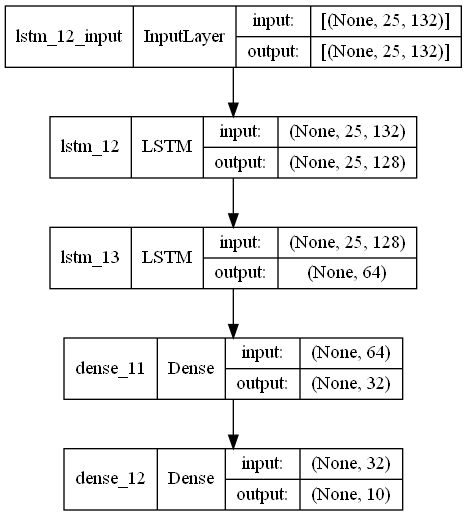

In [90]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_2_def_b1_e300, to_file = "arc_lstm2_dense2_rd_lr5_2_def_b1_e300_0840_18032022.png", show_shapes = True)

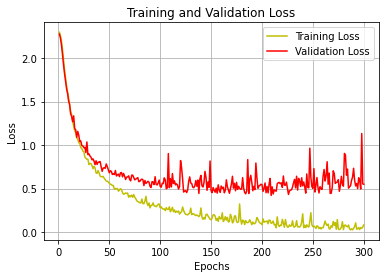

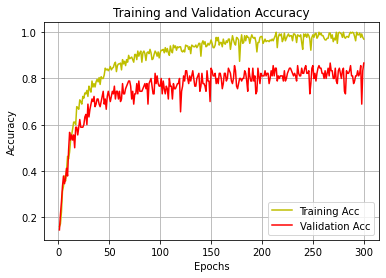

In [308]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [309]:
res = lstm2_dense2_rd_lr5_2_def_b1_e300.predict(X_test)

In [310]:
yhat = lstm2_dense2_rd_lr5_2_def_b1_e300.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [311]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 4 1 0 1 0 0 0 0 0]
 [2 5 2 0 0 0 0 0 0 0]
 [7 1 1 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


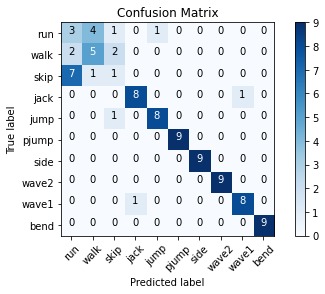

In [312]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [313]:
y_pred = lstm2_dense2_rd_lr5_2_def_b1_e300.predict(X_test)
y_pred = (y_pred > 0.5)

In [314]:
_, acc = lstm2_dense2_rd_lr5_2_def_b1_e300.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 18ms/step - loss: 0.7976 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [297]:
accuracy_score(ytrue, yhat)

0.7777777777777778

In [315]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.25      0.33      0.29         9
        walk       0.50      0.56      0.53         9
        skip       0.20      0.11      0.14         9
        jack       0.89      0.89      0.89         9
        jump       0.89      0.89      0.89         9
       pjump       1.00      1.00      1.00         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.77        90
   macro avg       0.76      0.77      0.76        90
weighted avg       0.76      0.77      0.76        90



# lstm2_dense2_rd2_lr5_e250_b8
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=250 + recurrent_dropout=0.2 + lr=0.00001 + batch=8 -> vairly good curve, bad

In [316]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e250_b8 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [317]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e250_b8.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [318]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e250_b8.fit(X_train, y_train, batch_size=8, epochs=250, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/250
34/34 - 16s - loss: 2.3161 - categorical_accuracy: 0.1000 - val_loss: 2.3150 - val_categorical_accuracy: 0.1000 - 16s/epoch - 465ms/step
Epoch 2/250
34/34 - 3s - loss: 2.3092 - categorical_accuracy: 0.1037 - val_loss: 2.3077 - val_categorical_accuracy: 0.1000 - 3s/epoch - 88ms/step
Epoch 3/250
34/34 - 3s - loss: 2.3014 - categorical_accuracy: 0.1000 - val_loss: 2.3001 - val_categorical_accuracy: 0.1000 - 3s/epoch - 78ms/step
Epoch 4/250
34/34 - 3s - loss: 2.2945 - categorical_accuracy: 0.1037 - val_loss: 2.2924 - val_categorical_accuracy: 0.1000 - 3s/epoch - 83ms/step
Epoch 5/250
34/34 - 3s - loss: 2.2864 - categorical_accuracy: 0.1074 - val_loss: 2.2845 - val_categorical_accuracy: 0.1000 - 3s/epoch - 77ms/step
Epoch 6/250
34/34 - 3s - loss: 2.2762 - categorical_accuracy: 0.1185 - val_loss: 2.2778 - val_categorical_accuracy: 0.1000 - 3s/epoch - 76ms/step
Epoch 7/250
34/34 - 3s - loss: 2.2703 - categorical_accuracy: 0.1222 - val_loss: 2.2709 - val_categorical_accuracy: 0.100

Epoch 57/250
34/34 - 3s - loss: 1.4354 - categorical_accuracy: 0.5519 - val_loss: 1.4670 - val_categorical_accuracy: 0.4667 - 3s/epoch - 75ms/step
Epoch 58/250
34/34 - 3s - loss: 1.4282 - categorical_accuracy: 0.5222 - val_loss: 1.4562 - val_categorical_accuracy: 0.5222 - 3s/epoch - 75ms/step
Epoch 59/250
34/34 - 3s - loss: 1.4050 - categorical_accuracy: 0.5407 - val_loss: 1.4429 - val_categorical_accuracy: 0.5000 - 3s/epoch - 76ms/step
Epoch 60/250
34/34 - 3s - loss: 1.3930 - categorical_accuracy: 0.5556 - val_loss: 1.4317 - val_categorical_accuracy: 0.5111 - 3s/epoch - 75ms/step
Epoch 61/250
34/34 - 3s - loss: 1.3731 - categorical_accuracy: 0.5407 - val_loss: 1.4235 - val_categorical_accuracy: 0.5000 - 3s/epoch - 81ms/step
Epoch 62/250
34/34 - 3s - loss: 1.3591 - categorical_accuracy: 0.5630 - val_loss: 1.4134 - val_categorical_accuracy: 0.4889 - 3s/epoch - 76ms/step
Epoch 63/250
34/34 - 3s - loss: 1.3607 - categorical_accuracy: 0.5852 - val_loss: 1.4077 - val_categorical_accuracy: 0

Epoch 113/250
34/34 - 3s - loss: 0.9447 - categorical_accuracy: 0.7259 - val_loss: 1.0844 - val_categorical_accuracy: 0.6000 - 3s/epoch - 81ms/step
Epoch 114/250
34/34 - 3s - loss: 0.9638 - categorical_accuracy: 0.7222 - val_loss: 1.0795 - val_categorical_accuracy: 0.6111 - 3s/epoch - 76ms/step
Epoch 115/250
34/34 - 3s - loss: 0.9505 - categorical_accuracy: 0.7296 - val_loss: 1.0772 - val_categorical_accuracy: 0.5889 - 3s/epoch - 75ms/step
Epoch 116/250
34/34 - 3s - loss: 0.9546 - categorical_accuracy: 0.7444 - val_loss: 1.0744 - val_categorical_accuracy: 0.6222 - 3s/epoch - 80ms/step
Epoch 117/250
34/34 - 3s - loss: 0.9412 - categorical_accuracy: 0.7407 - val_loss: 1.0713 - val_categorical_accuracy: 0.6000 - 3s/epoch - 76ms/step
Epoch 118/250
34/34 - 3s - loss: 0.9620 - categorical_accuracy: 0.7222 - val_loss: 1.0632 - val_categorical_accuracy: 0.6000 - 3s/epoch - 75ms/step
Epoch 119/250
34/34 - 3s - loss: 0.9394 - categorical_accuracy: 0.7296 - val_loss: 1.0699 - val_categorical_accu

Epoch 169/250
34/34 - 3s - loss: 0.7151 - categorical_accuracy: 0.8296 - val_loss: 0.9025 - val_categorical_accuracy: 0.6667 - 3s/epoch - 75ms/step
Epoch 170/250
34/34 - 3s - loss: 0.7299 - categorical_accuracy: 0.7889 - val_loss: 0.9097 - val_categorical_accuracy: 0.6556 - 3s/epoch - 81ms/step
Epoch 171/250
34/34 - 3s - loss: 0.7435 - categorical_accuracy: 0.7741 - val_loss: 0.9085 - val_categorical_accuracy: 0.6556 - 3s/epoch - 75ms/step
Epoch 172/250
34/34 - 3s - loss: 0.7072 - categorical_accuracy: 0.8296 - val_loss: 0.9006 - val_categorical_accuracy: 0.6444 - 3s/epoch - 75ms/step
Epoch 173/250
34/34 - 3s - loss: 0.7381 - categorical_accuracy: 0.8074 - val_loss: 0.9142 - val_categorical_accuracy: 0.6333 - 3s/epoch - 75ms/step
Epoch 174/250
34/34 - 3s - loss: 0.7012 - categorical_accuracy: 0.8037 - val_loss: 0.9094 - val_categorical_accuracy: 0.6444 - 3s/epoch - 83ms/step
Epoch 175/250
34/34 - 3s - loss: 0.7082 - categorical_accuracy: 0.8037 - val_loss: 0.9130 - val_categorical_accu

Epoch 225/250
34/34 - 3s - loss: 0.5688 - categorical_accuracy: 0.8704 - val_loss: 0.8101 - val_categorical_accuracy: 0.6889 - 3s/epoch - 76ms/step
Epoch 226/250
34/34 - 3s - loss: 0.5947 - categorical_accuracy: 0.8296 - val_loss: 0.7871 - val_categorical_accuracy: 0.6667 - 3s/epoch - 77ms/step
Epoch 227/250
34/34 - 3s - loss: 0.5706 - categorical_accuracy: 0.8704 - val_loss: 0.7846 - val_categorical_accuracy: 0.6778 - 3s/epoch - 79ms/step
Epoch 228/250
34/34 - 3s - loss: 0.5783 - categorical_accuracy: 0.8444 - val_loss: 0.7947 - val_categorical_accuracy: 0.6556 - 3s/epoch - 77ms/step
Epoch 229/250
34/34 - 3s - loss: 0.5808 - categorical_accuracy: 0.8259 - val_loss: 0.7876 - val_categorical_accuracy: 0.6667 - 3s/epoch - 80ms/step
Epoch 230/250
34/34 - 3s - loss: 0.5726 - categorical_accuracy: 0.8259 - val_loss: 0.7861 - val_categorical_accuracy: 0.6556 - 3s/epoch - 76ms/step
Epoch 231/250
34/34 - 3s - loss: 0.5813 - categorical_accuracy: 0.8148 - val_loss: 0.7753 - val_categorical_accu

In [319]:
lstm2_dense2_rd2_lr5_e250_b8.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_45 (LSTM)              (None, 64)                49408     
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [320]:
# Save Model
lstm2_dense2_rd2_lr5_e250_b8.save("lstm2_dense2_rd2_lr5_e250_b8_1301_18032022.h5")

In [321]:
# Load Model
lstm2_dense2_rd2_lr5_e250_b8.load_weights("lstm2_dense2_rd2_lr5_e250_b8_1301_18032022.h5")

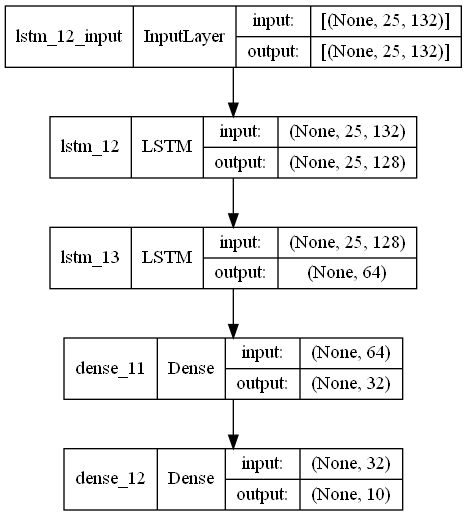

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e250_b8, to_file = "arc_lstm2_dense2_rd2_lr5_e250_b8_1301_18032022.png", show_shapes = True)

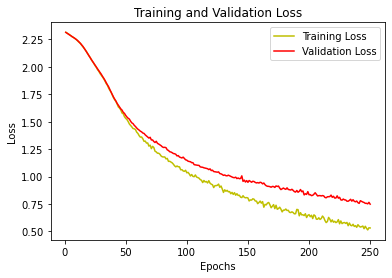

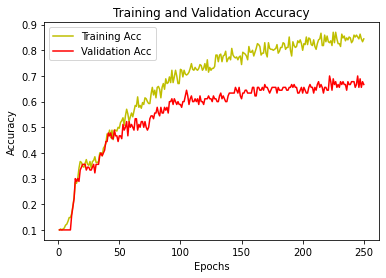

In [322]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [323]:
res = lstm2_dense2_rd2_lr5_e250_b8.predict(X_test)

In [324]:
yhat = lstm2_dense2_rd2_lr5_e250_b8.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [325]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[2 2 5 0 0 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [3 0 6 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 1 1 0]
 [0 0 0 0 8 0 0 0 0 1]
 [0 0 0 0 0 7 1 0 0 1]
 [0 0 0 0 0 3 6 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 1 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


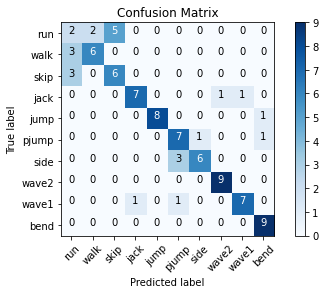

In [326]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [327]:
y_pred = lstm2_dense2_rd2_lr5_e250_b8.predict(X_test)
y_pred = (y_pred > 0.5)

In [328]:
_, acc = lstm2_dense2_rd2_lr5_e250_b8.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 25ms/step - loss: 0.7113 - categorical_accuracy: 0.7444
Accuracy =  74.44444298744202  %


In [329]:
accuracy_score(ytrue, yhat)

0.7444444444444445

In [330]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.25      0.22      0.24         9
        walk       0.75      0.67      0.71         9
        skip       0.55      0.67      0.60         9
        jack       0.88      0.78      0.82         9
        jump       1.00      0.89      0.94         9
       pjump       0.64      0.78      0.70         9
        side       0.86      0.67      0.75         9
       wave2       0.90      1.00      0.95         9
       wave1       0.88      0.78      0.82         9
        bend       0.82      1.00      0.90         9

    accuracy                           0.74        90
   macro avg       0.75      0.74      0.74        90
weighted avg       0.75      0.74      0.74        90



# lstm2_dense2_rd2_lr5_e300_b8
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=300 + recurrent_dropout=0.2 + lr=0.00001 + batch=8 -> bad

In [331]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e300_b8 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [332]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e300_b8.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [333]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e300_b8.fit(X_train, y_train, batch_size=8, epochs=300, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/300
34/34 - 12s - loss: 2.3215 - categorical_accuracy: 0.0741 - val_loss: 2.3171 - val_categorical_accuracy: 0.1111 - 12s/epoch - 341ms/step
Epoch 2/300
34/34 - 3s - loss: 2.3144 - categorical_accuracy: 0.0704 - val_loss: 2.3113 - val_categorical_accuracy: 0.0778 - 3s/epoch - 83ms/step
Epoch 3/300
34/34 - 3s - loss: 2.3082 - categorical_accuracy: 0.0815 - val_loss: 2.3064 - val_categorical_accuracy: 0.0778 - 3s/epoch - 102ms/step
Epoch 4/300
34/34 - 3s - loss: 2.3036 - categorical_accuracy: 0.0778 - val_loss: 2.3011 - val_categorical_accuracy: 0.1000 - 3s/epoch - 84ms/step
Epoch 5/300
34/34 - 3s - loss: 2.2958 - categorical_accuracy: 0.1148 - val_loss: 2.2958 - val_categorical_accuracy: 0.1556 - 3s/epoch - 83ms/step
Epoch 6/300
34/34 - 3s - loss: 2.2943 - categorical_accuracy: 0.1519 - val_loss: 2.2909 - val_categorical_accuracy: 0.1556 - 3s/epoch - 82ms/step
Epoch 7/300
34/34 - 3s - loss: 2.2847 - categorical_accuracy: 0.1630 - val_loss: 2.2861 - val_categorical_accuracy: 0.16

Epoch 57/300
34/34 - 3s - loss: 1.5950 - categorical_accuracy: 0.4259 - val_loss: 1.5999 - val_categorical_accuracy: 0.3444 - 3s/epoch - 89ms/step
Epoch 58/300
34/34 - 3s - loss: 1.5766 - categorical_accuracy: 0.4259 - val_loss: 1.5846 - val_categorical_accuracy: 0.3667 - 3s/epoch - 88ms/step
Epoch 59/300
34/34 - 3s - loss: 1.5650 - categorical_accuracy: 0.4296 - val_loss: 1.5774 - val_categorical_accuracy: 0.3444 - 3s/epoch - 84ms/step
Epoch 60/300
34/34 - 3s - loss: 1.5507 - categorical_accuracy: 0.4481 - val_loss: 1.5653 - val_categorical_accuracy: 0.3556 - 3s/epoch - 87ms/step
Epoch 61/300
34/34 - 3s - loss: 1.5430 - categorical_accuracy: 0.4667 - val_loss: 1.5612 - val_categorical_accuracy: 0.3556 - 3s/epoch - 84ms/step
Epoch 62/300
34/34 - 3s - loss: 1.5143 - categorical_accuracy: 0.4704 - val_loss: 1.5460 - val_categorical_accuracy: 0.3444 - 3s/epoch - 89ms/step
Epoch 63/300
34/34 - 3s - loss: 1.5133 - categorical_accuracy: 0.4407 - val_loss: 1.5447 - val_categorical_accuracy: 0

Epoch 113/300
34/34 - 3s - loss: 1.1528 - categorical_accuracy: 0.6630 - val_loss: 1.2242 - val_categorical_accuracy: 0.5667 - 3s/epoch - 91ms/step
Epoch 114/300
34/34 - 3s - loss: 1.1409 - categorical_accuracy: 0.6333 - val_loss: 1.2298 - val_categorical_accuracy: 0.5444 - 3s/epoch - 85ms/step
Epoch 115/300
34/34 - 3s - loss: 1.1426 - categorical_accuracy: 0.6444 - val_loss: 1.2080 - val_categorical_accuracy: 0.5889 - 3s/epoch - 88ms/step
Epoch 116/300
34/34 - 3s - loss: 1.1309 - categorical_accuracy: 0.6593 - val_loss: 1.2228 - val_categorical_accuracy: 0.5556 - 3s/epoch - 86ms/step
Epoch 117/300
34/34 - 3s - loss: 1.1337 - categorical_accuracy: 0.6519 - val_loss: 1.2087 - val_categorical_accuracy: 0.6000 - 3s/epoch - 88ms/step
Epoch 118/300
34/34 - 3s - loss: 1.0960 - categorical_accuracy: 0.6741 - val_loss: 1.1961 - val_categorical_accuracy: 0.5778 - 3s/epoch - 86ms/step
Epoch 119/300
34/34 - 3s - loss: 1.0987 - categorical_accuracy: 0.6889 - val_loss: 1.1854 - val_categorical_accu

Epoch 169/300
34/34 - 4s - loss: 0.8985 - categorical_accuracy: 0.7556 - val_loss: 1.0143 - val_categorical_accuracy: 0.6556 - 4s/epoch - 116ms/step
Epoch 170/300
34/34 - 3s - loss: 0.8876 - categorical_accuracy: 0.7704 - val_loss: 1.0081 - val_categorical_accuracy: 0.6667 - 3s/epoch - 99ms/step
Epoch 171/300
34/34 - 4s - loss: 0.8980 - categorical_accuracy: 0.7407 - val_loss: 1.0138 - val_categorical_accuracy: 0.6556 - 4s/epoch - 123ms/step
Epoch 172/300
34/34 - 4s - loss: 0.8677 - categorical_accuracy: 0.7704 - val_loss: 1.0068 - val_categorical_accuracy: 0.6667 - 4s/epoch - 103ms/step
Epoch 173/300
34/34 - 4s - loss: 0.8763 - categorical_accuracy: 0.7593 - val_loss: 0.9977 - val_categorical_accuracy: 0.6556 - 4s/epoch - 105ms/step
Epoch 174/300
34/34 - 4s - loss: 0.8897 - categorical_accuracy: 0.7407 - val_loss: 1.0377 - val_categorical_accuracy: 0.6444 - 4s/epoch - 118ms/step
Epoch 175/300
34/34 - 3s - loss: 0.8644 - categorical_accuracy: 0.7333 - val_loss: 0.9973 - val_categorical

Epoch 225/300
34/34 - 3s - loss: 0.7175 - categorical_accuracy: 0.8111 - val_loss: 0.8715 - val_categorical_accuracy: 0.7333 - 3s/epoch - 83ms/step
Epoch 226/300
34/34 - 3s - loss: 0.7192 - categorical_accuracy: 0.8148 - val_loss: 0.8574 - val_categorical_accuracy: 0.6889 - 3s/epoch - 78ms/step
Epoch 227/300
34/34 - 3s - loss: 0.7157 - categorical_accuracy: 0.8000 - val_loss: 0.8709 - val_categorical_accuracy: 0.6667 - 3s/epoch - 77ms/step
Epoch 228/300
34/34 - 3s - loss: 0.7144 - categorical_accuracy: 0.8185 - val_loss: 0.8690 - val_categorical_accuracy: 0.7000 - 3s/epoch - 83ms/step
Epoch 229/300
34/34 - 3s - loss: 0.7134 - categorical_accuracy: 0.8111 - val_loss: 0.8550 - val_categorical_accuracy: 0.6889 - 3s/epoch - 78ms/step
Epoch 230/300
34/34 - 3s - loss: 0.7088 - categorical_accuracy: 0.8296 - val_loss: 0.8628 - val_categorical_accuracy: 0.6667 - 3s/epoch - 77ms/step
Epoch 231/300
34/34 - 3s - loss: 0.7223 - categorical_accuracy: 0.8259 - val_loss: 0.8448 - val_categorical_accu

Epoch 281/300
34/34 - 3s - loss: 0.6201 - categorical_accuracy: 0.8222 - val_loss: 0.7736 - val_categorical_accuracy: 0.7222 - 3s/epoch - 86ms/step
Epoch 282/300
34/34 - 3s - loss: 0.5986 - categorical_accuracy: 0.8370 - val_loss: 0.7686 - val_categorical_accuracy: 0.7333 - 3s/epoch - 78ms/step
Epoch 283/300
34/34 - 3s - loss: 0.5979 - categorical_accuracy: 0.8481 - val_loss: 0.7770 - val_categorical_accuracy: 0.6889 - 3s/epoch - 77ms/step
Epoch 284/300
34/34 - 3s - loss: 0.5942 - categorical_accuracy: 0.8481 - val_loss: 0.7629 - val_categorical_accuracy: 0.7000 - 3s/epoch - 79ms/step
Epoch 285/300
34/34 - 3s - loss: 0.6005 - categorical_accuracy: 0.8519 - val_loss: 0.7673 - val_categorical_accuracy: 0.7444 - 3s/epoch - 78ms/step
Epoch 286/300
34/34 - 3s - loss: 0.5667 - categorical_accuracy: 0.8481 - val_loss: 0.7577 - val_categorical_accuracy: 0.7111 - 3s/epoch - 78ms/step
Epoch 287/300
34/34 - 3s - loss: 0.5964 - categorical_accuracy: 0.8556 - val_loss: 0.7746 - val_categorical_accu

In [334]:
lstm2_dense2_rd2_lr5_e300_b8.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_47 (LSTM)              (None, 64)                49408     
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [335]:
# Save Model
lstm2_dense2_rd2_lr5_e300_b8.save("lstm2_dense2_rd2_lr5_e300_b8_1326_18032022.h5")

In [336]:
# Load Model
lstm2_dense2_rd2_lr5_e300_b8.load_weights("lstm2_dense2_rd2_lr5_e300_b8_1326_18032022.h5")

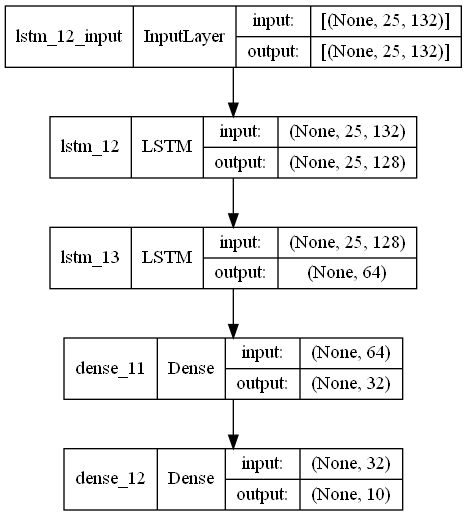

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e300_b8, to_file = "arc_lstm2_dense2_rd2_lr5_e300_b8_1326_18032022.png", show_shapes = True)

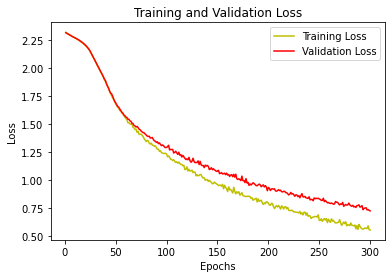

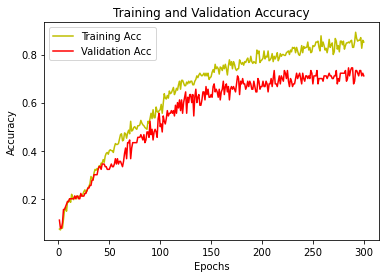

In [337]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", label="Training Acc")
plt.plot(epochs, val_acc, "r", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [338]:
res = lstm2_dense2_rd2_lr5_e300_b8.predict(X_test)

In [339]:
yhat = lstm2_dense2_rd2_lr5_e300_b8.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [340]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[0 6 3 0 0 0 0 0 0 0]
 [1 7 1 0 0 0 0 0 0 0]
 [0 3 6 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 3 1 0]
 [1 0 2 0 5 1 0 0 0 0]
 [0 0 0 0 0 7 1 0 0 1]
 [0 0 0 0 0 1 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 1 0 0 8 0]
 [0 0 0 0 0 0 0 0 1 8]]


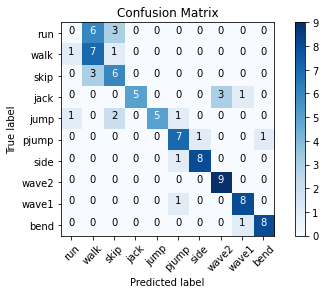

In [341]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [342]:
y_pred = lstm2_dense2_rd2_lr5_e300_b8.predict(X_test)
y_pred = (y_pred > 0.5)

In [343]:
_, acc = lstm2_dense2_rd2_lr5_e300_b8.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 21ms/step - loss: 0.8612 - categorical_accuracy: 0.7000
Accuracy =  69.9999988079071  %


In [344]:
accuracy_score(ytrue, yhat)

0.7

In [345]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.00      0.00      0.00         9
        walk       0.44      0.78      0.56         9
        skip       0.50      0.67      0.57         9
        jack       1.00      0.56      0.71         9
        jump       1.00      0.56      0.71         9
       pjump       0.70      0.78      0.74         9
        side       0.89      0.89      0.89         9
       wave2       0.75      1.00      0.86         9
       wave1       0.80      0.89      0.84         9
        bend       0.89      0.89      0.89         9

    accuracy                           0.70        90
   macro avg       0.70      0.70      0.68        90
weighted avg       0.70      0.70      0.68        90



# lstm2_dense2_rd2_lr5_e400_b6
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=400 + recurrent_dropout=0.2 + lr=0.00001 + batch=6 -> vairly good curve, bad

In [347]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e400_b6 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [348]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e400_b6.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [349]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e400_b6.fit(X_train, y_train, batch_size=6, epochs=400, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/400
45/45 - 11s - loss: 2.3191 - categorical_accuracy: 0.0444 - val_loss: 2.3133 - val_categorical_accuracy: 0.0556 - 11s/epoch - 252ms/step
Epoch 2/400
45/45 - 3s - loss: 2.3118 - categorical_accuracy: 0.0407 - val_loss: 2.3068 - val_categorical_accuracy: 0.1000 - 3s/epoch - 73ms/step
Epoch 3/400
45/45 - 4s - loss: 2.3053 - categorical_accuracy: 0.1259 - val_loss: 2.3010 - val_categorical_accuracy: 0.1778 - 4s/epoch - 82ms/step
Epoch 4/400
45/45 - 3s - loss: 2.2997 - categorical_accuracy: 0.1370 - val_loss: 2.2961 - val_categorical_accuracy: 0.2000 - 3s/epoch - 67ms/step
Epoch 5/400
45/45 - 3s - loss: 2.2954 - categorical_accuracy: 0.2037 - val_loss: 2.2910 - val_categorical_accuracy: 0.2333 - 3s/epoch - 72ms/step
Epoch 6/400
45/45 - 3s - loss: 2.2882 - categorical_accuracy: 0.2556 - val_loss: 2.2859 - val_categorical_accuracy: 0.2444 - 3s/epoch - 71ms/step
Epoch 7/400
45/45 - 3s - loss: 2.2822 - categorical_accuracy: 0.2778 - val_loss: 2.2801 - val_categorical_accuracy: 0.266

Epoch 57/400
45/45 - 3s - loss: 1.4674 - categorical_accuracy: 0.5370 - val_loss: 1.5119 - val_categorical_accuracy: 0.5333 - 3s/epoch - 65ms/step
Epoch 58/400
45/45 - 3s - loss: 1.4557 - categorical_accuracy: 0.5704 - val_loss: 1.4973 - val_categorical_accuracy: 0.5333 - 3s/epoch - 64ms/step
Epoch 59/400
45/45 - 3s - loss: 1.4448 - categorical_accuracy: 0.5667 - val_loss: 1.4848 - val_categorical_accuracy: 0.5444 - 3s/epoch - 68ms/step
Epoch 60/400
45/45 - 3s - loss: 1.4326 - categorical_accuracy: 0.5667 - val_loss: 1.4716 - val_categorical_accuracy: 0.5111 - 3s/epoch - 67ms/step
Epoch 61/400
45/45 - 3s - loss: 1.4183 - categorical_accuracy: 0.5556 - val_loss: 1.4588 - val_categorical_accuracy: 0.5444 - 3s/epoch - 64ms/step
Epoch 62/400
45/45 - 3s - loss: 1.4036 - categorical_accuracy: 0.5593 - val_loss: 1.4464 - val_categorical_accuracy: 0.5333 - 3s/epoch - 63ms/step
Epoch 63/400
45/45 - 3s - loss: 1.3932 - categorical_accuracy: 0.5778 - val_loss: 1.4355 - val_categorical_accuracy: 0

Epoch 113/400
45/45 - 3s - loss: 0.9798 - categorical_accuracy: 0.6407 - val_loss: 1.0898 - val_categorical_accuracy: 0.5444 - 3s/epoch - 62ms/step
Epoch 114/400
45/45 - 3s - loss: 0.9529 - categorical_accuracy: 0.6667 - val_loss: 1.0799 - val_categorical_accuracy: 0.5333 - 3s/epoch - 62ms/step
Epoch 115/400
45/45 - 3s - loss: 0.9606 - categorical_accuracy: 0.6593 - val_loss: 1.0768 - val_categorical_accuracy: 0.5444 - 3s/epoch - 64ms/step
Epoch 116/400
45/45 - 3s - loss: 0.9233 - categorical_accuracy: 0.6889 - val_loss: 1.0786 - val_categorical_accuracy: 0.5333 - 3s/epoch - 62ms/step
Epoch 117/400
45/45 - 3s - loss: 0.9506 - categorical_accuracy: 0.6370 - val_loss: 1.0791 - val_categorical_accuracy: 0.5444 - 3s/epoch - 62ms/step
Epoch 118/400
45/45 - 3s - loss: 0.9445 - categorical_accuracy: 0.6556 - val_loss: 1.0748 - val_categorical_accuracy: 0.5556 - 3s/epoch - 66ms/step
Epoch 119/400
45/45 - 3s - loss: 0.9180 - categorical_accuracy: 0.6667 - val_loss: 1.0687 - val_categorical_accu

Epoch 169/400
45/45 - 3s - loss: 0.6993 - categorical_accuracy: 0.8037 - val_loss: 0.8830 - val_categorical_accuracy: 0.6889 - 3s/epoch - 61ms/step
Epoch 170/400
45/45 - 3s - loss: 0.6837 - categorical_accuracy: 0.8259 - val_loss: 0.8754 - val_categorical_accuracy: 0.6667 - 3s/epoch - 62ms/step
Epoch 171/400
45/45 - 3s - loss: 0.6734 - categorical_accuracy: 0.8222 - val_loss: 0.8721 - val_categorical_accuracy: 0.6667 - 3s/epoch - 67ms/step
Epoch 172/400
45/45 - 3s - loss: 0.6841 - categorical_accuracy: 0.8185 - val_loss: 0.8629 - val_categorical_accuracy: 0.6889 - 3s/epoch - 64ms/step
Epoch 173/400
45/45 - 3s - loss: 0.6790 - categorical_accuracy: 0.8185 - val_loss: 0.8751 - val_categorical_accuracy: 0.6667 - 3s/epoch - 62ms/step
Epoch 174/400
45/45 - 3s - loss: 0.6757 - categorical_accuracy: 0.8148 - val_loss: 0.8753 - val_categorical_accuracy: 0.6778 - 3s/epoch - 63ms/step
Epoch 175/400
45/45 - 3s - loss: 0.6664 - categorical_accuracy: 0.8185 - val_loss: 0.8782 - val_categorical_accu

Epoch 225/400
45/45 - 3s - loss: 0.5413 - categorical_accuracy: 0.8333 - val_loss: 0.7688 - val_categorical_accuracy: 0.6778 - 3s/epoch - 61ms/step
Epoch 226/400
45/45 - 3s - loss: 0.5440 - categorical_accuracy: 0.8556 - val_loss: 0.7486 - val_categorical_accuracy: 0.6778 - 3s/epoch - 69ms/step
Epoch 227/400
45/45 - 3s - loss: 0.5266 - categorical_accuracy: 0.8556 - val_loss: 0.7623 - val_categorical_accuracy: 0.6889 - 3s/epoch - 62ms/step
Epoch 228/400
45/45 - 3s - loss: 0.5174 - categorical_accuracy: 0.8556 - val_loss: 0.7391 - val_categorical_accuracy: 0.6889 - 3s/epoch - 62ms/step
Epoch 229/400
45/45 - 3s - loss: 0.5216 - categorical_accuracy: 0.8556 - val_loss: 0.7399 - val_categorical_accuracy: 0.6889 - 3s/epoch - 62ms/step
Epoch 230/400
45/45 - 3s - loss: 0.5361 - categorical_accuracy: 0.8407 - val_loss: 0.7419 - val_categorical_accuracy: 0.6778 - 3s/epoch - 63ms/step
Epoch 231/400
45/45 - 3s - loss: 0.5131 - categorical_accuracy: 0.8778 - val_loss: 0.7417 - val_categorical_accu

Epoch 281/400
45/45 - 3s - loss: 0.4129 - categorical_accuracy: 0.8667 - val_loss: 0.6753 - val_categorical_accuracy: 0.7111 - 3s/epoch - 72ms/step
Epoch 282/400
45/45 - 4s - loss: 0.4281 - categorical_accuracy: 0.9000 - val_loss: 0.6847 - val_categorical_accuracy: 0.7111 - 4s/epoch - 79ms/step
Epoch 283/400
45/45 - 3s - loss: 0.4269 - categorical_accuracy: 0.8926 - val_loss: 0.6704 - val_categorical_accuracy: 0.7333 - 3s/epoch - 66ms/step
Epoch 284/400
45/45 - 3s - loss: 0.4163 - categorical_accuracy: 0.8963 - val_loss: 0.6723 - val_categorical_accuracy: 0.7222 - 3s/epoch - 62ms/step
Epoch 285/400
45/45 - 3s - loss: 0.3813 - categorical_accuracy: 0.9037 - val_loss: 0.6670 - val_categorical_accuracy: 0.7222 - 3s/epoch - 62ms/step
Epoch 286/400
45/45 - 3s - loss: 0.4134 - categorical_accuracy: 0.8778 - val_loss: 0.6699 - val_categorical_accuracy: 0.7222 - 3s/epoch - 64ms/step
Epoch 287/400
45/45 - 3s - loss: 0.4020 - categorical_accuracy: 0.8926 - val_loss: 0.6731 - val_categorical_accu

Epoch 337/400
45/45 - 3s - loss: 0.3349 - categorical_accuracy: 0.9148 - val_loss: 0.6461 - val_categorical_accuracy: 0.7556 - 3s/epoch - 61ms/step
Epoch 338/400
45/45 - 3s - loss: 0.3444 - categorical_accuracy: 0.8926 - val_loss: 0.6135 - val_categorical_accuracy: 0.7444 - 3s/epoch - 62ms/step
Epoch 339/400
45/45 - 3s - loss: 0.3371 - categorical_accuracy: 0.9074 - val_loss: 0.6020 - val_categorical_accuracy: 0.7667 - 3s/epoch - 62ms/step
Epoch 340/400
45/45 - 3s - loss: 0.3070 - categorical_accuracy: 0.9259 - val_loss: 0.5970 - val_categorical_accuracy: 0.7778 - 3s/epoch - 62ms/step
Epoch 341/400
45/45 - 3s - loss: 0.3359 - categorical_accuracy: 0.9074 - val_loss: 0.6056 - val_categorical_accuracy: 0.7444 - 3s/epoch - 64ms/step
Epoch 342/400
45/45 - 3s - loss: 0.3291 - categorical_accuracy: 0.9148 - val_loss: 0.6122 - val_categorical_accuracy: 0.7667 - 3s/epoch - 63ms/step
Epoch 343/400
45/45 - 3s - loss: 0.3226 - categorical_accuracy: 0.9296 - val_loss: 0.6152 - val_categorical_accu

Epoch 393/400
45/45 - 3s - loss: 0.2549 - categorical_accuracy: 0.9370 - val_loss: 0.5948 - val_categorical_accuracy: 0.7222 - 3s/epoch - 62ms/step
Epoch 394/400
45/45 - 3s - loss: 0.2570 - categorical_accuracy: 0.9444 - val_loss: 0.6325 - val_categorical_accuracy: 0.7333 - 3s/epoch - 62ms/step
Epoch 395/400
45/45 - 3s - loss: 0.2669 - categorical_accuracy: 0.9519 - val_loss: 0.5938 - val_categorical_accuracy: 0.7444 - 3s/epoch - 63ms/step
Epoch 396/400
45/45 - 3s - loss: 0.2645 - categorical_accuracy: 0.9333 - val_loss: 0.5887 - val_categorical_accuracy: 0.7222 - 3s/epoch - 63ms/step
Epoch 397/400
45/45 - 3s - loss: 0.2710 - categorical_accuracy: 0.9333 - val_loss: 0.5842 - val_categorical_accuracy: 0.7778 - 3s/epoch - 74ms/step
Epoch 398/400
45/45 - 3s - loss: 0.2762 - categorical_accuracy: 0.9074 - val_loss: 0.5811 - val_categorical_accuracy: 0.7889 - 3s/epoch - 74ms/step
Epoch 399/400
45/45 - 4s - loss: 0.2559 - categorical_accuracy: 0.9519 - val_loss: 0.5745 - val_categorical_accu

In [350]:
lstm2_dense2_rd2_lr5_e400_b6.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_51 (LSTM)              (None, 64)                49408     
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [351]:
# Save Model
lstm2_dense2_rd2_lr5_e400_b6.save("lstm2_dense2_rd2_lr5_e400_b6_1350_18032022.h5")

In [352]:
# Load Model
lstm2_dense2_rd2_lr5_e400_b6.load_weights("lstm2_dense2_rd2_lr5_e400_b6_1350_18032022.h5")

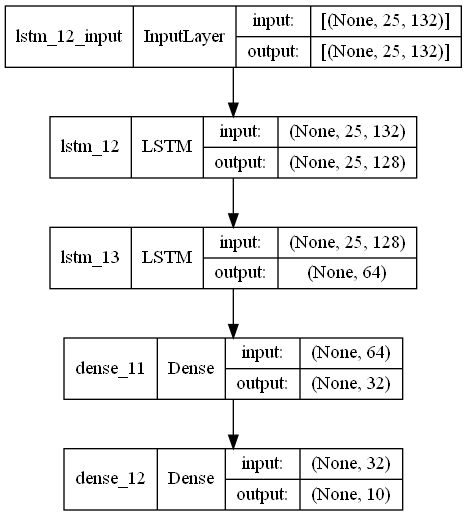

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e400_b6, to_file = "arc_lstm2_dense2_rd2_lr5_e400_b6_1350_18032022.png", show_shapes = True)

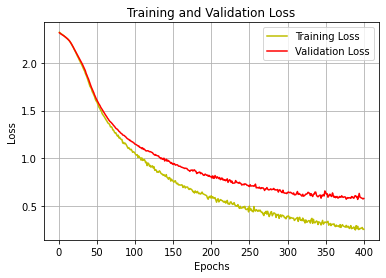

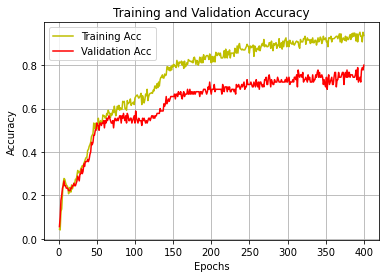

In [353]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [354]:
res = lstm2_dense2_rd2_lr5_e400_b6.predict(X_test)

In [355]:
yhat = lstm2_dense2_rd2_lr5_e400_b6.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [356]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[2 3 3 0 0 0 0 0 0 1]
 [2 7 0 0 0 0 0 0 0 0]
 [4 1 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 1 1 0 6 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 1 0 0 8]]


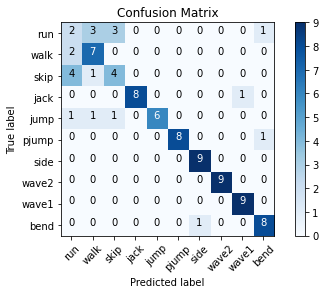

In [357]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [358]:
y_pred = lstm2_dense2_rd2_lr5_e400_b6.predict(X_test)
y_pred = (y_pred > 0.5)

In [359]:
_, acc = lstm2_dense2_rd2_lr5_e400_b6.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 22ms/step - loss: 0.5973 - categorical_accuracy: 0.7778
Accuracy =  77.77777910232544  %


In [360]:
accuracy_score(ytrue, yhat)

0.7777777777777778

In [361]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.22      0.22      0.22         9
        walk       0.58      0.78      0.67         9
        skip       0.50      0.44      0.47         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      0.89      0.94         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.80      0.89      0.84         9

    accuracy                           0.78        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.79      0.78      0.78        90



# lstm2_dense2_rd2_lr5_e500_b10
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=500 + recurrent_dropout=0.2 + lr=0.00001 + batch=10 -> vairly good curve, bad

In [362]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e500_b10 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [363]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e500_b10.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [364]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e500_b10.fit(X_train, y_train, batch_size=10, epochs=500, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/500
27/27 - 12s - loss: 2.3255 - categorical_accuracy: 0.1074 - val_loss: 2.3165 - val_categorical_accuracy: 0.1111 - 12s/epoch - 453ms/step
Epoch 2/500
27/27 - 2s - loss: 2.3198 - categorical_accuracy: 0.1074 - val_loss: 2.3100 - val_categorical_accuracy: 0.1111 - 2s/epoch - 69ms/step
Epoch 3/500
27/27 - 2s - loss: 2.3140 - categorical_accuracy: 0.1074 - val_loss: 2.3040 - val_categorical_accuracy: 0.1222 - 2s/epoch - 70ms/step
Epoch 4/500
27/27 - 2s - loss: 2.3088 - categorical_accuracy: 0.1111 - val_loss: 2.2982 - val_categorical_accuracy: 0.1222 - 2s/epoch - 68ms/step
Epoch 5/500
27/27 - 2s - loss: 2.3010 - categorical_accuracy: 0.1111 - val_loss: 2.2927 - val_categorical_accuracy: 0.1222 - 2s/epoch - 69ms/step
Epoch 6/500
27/27 - 2s - loss: 2.2963 - categorical_accuracy: 0.1296 - val_loss: 2.2874 - val_categorical_accuracy: 0.1222 - 2s/epoch - 68ms/step
Epoch 7/500
27/27 - 2s - loss: 2.2901 - categorical_accuracy: 0.1222 - val_loss: 2.2825 - val_categorical_accuracy: 0.122

Epoch 57/500
27/27 - 2s - loss: 1.4916 - categorical_accuracy: 0.5074 - val_loss: 1.4821 - val_categorical_accuracy: 0.4889 - 2s/epoch - 67ms/step
Epoch 58/500
27/27 - 2s - loss: 1.4765 - categorical_accuracy: 0.4963 - val_loss: 1.4723 - val_categorical_accuracy: 0.4667 - 2s/epoch - 67ms/step
Epoch 59/500
27/27 - 2s - loss: 1.4572 - categorical_accuracy: 0.5185 - val_loss: 1.4542 - val_categorical_accuracy: 0.5000 - 2s/epoch - 67ms/step
Epoch 60/500
27/27 - 2s - loss: 1.4418 - categorical_accuracy: 0.5148 - val_loss: 1.4510 - val_categorical_accuracy: 0.4333 - 2s/epoch - 77ms/step
Epoch 61/500
27/27 - 2s - loss: 1.4191 - categorical_accuracy: 0.5148 - val_loss: 1.4271 - val_categorical_accuracy: 0.5222 - 2s/epoch - 71ms/step
Epoch 62/500
27/27 - 2s - loss: 1.4148 - categorical_accuracy: 0.5185 - val_loss: 1.4296 - val_categorical_accuracy: 0.4333 - 2s/epoch - 72ms/step
Epoch 63/500
27/27 - 2s - loss: 1.4086 - categorical_accuracy: 0.5111 - val_loss: 1.4016 - val_categorical_accuracy: 0

Epoch 113/500
27/27 - 2s - loss: 0.9737 - categorical_accuracy: 0.6963 - val_loss: 1.0049 - val_categorical_accuracy: 0.6667 - 2s/epoch - 71ms/step
Epoch 114/500
27/27 - 2s - loss: 0.9804 - categorical_accuracy: 0.6889 - val_loss: 0.9997 - val_categorical_accuracy: 0.7000 - 2s/epoch - 67ms/step
Epoch 115/500
27/27 - 2s - loss: 0.9564 - categorical_accuracy: 0.7333 - val_loss: 1.0011 - val_categorical_accuracy: 0.6667 - 2s/epoch - 67ms/step
Epoch 116/500
27/27 - 2s - loss: 0.9432 - categorical_accuracy: 0.7148 - val_loss: 0.9854 - val_categorical_accuracy: 0.7000 - 2s/epoch - 68ms/step
Epoch 117/500
27/27 - 2s - loss: 0.9401 - categorical_accuracy: 0.7296 - val_loss: 0.9895 - val_categorical_accuracy: 0.6556 - 2s/epoch - 68ms/step
Epoch 118/500
27/27 - 2s - loss: 0.9576 - categorical_accuracy: 0.7185 - val_loss: 0.9805 - val_categorical_accuracy: 0.7111 - 2s/epoch - 67ms/step
Epoch 119/500
27/27 - 2s - loss: 0.9411 - categorical_accuracy: 0.7333 - val_loss: 0.9873 - val_categorical_accu

Epoch 169/500
27/27 - 2s - loss: 0.7403 - categorical_accuracy: 0.7889 - val_loss: 0.8062 - val_categorical_accuracy: 0.7111 - 2s/epoch - 69ms/step
Epoch 170/500
27/27 - 2s - loss: 0.7104 - categorical_accuracy: 0.8185 - val_loss: 0.7944 - val_categorical_accuracy: 0.7111 - 2s/epoch - 70ms/step
Epoch 171/500
27/27 - 2s - loss: 0.7279 - categorical_accuracy: 0.7926 - val_loss: 0.8023 - val_categorical_accuracy: 0.6667 - 2s/epoch - 68ms/step
Epoch 172/500
27/27 - 2s - loss: 0.7237 - categorical_accuracy: 0.8074 - val_loss: 0.7976 - val_categorical_accuracy: 0.6889 - 2s/epoch - 69ms/step
Epoch 173/500
27/27 - 2s - loss: 0.7117 - categorical_accuracy: 0.8111 - val_loss: 0.7825 - val_categorical_accuracy: 0.7111 - 2s/epoch - 70ms/step
Epoch 174/500
27/27 - 2s - loss: 0.7202 - categorical_accuracy: 0.8000 - val_loss: 0.7808 - val_categorical_accuracy: 0.6889 - 2s/epoch - 68ms/step
Epoch 175/500
27/27 - 2s - loss: 0.6950 - categorical_accuracy: 0.8111 - val_loss: 0.7954 - val_categorical_accu

Epoch 225/500
27/27 - 2s - loss: 0.5665 - categorical_accuracy: 0.8630 - val_loss: 0.6843 - val_categorical_accuracy: 0.7111 - 2s/epoch - 66ms/step
Epoch 226/500
27/27 - 2s - loss: 0.5737 - categorical_accuracy: 0.8556 - val_loss: 0.6957 - val_categorical_accuracy: 0.7111 - 2s/epoch - 65ms/step
Epoch 227/500
27/27 - 2s - loss: 0.5711 - categorical_accuracy: 0.8407 - val_loss: 0.6942 - val_categorical_accuracy: 0.7222 - 2s/epoch - 66ms/step
Epoch 228/500
27/27 - 2s - loss: 0.5870 - categorical_accuracy: 0.8370 - val_loss: 0.6800 - val_categorical_accuracy: 0.7333 - 2s/epoch - 66ms/step
Epoch 229/500
27/27 - 2s - loss: 0.5532 - categorical_accuracy: 0.8667 - val_loss: 0.6892 - val_categorical_accuracy: 0.7111 - 2s/epoch - 66ms/step
Epoch 230/500
27/27 - 2s - loss: 0.5535 - categorical_accuracy: 0.8630 - val_loss: 0.6689 - val_categorical_accuracy: 0.7111 - 2s/epoch - 64ms/step
Epoch 231/500
27/27 - 2s - loss: 0.5435 - categorical_accuracy: 0.8704 - val_loss: 0.6800 - val_categorical_accu

Epoch 281/500
27/27 - 2s - loss: 0.4575 - categorical_accuracy: 0.8926 - val_loss: 0.6314 - val_categorical_accuracy: 0.7444 - 2s/epoch - 66ms/step
Epoch 282/500
27/27 - 2s - loss: 0.4594 - categorical_accuracy: 0.8889 - val_loss: 0.6356 - val_categorical_accuracy: 0.7333 - 2s/epoch - 65ms/step
Epoch 283/500
27/27 - 2s - loss: 0.4669 - categorical_accuracy: 0.8667 - val_loss: 0.6257 - val_categorical_accuracy: 0.7333 - 2s/epoch - 66ms/step
Epoch 284/500
27/27 - 2s - loss: 0.4634 - categorical_accuracy: 0.8815 - val_loss: 0.6107 - val_categorical_accuracy: 0.7444 - 2s/epoch - 66ms/step
Epoch 285/500
27/27 - 2s - loss: 0.4720 - categorical_accuracy: 0.8741 - val_loss: 0.6301 - val_categorical_accuracy: 0.7667 - 2s/epoch - 66ms/step
Epoch 286/500
27/27 - 2s - loss: 0.4426 - categorical_accuracy: 0.8963 - val_loss: 0.6222 - val_categorical_accuracy: 0.7444 - 2s/epoch - 67ms/step
Epoch 287/500
27/27 - 2s - loss: 0.4547 - categorical_accuracy: 0.8852 - val_loss: 0.6258 - val_categorical_accu

Epoch 337/500
27/27 - 2s - loss: 0.3980 - categorical_accuracy: 0.8889 - val_loss: 0.6183 - val_categorical_accuracy: 0.7556 - 2s/epoch - 68ms/step
Epoch 338/500
27/27 - 2s - loss: 0.4072 - categorical_accuracy: 0.8852 - val_loss: 0.5983 - val_categorical_accuracy: 0.7444 - 2s/epoch - 66ms/step
Epoch 339/500
27/27 - 2s - loss: 0.3853 - categorical_accuracy: 0.9037 - val_loss: 0.5895 - val_categorical_accuracy: 0.7444 - 2s/epoch - 66ms/step
Epoch 340/500
27/27 - 2s - loss: 0.3958 - categorical_accuracy: 0.8926 - val_loss: 0.6079 - val_categorical_accuracy: 0.7444 - 2s/epoch - 65ms/step
Epoch 341/500
27/27 - 2s - loss: 0.4026 - categorical_accuracy: 0.8741 - val_loss: 0.5941 - val_categorical_accuracy: 0.7444 - 2s/epoch - 65ms/step
Epoch 342/500
27/27 - 2s - loss: 0.3772 - categorical_accuracy: 0.9037 - val_loss: 0.5915 - val_categorical_accuracy: 0.7556 - 2s/epoch - 69ms/step
Epoch 343/500
27/27 - 2s - loss: 0.4011 - categorical_accuracy: 0.8889 - val_loss: 0.5847 - val_categorical_accu

Epoch 393/500
27/27 - 2s - loss: 0.3324 - categorical_accuracy: 0.8963 - val_loss: 0.5763 - val_categorical_accuracy: 0.7556 - 2s/epoch - 65ms/step
Epoch 394/500
27/27 - 2s - loss: 0.3385 - categorical_accuracy: 0.9148 - val_loss: 0.5915 - val_categorical_accuracy: 0.7556 - 2s/epoch - 65ms/step
Epoch 395/500
27/27 - 2s - loss: 0.3408 - categorical_accuracy: 0.9037 - val_loss: 0.5958 - val_categorical_accuracy: 0.7444 - 2s/epoch - 65ms/step
Epoch 396/500
27/27 - 2s - loss: 0.3205 - categorical_accuracy: 0.9259 - val_loss: 0.5856 - val_categorical_accuracy: 0.7667 - 2s/epoch - 65ms/step
Epoch 397/500
27/27 - 2s - loss: 0.3278 - categorical_accuracy: 0.9074 - val_loss: 0.5880 - val_categorical_accuracy: 0.7556 - 2s/epoch - 65ms/step
Epoch 398/500
27/27 - 2s - loss: 0.3496 - categorical_accuracy: 0.9000 - val_loss: 0.5873 - val_categorical_accuracy: 0.7444 - 2s/epoch - 64ms/step
Epoch 399/500
27/27 - 2s - loss: 0.3637 - categorical_accuracy: 0.8778 - val_loss: 0.5777 - val_categorical_accu

Epoch 449/500
27/27 - 2s - loss: 0.2665 - categorical_accuracy: 0.9407 - val_loss: 0.5924 - val_categorical_accuracy: 0.7667 - 2s/epoch - 65ms/step
Epoch 450/500
27/27 - 2s - loss: 0.2975 - categorical_accuracy: 0.9111 - val_loss: 0.5844 - val_categorical_accuracy: 0.7444 - 2s/epoch - 64ms/step
Epoch 451/500
27/27 - 2s - loss: 0.2799 - categorical_accuracy: 0.9037 - val_loss: 0.5778 - val_categorical_accuracy: 0.7444 - 2s/epoch - 65ms/step
Epoch 452/500
27/27 - 2s - loss: 0.3091 - categorical_accuracy: 0.9074 - val_loss: 0.5661 - val_categorical_accuracy: 0.7667 - 2s/epoch - 65ms/step
Epoch 453/500
27/27 - 2s - loss: 0.2827 - categorical_accuracy: 0.9222 - val_loss: 0.5603 - val_categorical_accuracy: 0.7556 - 2s/epoch - 66ms/step
Epoch 454/500
27/27 - 2s - loss: 0.2946 - categorical_accuracy: 0.9074 - val_loss: 0.5525 - val_categorical_accuracy: 0.7667 - 2s/epoch - 64ms/step
Epoch 455/500
27/27 - 2s - loss: 0.3034 - categorical_accuracy: 0.9111 - val_loss: 0.5788 - val_categorical_accu

In [365]:
lstm2_dense2_rd2_lr5_e500_b10.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_53 (LSTM)              (None, 64)                49408     
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dense_52 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [366]:
# Save Model
lstm2_dense2_rd2_lr5_e500_b10.save("lstm2_dense2_rd2_lr5_e500_b10_1415_18032022.h5")

In [367]:
# Load Model
lstm2_dense2_rd2_lr5_e500_b10.load_weights("lstm2_dense2_rd2_lr5_e500_b10_1415_18032022.h5")

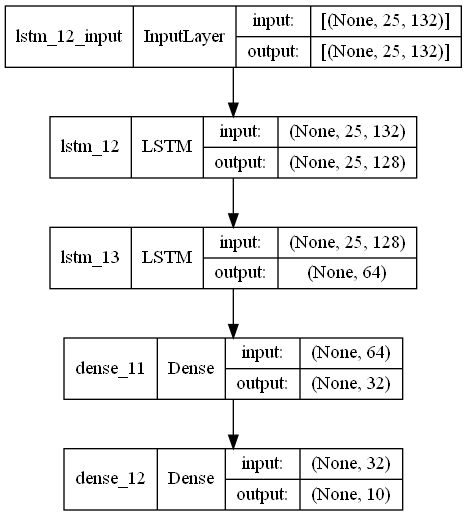

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e500_b10, to_file = "arc_lstm2_dense2_rd2_lr5_e500_b10_1415_18032022.png", show_shapes = True)

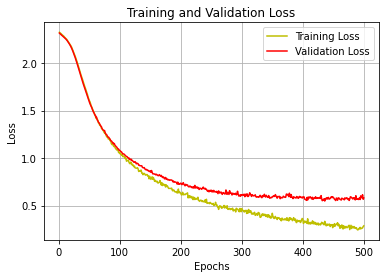

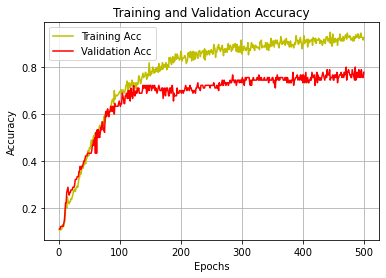

In [368]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [369]:
res = lstm2_dense2_rd2_lr5_e500_b10.predict(X_test)

In [370]:
yhat = lstm2_dense2_rd2_lr5_e500_b10.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [371]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 6 0 0 0 0 0 0 0 0]
 [1 6 1 0 1 0 0 0 0 0]
 [3 2 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [0 0 2 0 6 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 1]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 1 0 0 0 8]]


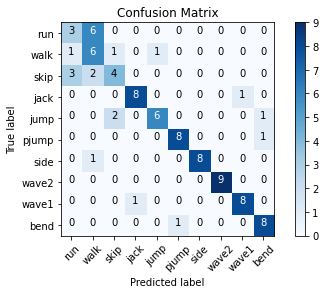

In [372]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [373]:
y_pred = lstm2_dense2_rd2_lr5_e500_b10.predict(X_test)
y_pred = (y_pred > 0.5)

In [374]:
_, acc = lstm2_dense2_rd2_lr5_e500_b10.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 1s 20ms/step - loss: 0.6429 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [375]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [376]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.33      0.38         9
        walk       0.40      0.67      0.50         9
        skip       0.57      0.44      0.50         9
        jack       0.89      0.89      0.89         9
        jump       0.86      0.67      0.75         9
       pjump       0.89      0.89      0.89         9
        side       1.00      0.89      0.94         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.80      0.89      0.84         9

    accuracy                           0.76        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.77      0.76      0.76        90



# lstm2_dense2_rd2_lr5_e600_b12
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=600 + recurrent_dropout=0.2 + lr=0.00001 + batch=12 -> need more epochs, maybe

In [377]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e600_b12 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [378]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e600_b12.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [379]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e600_b12.fit(X_train, y_train, batch_size=12, epochs=600, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/600
23/23 - 18s - loss: 2.3057 - categorical_accuracy: 0.0852 - val_loss: 2.3053 - val_categorical_accuracy: 0.1111 - 18s/epoch - 775ms/step
Epoch 2/600
23/23 - 2s - loss: 2.2983 - categorical_accuracy: 0.1037 - val_loss: 2.3002 - val_categorical_accuracy: 0.1222 - 2s/epoch - 91ms/step
Epoch 3/600
23/23 - 2s - loss: 2.2936 - categorical_accuracy: 0.1259 - val_loss: 2.2956 - val_categorical_accuracy: 0.1111 - 2s/epoch - 93ms/step
Epoch 4/600
23/23 - 3s - loss: 2.2902 - categorical_accuracy: 0.1111 - val_loss: 2.2907 - val_categorical_accuracy: 0.1222 - 3s/epoch - 118ms/step
Epoch 5/600
23/23 - 2s - loss: 2.2821 - categorical_accuracy: 0.1556 - val_loss: 2.2867 - val_categorical_accuracy: 0.1333 - 2s/epoch - 89ms/step
Epoch 6/600
23/23 - 2s - loss: 2.2783 - categorical_accuracy: 0.1481 - val_loss: 2.2829 - val_categorical_accuracy: 0.1556 - 2s/epoch - 100ms/step
Epoch 7/600
23/23 - 2s - loss: 2.2750 - categorical_accuracy: 0.1593 - val_loss: 2.2794 - val_categorical_accuracy: 0.1

Epoch 57/600
23/23 - 2s - loss: 1.6438 - categorical_accuracy: 0.5074 - val_loss: 1.6642 - val_categorical_accuracy: 0.4556 - 2s/epoch - 78ms/step
Epoch 58/600
23/23 - 2s - loss: 1.6358 - categorical_accuracy: 0.5185 - val_loss: 1.6471 - val_categorical_accuracy: 0.4667 - 2s/epoch - 79ms/step
Epoch 59/600
23/23 - 2s - loss: 1.6103 - categorical_accuracy: 0.5481 - val_loss: 1.6331 - val_categorical_accuracy: 0.4778 - 2s/epoch - 80ms/step
Epoch 60/600
23/23 - 2s - loss: 1.5986 - categorical_accuracy: 0.5444 - val_loss: 1.6191 - val_categorical_accuracy: 0.4778 - 2s/epoch - 78ms/step
Epoch 61/600
23/23 - 2s - loss: 1.5731 - categorical_accuracy: 0.5667 - val_loss: 1.6024 - val_categorical_accuracy: 0.4889 - 2s/epoch - 79ms/step
Epoch 62/600
23/23 - 2s - loss: 1.5661 - categorical_accuracy: 0.5370 - val_loss: 1.5860 - val_categorical_accuracy: 0.4889 - 2s/epoch - 87ms/step
Epoch 63/600
23/23 - 2s - loss: 1.5576 - categorical_accuracy: 0.5444 - val_loss: 1.5740 - val_categorical_accuracy: 0

Epoch 113/600
23/23 - 2s - loss: 1.0706 - categorical_accuracy: 0.6630 - val_loss: 1.1391 - val_categorical_accuracy: 0.6000 - 2s/epoch - 79ms/step
Epoch 114/600
23/23 - 2s - loss: 1.0574 - categorical_accuracy: 0.6926 - val_loss: 1.1299 - val_categorical_accuracy: 0.5667 - 2s/epoch - 79ms/step
Epoch 115/600
23/23 - 2s - loss: 1.0682 - categorical_accuracy: 0.6889 - val_loss: 1.1223 - val_categorical_accuracy: 0.5667 - 2s/epoch - 78ms/step
Epoch 116/600
23/23 - 2s - loss: 1.0539 - categorical_accuracy: 0.6889 - val_loss: 1.1321 - val_categorical_accuracy: 0.5778 - 2s/epoch - 79ms/step
Epoch 117/600
23/23 - 2s - loss: 1.0470 - categorical_accuracy: 0.6889 - val_loss: 1.1220 - val_categorical_accuracy: 0.5667 - 2s/epoch - 78ms/step
Epoch 118/600
23/23 - 2s - loss: 1.0406 - categorical_accuracy: 0.7111 - val_loss: 1.1097 - val_categorical_accuracy: 0.5778 - 2s/epoch - 78ms/step
Epoch 119/600
23/23 - 2s - loss: 1.0382 - categorical_accuracy: 0.6704 - val_loss: 1.1038 - val_categorical_accu

Epoch 169/600
23/23 - 2s - loss: 0.8176 - categorical_accuracy: 0.7630 - val_loss: 0.9327 - val_categorical_accuracy: 0.6556 - 2s/epoch - 80ms/step
Epoch 170/600
23/23 - 2s - loss: 0.7908 - categorical_accuracy: 0.7370 - val_loss: 0.9244 - val_categorical_accuracy: 0.6556 - 2s/epoch - 78ms/step
Epoch 171/600
23/23 - 2s - loss: 0.8071 - categorical_accuracy: 0.7556 - val_loss: 0.9274 - val_categorical_accuracy: 0.6333 - 2s/epoch - 84ms/step
Epoch 172/600
23/23 - 2s - loss: 0.7726 - categorical_accuracy: 0.7889 - val_loss: 0.9292 - val_categorical_accuracy: 0.6333 - 2s/epoch - 79ms/step
Epoch 173/600
23/23 - 2s - loss: 0.7959 - categorical_accuracy: 0.7704 - val_loss: 0.9194 - val_categorical_accuracy: 0.6444 - 2s/epoch - 77ms/step
Epoch 174/600
23/23 - 2s - loss: 0.7731 - categorical_accuracy: 0.7704 - val_loss: 0.9126 - val_categorical_accuracy: 0.6333 - 2s/epoch - 77ms/step
Epoch 175/600
23/23 - 2s - loss: 0.7726 - categorical_accuracy: 0.7815 - val_loss: 0.9062 - val_categorical_accu

Epoch 225/600
23/23 - 2s - loss: 0.6462 - categorical_accuracy: 0.8370 - val_loss: 0.8183 - val_categorical_accuracy: 0.6667 - 2s/epoch - 83ms/step
Epoch 226/600
23/23 - 2s - loss: 0.6244 - categorical_accuracy: 0.8111 - val_loss: 0.8098 - val_categorical_accuracy: 0.6444 - 2s/epoch - 102ms/step
Epoch 227/600
23/23 - 2s - loss: 0.6242 - categorical_accuracy: 0.8185 - val_loss: 0.8013 - val_categorical_accuracy: 0.6667 - 2s/epoch - 91ms/step
Epoch 228/600
23/23 - 2s - loss: 0.6130 - categorical_accuracy: 0.8185 - val_loss: 0.7921 - val_categorical_accuracy: 0.6444 - 2s/epoch - 104ms/step
Epoch 229/600
23/23 - 2s - loss: 0.6095 - categorical_accuracy: 0.8296 - val_loss: 0.8019 - val_categorical_accuracy: 0.6667 - 2s/epoch - 96ms/step
Epoch 230/600
23/23 - 3s - loss: 0.6076 - categorical_accuracy: 0.8444 - val_loss: 0.8093 - val_categorical_accuracy: 0.6556 - 3s/epoch - 113ms/step
Epoch 231/600
23/23 - 2s - loss: 0.5972 - categorical_accuracy: 0.8481 - val_loss: 0.7984 - val_categorical_a

Epoch 281/600
23/23 - 2s - loss: 0.5179 - categorical_accuracy: 0.8667 - val_loss: 0.7624 - val_categorical_accuracy: 0.6667 - 2s/epoch - 77ms/step
Epoch 282/600
23/23 - 2s - loss: 0.5026 - categorical_accuracy: 0.8815 - val_loss: 0.7581 - val_categorical_accuracy: 0.6667 - 2s/epoch - 82ms/step
Epoch 283/600
23/23 - 2s - loss: 0.5279 - categorical_accuracy: 0.8444 - val_loss: 0.7779 - val_categorical_accuracy: 0.6778 - 2s/epoch - 80ms/step
Epoch 284/600
23/23 - 2s - loss: 0.5219 - categorical_accuracy: 0.8333 - val_loss: 0.7686 - val_categorical_accuracy: 0.6556 - 2s/epoch - 78ms/step
Epoch 285/600
23/23 - 2s - loss: 0.4917 - categorical_accuracy: 0.8556 - val_loss: 0.7571 - val_categorical_accuracy: 0.6778 - 2s/epoch - 79ms/step
Epoch 286/600
23/23 - 2s - loss: 0.5084 - categorical_accuracy: 0.8704 - val_loss: 0.7610 - val_categorical_accuracy: 0.6778 - 2s/epoch - 79ms/step
Epoch 287/600
23/23 - 2s - loss: 0.5301 - categorical_accuracy: 0.8444 - val_loss: 0.7708 - val_categorical_accu

Epoch 337/600
23/23 - 2s - loss: 0.4264 - categorical_accuracy: 0.8889 - val_loss: 0.7206 - val_categorical_accuracy: 0.6667 - 2s/epoch - 76ms/step
Epoch 338/600
23/23 - 2s - loss: 0.4134 - categorical_accuracy: 0.9111 - val_loss: 0.7356 - val_categorical_accuracy: 0.6778 - 2s/epoch - 77ms/step
Epoch 339/600
23/23 - 2s - loss: 0.4255 - categorical_accuracy: 0.8963 - val_loss: 0.7306 - val_categorical_accuracy: 0.6778 - 2s/epoch - 77ms/step
Epoch 340/600
23/23 - 2s - loss: 0.4367 - categorical_accuracy: 0.8926 - val_loss: 0.7020 - val_categorical_accuracy: 0.6889 - 2s/epoch - 84ms/step
Epoch 341/600
23/23 - 2s - loss: 0.4199 - categorical_accuracy: 0.8815 - val_loss: 0.7208 - val_categorical_accuracy: 0.6889 - 2s/epoch - 82ms/step
Epoch 342/600
23/23 - 2s - loss: 0.4397 - categorical_accuracy: 0.8704 - val_loss: 0.7252 - val_categorical_accuracy: 0.6667 - 2s/epoch - 78ms/step
Epoch 343/600
23/23 - 2s - loss: 0.4314 - categorical_accuracy: 0.8815 - val_loss: 0.7256 - val_categorical_accu

Epoch 393/600
23/23 - 2s - loss: 0.3911 - categorical_accuracy: 0.8667 - val_loss: 0.6750 - val_categorical_accuracy: 0.7222 - 2s/epoch - 77ms/step
Epoch 394/600
23/23 - 2s - loss: 0.3484 - categorical_accuracy: 0.9296 - val_loss: 0.6798 - val_categorical_accuracy: 0.7444 - 2s/epoch - 82ms/step
Epoch 395/600
23/23 - 2s - loss: 0.3795 - categorical_accuracy: 0.8815 - val_loss: 0.6801 - val_categorical_accuracy: 0.6889 - 2s/epoch - 85ms/step
Epoch 396/600
23/23 - 2s - loss: 0.3776 - categorical_accuracy: 0.9111 - val_loss: 0.6683 - val_categorical_accuracy: 0.7333 - 2s/epoch - 90ms/step
Epoch 397/600
23/23 - 2s - loss: 0.3766 - categorical_accuracy: 0.9111 - val_loss: 0.6833 - val_categorical_accuracy: 0.7000 - 2s/epoch - 90ms/step
Epoch 398/600
23/23 - 2s - loss: 0.3788 - categorical_accuracy: 0.9000 - val_loss: 0.6893 - val_categorical_accuracy: 0.7222 - 2s/epoch - 95ms/step
Epoch 399/600
23/23 - 2s - loss: 0.3679 - categorical_accuracy: 0.8926 - val_loss: 0.6988 - val_categorical_accu

Epoch 449/600
23/23 - 2s - loss: 0.3217 - categorical_accuracy: 0.9148 - val_loss: 0.6756 - val_categorical_accuracy: 0.7111 - 2s/epoch - 80ms/step
Epoch 450/600
23/23 - 2s - loss: 0.3262 - categorical_accuracy: 0.9296 - val_loss: 0.6712 - val_categorical_accuracy: 0.7111 - 2s/epoch - 83ms/step
Epoch 451/600
23/23 - 2s - loss: 0.3056 - categorical_accuracy: 0.9296 - val_loss: 0.6934 - val_categorical_accuracy: 0.6667 - 2s/epoch - 84ms/step
Epoch 452/600
23/23 - 2s - loss: 0.3342 - categorical_accuracy: 0.9111 - val_loss: 0.6769 - val_categorical_accuracy: 0.7000 - 2s/epoch - 80ms/step
Epoch 453/600
23/23 - 2s - loss: 0.3386 - categorical_accuracy: 0.9000 - val_loss: 0.6716 - val_categorical_accuracy: 0.6889 - 2s/epoch - 79ms/step
Epoch 454/600
23/23 - 2s - loss: 0.3090 - categorical_accuracy: 0.9296 - val_loss: 0.6637 - val_categorical_accuracy: 0.7111 - 2s/epoch - 82ms/step
Epoch 455/600
23/23 - 2s - loss: 0.3446 - categorical_accuracy: 0.9000 - val_loss: 0.6698 - val_categorical_accu

Epoch 505/600
23/23 - 2s - loss: 0.2994 - categorical_accuracy: 0.9222 - val_loss: 0.6986 - val_categorical_accuracy: 0.6778 - 2s/epoch - 79ms/step
Epoch 506/600
23/23 - 2s - loss: 0.2869 - categorical_accuracy: 0.9259 - val_loss: 0.6544 - val_categorical_accuracy: 0.7222 - 2s/epoch - 77ms/step
Epoch 507/600
23/23 - 2s - loss: 0.2678 - categorical_accuracy: 0.9407 - val_loss: 0.6396 - val_categorical_accuracy: 0.7222 - 2s/epoch - 78ms/step
Epoch 508/600
23/23 - 2s - loss: 0.2849 - categorical_accuracy: 0.9259 - val_loss: 0.6569 - val_categorical_accuracy: 0.7222 - 2s/epoch - 81ms/step
Epoch 509/600
23/23 - 2s - loss: 0.2966 - categorical_accuracy: 0.9111 - val_loss: 0.6761 - val_categorical_accuracy: 0.7111 - 2s/epoch - 93ms/step
Epoch 510/600
23/23 - 2s - loss: 0.2947 - categorical_accuracy: 0.9259 - val_loss: 0.6680 - val_categorical_accuracy: 0.7222 - 2s/epoch - 84ms/step
Epoch 511/600
23/23 - 2s - loss: 0.2697 - categorical_accuracy: 0.9259 - val_loss: 0.6605 - val_categorical_accu

Epoch 561/600
23/23 - 2s - loss: 0.2469 - categorical_accuracy: 0.9296 - val_loss: 0.6618 - val_categorical_accuracy: 0.7222 - 2s/epoch - 80ms/step
Epoch 562/600
23/23 - 2s - loss: 0.2752 - categorical_accuracy: 0.9222 - val_loss: 0.6708 - val_categorical_accuracy: 0.7111 - 2s/epoch - 81ms/step
Epoch 563/600
23/23 - 2s - loss: 0.2422 - categorical_accuracy: 0.9259 - val_loss: 0.6649 - val_categorical_accuracy: 0.7333 - 2s/epoch - 80ms/step
Epoch 564/600
23/23 - 2s - loss: 0.2584 - categorical_accuracy: 0.9370 - val_loss: 0.6632 - val_categorical_accuracy: 0.7111 - 2s/epoch - 78ms/step
Epoch 565/600
23/23 - 2s - loss: 0.2532 - categorical_accuracy: 0.9481 - val_loss: 0.6629 - val_categorical_accuracy: 0.7222 - 2s/epoch - 79ms/step
Epoch 566/600
23/23 - 2s - loss: 0.2444 - categorical_accuracy: 0.9370 - val_loss: 0.6690 - val_categorical_accuracy: 0.7333 - 2s/epoch - 83ms/step
Epoch 567/600
23/23 - 2s - loss: 0.2490 - categorical_accuracy: 0.9333 - val_loss: 0.6591 - val_categorical_accu

In [380]:
lstm2_dense2_rd2_lr5_e600_b12.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_55 (LSTM)              (None, 64)                49408     
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dense_54 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [381]:
# Save Model
lstm2_dense2_rd2_lr5_e600_b12.save("lstm2_dense2_rd2_lr5_e600_b12_1454_18032022.h5")

In [382]:
# Load Model
lstm2_dense2_rd2_lr5_e600_b12.load_weights("lstm2_dense2_rd2_lr5_e600_b12_1454_18032022.h5")

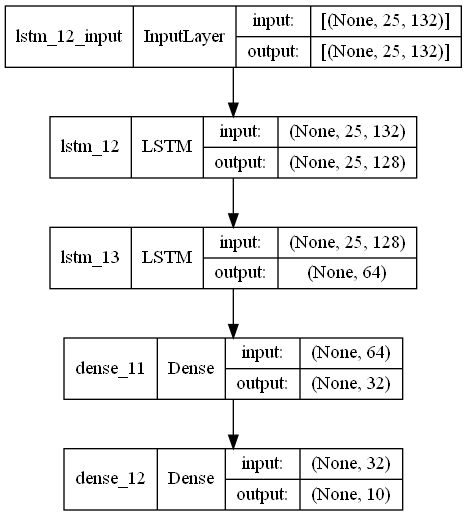

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e600_b12, to_file = "arc_lstm2_dense2_rd2_lr5_e600_b12_1454_18032022.png", show_shapes = True)

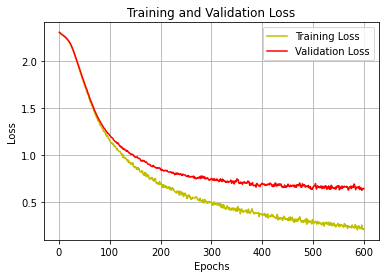

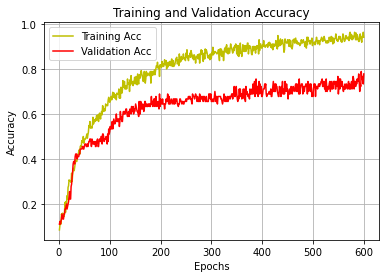

In [383]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [384]:
res = lstm2_dense2_rd2_lr5_e600_b12.predict(X_test)

In [385]:
yhat = lstm2_dense2_rd2_lr5_e600_b12.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [386]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 4 2 0 0 0 0 0 0 0]
 [3 4 2 0 0 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [0 0 1 0 7 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 1 0 0 8 0]
 [0 0 0 0 0 0 1 0 0 8]]


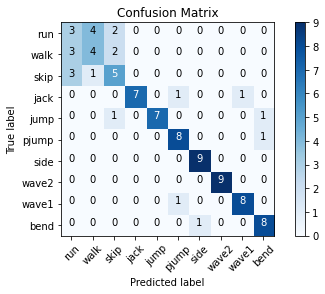

In [387]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [388]:
y_pred = lstm2_dense2_rd2_lr5_e600_b12.predict(X_test)
y_pred = (y_pred > 0.5)

In [389]:
_, acc = lstm2_dense2_rd2_lr5_e600_b12.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 20ms/step - loss: 0.6172 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [390]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [391]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.33      0.33      0.33         9
        walk       0.44      0.44      0.44         9
        skip       0.50      0.56      0.53         9
        jack       1.00      0.78      0.88         9
        jump       1.00      0.78      0.88         9
       pjump       0.80      0.89      0.84         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.80      0.89      0.84         9

    accuracy                           0.76        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.77      0.76      0.76        90



# lstm2_dense2_rd2_lr5_e1k_b16
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=1000 + recurrent_dropout=0.2 + lr=0.00001 + batch=16 -> vairly good curve, good diverse
#### candidate

In [392]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e1k_b16 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [393]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e1k_b16.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [394]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e1k_b16.fit(X_train, y_train, batch_size=16, epochs=1000, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/1000
17/17 - 77s - loss: 2.3079 - categorical_accuracy: 0.1111 - val_loss: 2.3079 - val_categorical_accuracy: 0.1000 - 77s/epoch - 5s/step
Epoch 2/1000
17/17 - 2s - loss: 2.3021 - categorical_accuracy: 0.1074 - val_loss: 2.3034 - val_categorical_accuracy: 0.1000 - 2s/epoch - 91ms/step
Epoch 3/1000
17/17 - 1s - loss: 2.2985 - categorical_accuracy: 0.1111 - val_loss: 2.2994 - val_categorical_accuracy: 0.1000 - 1s/epoch - 88ms/step
Epoch 4/1000
17/17 - 1s - loss: 2.2935 - categorical_accuracy: 0.1037 - val_loss: 2.2962 - val_categorical_accuracy: 0.1000 - 1s/epoch - 88ms/step
Epoch 5/1000
17/17 - 2s - loss: 2.2894 - categorical_accuracy: 0.1111 - val_loss: 2.2934 - val_categorical_accuracy: 0.1000 - 2s/epoch - 89ms/step
Epoch 6/1000
17/17 - 2s - loss: 2.2851 - categorical_accuracy: 0.1148 - val_loss: 2.2905 - val_categorical_accuracy: 0.1000 - 2s/epoch - 89ms/step
Epoch 7/1000
17/17 - 1s - loss: 2.2805 - categorical_accuracy: 0.1037 - val_loss: 2.2875 - val_categorical_accuracy: 0

Epoch 57/1000
17/17 - 2s - loss: 1.8534 - categorical_accuracy: 0.3444 - val_loss: 1.8770 - val_categorical_accuracy: 0.3778 - 2s/epoch - 91ms/step
Epoch 58/1000
17/17 - 2s - loss: 1.8397 - categorical_accuracy: 0.3593 - val_loss: 1.8687 - val_categorical_accuracy: 0.3778 - 2s/epoch - 92ms/step
Epoch 59/1000
17/17 - 2s - loss: 1.8308 - categorical_accuracy: 0.3704 - val_loss: 1.8604 - val_categorical_accuracy: 0.3778 - 2s/epoch - 88ms/step
Epoch 60/1000
17/17 - 1s - loss: 1.8258 - categorical_accuracy: 0.3444 - val_loss: 1.8528 - val_categorical_accuracy: 0.3778 - 1s/epoch - 87ms/step
Epoch 61/1000
17/17 - 2s - loss: 1.8155 - categorical_accuracy: 0.3704 - val_loss: 1.8463 - val_categorical_accuracy: 0.3667 - 2s/epoch - 90ms/step
Epoch 62/1000
17/17 - 1s - loss: 1.8036 - categorical_accuracy: 0.3630 - val_loss: 1.8373 - val_categorical_accuracy: 0.3778 - 1s/epoch - 85ms/step
Epoch 63/1000
17/17 - 1s - loss: 1.7955 - categorical_accuracy: 0.3593 - val_loss: 1.8274 - val_categorical_accu

Epoch 113/1000
17/17 - 1s - loss: 1.3498 - categorical_accuracy: 0.6037 - val_loss: 1.3988 - val_categorical_accuracy: 0.5333 - 1s/epoch - 86ms/step
Epoch 114/1000
17/17 - 1s - loss: 1.3575 - categorical_accuracy: 0.6148 - val_loss: 1.3910 - val_categorical_accuracy: 0.5222 - 1s/epoch - 88ms/step
Epoch 115/1000
17/17 - 1s - loss: 1.3430 - categorical_accuracy: 0.6333 - val_loss: 1.3828 - val_categorical_accuracy: 0.5333 - 1s/epoch - 86ms/step
Epoch 116/1000
17/17 - 1s - loss: 1.3205 - categorical_accuracy: 0.6333 - val_loss: 1.3745 - val_categorical_accuracy: 0.5222 - 1s/epoch - 87ms/step
Epoch 117/1000
17/17 - 2s - loss: 1.3093 - categorical_accuracy: 0.6370 - val_loss: 1.3706 - val_categorical_accuracy: 0.5333 - 2s/epoch - 89ms/step
Epoch 118/1000
17/17 - 2s - loss: 1.3007 - categorical_accuracy: 0.6222 - val_loss: 1.3555 - val_categorical_accuracy: 0.5222 - 2s/epoch - 96ms/step
Epoch 119/1000
17/17 - 2s - loss: 1.2806 - categorical_accuracy: 0.6444 - val_loss: 1.3503 - val_categoric

Epoch 168/1000
17/17 - 1s - loss: 0.9635 - categorical_accuracy: 0.7148 - val_loss: 1.0796 - val_categorical_accuracy: 0.5667 - 1s/epoch - 87ms/step
Epoch 169/1000
17/17 - 2s - loss: 0.9821 - categorical_accuracy: 0.7000 - val_loss: 1.0756 - val_categorical_accuracy: 0.5111 - 2s/epoch - 89ms/step
Epoch 170/1000
17/17 - 2s - loss: 0.9563 - categorical_accuracy: 0.7111 - val_loss: 1.0738 - val_categorical_accuracy: 0.5444 - 2s/epoch - 88ms/step
Epoch 171/1000
17/17 - 2s - loss: 0.9609 - categorical_accuracy: 0.6889 - val_loss: 1.0762 - val_categorical_accuracy: 0.5556 - 2s/epoch - 90ms/step
Epoch 172/1000
17/17 - 1s - loss: 0.9619 - categorical_accuracy: 0.6963 - val_loss: 1.0679 - val_categorical_accuracy: 0.5333 - 1s/epoch - 85ms/step
Epoch 173/1000
17/17 - 1s - loss: 0.9499 - categorical_accuracy: 0.7111 - val_loss: 1.0565 - val_categorical_accuracy: 0.5667 - 1s/epoch - 88ms/step
Epoch 174/1000
17/17 - 1s - loss: 0.9513 - categorical_accuracy: 0.7037 - val_loss: 1.0535 - val_categoric

Epoch 223/1000
17/17 - 1s - loss: 0.8027 - categorical_accuracy: 0.7778 - val_loss: 0.9181 - val_categorical_accuracy: 0.6444 - 1s/epoch - 86ms/step
Epoch 224/1000
17/17 - 2s - loss: 0.7589 - categorical_accuracy: 0.7963 - val_loss: 0.9147 - val_categorical_accuracy: 0.6778 - 2s/epoch - 89ms/step
Epoch 225/1000
17/17 - 1s - loss: 0.7718 - categorical_accuracy: 0.7778 - val_loss: 0.9184 - val_categorical_accuracy: 0.6444 - 1s/epoch - 85ms/step
Epoch 226/1000
17/17 - 1s - loss: 0.7752 - categorical_accuracy: 0.8148 - val_loss: 0.9135 - val_categorical_accuracy: 0.6667 - 1s/epoch - 85ms/step
Epoch 227/1000
17/17 - 2s - loss: 0.7800 - categorical_accuracy: 0.8037 - val_loss: 0.9129 - val_categorical_accuracy: 0.6556 - 2s/epoch - 92ms/step
Epoch 228/1000
17/17 - 1s - loss: 0.7627 - categorical_accuracy: 0.7889 - val_loss: 0.9068 - val_categorical_accuracy: 0.6556 - 1s/epoch - 87ms/step
Epoch 229/1000
17/17 - 2s - loss: 0.7570 - categorical_accuracy: 0.8111 - val_loss: 0.9058 - val_categoric

Epoch 278/1000
17/17 - 1s - loss: 0.6386 - categorical_accuracy: 0.8333 - val_loss: 0.8217 - val_categorical_accuracy: 0.7000 - 1s/epoch - 86ms/step
Epoch 279/1000
17/17 - 2s - loss: 0.6558 - categorical_accuracy: 0.8185 - val_loss: 0.8147 - val_categorical_accuracy: 0.6889 - 2s/epoch - 89ms/step
Epoch 280/1000
17/17 - 1s - loss: 0.6647 - categorical_accuracy: 0.8370 - val_loss: 0.8187 - val_categorical_accuracy: 0.7000 - 1s/epoch - 87ms/step
Epoch 281/1000
17/17 - 1s - loss: 0.6474 - categorical_accuracy: 0.8222 - val_loss: 0.8182 - val_categorical_accuracy: 0.7000 - 1s/epoch - 86ms/step
Epoch 282/1000
17/17 - 1s - loss: 0.6488 - categorical_accuracy: 0.8222 - val_loss: 0.8116 - val_categorical_accuracy: 0.7000 - 1s/epoch - 87ms/step
Epoch 283/1000
17/17 - 2s - loss: 0.6530 - categorical_accuracy: 0.8185 - val_loss: 0.8209 - val_categorical_accuracy: 0.6778 - 2s/epoch - 89ms/step
Epoch 284/1000
17/17 - 1s - loss: 0.6484 - categorical_accuracy: 0.8222 - val_loss: 0.8187 - val_categoric

Epoch 333/1000
17/17 - 1s - loss: 0.5595 - categorical_accuracy: 0.8741 - val_loss: 0.7500 - val_categorical_accuracy: 0.7111 - 1s/epoch - 86ms/step
Epoch 334/1000
17/17 - 1s - loss: 0.5530 - categorical_accuracy: 0.8556 - val_loss: 0.7481 - val_categorical_accuracy: 0.7111 - 1s/epoch - 87ms/step
Epoch 335/1000
17/17 - 1s - loss: 0.5548 - categorical_accuracy: 0.8519 - val_loss: 0.7534 - val_categorical_accuracy: 0.7333 - 1s/epoch - 86ms/step
Epoch 336/1000
17/17 - 1s - loss: 0.5386 - categorical_accuracy: 0.8741 - val_loss: 0.7589 - val_categorical_accuracy: 0.7333 - 1s/epoch - 88ms/step
Epoch 337/1000
17/17 - 1s - loss: 0.5512 - categorical_accuracy: 0.8593 - val_loss: 0.7489 - val_categorical_accuracy: 0.7111 - 1s/epoch - 87ms/step
Epoch 338/1000
17/17 - 2s - loss: 0.5444 - categorical_accuracy: 0.8593 - val_loss: 0.7629 - val_categorical_accuracy: 0.7000 - 2s/epoch - 89ms/step
Epoch 339/1000
17/17 - 2s - loss: 0.5480 - categorical_accuracy: 0.8556 - val_loss: 0.7599 - val_categoric

Epoch 388/1000
17/17 - 1s - loss: 0.4912 - categorical_accuracy: 0.8815 - val_loss: 0.7111 - val_categorical_accuracy: 0.7444 - 1s/epoch - 86ms/step
Epoch 389/1000
17/17 - 2s - loss: 0.4989 - categorical_accuracy: 0.8556 - val_loss: 0.7002 - val_categorical_accuracy: 0.7222 - 2s/epoch - 91ms/step
Epoch 390/1000
17/17 - 1s - loss: 0.4765 - categorical_accuracy: 0.8852 - val_loss: 0.6980 - val_categorical_accuracy: 0.7333 - 1s/epoch - 86ms/step
Epoch 391/1000
17/17 - 1s - loss: 0.4782 - categorical_accuracy: 0.8704 - val_loss: 0.7082 - val_categorical_accuracy: 0.7444 - 1s/epoch - 87ms/step
Epoch 392/1000
17/17 - 1s - loss: 0.4695 - categorical_accuracy: 0.8778 - val_loss: 0.6982 - val_categorical_accuracy: 0.7111 - 1s/epoch - 86ms/step
Epoch 393/1000
17/17 - 2s - loss: 0.4690 - categorical_accuracy: 0.8852 - val_loss: 0.6961 - val_categorical_accuracy: 0.7333 - 2s/epoch - 89ms/step
Epoch 394/1000
17/17 - 2s - loss: 0.4968 - categorical_accuracy: 0.8407 - val_loss: 0.7176 - val_categoric

Epoch 443/1000
17/17 - 1s - loss: 0.4195 - categorical_accuracy: 0.8926 - val_loss: 0.6443 - val_categorical_accuracy: 0.7444 - 1s/epoch - 88ms/step
Epoch 444/1000
17/17 - 2s - loss: 0.4127 - categorical_accuracy: 0.9000 - val_loss: 0.6283 - val_categorical_accuracy: 0.7556 - 2s/epoch - 88ms/step
Epoch 445/1000
17/17 - 2s - loss: 0.4279 - categorical_accuracy: 0.9000 - val_loss: 0.6423 - val_categorical_accuracy: 0.7444 - 2s/epoch - 92ms/step
Epoch 446/1000
17/17 - 1s - loss: 0.4108 - categorical_accuracy: 0.8815 - val_loss: 0.6521 - val_categorical_accuracy: 0.7667 - 1s/epoch - 88ms/step
Epoch 447/1000
17/17 - 1s - loss: 0.4233 - categorical_accuracy: 0.8815 - val_loss: 0.6444 - val_categorical_accuracy: 0.7667 - 1s/epoch - 87ms/step
Epoch 448/1000
17/17 - 2s - loss: 0.4115 - categorical_accuracy: 0.8963 - val_loss: 0.6303 - val_categorical_accuracy: 0.7444 - 2s/epoch - 90ms/step
Epoch 449/1000
17/17 - 1s - loss: 0.4096 - categorical_accuracy: 0.8963 - val_loss: 0.6535 - val_categoric

Epoch 498/1000
17/17 - 2s - loss: 0.3754 - categorical_accuracy: 0.9074 - val_loss: 0.5827 - val_categorical_accuracy: 0.7778 - 2s/epoch - 91ms/step
Epoch 499/1000
17/17 - 1s - loss: 0.3479 - categorical_accuracy: 0.9222 - val_loss: 0.5818 - val_categorical_accuracy: 0.8000 - 1s/epoch - 88ms/step
Epoch 500/1000
17/17 - 2s - loss: 0.3448 - categorical_accuracy: 0.9296 - val_loss: 0.5922 - val_categorical_accuracy: 0.7889 - 2s/epoch - 99ms/step
Epoch 501/1000
17/17 - 2s - loss: 0.3898 - categorical_accuracy: 0.9000 - val_loss: 0.6023 - val_categorical_accuracy: 0.7889 - 2s/epoch - 97ms/step
Epoch 502/1000
17/17 - 2s - loss: 0.3588 - categorical_accuracy: 0.9000 - val_loss: 0.5912 - val_categorical_accuracy: 0.7667 - 2s/epoch - 89ms/step
Epoch 503/1000
17/17 - 2s - loss: 0.3554 - categorical_accuracy: 0.9222 - val_loss: 0.5930 - val_categorical_accuracy: 0.7778 - 2s/epoch - 100ms/step
Epoch 504/1000
17/17 - 2s - loss: 0.3684 - categorical_accuracy: 0.9037 - val_loss: 0.5774 - val_categori

Epoch 553/1000
17/17 - 2s - loss: 0.3439 - categorical_accuracy: 0.8963 - val_loss: 0.5502 - val_categorical_accuracy: 0.8111 - 2s/epoch - 91ms/step
Epoch 554/1000
17/17 - 1s - loss: 0.3204 - categorical_accuracy: 0.9185 - val_loss: 0.5541 - val_categorical_accuracy: 0.7889 - 1s/epoch - 88ms/step
Epoch 555/1000
17/17 - 2s - loss: 0.3191 - categorical_accuracy: 0.9148 - val_loss: 0.5835 - val_categorical_accuracy: 0.7778 - 2s/epoch - 98ms/step
Epoch 556/1000
17/17 - 2s - loss: 0.3329 - categorical_accuracy: 0.9148 - val_loss: 0.5611 - val_categorical_accuracy: 0.7889 - 2s/epoch - 93ms/step
Epoch 557/1000
17/17 - 2s - loss: 0.3213 - categorical_accuracy: 0.9222 - val_loss: 0.5559 - val_categorical_accuracy: 0.8000 - 2s/epoch - 94ms/step
Epoch 558/1000
17/17 - 2s - loss: 0.3393 - categorical_accuracy: 0.9074 - val_loss: 0.5507 - val_categorical_accuracy: 0.7889 - 2s/epoch - 90ms/step
Epoch 559/1000
17/17 - 2s - loss: 0.3315 - categorical_accuracy: 0.9296 - val_loss: 0.5612 - val_categoric

Epoch 608/1000
17/17 - 2s - loss: 0.2793 - categorical_accuracy: 0.9296 - val_loss: 0.5195 - val_categorical_accuracy: 0.8222 - 2s/epoch - 94ms/step
Epoch 609/1000
17/17 - 2s - loss: 0.2847 - categorical_accuracy: 0.9333 - val_loss: 0.5316 - val_categorical_accuracy: 0.8000 - 2s/epoch - 92ms/step
Epoch 610/1000
17/17 - 1s - loss: 0.2651 - categorical_accuracy: 0.9407 - val_loss: 0.5293 - val_categorical_accuracy: 0.8111 - 1s/epoch - 87ms/step
Epoch 611/1000
17/17 - 2s - loss: 0.2675 - categorical_accuracy: 0.9333 - val_loss: 0.5473 - val_categorical_accuracy: 0.8000 - 2s/epoch - 100ms/step
Epoch 612/1000
17/17 - 2s - loss: 0.3000 - categorical_accuracy: 0.9148 - val_loss: 0.5475 - val_categorical_accuracy: 0.8111 - 2s/epoch - 96ms/step
Epoch 613/1000
17/17 - 2s - loss: 0.2866 - categorical_accuracy: 0.9222 - val_loss: 0.5209 - val_categorical_accuracy: 0.8000 - 2s/epoch - 105ms/step
Epoch 614/1000
17/17 - 2s - loss: 0.2979 - categorical_accuracy: 0.9259 - val_loss: 0.5154 - val_categor

Epoch 663/1000
17/17 - 2s - loss: 0.2379 - categorical_accuracy: 0.9519 - val_loss: 0.4843 - val_categorical_accuracy: 0.8333 - 2s/epoch - 108ms/step
Epoch 664/1000
17/17 - 2s - loss: 0.2605 - categorical_accuracy: 0.9407 - val_loss: 0.4985 - val_categorical_accuracy: 0.8222 - 2s/epoch - 110ms/step
Epoch 665/1000
17/17 - 2s - loss: 0.2644 - categorical_accuracy: 0.9296 - val_loss: 0.5071 - val_categorical_accuracy: 0.8222 - 2s/epoch - 107ms/step
Epoch 666/1000
17/17 - 2s - loss: 0.2367 - categorical_accuracy: 0.9556 - val_loss: 0.5047 - val_categorical_accuracy: 0.8111 - 2s/epoch - 106ms/step
Epoch 667/1000
17/17 - 2s - loss: 0.2620 - categorical_accuracy: 0.9444 - val_loss: 0.5022 - val_categorical_accuracy: 0.8111 - 2s/epoch - 111ms/step
Epoch 668/1000
17/17 - 2s - loss: 0.2637 - categorical_accuracy: 0.9444 - val_loss: 0.4910 - val_categorical_accuracy: 0.8222 - 2s/epoch - 101ms/step
Epoch 669/1000
17/17 - 2s - loss: 0.2574 - categorical_accuracy: 0.9407 - val_loss: 0.5119 - val_cat

Epoch 718/1000
17/17 - 1s - loss: 0.2373 - categorical_accuracy: 0.9481 - val_loss: 0.4949 - val_categorical_accuracy: 0.8222 - 1s/epoch - 85ms/step
Epoch 719/1000
17/17 - 1s - loss: 0.2245 - categorical_accuracy: 0.9519 - val_loss: 0.4960 - val_categorical_accuracy: 0.8111 - 1s/epoch - 87ms/step
Epoch 720/1000
17/17 - 1s - loss: 0.2121 - categorical_accuracy: 0.9593 - val_loss: 0.4969 - val_categorical_accuracy: 0.8444 - 1s/epoch - 85ms/step
Epoch 721/1000
17/17 - 2s - loss: 0.2272 - categorical_accuracy: 0.9407 - val_loss: 0.5000 - val_categorical_accuracy: 0.8111 - 2s/epoch - 90ms/step
Epoch 722/1000
17/17 - 1s - loss: 0.2284 - categorical_accuracy: 0.9481 - val_loss: 0.5181 - val_categorical_accuracy: 0.8000 - 1s/epoch - 88ms/step
Epoch 723/1000
17/17 - 1s - loss: 0.2312 - categorical_accuracy: 0.9444 - val_loss: 0.5191 - val_categorical_accuracy: 0.8000 - 1s/epoch - 86ms/step
Epoch 724/1000
17/17 - 1s - loss: 0.2278 - categorical_accuracy: 0.9370 - val_loss: 0.5142 - val_categoric

Epoch 773/1000
17/17 - 1s - loss: 0.2077 - categorical_accuracy: 0.9481 - val_loss: 0.4968 - val_categorical_accuracy: 0.8333 - 1s/epoch - 86ms/step
Epoch 774/1000
17/17 - 2s - loss: 0.1865 - categorical_accuracy: 0.9704 - val_loss: 0.4763 - val_categorical_accuracy: 0.8333 - 2s/epoch - 89ms/step
Epoch 775/1000
17/17 - 1s - loss: 0.1933 - categorical_accuracy: 0.9556 - val_loss: 0.4895 - val_categorical_accuracy: 0.8222 - 1s/epoch - 88ms/step
Epoch 776/1000
17/17 - 1s - loss: 0.1966 - categorical_accuracy: 0.9481 - val_loss: 0.4824 - val_categorical_accuracy: 0.8333 - 1s/epoch - 85ms/step
Epoch 777/1000
17/17 - 1s - loss: 0.1936 - categorical_accuracy: 0.9667 - val_loss: 0.4884 - val_categorical_accuracy: 0.8333 - 1s/epoch - 88ms/step
Epoch 778/1000
17/17 - 1s - loss: 0.1966 - categorical_accuracy: 0.9630 - val_loss: 0.4840 - val_categorical_accuracy: 0.8222 - 1s/epoch - 87ms/step
Epoch 779/1000
17/17 - 2s - loss: 0.1989 - categorical_accuracy: 0.9519 - val_loss: 0.4787 - val_categoric

Epoch 828/1000
17/17 - 1s - loss: 0.1784 - categorical_accuracy: 0.9667 - val_loss: 0.4855 - val_categorical_accuracy: 0.8222 - 1s/epoch - 88ms/step
Epoch 829/1000
17/17 - 1s - loss: 0.1814 - categorical_accuracy: 0.9630 - val_loss: 0.4868 - val_categorical_accuracy: 0.8222 - 1s/epoch - 84ms/step
Epoch 830/1000
17/17 - 2s - loss: 0.1815 - categorical_accuracy: 0.9519 - val_loss: 0.5043 - val_categorical_accuracy: 0.8222 - 2s/epoch - 95ms/step
Epoch 831/1000
17/17 - 1s - loss: 0.1677 - categorical_accuracy: 0.9778 - val_loss: 0.4792 - val_categorical_accuracy: 0.8222 - 1s/epoch - 86ms/step
Epoch 832/1000
17/17 - 1s - loss: 0.1775 - categorical_accuracy: 0.9593 - val_loss: 0.4781 - val_categorical_accuracy: 0.8333 - 1s/epoch - 88ms/step
Epoch 833/1000
17/17 - 1s - loss: 0.1770 - categorical_accuracy: 0.9556 - val_loss: 0.4889 - val_categorical_accuracy: 0.8333 - 1s/epoch - 87ms/step
Epoch 834/1000
17/17 - 1s - loss: 0.1721 - categorical_accuracy: 0.9630 - val_loss: 0.4704 - val_categoric

Epoch 883/1000
17/17 - 1s - loss: 0.1372 - categorical_accuracy: 0.9704 - val_loss: 0.4694 - val_categorical_accuracy: 0.8222 - 1s/epoch - 87ms/step
Epoch 884/1000
17/17 - 1s - loss: 0.1433 - categorical_accuracy: 0.9852 - val_loss: 0.4841 - val_categorical_accuracy: 0.8222 - 1s/epoch - 87ms/step
Epoch 885/1000
17/17 - 2s - loss: 0.1655 - categorical_accuracy: 0.9741 - val_loss: 0.4789 - val_categorical_accuracy: 0.8333 - 2s/epoch - 105ms/step
Epoch 886/1000
17/17 - 2s - loss: 0.1507 - categorical_accuracy: 0.9704 - val_loss: 0.4809 - val_categorical_accuracy: 0.8222 - 2s/epoch - 103ms/step
Epoch 887/1000
17/17 - 2s - loss: 0.1596 - categorical_accuracy: 0.9519 - val_loss: 0.5046 - val_categorical_accuracy: 0.8111 - 2s/epoch - 89ms/step
Epoch 888/1000
17/17 - 1s - loss: 0.1532 - categorical_accuracy: 0.9741 - val_loss: 0.4847 - val_categorical_accuracy: 0.8333 - 1s/epoch - 88ms/step
Epoch 889/1000
17/17 - 2s - loss: 0.1682 - categorical_accuracy: 0.9741 - val_loss: 0.4797 - val_categor

Epoch 938/1000
17/17 - 2s - loss: 0.1431 - categorical_accuracy: 0.9741 - val_loss: 0.4837 - val_categorical_accuracy: 0.8333 - 2s/epoch - 92ms/step
Epoch 939/1000
17/17 - 2s - loss: 0.1408 - categorical_accuracy: 0.9630 - val_loss: 0.4932 - val_categorical_accuracy: 0.8333 - 2s/epoch - 89ms/step
Epoch 940/1000
17/17 - 2s - loss: 0.1696 - categorical_accuracy: 0.9519 - val_loss: 0.5346 - val_categorical_accuracy: 0.8111 - 2s/epoch - 93ms/step
Epoch 941/1000
17/17 - 1s - loss: 0.1512 - categorical_accuracy: 0.9630 - val_loss: 0.4960 - val_categorical_accuracy: 0.8222 - 1s/epoch - 85ms/step
Epoch 942/1000
17/17 - 2s - loss: 0.1340 - categorical_accuracy: 0.9741 - val_loss: 0.4831 - val_categorical_accuracy: 0.8222 - 2s/epoch - 91ms/step
Epoch 943/1000
17/17 - 1s - loss: 0.1366 - categorical_accuracy: 0.9852 - val_loss: 0.4598 - val_categorical_accuracy: 0.8222 - 1s/epoch - 86ms/step
Epoch 944/1000
17/17 - 1s - loss: 0.1343 - categorical_accuracy: 0.9778 - val_loss: 0.4737 - val_categoric

Epoch 993/1000
17/17 - 1s - loss: 0.1433 - categorical_accuracy: 0.9741 - val_loss: 0.4946 - val_categorical_accuracy: 0.8333 - 1s/epoch - 88ms/step
Epoch 994/1000
17/17 - 1s - loss: 0.1363 - categorical_accuracy: 0.9667 - val_loss: 0.4905 - val_categorical_accuracy: 0.8333 - 1s/epoch - 87ms/step
Epoch 995/1000
17/17 - 2s - loss: 0.1444 - categorical_accuracy: 0.9556 - val_loss: 0.4758 - val_categorical_accuracy: 0.8333 - 2s/epoch - 92ms/step
Epoch 996/1000
17/17 - 2s - loss: 0.1313 - categorical_accuracy: 0.9704 - val_loss: 0.4794 - val_categorical_accuracy: 0.8222 - 2s/epoch - 88ms/step
Epoch 997/1000
17/17 - 1s - loss: 0.1243 - categorical_accuracy: 0.9741 - val_loss: 0.4710 - val_categorical_accuracy: 0.8222 - 1s/epoch - 88ms/step
Epoch 998/1000
17/17 - 1s - loss: 0.1397 - categorical_accuracy: 0.9741 - val_loss: 0.5326 - val_categorical_accuracy: 0.8111 - 1s/epoch - 87ms/step
Epoch 999/1000
17/17 - 2s - loss: 0.1237 - categorical_accuracy: 0.9852 - val_loss: 0.5245 - val_categoric

In [395]:
lstm2_dense2_rd2_lr5_e1k_b16.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_57 (LSTM)              (None, 64)                49408     
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dense_56 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [396]:
# Save Model
lstm2_dense2_rd2_lr5_e1k_b16.save("lstm2_dense2_rd2_lr5_e1k_b16_1601_18032022.h5")

In [397]:
# Load Model
lstm2_dense2_rd2_lr5_e1k_b16.load_weights("lstm2_dense2_rd2_lr5_e1k_b16_1601_18032022.h5")

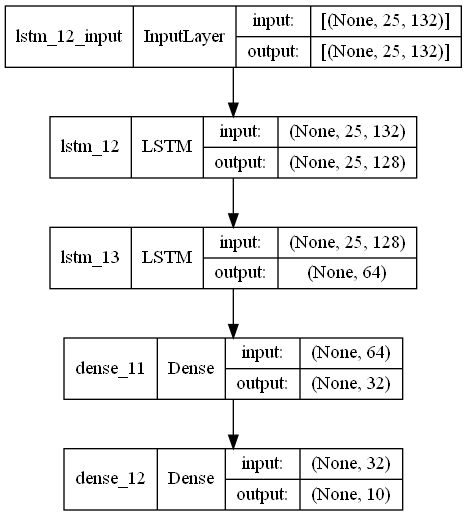

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e1k_b16, to_file = "arc_lstm2_dense2_rd2_lr5_e1k_b16_1601_18032022.png", show_shapes = True)

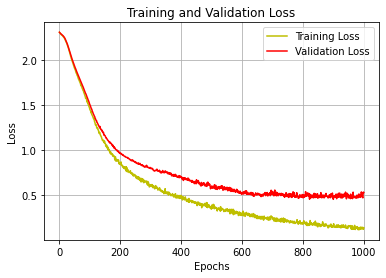

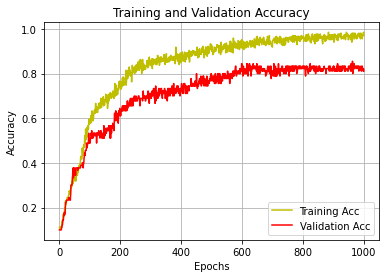

In [398]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [399]:
res = lstm2_dense2_rd2_lr5_e1k_b16.predict(X_test)

In [400]:
yhat = lstm2_dense2_rd2_lr5_e1k_b16.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [401]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[5 2 2 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [4 0 5 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 1 0 0 8]]


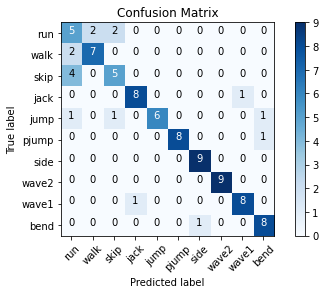

In [402]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [403]:
y_pred = lstm2_dense2_rd2_lr5_e1k_b16.predict(X_test)
y_pred = (y_pred > 0.5)

In [404]:
_, acc = lstm2_dense2_rd2_lr5_e1k_b16.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 24ms/step - loss: 0.5798 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [405]:
accuracy_score(ytrue, yhat)

0.8111111111111111

In [406]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.42      0.56      0.48         9
        walk       0.78      0.78      0.78         9
        skip       0.62      0.56      0.59         9
        jack       0.89      0.89      0.89         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      0.89      0.94         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.80      0.89      0.84         9

    accuracy                           0.81        90
   macro avg       0.83      0.81      0.82        90
weighted avg       0.83      0.81      0.82        90



# lstm2_dense2_rd2_lr5_e1_5k_b16
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=1500 + recurrent_dropout=0.2 + lr=0.00001 + batch=16 -> overfit somehow

In [407]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e1_5k_b16 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [408]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e1_5k_b16.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [409]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e1_5k_b16.fit(X_train, y_train, batch_size=16, epochs=1500, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/1500
17/17 - 14s - loss: 2.3158 - categorical_accuracy: 0.0889 - val_loss: 2.3067 - val_categorical_accuracy: 0.1000 - 14s/epoch - 836ms/step
Epoch 2/1500
17/17 - 2s - loss: 2.3104 - categorical_accuracy: 0.0889 - val_loss: 2.3019 - val_categorical_accuracy: 0.1000 - 2s/epoch - 91ms/step
Epoch 3/1500
17/17 - 2s - loss: 2.3023 - categorical_accuracy: 0.0963 - val_loss: 2.2974 - val_categorical_accuracy: 0.0889 - 2s/epoch - 90ms/step
Epoch 4/1500
17/17 - 2s - loss: 2.2962 - categorical_accuracy: 0.1037 - val_loss: 2.2924 - val_categorical_accuracy: 0.1111 - 2s/epoch - 89ms/step
Epoch 5/1500
17/17 - 1s - loss: 2.2921 - categorical_accuracy: 0.1296 - val_loss: 2.2878 - val_categorical_accuracy: 0.1667 - 1s/epoch - 88ms/step
Epoch 6/1500
17/17 - 2s - loss: 2.2891 - categorical_accuracy: 0.1370 - val_loss: 2.2841 - val_categorical_accuracy: 0.1556 - 2s/epoch - 102ms/step
Epoch 7/1500
17/17 - 2s - loss: 2.2827 - categorical_accuracy: 0.1556 - val_loss: 2.2801 - val_categorical_accurac

Epoch 57/1500
17/17 - 1s - loss: 1.8071 - categorical_accuracy: 0.4704 - val_loss: 1.8467 - val_categorical_accuracy: 0.3889 - 1s/epoch - 88ms/step
Epoch 58/1500
17/17 - 1s - loss: 1.7999 - categorical_accuracy: 0.4630 - val_loss: 1.8374 - val_categorical_accuracy: 0.3889 - 1s/epoch - 87ms/step
Epoch 59/1500
17/17 - 2s - loss: 1.7889 - categorical_accuracy: 0.4667 - val_loss: 1.8287 - val_categorical_accuracy: 0.4111 - 2s/epoch - 89ms/step
Epoch 60/1500
17/17 - 1s - loss: 1.7818 - categorical_accuracy: 0.4667 - val_loss: 1.8191 - val_categorical_accuracy: 0.3889 - 1s/epoch - 87ms/step
Epoch 61/1500
17/17 - 1s - loss: 1.7661 - categorical_accuracy: 0.4444 - val_loss: 1.8096 - val_categorical_accuracy: 0.4222 - 1s/epoch - 88ms/step
Epoch 62/1500
17/17 - 2s - loss: 1.7588 - categorical_accuracy: 0.4630 - val_loss: 1.8006 - val_categorical_accuracy: 0.4111 - 2s/epoch - 89ms/step
Epoch 63/1500
17/17 - 1s - loss: 1.7472 - categorical_accuracy: 0.4630 - val_loss: 1.7910 - val_categorical_accu

Epoch 113/1500
17/17 - 1s - loss: 1.3237 - categorical_accuracy: 0.6370 - val_loss: 1.4437 - val_categorical_accuracy: 0.5667 - 1s/epoch - 88ms/step
Epoch 114/1500
17/17 - 2s - loss: 1.3368 - categorical_accuracy: 0.5926 - val_loss: 1.4387 - val_categorical_accuracy: 0.5667 - 2s/epoch - 90ms/step
Epoch 115/1500
17/17 - 1s - loss: 1.3189 - categorical_accuracy: 0.6185 - val_loss: 1.4294 - val_categorical_accuracy: 0.5667 - 1s/epoch - 88ms/step
Epoch 116/1500
17/17 - 1s - loss: 1.3155 - categorical_accuracy: 0.6148 - val_loss: 1.4279 - val_categorical_accuracy: 0.5556 - 1s/epoch - 88ms/step
Epoch 117/1500
17/17 - 2s - loss: 1.3205 - categorical_accuracy: 0.5926 - val_loss: 1.4213 - val_categorical_accuracy: 0.5667 - 2s/epoch - 89ms/step
Epoch 118/1500
17/17 - 2s - loss: 1.3038 - categorical_accuracy: 0.6074 - val_loss: 1.4104 - val_categorical_accuracy: 0.5667 - 2s/epoch - 89ms/step
Epoch 119/1500
17/17 - 2s - loss: 1.2853 - categorical_accuracy: 0.6148 - val_loss: 1.4025 - val_categoric

Epoch 168/1500
17/17 - 2s - loss: 1.0321 - categorical_accuracy: 0.7407 - val_loss: 1.1759 - val_categorical_accuracy: 0.6111 - 2s/epoch - 115ms/step
Epoch 169/1500
17/17 - 2s - loss: 1.0054 - categorical_accuracy: 0.7333 - val_loss: 1.1725 - val_categorical_accuracy: 0.6111 - 2s/epoch - 98ms/step
Epoch 170/1500
17/17 - 2s - loss: 1.0094 - categorical_accuracy: 0.7444 - val_loss: 1.1720 - val_categorical_accuracy: 0.6222 - 2s/epoch - 111ms/step
Epoch 171/1500
17/17 - 2s - loss: 1.0090 - categorical_accuracy: 0.7370 - val_loss: 1.1620 - val_categorical_accuracy: 0.6222 - 2s/epoch - 106ms/step
Epoch 172/1500
17/17 - 2s - loss: 1.0016 - categorical_accuracy: 0.7815 - val_loss: 1.1627 - val_categorical_accuracy: 0.6222 - 2s/epoch - 125ms/step
Epoch 173/1500
17/17 - 2s - loss: 0.9978 - categorical_accuracy: 0.7667 - val_loss: 1.1519 - val_categorical_accuracy: 0.6333 - 2s/epoch - 113ms/step
Epoch 174/1500
17/17 - 2s - loss: 0.9826 - categorical_accuracy: 0.7741 - val_loss: 1.1589 - val_cate

Epoch 223/1500
17/17 - 1s - loss: 0.8321 - categorical_accuracy: 0.7815 - val_loss: 0.9847 - val_categorical_accuracy: 0.6444 - 1s/epoch - 86ms/step
Epoch 224/1500
17/17 - 1s - loss: 0.7963 - categorical_accuracy: 0.8185 - val_loss: 0.9873 - val_categorical_accuracy: 0.6444 - 1s/epoch - 85ms/step
Epoch 225/1500
17/17 - 2s - loss: 0.7903 - categorical_accuracy: 0.8111 - val_loss: 0.9832 - val_categorical_accuracy: 0.6556 - 2s/epoch - 89ms/step
Epoch 226/1500
17/17 - 2s - loss: 0.7999 - categorical_accuracy: 0.8074 - val_loss: 1.0001 - val_categorical_accuracy: 0.6444 - 2s/epoch - 95ms/step
Epoch 227/1500
17/17 - 1s - loss: 0.8186 - categorical_accuracy: 0.8111 - val_loss: 0.9801 - val_categorical_accuracy: 0.6556 - 1s/epoch - 87ms/step
Epoch 228/1500
17/17 - 1s - loss: 0.7850 - categorical_accuracy: 0.8222 - val_loss: 0.9779 - val_categorical_accuracy: 0.6556 - 1s/epoch - 86ms/step
Epoch 229/1500
17/17 - 1s - loss: 0.8065 - categorical_accuracy: 0.7926 - val_loss: 0.9890 - val_categoric

Epoch 278/1500
17/17 - 1s - loss: 0.6636 - categorical_accuracy: 0.8519 - val_loss: 0.8589 - val_categorical_accuracy: 0.7000 - 1s/epoch - 86ms/step
Epoch 279/1500
17/17 - 1s - loss: 0.6255 - categorical_accuracy: 0.8778 - val_loss: 0.8632 - val_categorical_accuracy: 0.7111 - 1s/epoch - 87ms/step
Epoch 280/1500
17/17 - 1s - loss: 0.6652 - categorical_accuracy: 0.8370 - val_loss: 0.8715 - val_categorical_accuracy: 0.6889 - 1s/epoch - 84ms/step
Epoch 281/1500
17/17 - 2s - loss: 0.6678 - categorical_accuracy: 0.8370 - val_loss: 0.8454 - val_categorical_accuracy: 0.6889 - 2s/epoch - 89ms/step
Epoch 282/1500
17/17 - 1s - loss: 0.6452 - categorical_accuracy: 0.8593 - val_loss: 0.8402 - val_categorical_accuracy: 0.7222 - 1s/epoch - 85ms/step
Epoch 283/1500
17/17 - 1s - loss: 0.6668 - categorical_accuracy: 0.8296 - val_loss: 0.8426 - val_categorical_accuracy: 0.7111 - 1s/epoch - 86ms/step
Epoch 284/1500
17/17 - 1s - loss: 0.6514 - categorical_accuracy: 0.8519 - val_loss: 0.8466 - val_categoric

Epoch 333/1500
17/17 - 1s - loss: 0.5895 - categorical_accuracy: 0.8444 - val_loss: 0.7535 - val_categorical_accuracy: 0.7333 - 1s/epoch - 83ms/step
Epoch 334/1500
17/17 - 1s - loss: 0.5511 - categorical_accuracy: 0.8741 - val_loss: 0.7591 - val_categorical_accuracy: 0.7556 - 1s/epoch - 85ms/step
Epoch 335/1500
17/17 - 1s - loss: 0.5585 - categorical_accuracy: 0.8704 - val_loss: 0.7661 - val_categorical_accuracy: 0.7333 - 1s/epoch - 84ms/step
Epoch 336/1500
17/17 - 1s - loss: 0.5739 - categorical_accuracy: 0.8630 - val_loss: 0.7508 - val_categorical_accuracy: 0.7222 - 1s/epoch - 84ms/step
Epoch 337/1500
17/17 - 1s - loss: 0.5462 - categorical_accuracy: 0.8630 - val_loss: 0.7367 - val_categorical_accuracy: 0.7333 - 1s/epoch - 82ms/step
Epoch 338/1500
17/17 - 1s - loss: 0.5613 - categorical_accuracy: 0.8407 - val_loss: 0.7481 - val_categorical_accuracy: 0.7222 - 1s/epoch - 84ms/step
Epoch 339/1500
17/17 - 1s - loss: 0.5403 - categorical_accuracy: 0.8741 - val_loss: 0.7457 - val_categoric

Epoch 388/1500
17/17 - 2s - loss: 0.5004 - categorical_accuracy: 0.8481 - val_loss: 0.6633 - val_categorical_accuracy: 0.7778 - 2s/epoch - 96ms/step
Epoch 389/1500
17/17 - 1s - loss: 0.5128 - categorical_accuracy: 0.8630 - val_loss: 0.6929 - val_categorical_accuracy: 0.7333 - 1s/epoch - 84ms/step
Epoch 390/1500
17/17 - 1s - loss: 0.5254 - categorical_accuracy: 0.8630 - val_loss: 0.6945 - val_categorical_accuracy: 0.7444 - 1s/epoch - 86ms/step
Epoch 391/1500
17/17 - 1s - loss: 0.4835 - categorical_accuracy: 0.8778 - val_loss: 0.6924 - val_categorical_accuracy: 0.7444 - 1s/epoch - 86ms/step
Epoch 392/1500
17/17 - 1s - loss: 0.5059 - categorical_accuracy: 0.8630 - val_loss: 0.6642 - val_categorical_accuracy: 0.7667 - 1s/epoch - 83ms/step
Epoch 393/1500
17/17 - 1s - loss: 0.4606 - categorical_accuracy: 0.8815 - val_loss: 0.6785 - val_categorical_accuracy: 0.7444 - 1s/epoch - 84ms/step
Epoch 394/1500
17/17 - 1s - loss: 0.4697 - categorical_accuracy: 0.8704 - val_loss: 0.6756 - val_categoric

Epoch 443/1500
17/17 - 1s - loss: 0.4228 - categorical_accuracy: 0.8926 - val_loss: 0.6336 - val_categorical_accuracy: 0.7556 - 1s/epoch - 86ms/step
Epoch 444/1500
17/17 - 1s - loss: 0.4297 - categorical_accuracy: 0.8741 - val_loss: 0.6367 - val_categorical_accuracy: 0.7556 - 1s/epoch - 82ms/step
Epoch 445/1500
17/17 - 1s - loss: 0.4416 - categorical_accuracy: 0.8889 - val_loss: 0.6506 - val_categorical_accuracy: 0.7444 - 1s/epoch - 83ms/step
Epoch 446/1500
17/17 - 1s - loss: 0.3806 - categorical_accuracy: 0.9222 - val_loss: 0.6446 - val_categorical_accuracy: 0.7444 - 1s/epoch - 84ms/step
Epoch 447/1500
17/17 - 1s - loss: 0.4102 - categorical_accuracy: 0.8852 - val_loss: 0.6371 - val_categorical_accuracy: 0.7556 - 1s/epoch - 84ms/step
Epoch 448/1500
17/17 - 1s - loss: 0.4271 - categorical_accuracy: 0.8815 - val_loss: 0.6395 - val_categorical_accuracy: 0.7444 - 1s/epoch - 83ms/step
Epoch 449/1500
17/17 - 1s - loss: 0.3958 - categorical_accuracy: 0.9148 - val_loss: 0.6415 - val_categoric

Epoch 498/1500
17/17 - 1s - loss: 0.3477 - categorical_accuracy: 0.9222 - val_loss: 0.6074 - val_categorical_accuracy: 0.7556 - 1s/epoch - 84ms/step
Epoch 499/1500
17/17 - 1s - loss: 0.3375 - categorical_accuracy: 0.9370 - val_loss: 0.6134 - val_categorical_accuracy: 0.7444 - 1s/epoch - 83ms/step
Epoch 500/1500
17/17 - 1s - loss: 0.3765 - categorical_accuracy: 0.8926 - val_loss: 0.6342 - val_categorical_accuracy: 0.7333 - 1s/epoch - 84ms/step
Epoch 501/1500
17/17 - 1s - loss: 0.3644 - categorical_accuracy: 0.9111 - val_loss: 0.5923 - val_categorical_accuracy: 0.7667 - 1s/epoch - 84ms/step
Epoch 502/1500
17/17 - 1s - loss: 0.3501 - categorical_accuracy: 0.9037 - val_loss: 0.5935 - val_categorical_accuracy: 0.7778 - 1s/epoch - 83ms/step
Epoch 503/1500
17/17 - 1s - loss: 0.3807 - categorical_accuracy: 0.8963 - val_loss: 0.6055 - val_categorical_accuracy: 0.7556 - 1s/epoch - 83ms/step
Epoch 504/1500
17/17 - 1s - loss: 0.3531 - categorical_accuracy: 0.9222 - val_loss: 0.6178 - val_categoric

Epoch 553/1500
17/17 - 1s - loss: 0.3071 - categorical_accuracy: 0.9296 - val_loss: 0.5822 - val_categorical_accuracy: 0.8000 - 1s/epoch - 83ms/step
Epoch 554/1500
17/17 - 2s - loss: 0.3337 - categorical_accuracy: 0.9111 - val_loss: 0.5643 - val_categorical_accuracy: 0.8000 - 2s/epoch - 97ms/step
Epoch 555/1500
17/17 - 1s - loss: 0.3400 - categorical_accuracy: 0.9037 - val_loss: 0.5643 - val_categorical_accuracy: 0.7889 - 1s/epoch - 83ms/step
Epoch 556/1500
17/17 - 1s - loss: 0.3177 - categorical_accuracy: 0.9185 - val_loss: 0.5772 - val_categorical_accuracy: 0.7667 - 1s/epoch - 86ms/step
Epoch 557/1500
17/17 - 1s - loss: 0.3305 - categorical_accuracy: 0.9037 - val_loss: 0.5713 - val_categorical_accuracy: 0.7889 - 1s/epoch - 85ms/step
Epoch 558/1500
17/17 - 1s - loss: 0.3258 - categorical_accuracy: 0.9333 - val_loss: 0.5705 - val_categorical_accuracy: 0.7889 - 1s/epoch - 83ms/step
Epoch 559/1500
17/17 - 1s - loss: 0.3180 - categorical_accuracy: 0.9185 - val_loss: 0.5682 - val_categoric

Epoch 608/1500
17/17 - 1s - loss: 0.3007 - categorical_accuracy: 0.9111 - val_loss: 0.5750 - val_categorical_accuracy: 0.7667 - 1s/epoch - 84ms/step
Epoch 609/1500
17/17 - 1s - loss: 0.2686 - categorical_accuracy: 0.9444 - val_loss: 0.5677 - val_categorical_accuracy: 0.7778 - 1s/epoch - 85ms/step
Epoch 610/1500
17/17 - 1s - loss: 0.2673 - categorical_accuracy: 0.9407 - val_loss: 0.5495 - val_categorical_accuracy: 0.7667 - 1s/epoch - 83ms/step
Epoch 611/1500
17/17 - 1s - loss: 0.2822 - categorical_accuracy: 0.9259 - val_loss: 0.5513 - val_categorical_accuracy: 0.8111 - 1s/epoch - 85ms/step
Epoch 612/1500
17/17 - 1s - loss: 0.2776 - categorical_accuracy: 0.9444 - val_loss: 0.5732 - val_categorical_accuracy: 0.7778 - 1s/epoch - 85ms/step
Epoch 613/1500
17/17 - 1s - loss: 0.3090 - categorical_accuracy: 0.9000 - val_loss: 0.5669 - val_categorical_accuracy: 0.7333 - 1s/epoch - 84ms/step
Epoch 614/1500
17/17 - 1s - loss: 0.2932 - categorical_accuracy: 0.9296 - val_loss: 0.5587 - val_categoric

Epoch 663/1500
17/17 - 2s - loss: 0.2762 - categorical_accuracy: 0.9111 - val_loss: 0.5486 - val_categorical_accuracy: 0.7889 - 2s/epoch - 101ms/step
Epoch 664/1500
17/17 - 2s - loss: 0.2584 - categorical_accuracy: 0.9481 - val_loss: 0.5528 - val_categorical_accuracy: 0.8000 - 2s/epoch - 107ms/step
Epoch 665/1500
17/17 - 2s - loss: 0.2666 - categorical_accuracy: 0.9222 - val_loss: 0.5558 - val_categorical_accuracy: 0.7778 - 2s/epoch - 112ms/step
Epoch 666/1500
17/17 - 2s - loss: 0.2605 - categorical_accuracy: 0.9259 - val_loss: 0.5444 - val_categorical_accuracy: 0.8000 - 2s/epoch - 128ms/step
Epoch 667/1500
17/17 - 2s - loss: 0.2769 - categorical_accuracy: 0.9370 - val_loss: 0.5435 - val_categorical_accuracy: 0.7778 - 2s/epoch - 116ms/step
Epoch 668/1500
17/17 - 2s - loss: 0.2234 - categorical_accuracy: 0.9556 - val_loss: 0.5561 - val_categorical_accuracy: 0.8000 - 2s/epoch - 136ms/step
Epoch 669/1500
17/17 - 2s - loss: 0.2625 - categorical_accuracy: 0.9444 - val_loss: 0.5629 - val_cat

Epoch 718/1500
17/17 - 2s - loss: 0.2513 - categorical_accuracy: 0.9111 - val_loss: 0.5626 - val_categorical_accuracy: 0.8000 - 2s/epoch - 96ms/step
Epoch 719/1500
17/17 - 2s - loss: 0.2743 - categorical_accuracy: 0.9111 - val_loss: 0.5576 - val_categorical_accuracy: 0.7778 - 2s/epoch - 97ms/step
Epoch 720/1500
17/17 - 2s - loss: 0.2263 - categorical_accuracy: 0.9407 - val_loss: 0.5410 - val_categorical_accuracy: 0.8000 - 2s/epoch - 94ms/step
Epoch 721/1500
17/17 - 2s - loss: 0.2128 - categorical_accuracy: 0.9519 - val_loss: 0.5354 - val_categorical_accuracy: 0.7778 - 2s/epoch - 92ms/step
Epoch 722/1500
17/17 - 2s - loss: 0.2459 - categorical_accuracy: 0.9370 - val_loss: 0.5365 - val_categorical_accuracy: 0.7667 - 2s/epoch - 95ms/step
Epoch 723/1500
17/17 - 2s - loss: 0.2317 - categorical_accuracy: 0.9481 - val_loss: 0.5527 - val_categorical_accuracy: 0.7889 - 2s/epoch - 96ms/step
Epoch 724/1500
17/17 - 2s - loss: 0.2352 - categorical_accuracy: 0.9296 - val_loss: 0.5592 - val_categoric

Epoch 773/1500
17/17 - 2s - loss: 0.1978 - categorical_accuracy: 0.9630 - val_loss: 0.5315 - val_categorical_accuracy: 0.8111 - 2s/epoch - 108ms/step
Epoch 774/1500
17/17 - 2s - loss: 0.2402 - categorical_accuracy: 0.9444 - val_loss: 0.5482 - val_categorical_accuracy: 0.7889 - 2s/epoch - 107ms/step
Epoch 775/1500
17/17 - 2s - loss: 0.2432 - categorical_accuracy: 0.9481 - val_loss: 0.5465 - val_categorical_accuracy: 0.8000 - 2s/epoch - 106ms/step
Epoch 776/1500
17/17 - 2s - loss: 0.2101 - categorical_accuracy: 0.9407 - val_loss: 0.5648 - val_categorical_accuracy: 0.7556 - 2s/epoch - 110ms/step
Epoch 777/1500
17/17 - 2s - loss: 0.2120 - categorical_accuracy: 0.9444 - val_loss: 0.5588 - val_categorical_accuracy: 0.8111 - 2s/epoch - 99ms/step
Epoch 778/1500
17/17 - 2s - loss: 0.1807 - categorical_accuracy: 0.9704 - val_loss: 0.5415 - val_categorical_accuracy: 0.8000 - 2s/epoch - 107ms/step
Epoch 779/1500
17/17 - 2s - loss: 0.1985 - categorical_accuracy: 0.9481 - val_loss: 0.5345 - val_cate

Epoch 828/1500
17/17 - 2s - loss: 0.1792 - categorical_accuracy: 0.9630 - val_loss: 0.5228 - val_categorical_accuracy: 0.7889 - 2s/epoch - 93ms/step
Epoch 829/1500
17/17 - 2s - loss: 0.1680 - categorical_accuracy: 0.9667 - val_loss: 0.5165 - val_categorical_accuracy: 0.8000 - 2s/epoch - 95ms/step
Epoch 830/1500
17/17 - 2s - loss: 0.1882 - categorical_accuracy: 0.9667 - val_loss: 0.5176 - val_categorical_accuracy: 0.8111 - 2s/epoch - 93ms/step
Epoch 831/1500
17/17 - 2s - loss: 0.1994 - categorical_accuracy: 0.9407 - val_loss: 0.5017 - val_categorical_accuracy: 0.8111 - 2s/epoch - 103ms/step
Epoch 832/1500
17/17 - 2s - loss: 0.1962 - categorical_accuracy: 0.9519 - val_loss: 0.5231 - val_categorical_accuracy: 0.7889 - 2s/epoch - 95ms/step
Epoch 833/1500
17/17 - 2s - loss: 0.1818 - categorical_accuracy: 0.9593 - val_loss: 0.5390 - val_categorical_accuracy: 0.7889 - 2s/epoch - 98ms/step
Epoch 834/1500
17/17 - 2s - loss: 0.2074 - categorical_accuracy: 0.9481 - val_loss: 0.5418 - val_categori

Epoch 883/1500
17/17 - 2s - loss: 0.1452 - categorical_accuracy: 0.9778 - val_loss: 0.5249 - val_categorical_accuracy: 0.7889 - 2s/epoch - 91ms/step
Epoch 884/1500
17/17 - 2s - loss: 0.1541 - categorical_accuracy: 0.9630 - val_loss: 0.5207 - val_categorical_accuracy: 0.8000 - 2s/epoch - 92ms/step
Epoch 885/1500
17/17 - 2s - loss: 0.1371 - categorical_accuracy: 0.9778 - val_loss: 0.5328 - val_categorical_accuracy: 0.8000 - 2s/epoch - 91ms/step
Epoch 886/1500
17/17 - 2s - loss: 0.1690 - categorical_accuracy: 0.9593 - val_loss: 0.5199 - val_categorical_accuracy: 0.8111 - 2s/epoch - 91ms/step
Epoch 887/1500
17/17 - 2s - loss: 0.1730 - categorical_accuracy: 0.9593 - val_loss: 0.5225 - val_categorical_accuracy: 0.8000 - 2s/epoch - 93ms/step
Epoch 888/1500
17/17 - 2s - loss: 0.1560 - categorical_accuracy: 0.9630 - val_loss: 0.5137 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 889/1500
17/17 - 2s - loss: 0.1703 - categorical_accuracy: 0.9556 - val_loss: 0.5161 - val_categoric

Epoch 938/1500
17/17 - 2s - loss: 0.1306 - categorical_accuracy: 0.9889 - val_loss: 0.5270 - val_categorical_accuracy: 0.7889 - 2s/epoch - 92ms/step
Epoch 939/1500
17/17 - 2s - loss: 0.1512 - categorical_accuracy: 0.9593 - val_loss: 0.5121 - val_categorical_accuracy: 0.7778 - 2s/epoch - 91ms/step
Epoch 940/1500
17/17 - 2s - loss: 0.1344 - categorical_accuracy: 0.9667 - val_loss: 0.5068 - val_categorical_accuracy: 0.7778 - 2s/epoch - 91ms/step
Epoch 941/1500
17/17 - 2s - loss: 0.1868 - categorical_accuracy: 0.9407 - val_loss: 0.5051 - val_categorical_accuracy: 0.8222 - 2s/epoch - 92ms/step
Epoch 942/1500
17/17 - 2s - loss: 0.1582 - categorical_accuracy: 0.9556 - val_loss: 0.5208 - val_categorical_accuracy: 0.7778 - 2s/epoch - 93ms/step
Epoch 943/1500
17/17 - 2s - loss: 0.1484 - categorical_accuracy: 0.9630 - val_loss: 0.4860 - val_categorical_accuracy: 0.8000 - 2s/epoch - 92ms/step
Epoch 944/1500
17/17 - 2s - loss: 0.1549 - categorical_accuracy: 0.9741 - val_loss: 0.4907 - val_categoric

Epoch 993/1500
17/17 - 2s - loss: 0.1264 - categorical_accuracy: 0.9667 - val_loss: 0.5223 - val_categorical_accuracy: 0.7889 - 2s/epoch - 91ms/step
Epoch 994/1500
17/17 - 2s - loss: 0.1379 - categorical_accuracy: 0.9667 - val_loss: 0.4918 - val_categorical_accuracy: 0.8000 - 2s/epoch - 91ms/step
Epoch 995/1500
17/17 - 2s - loss: 0.1246 - categorical_accuracy: 0.9778 - val_loss: 0.4861 - val_categorical_accuracy: 0.7889 - 2s/epoch - 91ms/step
Epoch 996/1500
17/17 - 2s - loss: 0.1130 - categorical_accuracy: 0.9778 - val_loss: 0.4920 - val_categorical_accuracy: 0.8000 - 2s/epoch - 93ms/step
Epoch 997/1500
17/17 - 2s - loss: 0.1226 - categorical_accuracy: 0.9704 - val_loss: 0.5012 - val_categorical_accuracy: 0.8000 - 2s/epoch - 90ms/step
Epoch 998/1500
17/17 - 2s - loss: 0.1237 - categorical_accuracy: 0.9704 - val_loss: 0.4891 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 999/1500
17/17 - 2s - loss: 0.1245 - categorical_accuracy: 0.9778 - val_loss: 0.4861 - val_categoric

Epoch 1048/1500
17/17 - 2s - loss: 0.1103 - categorical_accuracy: 0.9741 - val_loss: 0.5185 - val_categorical_accuracy: 0.7778 - 2s/epoch - 96ms/step
Epoch 1049/1500
17/17 - 2s - loss: 0.1497 - categorical_accuracy: 0.9593 - val_loss: 0.5101 - val_categorical_accuracy: 0.8000 - 2s/epoch - 94ms/step
Epoch 1050/1500
17/17 - 2s - loss: 0.1059 - categorical_accuracy: 0.9963 - val_loss: 0.5050 - val_categorical_accuracy: 0.7778 - 2s/epoch - 92ms/step
Epoch 1051/1500
17/17 - 2s - loss: 0.1358 - categorical_accuracy: 0.9815 - val_loss: 0.5240 - val_categorical_accuracy: 0.7778 - 2s/epoch - 93ms/step
Epoch 1052/1500
17/17 - 2s - loss: 0.1608 - categorical_accuracy: 0.9519 - val_loss: 0.5152 - val_categorical_accuracy: 0.8000 - 2s/epoch - 93ms/step
Epoch 1053/1500
17/17 - 2s - loss: 0.1432 - categorical_accuracy: 0.9593 - val_loss: 0.5225 - val_categorical_accuracy: 0.7778 - 2s/epoch - 97ms/step
Epoch 1054/1500
17/17 - 2s - loss: 0.1182 - categorical_accuracy: 0.9852 - val_loss: 0.4956 - val_ca

Epoch 1103/1500
17/17 - 2s - loss: 0.1057 - categorical_accuracy: 0.9815 - val_loss: 0.4976 - val_categorical_accuracy: 0.8222 - 2s/epoch - 90ms/step
Epoch 1104/1500
17/17 - 2s - loss: 0.1418 - categorical_accuracy: 0.9593 - val_loss: 0.5358 - val_categorical_accuracy: 0.7889 - 2s/epoch - 94ms/step
Epoch 1105/1500
17/17 - 2s - loss: 0.1043 - categorical_accuracy: 0.9852 - val_loss: 0.4982 - val_categorical_accuracy: 0.8000 - 2s/epoch - 91ms/step
Epoch 1106/1500
17/17 - 2s - loss: 0.0958 - categorical_accuracy: 0.9815 - val_loss: 0.4941 - val_categorical_accuracy: 0.8222 - 2s/epoch - 96ms/step
Epoch 1107/1500
17/17 - 2s - loss: 0.1127 - categorical_accuracy: 0.9778 - val_loss: 0.5120 - val_categorical_accuracy: 0.8222 - 2s/epoch - 92ms/step
Epoch 1108/1500
17/17 - 2s - loss: 0.1186 - categorical_accuracy: 0.9741 - val_loss: 0.5107 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 1109/1500
17/17 - 2s - loss: 0.1379 - categorical_accuracy: 0.9667 - val_loss: 0.5233 - val_ca

Epoch 1158/1500
17/17 - 2s - loss: 0.1016 - categorical_accuracy: 0.9741 - val_loss: 0.5420 - val_categorical_accuracy: 0.7889 - 2s/epoch - 90ms/step
Epoch 1159/1500
17/17 - 2s - loss: 0.0929 - categorical_accuracy: 0.9815 - val_loss: 0.5466 - val_categorical_accuracy: 0.7889 - 2s/epoch - 93ms/step
Epoch 1160/1500
17/17 - 2s - loss: 0.0857 - categorical_accuracy: 0.9926 - val_loss: 0.5361 - val_categorical_accuracy: 0.7889 - 2s/epoch - 90ms/step
Epoch 1161/1500
17/17 - 2s - loss: 0.1054 - categorical_accuracy: 0.9741 - val_loss: 0.5382 - val_categorical_accuracy: 0.8222 - 2s/epoch - 91ms/step
Epoch 1162/1500
17/17 - 2s - loss: 0.1212 - categorical_accuracy: 0.9704 - val_loss: 0.4996 - val_categorical_accuracy: 0.8000 - 2s/epoch - 91ms/step
Epoch 1163/1500
17/17 - 2s - loss: 0.0929 - categorical_accuracy: 0.9815 - val_loss: 0.4940 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 1164/1500
17/17 - 2s - loss: 0.1104 - categorical_accuracy: 0.9704 - val_loss: 0.5213 - val_ca

Epoch 1213/1500
17/17 - 2s - loss: 0.1057 - categorical_accuracy: 0.9741 - val_loss: 0.5332 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 1214/1500
17/17 - 2s - loss: 0.0985 - categorical_accuracy: 0.9704 - val_loss: 0.5675 - val_categorical_accuracy: 0.8111 - 2s/epoch - 89ms/step
Epoch 1215/1500
17/17 - 2s - loss: 0.0865 - categorical_accuracy: 0.9815 - val_loss: 0.5762 - val_categorical_accuracy: 0.7778 - 2s/epoch - 95ms/step
Epoch 1216/1500
17/17 - 2s - loss: 0.0886 - categorical_accuracy: 0.9889 - val_loss: 0.5591 - val_categorical_accuracy: 0.7889 - 2s/epoch - 91ms/step
Epoch 1217/1500
17/17 - 2s - loss: 0.0813 - categorical_accuracy: 0.9778 - val_loss: 0.5619 - val_categorical_accuracy: 0.7889 - 2s/epoch - 92ms/step
Epoch 1218/1500
17/17 - 2s - loss: 0.1046 - categorical_accuracy: 0.9815 - val_loss: 0.5534 - val_categorical_accuracy: 0.8222 - 2s/epoch - 89ms/step
Epoch 1219/1500
17/17 - 2s - loss: 0.0820 - categorical_accuracy: 0.9889 - val_loss: 0.5491 - val_ca

Epoch 1268/1500
17/17 - 2s - loss: 0.0758 - categorical_accuracy: 0.9889 - val_loss: 0.5611 - val_categorical_accuracy: 0.7778 - 2s/epoch - 108ms/step
Epoch 1269/1500
17/17 - 2s - loss: 0.0733 - categorical_accuracy: 0.9815 - val_loss: 0.5797 - val_categorical_accuracy: 0.7778 - 2s/epoch - 101ms/step
Epoch 1270/1500
17/17 - 2s - loss: 0.0855 - categorical_accuracy: 0.9852 - val_loss: 0.5671 - val_categorical_accuracy: 0.8000 - 2s/epoch - 95ms/step
Epoch 1271/1500
17/17 - 2s - loss: 0.0664 - categorical_accuracy: 0.9963 - val_loss: 0.5263 - val_categorical_accuracy: 0.8444 - 2s/epoch - 91ms/step
Epoch 1272/1500
17/17 - 2s - loss: 0.0920 - categorical_accuracy: 0.9778 - val_loss: 0.5622 - val_categorical_accuracy: 0.7778 - 2s/epoch - 91ms/step
Epoch 1273/1500
17/17 - 2s - loss: 0.0854 - categorical_accuracy: 0.9815 - val_loss: 0.5520 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 1274/1500
17/17 - 2s - loss: 0.0769 - categorical_accuracy: 0.9889 - val_loss: 0.5520 - val_

Epoch 1323/1500
17/17 - 2s - loss: 0.0797 - categorical_accuracy: 0.9815 - val_loss: 0.5519 - val_categorical_accuracy: 0.8111 - 2s/epoch - 96ms/step
Epoch 1324/1500
17/17 - 2s - loss: 0.0772 - categorical_accuracy: 0.9852 - val_loss: 0.5573 - val_categorical_accuracy: 0.7778 - 2s/epoch - 90ms/step
Epoch 1325/1500
17/17 - 2s - loss: 0.0871 - categorical_accuracy: 0.9778 - val_loss: 0.5493 - val_categorical_accuracy: 0.7889 - 2s/epoch - 96ms/step
Epoch 1326/1500
17/17 - 2s - loss: 0.0745 - categorical_accuracy: 0.9889 - val_loss: 0.5372 - val_categorical_accuracy: 0.8222 - 2s/epoch - 91ms/step
Epoch 1327/1500
17/17 - 2s - loss: 0.0925 - categorical_accuracy: 0.9815 - val_loss: 0.5666 - val_categorical_accuracy: 0.7889 - 2s/epoch - 92ms/step
Epoch 1328/1500
17/17 - 2s - loss: 0.0647 - categorical_accuracy: 0.9889 - val_loss: 0.5753 - val_categorical_accuracy: 0.7889 - 2s/epoch - 91ms/step
Epoch 1329/1500
17/17 - 2s - loss: 0.0612 - categorical_accuracy: 0.9926 - val_loss: 0.5411 - val_ca

Epoch 1378/1500
17/17 - 2s - loss: 0.0670 - categorical_accuracy: 0.9889 - val_loss: 0.5868 - val_categorical_accuracy: 0.7778 - 2s/epoch - 91ms/step
Epoch 1379/1500
17/17 - 2s - loss: 0.0596 - categorical_accuracy: 0.9963 - val_loss: 0.5865 - val_categorical_accuracy: 0.7778 - 2s/epoch - 93ms/step
Epoch 1380/1500
17/17 - 2s - loss: 0.0620 - categorical_accuracy: 0.9852 - val_loss: 0.5617 - val_categorical_accuracy: 0.8000 - 2s/epoch - 105ms/step
Epoch 1381/1500
17/17 - 2s - loss: 0.0737 - categorical_accuracy: 0.9741 - val_loss: 0.6104 - val_categorical_accuracy: 0.7778 - 2s/epoch - 93ms/step
Epoch 1382/1500
17/17 - 2s - loss: 0.1044 - categorical_accuracy: 0.9815 - val_loss: 0.5797 - val_categorical_accuracy: 0.7889 - 2s/epoch - 93ms/step
Epoch 1383/1500
17/17 - 2s - loss: 0.0814 - categorical_accuracy: 0.9815 - val_loss: 0.6250 - val_categorical_accuracy: 0.8111 - 2s/epoch - 92ms/step
Epoch 1384/1500
17/17 - 2s - loss: 0.0927 - categorical_accuracy: 0.9778 - val_loss: 0.6248 - val_c

Epoch 1433/1500
17/17 - 2s - loss: 0.0797 - categorical_accuracy: 0.9741 - val_loss: 0.6053 - val_categorical_accuracy: 0.7889 - 2s/epoch - 100ms/step
Epoch 1434/1500
17/17 - 2s - loss: 0.0807 - categorical_accuracy: 0.9852 - val_loss: 0.6036 - val_categorical_accuracy: 0.8111 - 2s/epoch - 95ms/step
Epoch 1435/1500
17/17 - 2s - loss: 0.0602 - categorical_accuracy: 0.9926 - val_loss: 0.5796 - val_categorical_accuracy: 0.8000 - 2s/epoch - 92ms/step
Epoch 1436/1500
17/17 - 2s - loss: 0.0616 - categorical_accuracy: 0.9852 - val_loss: 0.5764 - val_categorical_accuracy: 0.8222 - 2s/epoch - 96ms/step
Epoch 1437/1500
17/17 - 2s - loss: 0.0519 - categorical_accuracy: 0.9963 - val_loss: 0.5958 - val_categorical_accuracy: 0.8000 - 2s/epoch - 94ms/step
Epoch 1438/1500
17/17 - 2s - loss: 0.0594 - categorical_accuracy: 0.9889 - val_loss: 0.5853 - val_categorical_accuracy: 0.8000 - 2s/epoch - 90ms/step
Epoch 1439/1500
17/17 - 2s - loss: 0.0529 - categorical_accuracy: 0.9926 - val_loss: 0.5815 - val_c

Epoch 1488/1500
17/17 - 2s - loss: 0.0455 - categorical_accuracy: 1.0000 - val_loss: 0.6076 - val_categorical_accuracy: 0.8000 - 2s/epoch - 92ms/step
Epoch 1489/1500
17/17 - 2s - loss: 0.0380 - categorical_accuracy: 1.0000 - val_loss: 0.6157 - val_categorical_accuracy: 0.7778 - 2s/epoch - 95ms/step
Epoch 1490/1500
17/17 - 2s - loss: 0.0554 - categorical_accuracy: 0.9889 - val_loss: 0.5832 - val_categorical_accuracy: 0.8111 - 2s/epoch - 94ms/step
Epoch 1491/1500
17/17 - 2s - loss: 0.0615 - categorical_accuracy: 0.9889 - val_loss: 0.5881 - val_categorical_accuracy: 0.7889 - 2s/epoch - 94ms/step
Epoch 1492/1500
17/17 - 2s - loss: 0.0481 - categorical_accuracy: 0.9963 - val_loss: 0.5870 - val_categorical_accuracy: 0.8111 - 2s/epoch - 91ms/step
Epoch 1493/1500
17/17 - 2s - loss: 0.0628 - categorical_accuracy: 0.9815 - val_loss: 0.5894 - val_categorical_accuracy: 0.8111 - 2s/epoch - 98ms/step
Epoch 1494/1500
17/17 - 2s - loss: 0.0505 - categorical_accuracy: 0.9926 - val_loss: 0.5521 - val_ca

In [410]:
lstm2_dense2_rd2_lr5_e1_5k_b16.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_59 (LSTM)              (None, 64)                49408     
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [411]:
# Save Model
lstm2_dense2_rd2_lr5_e1_5k_b16.save("lstm2_dense2_rd2_lr5_e1_5k_b16_1703_18032022.h5")

In [412]:
# Load Model
lstm2_dense2_rd2_lr5_e1_5k_b16.load_weights("lstm2_dense2_rd2_lr5_e1_5k_b16_1703_18032022.h5")

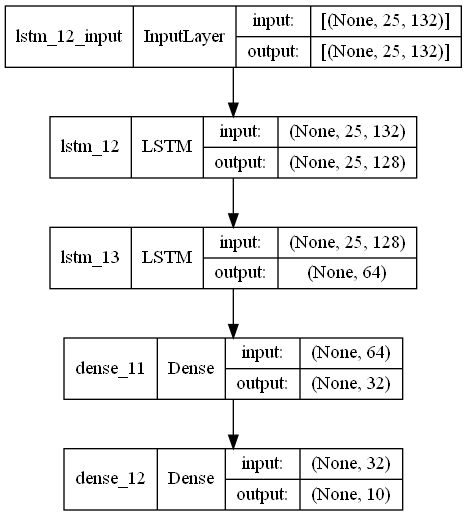

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e1_5k_b16, to_file = "arc_lstm2_dense2_rd2_lr5_e1_5k_b16_1703_18032022.png", show_shapes = True)

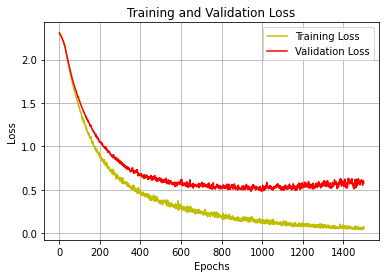

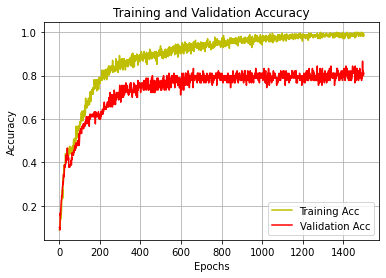

In [413]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [414]:
res = lstm2_dense2_rd2_lr5_e1_5k_b16.predict(X_test)

In [415]:
yhat = lstm2_dense2_rd2_lr5_e1_5k_b16.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [416]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 3 0 0 0 0 0 0 0]
 [3 5 1 0 0 0 0 0 0 0]
 [1 3 5 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [2 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


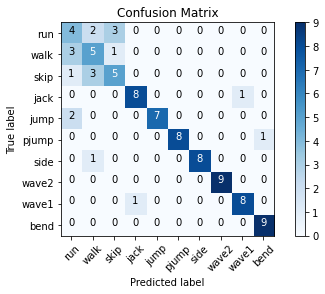

In [417]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [418]:
y_pred = lstm2_dense2_rd2_lr5_e1_5k_b16.predict(X_test)
y_pred = (y_pred > 0.5)

In [419]:
_, acc = lstm2_dense2_rd2_lr5_e1_5k_b16.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 35ms/step - loss: 0.6976 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [420]:
accuracy_score(ytrue, yhat)

0.7888888888888889

In [421]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.40      0.44      0.42         9
        walk       0.45      0.56      0.50         9
        skip       0.56      0.56      0.56         9
        jack       0.89      0.89      0.89         9
        jump       1.00      0.78      0.88         9
       pjump       1.00      0.89      0.94         9
        side       1.00      0.89      0.94         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.79        90
   macro avg       0.81      0.79      0.80        90
weighted avg       0.81      0.79      0.80        90



# lstm2_dense2_rd2_lr5_e1k_b32
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=1000 + recurrent_dropout=0.2 + lr=0.00001 + batch=32 -> bad

In [422]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e1k_b32 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [423]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e1k_b32.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [424]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e1k_b32.fit(X_train, y_train, batch_size=32, epochs=1000, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/1000
9/9 - 19s - loss: 2.3350 - categorical_accuracy: 0.0667 - val_loss: 2.3411 - val_categorical_accuracy: 0.0556 - 19s/epoch - 2s/step
Epoch 2/1000
9/9 - 1s - loss: 2.3292 - categorical_accuracy: 0.0667 - val_loss: 2.3350 - val_categorical_accuracy: 0.0667 - 1s/epoch - 117ms/step
Epoch 3/1000
9/9 - 1s - loss: 2.3208 - categorical_accuracy: 0.1037 - val_loss: 2.3301 - val_categorical_accuracy: 0.0667 - 997ms/epoch - 111ms/step
Epoch 4/1000
9/9 - 1s - loss: 2.3178 - categorical_accuracy: 0.0926 - val_loss: 2.3268 - val_categorical_accuracy: 0.0667 - 925ms/epoch - 103ms/step
Epoch 5/1000
9/9 - 1s - loss: 2.3135 - categorical_accuracy: 0.1000 - val_loss: 2.3243 - val_categorical_accuracy: 0.0667 - 930ms/epoch - 103ms/step
Epoch 6/1000
9/9 - 1s - loss: 2.3098 - categorical_accuracy: 0.1148 - val_loss: 2.3221 - val_categorical_accuracy: 0.0778 - 979ms/epoch - 109ms/step
Epoch 7/1000
9/9 - 1s - loss: 2.3092 - categorical_accuracy: 0.0963 - val_loss: 2.3201 - val_categorical_accuracy

Epoch 56/1000
9/9 - 1s - loss: 2.1834 - categorical_accuracy: 0.2407 - val_loss: 2.1974 - val_categorical_accuracy: 0.2444 - 949ms/epoch - 105ms/step
Epoch 57/1000
9/9 - 1s - loss: 2.1778 - categorical_accuracy: 0.2296 - val_loss: 2.1916 - val_categorical_accuracy: 0.2667 - 905ms/epoch - 101ms/step
Epoch 58/1000
9/9 - 1s - loss: 2.1708 - categorical_accuracy: 0.2519 - val_loss: 2.1855 - val_categorical_accuracy: 0.2667 - 924ms/epoch - 103ms/step
Epoch 59/1000
9/9 - 1s - loss: 2.1639 - categorical_accuracy: 0.2333 - val_loss: 2.1791 - val_categorical_accuracy: 0.2667 - 906ms/epoch - 101ms/step
Epoch 60/1000
9/9 - 1s - loss: 2.1566 - categorical_accuracy: 0.2481 - val_loss: 2.1722 - val_categorical_accuracy: 0.2667 - 911ms/epoch - 101ms/step
Epoch 61/1000
9/9 - 1s - loss: 2.1487 - categorical_accuracy: 0.2630 - val_loss: 2.1647 - val_categorical_accuracy: 0.2889 - 933ms/epoch - 104ms/step
Epoch 62/1000
9/9 - 1s - loss: 2.1423 - categorical_accuracy: 0.2444 - val_loss: 2.1567 - val_catego

Epoch 111/1000
9/9 - 1s - loss: 1.7631 - categorical_accuracy: 0.3815 - val_loss: 1.8044 - val_categorical_accuracy: 0.3333 - 895ms/epoch - 99ms/step
Epoch 112/1000
9/9 - 1s - loss: 1.7565 - categorical_accuracy: 0.4037 - val_loss: 1.8005 - val_categorical_accuracy: 0.3333 - 916ms/epoch - 102ms/step
Epoch 113/1000
9/9 - 1s - loss: 1.7516 - categorical_accuracy: 0.3963 - val_loss: 1.7926 - val_categorical_accuracy: 0.3444 - 873ms/epoch - 97ms/step
Epoch 114/1000
9/9 - 1s - loss: 1.7416 - categorical_accuracy: 0.4370 - val_loss: 1.7848 - val_categorical_accuracy: 0.3778 - 926ms/epoch - 103ms/step
Epoch 115/1000
9/9 - 1s - loss: 1.7356 - categorical_accuracy: 0.4444 - val_loss: 1.7796 - val_categorical_accuracy: 0.3889 - 974ms/epoch - 108ms/step
Epoch 116/1000
9/9 - 1s - loss: 1.7257 - categorical_accuracy: 0.4259 - val_loss: 1.7738 - val_categorical_accuracy: 0.3889 - 1s/epoch - 119ms/step
Epoch 117/1000
9/9 - 1s - loss: 1.7175 - categorical_accuracy: 0.4593 - val_loss: 1.7667 - val_cate

Epoch 166/1000
9/9 - 1s - loss: 1.3948 - categorical_accuracy: 0.6111 - val_loss: 1.4944 - val_categorical_accuracy: 0.5000 - 917ms/epoch - 102ms/step
Epoch 167/1000
9/9 - 1s - loss: 1.3820 - categorical_accuracy: 0.6037 - val_loss: 1.4800 - val_categorical_accuracy: 0.4889 - 916ms/epoch - 102ms/step
Epoch 168/1000
9/9 - 1s - loss: 1.3799 - categorical_accuracy: 0.6185 - val_loss: 1.4742 - val_categorical_accuracy: 0.4889 - 878ms/epoch - 98ms/step
Epoch 169/1000
9/9 - 1s - loss: 1.3843 - categorical_accuracy: 0.6222 - val_loss: 1.4801 - val_categorical_accuracy: 0.5000 - 896ms/epoch - 100ms/step
Epoch 170/1000
9/9 - 1s - loss: 1.3712 - categorical_accuracy: 0.6148 - val_loss: 1.4787 - val_categorical_accuracy: 0.4889 - 902ms/epoch - 100ms/step
Epoch 171/1000
9/9 - 1s - loss: 1.3613 - categorical_accuracy: 0.6407 - val_loss: 1.4729 - val_categorical_accuracy: 0.4889 - 1s/epoch - 111ms/step
Epoch 172/1000
9/9 - 1s - loss: 1.3508 - categorical_accuracy: 0.6148 - val_loss: 1.4651 - val_cat

Epoch 221/1000
9/9 - 1s - loss: 1.1327 - categorical_accuracy: 0.7296 - val_loss: 1.2963 - val_categorical_accuracy: 0.5778 - 976ms/epoch - 108ms/step
Epoch 222/1000
9/9 - 1s - loss: 1.1283 - categorical_accuracy: 0.7148 - val_loss: 1.2959 - val_categorical_accuracy: 0.6000 - 899ms/epoch - 100ms/step
Epoch 223/1000
9/9 - 1s - loss: 1.1301 - categorical_accuracy: 0.7222 - val_loss: 1.2798 - val_categorical_accuracy: 0.6000 - 906ms/epoch - 101ms/step
Epoch 224/1000
9/9 - 1s - loss: 1.1302 - categorical_accuracy: 0.7111 - val_loss: 1.2763 - val_categorical_accuracy: 0.5889 - 896ms/epoch - 100ms/step
Epoch 225/1000
9/9 - 1s - loss: 1.1274 - categorical_accuracy: 0.7111 - val_loss: 1.2700 - val_categorical_accuracy: 0.6000 - 891ms/epoch - 99ms/step
Epoch 226/1000
9/9 - 1s - loss: 1.1067 - categorical_accuracy: 0.7148 - val_loss: 1.2728 - val_categorical_accuracy: 0.5889 - 906ms/epoch - 101ms/step
Epoch 227/1000
9/9 - 1s - loss: 1.1270 - categorical_accuracy: 0.6815 - val_loss: 1.2629 - val_

Epoch 276/1000
9/9 - 1s - loss: 0.9429 - categorical_accuracy: 0.7704 - val_loss: 1.1378 - val_categorical_accuracy: 0.6556 - 1s/epoch - 117ms/step
Epoch 277/1000
9/9 - 1s - loss: 0.9431 - categorical_accuracy: 0.7704 - val_loss: 1.1247 - val_categorical_accuracy: 0.6667 - 939ms/epoch - 104ms/step
Epoch 278/1000
9/9 - 1s - loss: 0.9566 - categorical_accuracy: 0.7630 - val_loss: 1.1321 - val_categorical_accuracy: 0.6556 - 905ms/epoch - 101ms/step
Epoch 279/1000
9/9 - 1s - loss: 0.9303 - categorical_accuracy: 0.7741 - val_loss: 1.1358 - val_categorical_accuracy: 0.6444 - 884ms/epoch - 98ms/step
Epoch 280/1000
9/9 - 1s - loss: 0.9469 - categorical_accuracy: 0.7667 - val_loss: 1.1287 - val_categorical_accuracy: 0.6444 - 887ms/epoch - 99ms/step
Epoch 281/1000
9/9 - 1s - loss: 0.9352 - categorical_accuracy: 0.7704 - val_loss: 1.1385 - val_categorical_accuracy: 0.6444 - 895ms/epoch - 99ms/step
Epoch 282/1000
9/9 - 1s - loss: 0.9449 - categorical_accuracy: 0.7593 - val_loss: 1.1380 - val_categ

Epoch 331/1000
9/9 - 1s - loss: 0.8327 - categorical_accuracy: 0.7889 - val_loss: 1.0257 - val_categorical_accuracy: 0.6556 - 914ms/epoch - 102ms/step
Epoch 332/1000
9/9 - 1s - loss: 0.8246 - categorical_accuracy: 0.8074 - val_loss: 1.0184 - val_categorical_accuracy: 0.6889 - 943ms/epoch - 105ms/step
Epoch 333/1000
9/9 - 1s - loss: 0.8062 - categorical_accuracy: 0.7926 - val_loss: 1.0281 - val_categorical_accuracy: 0.6667 - 906ms/epoch - 101ms/step
Epoch 334/1000
9/9 - 1s - loss: 0.8123 - categorical_accuracy: 0.7963 - val_loss: 1.0225 - val_categorical_accuracy: 0.6667 - 914ms/epoch - 102ms/step
Epoch 335/1000
9/9 - 1s - loss: 0.8128 - categorical_accuracy: 0.7704 - val_loss: 1.0274 - val_categorical_accuracy: 0.6889 - 913ms/epoch - 101ms/step
Epoch 336/1000
9/9 - 1s - loss: 0.7958 - categorical_accuracy: 0.8000 - val_loss: 1.0279 - val_categorical_accuracy: 0.6778 - 899ms/epoch - 100ms/step
Epoch 337/1000
9/9 - 1s - loss: 0.7941 - categorical_accuracy: 0.8074 - val_loss: 1.0210 - val

Epoch 386/1000
9/9 - 1s - loss: 0.7145 - categorical_accuracy: 0.7963 - val_loss: 0.9532 - val_categorical_accuracy: 0.7000 - 888ms/epoch - 99ms/step
Epoch 387/1000
9/9 - 1s - loss: 0.7354 - categorical_accuracy: 0.8000 - val_loss: 0.9621 - val_categorical_accuracy: 0.6889 - 925ms/epoch - 103ms/step
Epoch 388/1000
9/9 - 1s - loss: 0.7042 - categorical_accuracy: 0.8185 - val_loss: 0.9588 - val_categorical_accuracy: 0.6889 - 897ms/epoch - 100ms/step
Epoch 389/1000
9/9 - 1s - loss: 0.6897 - categorical_accuracy: 0.8333 - val_loss: 0.9558 - val_categorical_accuracy: 0.7000 - 901ms/epoch - 100ms/step
Epoch 390/1000
9/9 - 1s - loss: 0.7254 - categorical_accuracy: 0.8148 - val_loss: 0.9502 - val_categorical_accuracy: 0.7222 - 889ms/epoch - 99ms/step
Epoch 391/1000
9/9 - 1s - loss: 0.7083 - categorical_accuracy: 0.8148 - val_loss: 0.9574 - val_categorical_accuracy: 0.7000 - 886ms/epoch - 98ms/step
Epoch 392/1000
9/9 - 1s - loss: 0.7237 - categorical_accuracy: 0.8148 - val_loss: 0.9584 - val_ca

Epoch 441/1000
9/9 - 1s - loss: 0.6334 - categorical_accuracy: 0.8556 - val_loss: 0.8866 - val_categorical_accuracy: 0.7222 - 956ms/epoch - 106ms/step
Epoch 442/1000
9/9 - 1s - loss: 0.6362 - categorical_accuracy: 0.8370 - val_loss: 0.8942 - val_categorical_accuracy: 0.7222 - 1s/epoch - 122ms/step
Epoch 443/1000
9/9 - 1s - loss: 0.6342 - categorical_accuracy: 0.8259 - val_loss: 0.8761 - val_categorical_accuracy: 0.7333 - 927ms/epoch - 103ms/step
Epoch 444/1000
9/9 - 1s - loss: 0.6289 - categorical_accuracy: 0.8444 - val_loss: 0.8779 - val_categorical_accuracy: 0.7333 - 889ms/epoch - 99ms/step
Epoch 445/1000
9/9 - 1s - loss: 0.6138 - categorical_accuracy: 0.8519 - val_loss: 0.8786 - val_categorical_accuracy: 0.7333 - 899ms/epoch - 100ms/step
Epoch 446/1000
9/9 - 1s - loss: 0.6548 - categorical_accuracy: 0.8259 - val_loss: 0.8788 - val_categorical_accuracy: 0.7333 - 889ms/epoch - 99ms/step
Epoch 447/1000
9/9 - 1s - loss: 0.6402 - categorical_accuracy: 0.8333 - val_loss: 0.8739 - val_cate

Epoch 496/1000
9/9 - 1s - loss: 0.5799 - categorical_accuracy: 0.8630 - val_loss: 0.8705 - val_categorical_accuracy: 0.7222 - 916ms/epoch - 102ms/step
Epoch 497/1000
9/9 - 1s - loss: 0.5806 - categorical_accuracy: 0.8556 - val_loss: 0.8724 - val_categorical_accuracy: 0.7000 - 913ms/epoch - 101ms/step
Epoch 498/1000
9/9 - 1s - loss: 0.5765 - categorical_accuracy: 0.8444 - val_loss: 0.8620 - val_categorical_accuracy: 0.7111 - 895ms/epoch - 99ms/step
Epoch 499/1000
9/9 - 1s - loss: 0.5922 - categorical_accuracy: 0.8444 - val_loss: 0.8543 - val_categorical_accuracy: 0.7222 - 880ms/epoch - 98ms/step
Epoch 500/1000
9/9 - 1s - loss: 0.5849 - categorical_accuracy: 0.8481 - val_loss: 0.8410 - val_categorical_accuracy: 0.7333 - 903ms/epoch - 100ms/step
Epoch 501/1000
9/9 - 1s - loss: 0.5682 - categorical_accuracy: 0.8444 - val_loss: 0.8488 - val_categorical_accuracy: 0.7222 - 900ms/epoch - 100ms/step
Epoch 502/1000
9/9 - 1s - loss: 0.5703 - categorical_accuracy: 0.8519 - val_loss: 0.8606 - val_c

Epoch 551/1000
9/9 - 1s - loss: 0.5057 - categorical_accuracy: 0.8741 - val_loss: 0.8199 - val_categorical_accuracy: 0.7222 - 924ms/epoch - 103ms/step
Epoch 552/1000
9/9 - 1s - loss: 0.5342 - categorical_accuracy: 0.8444 - val_loss: 0.8145 - val_categorical_accuracy: 0.7444 - 949ms/epoch - 105ms/step
Epoch 553/1000
9/9 - 1s - loss: 0.5491 - categorical_accuracy: 0.8370 - val_loss: 0.8167 - val_categorical_accuracy: 0.7111 - 918ms/epoch - 102ms/step
Epoch 554/1000
9/9 - 1s - loss: 0.5102 - categorical_accuracy: 0.8704 - val_loss: 0.8153 - val_categorical_accuracy: 0.7222 - 908ms/epoch - 101ms/step
Epoch 555/1000
9/9 - 1s - loss: 0.5070 - categorical_accuracy: 0.8815 - val_loss: 0.8135 - val_categorical_accuracy: 0.7222 - 885ms/epoch - 98ms/step
Epoch 556/1000
9/9 - 1s - loss: 0.5351 - categorical_accuracy: 0.8444 - val_loss: 0.8162 - val_categorical_accuracy: 0.7222 - 908ms/epoch - 101ms/step
Epoch 557/1000
9/9 - 1s - loss: 0.5207 - categorical_accuracy: 0.8889 - val_loss: 0.8175 - val_

Epoch 606/1000
9/9 - 1s - loss: 0.4606 - categorical_accuracy: 0.8852 - val_loss: 0.7902 - val_categorical_accuracy: 0.7333 - 898ms/epoch - 100ms/step
Epoch 607/1000
9/9 - 1s - loss: 0.4858 - categorical_accuracy: 0.8519 - val_loss: 0.7937 - val_categorical_accuracy: 0.7000 - 934ms/epoch - 104ms/step
Epoch 608/1000
9/9 - 1s - loss: 0.4653 - categorical_accuracy: 0.8741 - val_loss: 0.7977 - val_categorical_accuracy: 0.7000 - 971ms/epoch - 108ms/step
Epoch 609/1000
9/9 - 1s - loss: 0.4814 - categorical_accuracy: 0.8889 - val_loss: 0.7833 - val_categorical_accuracy: 0.7222 - 930ms/epoch - 103ms/step
Epoch 610/1000
9/9 - 1s - loss: 0.4960 - categorical_accuracy: 0.8741 - val_loss: 0.7853 - val_categorical_accuracy: 0.7333 - 902ms/epoch - 100ms/step
Epoch 611/1000
9/9 - 1s - loss: 0.4713 - categorical_accuracy: 0.8963 - val_loss: 0.7917 - val_categorical_accuracy: 0.7333 - 891ms/epoch - 99ms/step
Epoch 612/1000
9/9 - 1s - loss: 0.4621 - categorical_accuracy: 0.8926 - val_loss: 0.7885 - val_

Epoch 661/1000
9/9 - 1s - loss: 0.4553 - categorical_accuracy: 0.8815 - val_loss: 0.7583 - val_categorical_accuracy: 0.7222 - 890ms/epoch - 99ms/step
Epoch 662/1000
9/9 - 1s - loss: 0.4273 - categorical_accuracy: 0.8852 - val_loss: 0.7588 - val_categorical_accuracy: 0.7444 - 903ms/epoch - 100ms/step
Epoch 663/1000
9/9 - 1s - loss: 0.4734 - categorical_accuracy: 0.8704 - val_loss: 0.7683 - val_categorical_accuracy: 0.7222 - 901ms/epoch - 100ms/step
Epoch 664/1000
9/9 - 1s - loss: 0.4456 - categorical_accuracy: 0.8667 - val_loss: 0.7697 - val_categorical_accuracy: 0.7000 - 892ms/epoch - 99ms/step
Epoch 665/1000
9/9 - 1s - loss: 0.4350 - categorical_accuracy: 0.8852 - val_loss: 0.7603 - val_categorical_accuracy: 0.7222 - 888ms/epoch - 99ms/step
Epoch 666/1000
9/9 - 1s - loss: 0.4800 - categorical_accuracy: 0.8704 - val_loss: 0.7499 - val_categorical_accuracy: 0.7333 - 889ms/epoch - 99ms/step
Epoch 667/1000
9/9 - 1s - loss: 0.4294 - categorical_accuracy: 0.8926 - val_loss: 0.7549 - val_cat

Epoch 716/1000
9/9 - 1s - loss: 0.4141 - categorical_accuracy: 0.8852 - val_loss: 0.7333 - val_categorical_accuracy: 0.7333 - 925ms/epoch - 103ms/step
Epoch 717/1000
9/9 - 1s - loss: 0.4139 - categorical_accuracy: 0.8963 - val_loss: 0.7386 - val_categorical_accuracy: 0.7667 - 897ms/epoch - 100ms/step
Epoch 718/1000
9/9 - 1s - loss: 0.4036 - categorical_accuracy: 0.9037 - val_loss: 0.7321 - val_categorical_accuracy: 0.7667 - 916ms/epoch - 102ms/step
Epoch 719/1000
9/9 - 1s - loss: 0.4157 - categorical_accuracy: 0.9037 - val_loss: 0.7422 - val_categorical_accuracy: 0.7333 - 897ms/epoch - 100ms/step
Epoch 720/1000
9/9 - 1s - loss: 0.4078 - categorical_accuracy: 0.9000 - val_loss: 0.7323 - val_categorical_accuracy: 0.7333 - 899ms/epoch - 100ms/step
Epoch 721/1000
9/9 - 1s - loss: 0.3951 - categorical_accuracy: 0.8963 - val_loss: 0.7188 - val_categorical_accuracy: 0.7444 - 897ms/epoch - 100ms/step
Epoch 722/1000
9/9 - 1s - loss: 0.4068 - categorical_accuracy: 0.8926 - val_loss: 0.7093 - val

Epoch 771/1000
9/9 - 1s - loss: 0.3881 - categorical_accuracy: 0.9000 - val_loss: 0.7163 - val_categorical_accuracy: 0.7444 - 881ms/epoch - 98ms/step
Epoch 772/1000
9/9 - 1s - loss: 0.3703 - categorical_accuracy: 0.9000 - val_loss: 0.7220 - val_categorical_accuracy: 0.7556 - 900ms/epoch - 100ms/step
Epoch 773/1000
9/9 - 1s - loss: 0.3875 - categorical_accuracy: 0.8926 - val_loss: 0.7054 - val_categorical_accuracy: 0.7556 - 948ms/epoch - 105ms/step
Epoch 774/1000
9/9 - 1s - loss: 0.3704 - categorical_accuracy: 0.9074 - val_loss: 0.7146 - val_categorical_accuracy: 0.7556 - 897ms/epoch - 100ms/step
Epoch 775/1000
9/9 - 1s - loss: 0.3555 - categorical_accuracy: 0.9074 - val_loss: 0.7113 - val_categorical_accuracy: 0.7667 - 896ms/epoch - 100ms/step
Epoch 776/1000
9/9 - 1s - loss: 0.3786 - categorical_accuracy: 0.8963 - val_loss: 0.7041 - val_categorical_accuracy: 0.7444 - 878ms/epoch - 98ms/step
Epoch 777/1000
9/9 - 1s - loss: 0.4029 - categorical_accuracy: 0.9037 - val_loss: 0.6762 - val_c

Epoch 826/1000
9/9 - 1s - loss: 0.3564 - categorical_accuracy: 0.9148 - val_loss: 0.7012 - val_categorical_accuracy: 0.7556 - 986ms/epoch - 110ms/step
Epoch 827/1000
9/9 - 1s - loss: 0.3349 - categorical_accuracy: 0.9333 - val_loss: 0.7097 - val_categorical_accuracy: 0.7667 - 942ms/epoch - 105ms/step
Epoch 828/1000
9/9 - 1s - loss: 0.3649 - categorical_accuracy: 0.9037 - val_loss: 0.7089 - val_categorical_accuracy: 0.7667 - 949ms/epoch - 105ms/step
Epoch 829/1000
9/9 - 1s - loss: 0.3440 - categorical_accuracy: 0.9074 - val_loss: 0.6973 - val_categorical_accuracy: 0.7778 - 965ms/epoch - 107ms/step
Epoch 830/1000
9/9 - 1s - loss: 0.3675 - categorical_accuracy: 0.8963 - val_loss: 0.6972 - val_categorical_accuracy: 0.7556 - 987ms/epoch - 110ms/step
Epoch 831/1000
9/9 - 1s - loss: 0.3435 - categorical_accuracy: 0.9111 - val_loss: 0.7015 - val_categorical_accuracy: 0.7778 - 1s/epoch - 114ms/step
Epoch 832/1000
9/9 - 1s - loss: 0.3376 - categorical_accuracy: 0.9185 - val_loss: 0.7014 - val_ca

Epoch 881/1000
9/9 - 1s - loss: 0.3168 - categorical_accuracy: 0.9074 - val_loss: 0.6633 - val_categorical_accuracy: 0.7556 - 927ms/epoch - 103ms/step
Epoch 882/1000
9/9 - 1s - loss: 0.3283 - categorical_accuracy: 0.9185 - val_loss: 0.6775 - val_categorical_accuracy: 0.7667 - 1s/epoch - 112ms/step
Epoch 883/1000
9/9 - 1s - loss: 0.3186 - categorical_accuracy: 0.9222 - val_loss: 0.6862 - val_categorical_accuracy: 0.7556 - 975ms/epoch - 108ms/step
Epoch 884/1000
9/9 - 1s - loss: 0.3303 - categorical_accuracy: 0.9111 - val_loss: 0.6642 - val_categorical_accuracy: 0.7667 - 939ms/epoch - 104ms/step
Epoch 885/1000
9/9 - 1s - loss: 0.3265 - categorical_accuracy: 0.9111 - val_loss: 0.6408 - val_categorical_accuracy: 0.7556 - 943ms/epoch - 105ms/step
Epoch 886/1000
9/9 - 1s - loss: 0.3555 - categorical_accuracy: 0.9185 - val_loss: 0.6586 - val_categorical_accuracy: 0.7556 - 936ms/epoch - 104ms/step
Epoch 887/1000
9/9 - 1s - loss: 0.3310 - categorical_accuracy: 0.9037 - val_loss: 0.6452 - val_ca

Epoch 936/1000
9/9 - 1s - loss: 0.3416 - categorical_accuracy: 0.9111 - val_loss: 0.6636 - val_categorical_accuracy: 0.7556 - 934ms/epoch - 104ms/step
Epoch 937/1000
9/9 - 1s - loss: 0.3151 - categorical_accuracy: 0.9296 - val_loss: 0.6604 - val_categorical_accuracy: 0.7556 - 918ms/epoch - 102ms/step
Epoch 938/1000
9/9 - 1s - loss: 0.3137 - categorical_accuracy: 0.9222 - val_loss: 0.6789 - val_categorical_accuracy: 0.7667 - 935ms/epoch - 104ms/step
Epoch 939/1000
9/9 - 1s - loss: 0.2821 - categorical_accuracy: 0.9222 - val_loss: 0.6577 - val_categorical_accuracy: 0.7778 - 970ms/epoch - 108ms/step
Epoch 940/1000
9/9 - 1s - loss: 0.3195 - categorical_accuracy: 0.9074 - val_loss: 0.6366 - val_categorical_accuracy: 0.7778 - 935ms/epoch - 104ms/step
Epoch 941/1000
9/9 - 1s - loss: 0.3258 - categorical_accuracy: 0.9148 - val_loss: 0.6409 - val_categorical_accuracy: 0.7778 - 933ms/epoch - 104ms/step
Epoch 942/1000
9/9 - 1s - loss: 0.3035 - categorical_accuracy: 0.9259 - val_loss: 0.6646 - val

Epoch 991/1000
9/9 - 1s - loss: 0.2974 - categorical_accuracy: 0.9148 - val_loss: 0.6322 - val_categorical_accuracy: 0.7667 - 870ms/epoch - 97ms/step
Epoch 992/1000
9/9 - 1s - loss: 0.2686 - categorical_accuracy: 0.9519 - val_loss: 0.6736 - val_categorical_accuracy: 0.7556 - 998ms/epoch - 111ms/step
Epoch 993/1000
9/9 - 1s - loss: 0.2769 - categorical_accuracy: 0.9333 - val_loss: 0.6763 - val_categorical_accuracy: 0.7556 - 912ms/epoch - 101ms/step
Epoch 994/1000
9/9 - 1s - loss: 0.2796 - categorical_accuracy: 0.9333 - val_loss: 0.6687 - val_categorical_accuracy: 0.7778 - 927ms/epoch - 103ms/step
Epoch 995/1000
9/9 - 1s - loss: 0.3057 - categorical_accuracy: 0.9111 - val_loss: 0.6446 - val_categorical_accuracy: 0.7778 - 911ms/epoch - 101ms/step
Epoch 996/1000
9/9 - 1s - loss: 0.2909 - categorical_accuracy: 0.9222 - val_loss: 0.6563 - val_categorical_accuracy: 0.7778 - 917ms/epoch - 102ms/step
Epoch 997/1000
9/9 - 1s - loss: 0.3008 - categorical_accuracy: 0.9259 - val_loss: 0.6904 - val_

In [425]:
lstm2_dense2_rd2_lr5_e1k_b32.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dense_60 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [426]:
# Save Model
lstm2_dense2_rd2_lr5_e1k_b32.save("lstm2_dense2_rd2_lr5_e1k_b32_1810_18032022.h5")

In [427]:
# Load Model
lstm2_dense2_rd2_lr5_e1k_b32.load_weights("lstm2_dense2_rd2_lr5_e1k_b32_1810_18032022.h5")

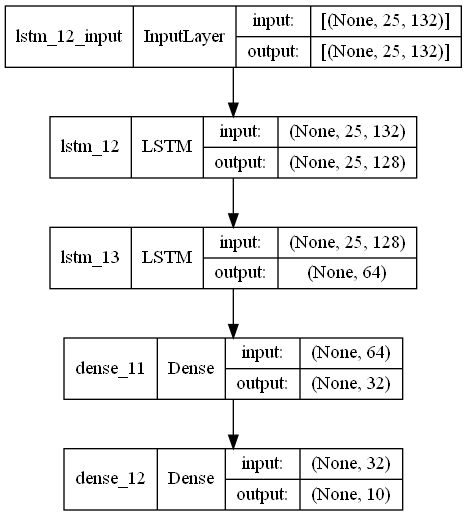

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e1k_b32, to_file = "arc_lstm2_dense2_rd2_lr5_e1k_b32_1810_18032022.png", show_shapes = True)

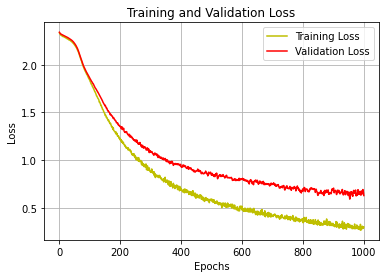

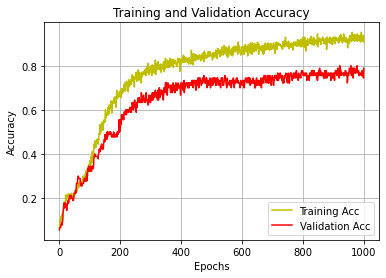

In [428]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [429]:
res = lstm2_dense2_rd2_lr5_e1k_b32.predict(X_test)

In [430]:
yhat = lstm2_dense2_rd2_lr5_e1k_b32.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [431]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[1 4 4 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 2 0]
 [1 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 1 8 0]
 [0 0 0 0 0 0 0 0 1 8]]


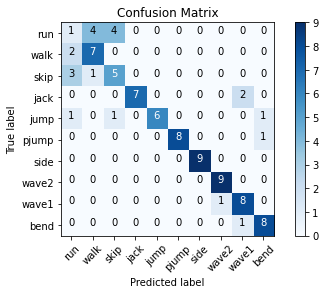

In [432]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [433]:
y_pred = lstm2_dense2_rd2_lr5_e1k_b32.predict(X_test)
y_pred = (y_pred > 0.5)

In [434]:
_, acc = lstm2_dense2_rd2_lr5_e1k_b32.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 20ms/step - loss: 0.6604 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [435]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [436]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.14      0.11      0.12         9
        walk       0.58      0.78      0.67         9
        skip       0.50      0.56      0.53         9
        jack       1.00      0.78      0.88         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       0.90      1.00      0.95         9
       wave1       0.73      0.89      0.80         9
        bend       0.80      0.89      0.84         9

    accuracy                           0.76        90
   macro avg       0.77      0.76      0.75        90
weighted avg       0.77      0.76      0.75        90



# lstm2_dense2_rd2_lr5_e1_5k_b32
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=1500 + recurrent_dropout=0.2 + lr=0.00001 + batch=32 -> bad

In [437]:
# Define a sequential model
lstm2_dense2_rd2_lr5_e1_5k_b32 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [438]:
# Compile model with learning rate
lstm2_dense2_rd2_lr5_e1_5k_b32.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [439]:
# Training model with validation
history = lstm2_dense2_rd2_lr5_e1_5k_b32.fit(X_train, y_train, batch_size=32, epochs=1500, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/1500
9/9 - 13s - loss: 2.3167 - categorical_accuracy: 0.1333 - val_loss: 2.3116 - val_categorical_accuracy: 0.1000 - 13s/epoch - 1s/step
Epoch 2/1500
9/9 - 1s - loss: 2.3140 - categorical_accuracy: 0.1185 - val_loss: 2.3087 - val_categorical_accuracy: 0.1000 - 919ms/epoch - 102ms/step
Epoch 3/1500
9/9 - 1s - loss: 2.3107 - categorical_accuracy: 0.1296 - val_loss: 2.3060 - val_categorical_accuracy: 0.1111 - 934ms/epoch - 104ms/step
Epoch 4/1500
9/9 - 1s - loss: 2.3072 - categorical_accuracy: 0.1296 - val_loss: 2.3035 - val_categorical_accuracy: 0.1556 - 956ms/epoch - 106ms/step
Epoch 5/1500
9/9 - 1s - loss: 2.3032 - categorical_accuracy: 0.1407 - val_loss: 2.3008 - val_categorical_accuracy: 0.1556 - 923ms/epoch - 103ms/step
Epoch 6/1500
9/9 - 1s - loss: 2.3018 - categorical_accuracy: 0.1259 - val_loss: 2.2983 - val_categorical_accuracy: 0.1556 - 921ms/epoch - 102ms/step
Epoch 7/1500
9/9 - 1s - loss: 2.2994 - categorical_accuracy: 0.1444 - val_loss: 2.2955 - val_categorical_accur

Epoch 56/1500
9/9 - 1s - loss: 2.1174 - categorical_accuracy: 0.2444 - val_loss: 2.1278 - val_categorical_accuracy: 0.2222 - 937ms/epoch - 104ms/step
Epoch 57/1500
9/9 - 1s - loss: 2.1131 - categorical_accuracy: 0.2556 - val_loss: 2.1223 - val_categorical_accuracy: 0.2222 - 931ms/epoch - 103ms/step
Epoch 58/1500
9/9 - 1s - loss: 2.1084 - categorical_accuracy: 0.2444 - val_loss: 2.1167 - val_categorical_accuracy: 0.2222 - 933ms/epoch - 104ms/step
Epoch 59/1500
9/9 - 1s - loss: 2.1022 - categorical_accuracy: 0.2481 - val_loss: 2.1112 - val_categorical_accuracy: 0.2222 - 901ms/epoch - 100ms/step
Epoch 60/1500
9/9 - 1s - loss: 2.0983 - categorical_accuracy: 0.2556 - val_loss: 2.1053 - val_categorical_accuracy: 0.2222 - 926ms/epoch - 103ms/step
Epoch 61/1500
9/9 - 1s - loss: 2.0917 - categorical_accuracy: 0.2704 - val_loss: 2.0994 - val_categorical_accuracy: 0.2556 - 871ms/epoch - 97ms/step
Epoch 62/1500
9/9 - 1s - loss: 2.0848 - categorical_accuracy: 0.2556 - val_loss: 2.0934 - val_categor

Epoch 111/1500
9/9 - 1s - loss: 1.6987 - categorical_accuracy: 0.3889 - val_loss: 1.6986 - val_categorical_accuracy: 0.3556 - 943ms/epoch - 105ms/step
Epoch 112/1500
9/9 - 1s - loss: 1.6854 - categorical_accuracy: 0.3926 - val_loss: 1.6972 - val_categorical_accuracy: 0.3556 - 903ms/epoch - 100ms/step
Epoch 113/1500
9/9 - 1s - loss: 1.6723 - categorical_accuracy: 0.3926 - val_loss: 1.6877 - val_categorical_accuracy: 0.3556 - 880ms/epoch - 98ms/step
Epoch 114/1500
9/9 - 1s - loss: 1.6686 - categorical_accuracy: 0.4000 - val_loss: 1.6781 - val_categorical_accuracy: 0.3556 - 907ms/epoch - 101ms/step
Epoch 115/1500
9/9 - 1s - loss: 1.6616 - categorical_accuracy: 0.4074 - val_loss: 1.6681 - val_categorical_accuracy: 0.3556 - 900ms/epoch - 100ms/step
Epoch 116/1500
9/9 - 1s - loss: 1.6605 - categorical_accuracy: 0.3963 - val_loss: 1.6653 - val_categorical_accuracy: 0.3556 - 892ms/epoch - 99ms/step
Epoch 117/1500
9/9 - 1s - loss: 1.6441 - categorical_accuracy: 0.3889 - val_loss: 1.6543 - val_c

Epoch 166/1500
9/9 - 1s - loss: 1.3636 - categorical_accuracy: 0.5704 - val_loss: 1.3871 - val_categorical_accuracy: 0.5444 - 944ms/epoch - 105ms/step
Epoch 167/1500
9/9 - 1s - loss: 1.3706 - categorical_accuracy: 0.5185 - val_loss: 1.3912 - val_categorical_accuracy: 0.5444 - 908ms/epoch - 101ms/step
Epoch 168/1500
9/9 - 1s - loss: 1.3637 - categorical_accuracy: 0.5593 - val_loss: 1.3899 - val_categorical_accuracy: 0.5556 - 895ms/epoch - 99ms/step
Epoch 169/1500
9/9 - 1s - loss: 1.3515 - categorical_accuracy: 0.5926 - val_loss: 1.3861 - val_categorical_accuracy: 0.5444 - 888ms/epoch - 99ms/step
Epoch 170/1500
9/9 - 1s - loss: 1.3571 - categorical_accuracy: 0.5704 - val_loss: 1.3698 - val_categorical_accuracy: 0.5778 - 928ms/epoch - 103ms/step
Epoch 171/1500
9/9 - 1s - loss: 1.3528 - categorical_accuracy: 0.5630 - val_loss: 1.3651 - val_categorical_accuracy: 0.5778 - 952ms/epoch - 106ms/step
Epoch 172/1500
9/9 - 1s - loss: 1.3431 - categorical_accuracy: 0.5630 - val_loss: 1.3708 - val_c

Epoch 221/1500
9/9 - 1s - loss: 1.1739 - categorical_accuracy: 0.6296 - val_loss: 1.2097 - val_categorical_accuracy: 0.6333 - 917ms/epoch - 102ms/step
Epoch 222/1500
9/9 - 1s - loss: 1.1544 - categorical_accuracy: 0.6704 - val_loss: 1.2046 - val_categorical_accuracy: 0.6444 - 967ms/epoch - 107ms/step
Epoch 223/1500
9/9 - 1s - loss: 1.1655 - categorical_accuracy: 0.6704 - val_loss: 1.2006 - val_categorical_accuracy: 0.6444 - 937ms/epoch - 104ms/step
Epoch 224/1500
9/9 - 1s - loss: 1.1475 - categorical_accuracy: 0.6556 - val_loss: 1.1972 - val_categorical_accuracy: 0.6444 - 912ms/epoch - 101ms/step
Epoch 225/1500
9/9 - 1s - loss: 1.1471 - categorical_accuracy: 0.6741 - val_loss: 1.1955 - val_categorical_accuracy: 0.6333 - 889ms/epoch - 99ms/step
Epoch 226/1500
9/9 - 1s - loss: 1.1256 - categorical_accuracy: 0.6704 - val_loss: 1.1940 - val_categorical_accuracy: 0.6222 - 879ms/epoch - 98ms/step
Epoch 227/1500
9/9 - 1s - loss: 1.1391 - categorical_accuracy: 0.6778 - val_loss: 1.1950 - val_c

Epoch 276/1500
9/9 - 1s - loss: 0.9817 - categorical_accuracy: 0.7593 - val_loss: 1.0671 - val_categorical_accuracy: 0.6333 - 895ms/epoch - 99ms/step
Epoch 277/1500
9/9 - 1s - loss: 0.9932 - categorical_accuracy: 0.7407 - val_loss: 1.0605 - val_categorical_accuracy: 0.6333 - 986ms/epoch - 110ms/step
Epoch 278/1500
9/9 - 1s - loss: 0.9833 - categorical_accuracy: 0.7519 - val_loss: 1.0635 - val_categorical_accuracy: 0.6444 - 934ms/epoch - 104ms/step
Epoch 279/1500
9/9 - 1s - loss: 0.9716 - categorical_accuracy: 0.7333 - val_loss: 1.0732 - val_categorical_accuracy: 0.6556 - 912ms/epoch - 101ms/step
Epoch 280/1500
9/9 - 1s - loss: 0.9825 - categorical_accuracy: 0.7519 - val_loss: 1.0557 - val_categorical_accuracy: 0.6444 - 934ms/epoch - 104ms/step
Epoch 281/1500
9/9 - 1s - loss: 0.9644 - categorical_accuracy: 0.7630 - val_loss: 1.0564 - val_categorical_accuracy: 0.6444 - 912ms/epoch - 101ms/step
Epoch 282/1500
9/9 - 1s - loss: 0.9698 - categorical_accuracy: 0.7630 - val_loss: 1.0533 - val_

Epoch 331/1500
9/9 - 1s - loss: 0.8411 - categorical_accuracy: 0.8037 - val_loss: 0.9381 - val_categorical_accuracy: 0.6778 - 989ms/epoch - 110ms/step
Epoch 332/1500
9/9 - 1s - loss: 0.8455 - categorical_accuracy: 0.7852 - val_loss: 0.9281 - val_categorical_accuracy: 0.7111 - 982ms/epoch - 109ms/step
Epoch 333/1500
9/9 - 1s - loss: 0.8183 - categorical_accuracy: 0.8111 - val_loss: 0.9272 - val_categorical_accuracy: 0.7111 - 932ms/epoch - 104ms/step
Epoch 334/1500
9/9 - 1s - loss: 0.8631 - categorical_accuracy: 0.7667 - val_loss: 0.9252 - val_categorical_accuracy: 0.7000 - 905ms/epoch - 101ms/step
Epoch 335/1500
9/9 - 1s - loss: 0.8188 - categorical_accuracy: 0.8037 - val_loss: 0.9247 - val_categorical_accuracy: 0.7000 - 950ms/epoch - 106ms/step
Epoch 336/1500
9/9 - 1s - loss: 0.8570 - categorical_accuracy: 0.7778 - val_loss: 0.9312 - val_categorical_accuracy: 0.7111 - 901ms/epoch - 100ms/step
Epoch 337/1500
9/9 - 1s - loss: 0.8418 - categorical_accuracy: 0.7704 - val_loss: 0.9193 - val

Epoch 386/1500
9/9 - 1s - loss: 0.7262 - categorical_accuracy: 0.8259 - val_loss: 0.8272 - val_categorical_accuracy: 0.7222 - 1s/epoch - 145ms/step
Epoch 387/1500
9/9 - 1s - loss: 0.7111 - categorical_accuracy: 0.8407 - val_loss: 0.8220 - val_categorical_accuracy: 0.7333 - 1s/epoch - 151ms/step
Epoch 388/1500
9/9 - 1s - loss: 0.7142 - categorical_accuracy: 0.8259 - val_loss: 0.8195 - val_categorical_accuracy: 0.7444 - 1s/epoch - 116ms/step
Epoch 389/1500
9/9 - 1s - loss: 0.7240 - categorical_accuracy: 0.8222 - val_loss: 0.8289 - val_categorical_accuracy: 0.7111 - 1s/epoch - 118ms/step
Epoch 390/1500
9/9 - 1s - loss: 0.7177 - categorical_accuracy: 0.8333 - val_loss: 0.8228 - val_categorical_accuracy: 0.7222 - 1s/epoch - 132ms/step
Epoch 391/1500
9/9 - 1s - loss: 0.7028 - categorical_accuracy: 0.8444 - val_loss: 0.8230 - val_categorical_accuracy: 0.7333 - 1s/epoch - 131ms/step
Epoch 392/1500
9/9 - 1s - loss: 0.7104 - categorical_accuracy: 0.8185 - val_loss: 0.8316 - val_categorical_accur

Epoch 441/1500
9/9 - 1s - loss: 0.6289 - categorical_accuracy: 0.8556 - val_loss: 0.7434 - val_categorical_accuracy: 0.7333 - 987ms/epoch - 110ms/step
Epoch 442/1500
9/9 - 1s - loss: 0.6314 - categorical_accuracy: 0.8519 - val_loss: 0.7444 - val_categorical_accuracy: 0.7333 - 1s/epoch - 113ms/step
Epoch 443/1500
9/9 - 1s - loss: 0.6169 - categorical_accuracy: 0.8667 - val_loss: 0.7524 - val_categorical_accuracy: 0.7333 - 1s/epoch - 123ms/step
Epoch 444/1500
9/9 - 1s - loss: 0.6132 - categorical_accuracy: 0.8741 - val_loss: 0.7466 - val_categorical_accuracy: 0.7222 - 1s/epoch - 140ms/step
Epoch 445/1500
9/9 - 1s - loss: 0.6216 - categorical_accuracy: 0.8481 - val_loss: 0.7344 - val_categorical_accuracy: 0.7222 - 1s/epoch - 121ms/step
Epoch 446/1500
9/9 - 1s - loss: 0.5970 - categorical_accuracy: 0.8815 - val_loss: 0.7338 - val_categorical_accuracy: 0.7333 - 1s/epoch - 123ms/step
Epoch 447/1500
9/9 - 1s - loss: 0.6234 - categorical_accuracy: 0.8741 - val_loss: 0.7373 - val_categorical_ac

Epoch 496/1500
9/9 - 1s - loss: 0.5566 - categorical_accuracy: 0.8630 - val_loss: 0.6740 - val_categorical_accuracy: 0.7333 - 950ms/epoch - 106ms/step
Epoch 497/1500
9/9 - 1s - loss: 0.5419 - categorical_accuracy: 0.8778 - val_loss: 0.6684 - val_categorical_accuracy: 0.7444 - 929ms/epoch - 103ms/step
Epoch 498/1500
9/9 - 1s - loss: 0.5356 - categorical_accuracy: 0.8704 - val_loss: 0.6659 - val_categorical_accuracy: 0.7333 - 958ms/epoch - 106ms/step
Epoch 499/1500
9/9 - 1s - loss: 0.5650 - categorical_accuracy: 0.8481 - val_loss: 0.6679 - val_categorical_accuracy: 0.7444 - 1s/epoch - 113ms/step
Epoch 500/1500
9/9 - 1s - loss: 0.5297 - categorical_accuracy: 0.8778 - val_loss: 0.6722 - val_categorical_accuracy: 0.7667 - 1s/epoch - 133ms/step
Epoch 501/1500
9/9 - 1s - loss: 0.5148 - categorical_accuracy: 0.8852 - val_loss: 0.6663 - val_categorical_accuracy: 0.7333 - 1s/epoch - 117ms/step
Epoch 502/1500
9/9 - 1s - loss: 0.5552 - categorical_accuracy: 0.8556 - val_loss: 0.6814 - val_categori

Epoch 551/1500
9/9 - 1s - loss: 0.4726 - categorical_accuracy: 0.8926 - val_loss: 0.6425 - val_categorical_accuracy: 0.7333 - 905ms/epoch - 101ms/step
Epoch 552/1500
9/9 - 1s - loss: 0.4617 - categorical_accuracy: 0.8926 - val_loss: 0.6305 - val_categorical_accuracy: 0.7333 - 920ms/epoch - 102ms/step
Epoch 553/1500
9/9 - 1s - loss: 0.4936 - categorical_accuracy: 0.9037 - val_loss: 0.6247 - val_categorical_accuracy: 0.7333 - 1s/epoch - 113ms/step
Epoch 554/1500
9/9 - 1s - loss: 0.5080 - categorical_accuracy: 0.8704 - val_loss: 0.6212 - val_categorical_accuracy: 0.7444 - 1s/epoch - 113ms/step
Epoch 555/1500
9/9 - 1s - loss: 0.4892 - categorical_accuracy: 0.8852 - val_loss: 0.6269 - val_categorical_accuracy: 0.7444 - 890ms/epoch - 99ms/step
Epoch 556/1500
9/9 - 1s - loss: 0.4796 - categorical_accuracy: 0.8963 - val_loss: 0.6178 - val_categorical_accuracy: 0.7556 - 927ms/epoch - 103ms/step
Epoch 557/1500
9/9 - 1s - loss: 0.4681 - categorical_accuracy: 0.8852 - val_loss: 0.6279 - val_catego

Epoch 606/1500
9/9 - 1s - loss: 0.4398 - categorical_accuracy: 0.8889 - val_loss: 0.5850 - val_categorical_accuracy: 0.7444 - 1s/epoch - 122ms/step
Epoch 607/1500
9/9 - 1s - loss: 0.4260 - categorical_accuracy: 0.9037 - val_loss: 0.5913 - val_categorical_accuracy: 0.7556 - 1s/epoch - 118ms/step
Epoch 608/1500
9/9 - 1s - loss: 0.4169 - categorical_accuracy: 0.9037 - val_loss: 0.5901 - val_categorical_accuracy: 0.7556 - 991ms/epoch - 110ms/step
Epoch 609/1500
9/9 - 1s - loss: 0.4236 - categorical_accuracy: 0.9074 - val_loss: 0.5884 - val_categorical_accuracy: 0.7556 - 974ms/epoch - 108ms/step
Epoch 610/1500
9/9 - 1s - loss: 0.4445 - categorical_accuracy: 0.8926 - val_loss: 0.5698 - val_categorical_accuracy: 0.7667 - 951ms/epoch - 106ms/step
Epoch 611/1500
9/9 - 1s - loss: 0.4268 - categorical_accuracy: 0.8963 - val_loss: 0.5725 - val_categorical_accuracy: 0.7778 - 927ms/epoch - 103ms/step
Epoch 612/1500
9/9 - 1s - loss: 0.4282 - categorical_accuracy: 0.9074 - val_loss: 0.5771 - val_categ

Epoch 661/1500
9/9 - 1s - loss: 0.3822 - categorical_accuracy: 0.9037 - val_loss: 0.5473 - val_categorical_accuracy: 0.7667 - 922ms/epoch - 102ms/step
Epoch 662/1500
9/9 - 1s - loss: 0.3828 - categorical_accuracy: 0.9111 - val_loss: 0.5562 - val_categorical_accuracy: 0.7778 - 950ms/epoch - 106ms/step
Epoch 663/1500
9/9 - 1s - loss: 0.3764 - categorical_accuracy: 0.9037 - val_loss: 0.5692 - val_categorical_accuracy: 0.7556 - 1s/epoch - 126ms/step
Epoch 664/1500
9/9 - 1s - loss: 0.4086 - categorical_accuracy: 0.8963 - val_loss: 0.5685 - val_categorical_accuracy: 0.7667 - 987ms/epoch - 110ms/step
Epoch 665/1500
9/9 - 1s - loss: 0.3620 - categorical_accuracy: 0.9333 - val_loss: 0.5595 - val_categorical_accuracy: 0.7556 - 1s/epoch - 113ms/step
Epoch 666/1500
9/9 - 1s - loss: 0.3842 - categorical_accuracy: 0.8815 - val_loss: 0.5503 - val_categorical_accuracy: 0.7556 - 1s/epoch - 122ms/step
Epoch 667/1500
9/9 - 1s - loss: 0.4120 - categorical_accuracy: 0.9000 - val_loss: 0.5514 - val_categori

Epoch 716/1500
9/9 - 1s - loss: 0.3422 - categorical_accuracy: 0.9148 - val_loss: 0.5344 - val_categorical_accuracy: 0.7778 - 943ms/epoch - 105ms/step
Epoch 717/1500
9/9 - 1s - loss: 0.3410 - categorical_accuracy: 0.9148 - val_loss: 0.5325 - val_categorical_accuracy: 0.7556 - 899ms/epoch - 100ms/step
Epoch 718/1500
9/9 - 1s - loss: 0.3468 - categorical_accuracy: 0.9111 - val_loss: 0.5203 - val_categorical_accuracy: 0.8000 - 1s/epoch - 111ms/step
Epoch 719/1500
9/9 - 1s - loss: 0.3574 - categorical_accuracy: 0.9185 - val_loss: 0.5308 - val_categorical_accuracy: 0.7667 - 903ms/epoch - 100ms/step
Epoch 720/1500
9/9 - 1s - loss: 0.3624 - categorical_accuracy: 0.8926 - val_loss: 0.5321 - val_categorical_accuracy: 0.7778 - 935ms/epoch - 104ms/step
Epoch 721/1500
9/9 - 1s - loss: 0.3586 - categorical_accuracy: 0.8889 - val_loss: 0.5376 - val_categorical_accuracy: 0.7556 - 916ms/epoch - 102ms/step
Epoch 722/1500
9/9 - 1s - loss: 0.3610 - categorical_accuracy: 0.9037 - val_loss: 0.5505 - val_ca

Epoch 771/1500
9/9 - 1s - loss: 0.3284 - categorical_accuracy: 0.9222 - val_loss: 0.5324 - val_categorical_accuracy: 0.7889 - 949ms/epoch - 105ms/step
Epoch 772/1500
9/9 - 1s - loss: 0.3083 - categorical_accuracy: 0.9444 - val_loss: 0.5096 - val_categorical_accuracy: 0.7889 - 902ms/epoch - 100ms/step
Epoch 773/1500
9/9 - 1s - loss: 0.3087 - categorical_accuracy: 0.9296 - val_loss: 0.5193 - val_categorical_accuracy: 0.7889 - 932ms/epoch - 104ms/step
Epoch 774/1500
9/9 - 1s - loss: 0.3100 - categorical_accuracy: 0.9333 - val_loss: 0.5336 - val_categorical_accuracy: 0.7778 - 901ms/epoch - 100ms/step
Epoch 775/1500
9/9 - 1s - loss: 0.3230 - categorical_accuracy: 0.9296 - val_loss: 0.5369 - val_categorical_accuracy: 0.7778 - 1s/epoch - 114ms/step
Epoch 776/1500
9/9 - 1s - loss: 0.3329 - categorical_accuracy: 0.9111 - val_loss: 0.5295 - val_categorical_accuracy: 0.7667 - 909ms/epoch - 101ms/step
Epoch 777/1500
9/9 - 1s - loss: 0.3298 - categorical_accuracy: 0.9074 - val_loss: 0.5174 - val_ca

Epoch 826/1500
9/9 - 1s - loss: 0.3029 - categorical_accuracy: 0.9148 - val_loss: 0.5209 - val_categorical_accuracy: 0.7889 - 902ms/epoch - 100ms/step
Epoch 827/1500
9/9 - 1s - loss: 0.3228 - categorical_accuracy: 0.9074 - val_loss: 0.5099 - val_categorical_accuracy: 0.7889 - 900ms/epoch - 100ms/step
Epoch 828/1500
9/9 - 1s - loss: 0.2996 - categorical_accuracy: 0.9259 - val_loss: 0.5055 - val_categorical_accuracy: 0.7667 - 888ms/epoch - 99ms/step
Epoch 829/1500
9/9 - 1s - loss: 0.2882 - categorical_accuracy: 0.9407 - val_loss: 0.5153 - val_categorical_accuracy: 0.7778 - 895ms/epoch - 99ms/step
Epoch 830/1500
9/9 - 1s - loss: 0.2926 - categorical_accuracy: 0.9222 - val_loss: 0.4917 - val_categorical_accuracy: 0.7889 - 912ms/epoch - 101ms/step
Epoch 831/1500
9/9 - 1s - loss: 0.2934 - categorical_accuracy: 0.9111 - val_loss: 0.4938 - val_categorical_accuracy: 0.7778 - 934ms/epoch - 104ms/step
Epoch 832/1500
9/9 - 1s - loss: 0.2922 - categorical_accuracy: 0.9222 - val_loss: 0.5109 - val_c

Epoch 881/1500
9/9 - 1s - loss: 0.2878 - categorical_accuracy: 0.9259 - val_loss: 0.5006 - val_categorical_accuracy: 0.7889 - 1s/epoch - 120ms/step
Epoch 882/1500
9/9 - 1s - loss: 0.2572 - categorical_accuracy: 0.9407 - val_loss: 0.5134 - val_categorical_accuracy: 0.7778 - 975ms/epoch - 108ms/step
Epoch 883/1500
9/9 - 1s - loss: 0.2750 - categorical_accuracy: 0.9296 - val_loss: 0.4864 - val_categorical_accuracy: 0.8000 - 1s/epoch - 134ms/step
Epoch 884/1500
9/9 - 1s - loss: 0.2768 - categorical_accuracy: 0.9148 - val_loss: 0.4831 - val_categorical_accuracy: 0.8000 - 1s/epoch - 123ms/step
Epoch 885/1500
9/9 - 1s - loss: 0.2474 - categorical_accuracy: 0.9407 - val_loss: 0.4926 - val_categorical_accuracy: 0.7889 - 1s/epoch - 115ms/step
Epoch 886/1500
9/9 - 1s - loss: 0.2548 - categorical_accuracy: 0.9370 - val_loss: 0.4829 - val_categorical_accuracy: 0.7889 - 1s/epoch - 130ms/step
Epoch 887/1500
9/9 - 1s - loss: 0.2797 - categorical_accuracy: 0.9185 - val_loss: 0.4873 - val_categorical_ac

Epoch 936/1500
9/9 - 1s - loss: 0.2362 - categorical_accuracy: 0.9519 - val_loss: 0.4768 - val_categorical_accuracy: 0.8000 - 884ms/epoch - 98ms/step
Epoch 937/1500
9/9 - 1s - loss: 0.2432 - categorical_accuracy: 0.9407 - val_loss: 0.4841 - val_categorical_accuracy: 0.7889 - 925ms/epoch - 103ms/step
Epoch 938/1500
9/9 - 1s - loss: 0.2624 - categorical_accuracy: 0.9222 - val_loss: 0.4894 - val_categorical_accuracy: 0.7889 - 920ms/epoch - 102ms/step
Epoch 939/1500
9/9 - 1s - loss: 0.2316 - categorical_accuracy: 0.9556 - val_loss: 0.4940 - val_categorical_accuracy: 0.7889 - 909ms/epoch - 101ms/step
Epoch 940/1500
9/9 - 1s - loss: 0.2501 - categorical_accuracy: 0.9148 - val_loss: 0.4944 - val_categorical_accuracy: 0.7778 - 928ms/epoch - 103ms/step
Epoch 941/1500
9/9 - 1s - loss: 0.2580 - categorical_accuracy: 0.9259 - val_loss: 0.4939 - val_categorical_accuracy: 0.7778 - 937ms/epoch - 104ms/step
Epoch 942/1500
9/9 - 1s - loss: 0.2527 - categorical_accuracy: 0.9333 - val_loss: 0.4885 - val_

Epoch 991/1500
9/9 - 1s - loss: 0.2290 - categorical_accuracy: 0.9519 - val_loss: 0.4872 - val_categorical_accuracy: 0.7889 - 947ms/epoch - 105ms/step
Epoch 992/1500
9/9 - 1s - loss: 0.2518 - categorical_accuracy: 0.9111 - val_loss: 0.5038 - val_categorical_accuracy: 0.7778 - 883ms/epoch - 98ms/step
Epoch 993/1500
9/9 - 1s - loss: 0.2503 - categorical_accuracy: 0.9370 - val_loss: 0.5047 - val_categorical_accuracy: 0.7778 - 893ms/epoch - 99ms/step
Epoch 994/1500
9/9 - 1s - loss: 0.2368 - categorical_accuracy: 0.9296 - val_loss: 0.4848 - val_categorical_accuracy: 0.7778 - 899ms/epoch - 100ms/step
Epoch 995/1500
9/9 - 1s - loss: 0.2431 - categorical_accuracy: 0.9259 - val_loss: 0.4631 - val_categorical_accuracy: 0.7889 - 916ms/epoch - 102ms/step
Epoch 996/1500
9/9 - 1s - loss: 0.2363 - categorical_accuracy: 0.9370 - val_loss: 0.4784 - val_categorical_accuracy: 0.7889 - 940ms/epoch - 104ms/step
Epoch 997/1500
9/9 - 1s - loss: 0.2217 - categorical_accuracy: 0.9481 - val_loss: 0.4879 - val_c

9/9 - 1s - loss: 0.1991 - categorical_accuracy: 0.9519 - val_loss: 0.4708 - val_categorical_accuracy: 0.7889 - 919ms/epoch - 102ms/step
Epoch 1046/1500
9/9 - 1s - loss: 0.2309 - categorical_accuracy: 0.9222 - val_loss: 0.4686 - val_categorical_accuracy: 0.7889 - 948ms/epoch - 105ms/step
Epoch 1047/1500
9/9 - 1s - loss: 0.2314 - categorical_accuracy: 0.9296 - val_loss: 0.4738 - val_categorical_accuracy: 0.8000 - 1s/epoch - 121ms/step
Epoch 1048/1500
9/9 - 1s - loss: 0.2217 - categorical_accuracy: 0.9333 - val_loss: 0.4896 - val_categorical_accuracy: 0.8000 - 1s/epoch - 131ms/step
Epoch 1049/1500
9/9 - 1s - loss: 0.2188 - categorical_accuracy: 0.9407 - val_loss: 0.4707 - val_categorical_accuracy: 0.7778 - 1s/epoch - 131ms/step
Epoch 1050/1500
9/9 - 2s - loss: 0.2235 - categorical_accuracy: 0.9185 - val_loss: 0.4682 - val_categorical_accuracy: 0.8000 - 2s/epoch - 173ms/step
Epoch 1051/1500
9/9 - 1s - loss: 0.2394 - categorical_accuracy: 0.9148 - val_loss: 0.4756 - val_categorical_accuracy

Epoch 1100/1500
9/9 - 1s - loss: 0.2192 - categorical_accuracy: 0.9444 - val_loss: 0.4515 - val_categorical_accuracy: 0.8000 - 923ms/epoch - 103ms/step
Epoch 1101/1500
9/9 - 1s - loss: 0.2002 - categorical_accuracy: 0.9444 - val_loss: 0.4571 - val_categorical_accuracy: 0.8111 - 996ms/epoch - 111ms/step
Epoch 1102/1500
9/9 - 1s - loss: 0.2180 - categorical_accuracy: 0.9333 - val_loss: 0.4774 - val_categorical_accuracy: 0.8000 - 983ms/epoch - 109ms/step
Epoch 1103/1500
9/9 - 1s - loss: 0.2016 - categorical_accuracy: 0.9444 - val_loss: 0.4865 - val_categorical_accuracy: 0.7778 - 1s/epoch - 122ms/step
Epoch 1104/1500
9/9 - 1s - loss: 0.2158 - categorical_accuracy: 0.9519 - val_loss: 0.4808 - val_categorical_accuracy: 0.8222 - 897ms/epoch - 100ms/step
Epoch 1105/1500
9/9 - 1s - loss: 0.2000 - categorical_accuracy: 0.9407 - val_loss: 0.4757 - val_categorical_accuracy: 0.8111 - 906ms/epoch - 101ms/step
Epoch 1106/1500
9/9 - 1s - loss: 0.1939 - categorical_accuracy: 0.9519 - val_loss: 0.4749 -

9/9 - 1s - loss: 0.1931 - categorical_accuracy: 0.9556 - val_loss: 0.4585 - val_categorical_accuracy: 0.8000 - 873ms/epoch - 97ms/step
Epoch 1155/1500
9/9 - 1s - loss: 0.1809 - categorical_accuracy: 0.9481 - val_loss: 0.4569 - val_categorical_accuracy: 0.7889 - 917ms/epoch - 102ms/step
Epoch 1156/1500
9/9 - 1s - loss: 0.1882 - categorical_accuracy: 0.9519 - val_loss: 0.4662 - val_categorical_accuracy: 0.8000 - 908ms/epoch - 101ms/step
Epoch 1157/1500
9/9 - 1s - loss: 0.1784 - categorical_accuracy: 0.9667 - val_loss: 0.4728 - val_categorical_accuracy: 0.7778 - 886ms/epoch - 98ms/step
Epoch 1158/1500
9/9 - 1s - loss: 0.1827 - categorical_accuracy: 0.9481 - val_loss: 0.4749 - val_categorical_accuracy: 0.7889 - 901ms/epoch - 100ms/step
Epoch 1159/1500
9/9 - 1s - loss: 0.1779 - categorical_accuracy: 0.9481 - val_loss: 0.4876 - val_categorical_accuracy: 0.8000 - 934ms/epoch - 104ms/step
Epoch 1160/1500
9/9 - 1s - loss: 0.1847 - categorical_accuracy: 0.9519 - val_loss: 0.4878 - val_categorica

Epoch 1209/1500
9/9 - 1s - loss: 0.1932 - categorical_accuracy: 0.9481 - val_loss: 0.4952 - val_categorical_accuracy: 0.7889 - 905ms/epoch - 101ms/step
Epoch 1210/1500
9/9 - 1s - loss: 0.2071 - categorical_accuracy: 0.9444 - val_loss: 0.4782 - val_categorical_accuracy: 0.8000 - 932ms/epoch - 104ms/step
Epoch 1211/1500
9/9 - 1s - loss: 0.1798 - categorical_accuracy: 0.9519 - val_loss: 0.4720 - val_categorical_accuracy: 0.7889 - 915ms/epoch - 102ms/step
Epoch 1212/1500
9/9 - 1s - loss: 0.1758 - categorical_accuracy: 0.9481 - val_loss: 0.4685 - val_categorical_accuracy: 0.8000 - 923ms/epoch - 103ms/step
Epoch 1213/1500
9/9 - 1s - loss: 0.1801 - categorical_accuracy: 0.9481 - val_loss: 0.4749 - val_categorical_accuracy: 0.8000 - 924ms/epoch - 103ms/step
Epoch 1214/1500
9/9 - 1s - loss: 0.1578 - categorical_accuracy: 0.9667 - val_loss: 0.4665 - val_categorical_accuracy: 0.7889 - 914ms/epoch - 102ms/step
Epoch 1215/1500
9/9 - 1s - loss: 0.1886 - categorical_accuracy: 0.9481 - val_loss: 0.477

Epoch 1264/1500
9/9 - 1s - loss: 0.1759 - categorical_accuracy: 0.9333 - val_loss: 0.4721 - val_categorical_accuracy: 0.8111 - 1s/epoch - 157ms/step
Epoch 1265/1500
9/9 - 1s - loss: 0.1828 - categorical_accuracy: 0.9333 - val_loss: 0.4879 - val_categorical_accuracy: 0.8000 - 1s/epoch - 131ms/step
Epoch 1266/1500
9/9 - 1s - loss: 0.1907 - categorical_accuracy: 0.9407 - val_loss: 0.4960 - val_categorical_accuracy: 0.8000 - 1s/epoch - 124ms/step
Epoch 1267/1500
9/9 - 1s - loss: 0.1612 - categorical_accuracy: 0.9593 - val_loss: 0.4925 - val_categorical_accuracy: 0.8000 - 1s/epoch - 137ms/step
Epoch 1268/1500
9/9 - 1s - loss: 0.1750 - categorical_accuracy: 0.9444 - val_loss: 0.5038 - val_categorical_accuracy: 0.7778 - 1s/epoch - 144ms/step
Epoch 1269/1500
9/9 - 1s - loss: 0.1821 - categorical_accuracy: 0.9407 - val_loss: 0.5018 - val_categorical_accuracy: 0.7889 - 1s/epoch - 125ms/step
Epoch 1270/1500
9/9 - 1s - loss: 0.1665 - categorical_accuracy: 0.9593 - val_loss: 0.4890 - val_categorica

Epoch 1319/1500
9/9 - 1s - loss: 0.1409 - categorical_accuracy: 0.9741 - val_loss: 0.5022 - val_categorical_accuracy: 0.7889 - 863ms/epoch - 96ms/step
Epoch 1320/1500
9/9 - 1s - loss: 0.1600 - categorical_accuracy: 0.9556 - val_loss: 0.4824 - val_categorical_accuracy: 0.7889 - 861ms/epoch - 96ms/step
Epoch 1321/1500
9/9 - 1s - loss: 0.1905 - categorical_accuracy: 0.9370 - val_loss: 0.5014 - val_categorical_accuracy: 0.7778 - 846ms/epoch - 94ms/step
Epoch 1322/1500
9/9 - 1s - loss: 0.1651 - categorical_accuracy: 0.9481 - val_loss: 0.4660 - val_categorical_accuracy: 0.7667 - 812ms/epoch - 90ms/step
Epoch 1323/1500
9/9 - 1s - loss: 0.1899 - categorical_accuracy: 0.9370 - val_loss: 0.4515 - val_categorical_accuracy: 0.8000 - 884ms/epoch - 98ms/step
Epoch 1324/1500
9/9 - 1s - loss: 0.1898 - categorical_accuracy: 0.9407 - val_loss: 0.4492 - val_categorical_accuracy: 0.8000 - 819ms/epoch - 91ms/step
Epoch 1325/1500
9/9 - 1s - loss: 0.1650 - categorical_accuracy: 0.9556 - val_loss: 0.4509 - va

Epoch 1374/1500
9/9 - 1s - loss: 0.1629 - categorical_accuracy: 0.9630 - val_loss: 0.4762 - val_categorical_accuracy: 0.8000 - 828ms/epoch - 92ms/step
Epoch 1375/1500
9/9 - 1s - loss: 0.1740 - categorical_accuracy: 0.9519 - val_loss: 0.5191 - val_categorical_accuracy: 0.7778 - 820ms/epoch - 91ms/step
Epoch 1376/1500
9/9 - 1s - loss: 0.1608 - categorical_accuracy: 0.9593 - val_loss: 0.5154 - val_categorical_accuracy: 0.7889 - 822ms/epoch - 91ms/step
Epoch 1377/1500
9/9 - 1s - loss: 0.1355 - categorical_accuracy: 0.9519 - val_loss: 0.4887 - val_categorical_accuracy: 0.7778 - 820ms/epoch - 91ms/step
Epoch 1378/1500
9/9 - 1s - loss: 0.1364 - categorical_accuracy: 0.9741 - val_loss: 0.4684 - val_categorical_accuracy: 0.8000 - 875ms/epoch - 97ms/step
Epoch 1379/1500
9/9 - 1s - loss: 0.1430 - categorical_accuracy: 0.9630 - val_loss: 0.4674 - val_categorical_accuracy: 0.7889 - 961ms/epoch - 107ms/step
Epoch 1380/1500
9/9 - 1s - loss: 0.1419 - categorical_accuracy: 0.9667 - val_loss: 0.4682 - v

Epoch 1429/1500
9/9 - 1s - loss: 0.1244 - categorical_accuracy: 0.9630 - val_loss: 0.4593 - val_categorical_accuracy: 0.8000 - 965ms/epoch - 107ms/step
Epoch 1430/1500
9/9 - 1s - loss: 0.1407 - categorical_accuracy: 0.9556 - val_loss: 0.4532 - val_categorical_accuracy: 0.8111 - 943ms/epoch - 105ms/step
Epoch 1431/1500
9/9 - 1s - loss: 0.1429 - categorical_accuracy: 0.9481 - val_loss: 0.4551 - val_categorical_accuracy: 0.8111 - 952ms/epoch - 106ms/step
Epoch 1432/1500
9/9 - 1s - loss: 0.1482 - categorical_accuracy: 0.9630 - val_loss: 0.4597 - val_categorical_accuracy: 0.7889 - 1s/epoch - 114ms/step
Epoch 1433/1500
9/9 - 1s - loss: 0.1352 - categorical_accuracy: 0.9704 - val_loss: 0.4623 - val_categorical_accuracy: 0.7889 - 938ms/epoch - 104ms/step
Epoch 1434/1500
9/9 - 1s - loss: 0.1404 - categorical_accuracy: 0.9667 - val_loss: 0.4670 - val_categorical_accuracy: 0.8000 - 950ms/epoch - 106ms/step
Epoch 1435/1500
9/9 - 1s - loss: 0.1468 - categorical_accuracy: 0.9593 - val_loss: 0.4672 -

Epoch 1483/1500
9/9 - 1s - loss: 0.1153 - categorical_accuracy: 0.9704 - val_loss: 0.4627 - val_categorical_accuracy: 0.7778 - 984ms/epoch - 109ms/step
Epoch 1484/1500
9/9 - 1s - loss: 0.1288 - categorical_accuracy: 0.9741 - val_loss: 0.4712 - val_categorical_accuracy: 0.8000 - 959ms/epoch - 107ms/step
Epoch 1485/1500
9/9 - 1s - loss: 0.1321 - categorical_accuracy: 0.9630 - val_loss: 0.4677 - val_categorical_accuracy: 0.7889 - 961ms/epoch - 107ms/step
Epoch 1486/1500
9/9 - 1s - loss: 0.1503 - categorical_accuracy: 0.9444 - val_loss: 0.4730 - val_categorical_accuracy: 0.7889 - 937ms/epoch - 104ms/step
Epoch 1487/1500
9/9 - 1s - loss: 0.1298 - categorical_accuracy: 0.9778 - val_loss: 0.4644 - val_categorical_accuracy: 0.8000 - 919ms/epoch - 102ms/step
Epoch 1488/1500
9/9 - 1s - loss: 0.1366 - categorical_accuracy: 0.9667 - val_loss: 0.4787 - val_categorical_accuracy: 0.7778 - 936ms/epoch - 104ms/step
Epoch 1489/1500
9/9 - 1s - loss: 0.1329 - categorical_accuracy: 0.9593 - val_loss: 0.502

In [440]:
lstm2_dense2_rd2_lr5_e1_5k_b32.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_63 (LSTM)              (None, 64)                49408     
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dense_62 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [441]:
# Save Model
lstm2_dense2_rd2_lr5_e1_5k_b32.save("lstm2_dense2_rd2_lr5_e1_5k_b32_1830_18032022.h5")

In [442]:
# Load Model
lstm2_dense2_rd2_lr5_e1_5k_b32.load_weights("lstm2_dense2_rd2_lr5_e1_5k_b32_1830_18032022.h5")

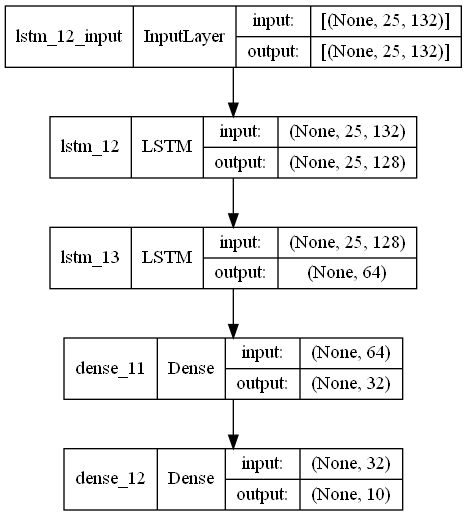

In [90]:
# Visualize
plot_model(lstm2_dense2_rd2_lr5_e1_5k_b32, to_file = "arc_lstm2_dense2_rd2_lr5_e1_5k_b32_1830_18032022.png", show_shapes = True)

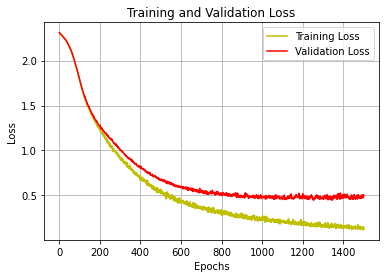

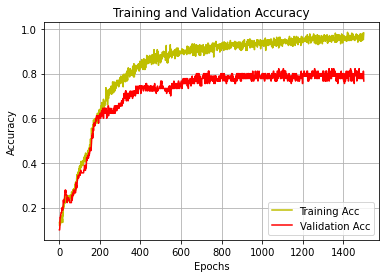

In [443]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [444]:
res = lstm2_dense2_rd2_lr5_e1_5k_b32.predict(X_test)

In [445]:
yhat = lstm2_dense2_rd2_lr5_e1_5k_b32.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [446]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[3 2 4 0 0 0 0 0 0 0]
 [3 5 1 0 0 0 0 0 0 0]
 [3 0 6 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 2 1 0 5 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 3 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 9]]


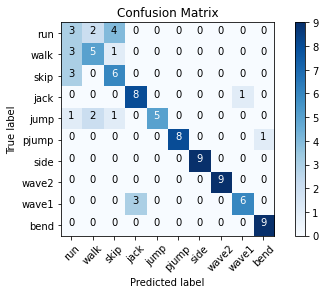

In [447]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [448]:
y_pred = lstm2_dense2_rd2_lr5_e1_5k_b32.predict(X_test)
y_pred = (y_pred > 0.5)

In [449]:
_, acc = lstm2_dense2_rd2_lr5_e1_5k_b32.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 20ms/step - loss: 0.7375 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [460]:
loss, acc = lstm2_dense2_rd2_lr5_e1_5k_b32.evaluate(X_test, y_test, verbose=2)
print("Accuracy = ", (acc*100), " %")
print("Loss = ", loss)

3/3 - 0s - loss: 0.7375 - categorical_accuracy: 0.7556 - 87ms/epoch - 29ms/step
Accuracy =  75.55555701255798  %
Loss =  0.73746657371521


In [450]:
accuracy_score(ytrue, yhat)

0.7555555555555555

In [451]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.30      0.33      0.32         9
        walk       0.56      0.56      0.56         9
        skip       0.50      0.67      0.57         9
        jack       0.73      0.89      0.80         9
        jump       1.00      0.56      0.71         9
       pjump       1.00      0.89      0.94         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.86      0.67      0.75         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.76        90
   macro avg       0.78      0.76      0.76        90
weighted avg       0.78      0.76      0.76        90



# lstm2_dense2_wd_rd2_lr5_e1k_b16
lstm2 (256,128) + dense2 (64,10) + activation=default + nadam + epochs=1000 + recurrent_dropout=0.2 + lr=0.00001 + batch=16 -> overfit, maybe e500 enough

In [462]:
# Define a sequential model
lstm2_dense2_wd_rd2_lr5_e1k_b16 = Sequential([
    LSTM(256, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(128, recurrent_dropout=0.2, return_sequences=False),
    Dense(64, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [463]:
# Compile model with learning rate
lstm2_dense2_wd_rd2_lr5_e1k_b16.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [464]:
# Training model with validation
history = lstm2_dense2_wd_rd2_lr5_e1k_b16.fit(X_train, y_train, batch_size=16, epochs=1000, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/1000
17/17 - 46s - loss: 2.3173 - categorical_accuracy: 0.0963 - val_loss: 2.3139 - val_categorical_accuracy: 0.1000 - 46s/epoch - 3s/step
Epoch 2/1000
17/17 - 4s - loss: 2.3107 - categorical_accuracy: 0.0963 - val_loss: 2.3066 - val_categorical_accuracy: 0.1111 - 4s/epoch - 245ms/step
Epoch 3/1000
17/17 - 4s - loss: 2.3024 - categorical_accuracy: 0.1148 - val_loss: 2.2991 - val_categorical_accuracy: 0.1000 - 4s/epoch - 244ms/step
Epoch 4/1000
17/17 - 4s - loss: 2.2961 - categorical_accuracy: 0.0926 - val_loss: 2.2922 - val_categorical_accuracy: 0.1222 - 4s/epoch - 250ms/step
Epoch 5/1000
17/17 - 4s - loss: 2.2874 - categorical_accuracy: 0.1074 - val_loss: 2.2865 - val_categorical_accuracy: 0.1222 - 4s/epoch - 254ms/step
Epoch 6/1000
17/17 - 4s - loss: 2.2818 - categorical_accuracy: 0.1037 - val_loss: 2.2810 - val_categorical_accuracy: 0.1111 - 4s/epoch - 256ms/step
Epoch 7/1000
17/17 - 4s - loss: 2.2775 - categorical_accuracy: 0.1074 - val_loss: 2.2755 - val_categorical_accura

17/17 - 5s - loss: 1.3201 - categorical_accuracy: 0.6185 - val_loss: 1.3829 - val_categorical_accuracy: 0.5667 - 5s/epoch - 277ms/step
Epoch 57/1000
17/17 - 4s - loss: 1.2999 - categorical_accuracy: 0.6407 - val_loss: 1.3645 - val_categorical_accuracy: 0.5556 - 4s/epoch - 261ms/step
Epoch 58/1000
17/17 - 4s - loss: 1.2796 - categorical_accuracy: 0.6444 - val_loss: 1.3648 - val_categorical_accuracy: 0.5667 - 4s/epoch - 263ms/step
Epoch 59/1000
17/17 - 4s - loss: 1.2593 - categorical_accuracy: 0.6630 - val_loss: 1.3327 - val_categorical_accuracy: 0.6000 - 4s/epoch - 264ms/step
Epoch 60/1000
17/17 - 4s - loss: 1.2402 - categorical_accuracy: 0.6222 - val_loss: 1.3350 - val_categorical_accuracy: 0.5889 - 4s/epoch - 258ms/step
Epoch 61/1000
17/17 - 5s - loss: 1.2281 - categorical_accuracy: 0.6296 - val_loss: 1.3086 - val_categorical_accuracy: 0.5778 - 5s/epoch - 280ms/step
Epoch 62/1000
17/17 - 4s - loss: 1.2255 - categorical_accuracy: 0.6407 - val_loss: 1.2868 - val_categorical_accuracy: 0.

17/17 - 4s - loss: 0.7521 - categorical_accuracy: 0.7704 - val_loss: 0.8860 - val_categorical_accuracy: 0.6778 - 4s/epoch - 259ms/step
Epoch 112/1000
17/17 - 5s - loss: 0.7521 - categorical_accuracy: 0.7963 - val_loss: 0.8791 - val_categorical_accuracy: 0.6778 - 5s/epoch - 265ms/step
Epoch 113/1000
17/17 - 4s - loss: 0.7240 - categorical_accuracy: 0.8000 - val_loss: 0.8758 - val_categorical_accuracy: 0.6556 - 4s/epoch - 258ms/step
Epoch 114/1000
17/17 - 5s - loss: 0.7455 - categorical_accuracy: 0.7963 - val_loss: 0.8724 - val_categorical_accuracy: 0.6556 - 5s/epoch - 274ms/step
Epoch 115/1000
17/17 - 5s - loss: 0.7201 - categorical_accuracy: 0.7963 - val_loss: 0.8891 - val_categorical_accuracy: 0.6667 - 5s/epoch - 265ms/step
Epoch 116/1000
17/17 - 5s - loss: 0.7154 - categorical_accuracy: 0.8074 - val_loss: 0.8642 - val_categorical_accuracy: 0.6667 - 5s/epoch - 267ms/step
Epoch 117/1000
17/17 - 4s - loss: 0.7160 - categorical_accuracy: 0.8000 - val_loss: 0.8553 - val_categorical_accura

Epoch 166/1000
17/17 - 5s - loss: 0.5253 - categorical_accuracy: 0.8556 - val_loss: 0.6706 - val_categorical_accuracy: 0.7333 - 5s/epoch - 271ms/step
Epoch 167/1000
17/17 - 4s - loss: 0.5122 - categorical_accuracy: 0.8667 - val_loss: 0.6788 - val_categorical_accuracy: 0.7222 - 4s/epoch - 260ms/step
Epoch 168/1000
17/17 - 4s - loss: 0.5145 - categorical_accuracy: 0.8519 - val_loss: 0.6961 - val_categorical_accuracy: 0.7000 - 4s/epoch - 260ms/step
Epoch 169/1000
17/17 - 4s - loss: 0.5064 - categorical_accuracy: 0.8852 - val_loss: 0.6760 - val_categorical_accuracy: 0.7556 - 4s/epoch - 260ms/step
Epoch 170/1000
17/17 - 5s - loss: 0.5234 - categorical_accuracy: 0.8556 - val_loss: 0.6899 - val_categorical_accuracy: 0.7444 - 5s/epoch - 267ms/step
Epoch 171/1000
17/17 - 4s - loss: 0.5084 - categorical_accuracy: 0.8593 - val_loss: 0.6748 - val_categorical_accuracy: 0.7222 - 4s/epoch - 263ms/step
Epoch 172/1000
17/17 - 4s - loss: 0.5108 - categorical_accuracy: 0.8556 - val_loss: 0.6777 - val_cat

Epoch 221/1000
17/17 - 5s - loss: 0.3637 - categorical_accuracy: 0.9037 - val_loss: 0.5881 - val_categorical_accuracy: 0.7667 - 5s/epoch - 265ms/step
Epoch 222/1000
17/17 - 4s - loss: 0.3911 - categorical_accuracy: 0.8778 - val_loss: 0.5880 - val_categorical_accuracy: 0.7667 - 4s/epoch - 262ms/step
Epoch 223/1000
17/17 - 5s - loss: 0.3895 - categorical_accuracy: 0.9000 - val_loss: 0.5883 - val_categorical_accuracy: 0.7889 - 5s/epoch - 265ms/step
Epoch 224/1000
17/17 - 4s - loss: 0.3872 - categorical_accuracy: 0.8704 - val_loss: 0.5898 - val_categorical_accuracy: 0.7556 - 4s/epoch - 261ms/step
Epoch 225/1000
17/17 - 5s - loss: 0.3758 - categorical_accuracy: 0.9000 - val_loss: 0.5905 - val_categorical_accuracy: 0.7667 - 5s/epoch - 267ms/step
Epoch 226/1000
17/17 - 4s - loss: 0.3810 - categorical_accuracy: 0.9111 - val_loss: 0.5828 - val_categorical_accuracy: 0.7556 - 4s/epoch - 263ms/step
Epoch 227/1000
17/17 - 4s - loss: 0.3861 - categorical_accuracy: 0.8815 - val_loss: 0.5859 - val_cat

Epoch 276/1000
17/17 - 4s - loss: 0.3185 - categorical_accuracy: 0.8889 - val_loss: 0.5244 - val_categorical_accuracy: 0.7889 - 4s/epoch - 258ms/step
Epoch 277/1000
17/17 - 4s - loss: 0.2934 - categorical_accuracy: 0.9111 - val_loss: 0.5303 - val_categorical_accuracy: 0.8111 - 4s/epoch - 256ms/step
Epoch 278/1000
17/17 - 4s - loss: 0.3152 - categorical_accuracy: 0.9222 - val_loss: 0.5403 - val_categorical_accuracy: 0.7444 - 4s/epoch - 263ms/step
Epoch 279/1000
17/17 - 4s - loss: 0.3081 - categorical_accuracy: 0.9111 - val_loss: 0.5271 - val_categorical_accuracy: 0.7667 - 4s/epoch - 263ms/step
Epoch 280/1000
17/17 - 4s - loss: 0.2959 - categorical_accuracy: 0.9296 - val_loss: 0.5348 - val_categorical_accuracy: 0.7778 - 4s/epoch - 257ms/step
Epoch 281/1000
17/17 - 4s - loss: 0.3024 - categorical_accuracy: 0.9185 - val_loss: 0.5284 - val_categorical_accuracy: 0.8000 - 4s/epoch - 259ms/step
Epoch 282/1000
17/17 - 4s - loss: 0.3115 - categorical_accuracy: 0.9037 - val_loss: 0.5181 - val_cat

Epoch 331/1000
17/17 - 5s - loss: 0.2499 - categorical_accuracy: 0.9185 - val_loss: 0.4844 - val_categorical_accuracy: 0.7889 - 5s/epoch - 267ms/step
Epoch 332/1000
17/17 - 4s - loss: 0.2306 - categorical_accuracy: 0.9370 - val_loss: 0.4672 - val_categorical_accuracy: 0.8000 - 4s/epoch - 263ms/step
Epoch 333/1000
17/17 - 5s - loss: 0.2482 - categorical_accuracy: 0.9333 - val_loss: 0.4797 - val_categorical_accuracy: 0.7778 - 5s/epoch - 278ms/step
Epoch 334/1000
17/17 - 5s - loss: 0.2435 - categorical_accuracy: 0.9370 - val_loss: 0.4843 - val_categorical_accuracy: 0.8000 - 5s/epoch - 265ms/step
Epoch 335/1000
17/17 - 5s - loss: 0.2364 - categorical_accuracy: 0.9481 - val_loss: 0.4933 - val_categorical_accuracy: 0.7889 - 5s/epoch - 265ms/step
Epoch 336/1000
17/17 - 4s - loss: 0.2505 - categorical_accuracy: 0.9259 - val_loss: 0.4852 - val_categorical_accuracy: 0.7667 - 4s/epoch - 261ms/step
Epoch 337/1000
17/17 - 5s - loss: 0.2453 - categorical_accuracy: 0.9222 - val_loss: 0.4783 - val_cat

Epoch 386/1000
17/17 - 4s - loss: 0.2159 - categorical_accuracy: 0.9519 - val_loss: 0.4765 - val_categorical_accuracy: 0.7778 - 4s/epoch - 263ms/step
Epoch 387/1000
17/17 - 4s - loss: 0.1816 - categorical_accuracy: 0.9519 - val_loss: 0.4754 - val_categorical_accuracy: 0.8111 - 4s/epoch - 260ms/step
Epoch 388/1000
17/17 - 4s - loss: 0.1896 - categorical_accuracy: 0.9519 - val_loss: 0.4683 - val_categorical_accuracy: 0.8333 - 4s/epoch - 258ms/step
Epoch 389/1000
17/17 - 4s - loss: 0.1985 - categorical_accuracy: 0.9407 - val_loss: 0.4633 - val_categorical_accuracy: 0.8000 - 4s/epoch - 259ms/step
Epoch 390/1000
17/17 - 4s - loss: 0.1943 - categorical_accuracy: 0.9481 - val_loss: 0.4563 - val_categorical_accuracy: 0.8111 - 4s/epoch - 257ms/step
Epoch 391/1000
17/17 - 5s - loss: 0.2353 - categorical_accuracy: 0.9111 - val_loss: 0.4632 - val_categorical_accuracy: 0.8000 - 5s/epoch - 269ms/step
Epoch 392/1000
17/17 - 4s - loss: 0.2037 - categorical_accuracy: 0.9444 - val_loss: 0.4621 - val_cat

Epoch 441/1000
17/17 - 4s - loss: 0.1734 - categorical_accuracy: 0.9519 - val_loss: 0.4511 - val_categorical_accuracy: 0.7889 - 4s/epoch - 260ms/step
Epoch 442/1000
17/17 - 4s - loss: 0.1948 - categorical_accuracy: 0.9444 - val_loss: 0.4508 - val_categorical_accuracy: 0.8333 - 4s/epoch - 257ms/step
Epoch 443/1000
17/17 - 4s - loss: 0.1761 - categorical_accuracy: 0.9630 - val_loss: 0.4367 - val_categorical_accuracy: 0.8111 - 4s/epoch - 259ms/step
Epoch 444/1000
17/17 - 4s - loss: 0.1928 - categorical_accuracy: 0.9481 - val_loss: 0.4452 - val_categorical_accuracy: 0.8000 - 4s/epoch - 259ms/step
Epoch 445/1000
17/17 - 4s - loss: 0.1663 - categorical_accuracy: 0.9481 - val_loss: 0.4435 - val_categorical_accuracy: 0.8000 - 4s/epoch - 256ms/step
Epoch 446/1000
17/17 - 4s - loss: 0.1487 - categorical_accuracy: 0.9704 - val_loss: 0.4461 - val_categorical_accuracy: 0.8333 - 4s/epoch - 264ms/step
Epoch 447/1000
17/17 - 5s - loss: 0.1715 - categorical_accuracy: 0.9481 - val_loss: 0.4617 - val_cat

Epoch 496/1000
17/17 - 4s - loss: 0.1431 - categorical_accuracy: 0.9593 - val_loss: 0.4626 - val_categorical_accuracy: 0.8222 - 4s/epoch - 259ms/step
Epoch 497/1000
17/17 - 4s - loss: 0.1210 - categorical_accuracy: 0.9778 - val_loss: 0.4636 - val_categorical_accuracy: 0.8111 - 4s/epoch - 259ms/step
Epoch 498/1000
17/17 - 4s - loss: 0.1470 - categorical_accuracy: 0.9593 - val_loss: 0.4406 - val_categorical_accuracy: 0.8000 - 4s/epoch - 257ms/step
Epoch 499/1000
17/17 - 4s - loss: 0.1374 - categorical_accuracy: 0.9630 - val_loss: 0.4703 - val_categorical_accuracy: 0.8000 - 4s/epoch - 259ms/step
Epoch 500/1000
17/17 - 4s - loss: 0.1377 - categorical_accuracy: 0.9704 - val_loss: 0.4390 - val_categorical_accuracy: 0.8222 - 4s/epoch - 257ms/step
Epoch 501/1000
17/17 - 5s - loss: 0.1496 - categorical_accuracy: 0.9630 - val_loss: 0.4321 - val_categorical_accuracy: 0.8333 - 5s/epoch - 270ms/step
Epoch 502/1000
17/17 - 4s - loss: 0.1421 - categorical_accuracy: 0.9630 - val_loss: 0.4409 - val_cat

Epoch 551/1000
17/17 - 4s - loss: 0.1376 - categorical_accuracy: 0.9667 - val_loss: 0.4502 - val_categorical_accuracy: 0.8333 - 4s/epoch - 257ms/step
Epoch 552/1000
17/17 - 4s - loss: 0.1264 - categorical_accuracy: 0.9667 - val_loss: 0.4296 - val_categorical_accuracy: 0.8222 - 4s/epoch - 257ms/step
Epoch 553/1000
17/17 - 4s - loss: 0.1072 - categorical_accuracy: 0.9852 - val_loss: 0.4425 - val_categorical_accuracy: 0.8444 - 4s/epoch - 254ms/step
Epoch 554/1000
17/17 - 4s - loss: 0.1316 - categorical_accuracy: 0.9667 - val_loss: 0.4384 - val_categorical_accuracy: 0.8111 - 4s/epoch - 257ms/step
Epoch 555/1000
17/17 - 4s - loss: 0.1297 - categorical_accuracy: 0.9630 - val_loss: 0.4768 - val_categorical_accuracy: 0.8222 - 4s/epoch - 264ms/step
Epoch 556/1000
17/17 - 4s - loss: 0.1066 - categorical_accuracy: 0.9741 - val_loss: 0.4709 - val_categorical_accuracy: 0.8222 - 4s/epoch - 257ms/step
Epoch 557/1000
17/17 - 5s - loss: 0.1097 - categorical_accuracy: 0.9741 - val_loss: 0.4790 - val_cat

Epoch 606/1000
17/17 - 4s - loss: 0.1144 - categorical_accuracy: 0.9741 - val_loss: 0.4902 - val_categorical_accuracy: 0.8222 - 4s/epoch - 260ms/step
Epoch 607/1000
17/17 - 4s - loss: 0.0864 - categorical_accuracy: 0.9963 - val_loss: 0.4733 - val_categorical_accuracy: 0.7889 - 4s/epoch - 259ms/step
Epoch 608/1000
17/17 - 4s - loss: 0.0902 - categorical_accuracy: 0.9889 - val_loss: 0.4436 - val_categorical_accuracy: 0.7889 - 4s/epoch - 254ms/step
Epoch 609/1000
17/17 - 5s - loss: 0.1038 - categorical_accuracy: 0.9778 - val_loss: 0.4434 - val_categorical_accuracy: 0.8556 - 5s/epoch - 265ms/step
Epoch 610/1000
17/17 - 4s - loss: 0.0981 - categorical_accuracy: 0.9815 - val_loss: 0.4703 - val_categorical_accuracy: 0.7889 - 4s/epoch - 261ms/step
Epoch 611/1000
17/17 - 5s - loss: 0.1025 - categorical_accuracy: 0.9593 - val_loss: 0.4490 - val_categorical_accuracy: 0.8556 - 5s/epoch - 268ms/step
Epoch 612/1000
17/17 - 4s - loss: 0.0934 - categorical_accuracy: 0.9852 - val_loss: 0.4372 - val_cat

Epoch 661/1000
17/17 - 5s - loss: 0.0742 - categorical_accuracy: 0.9926 - val_loss: 0.4448 - val_categorical_accuracy: 0.8333 - 5s/epoch - 288ms/step
Epoch 662/1000
17/17 - 5s - loss: 0.0970 - categorical_accuracy: 0.9778 - val_loss: 0.4525 - val_categorical_accuracy: 0.8111 - 5s/epoch - 299ms/step
Epoch 663/1000
17/17 - 5s - loss: 0.0922 - categorical_accuracy: 0.9667 - val_loss: 0.5039 - val_categorical_accuracy: 0.8000 - 5s/epoch - 293ms/step
Epoch 664/1000
17/17 - 5s - loss: 0.0846 - categorical_accuracy: 0.9852 - val_loss: 0.4786 - val_categorical_accuracy: 0.8000 - 5s/epoch - 269ms/step
Epoch 665/1000
17/17 - 4s - loss: 0.0679 - categorical_accuracy: 0.9926 - val_loss: 0.4562 - val_categorical_accuracy: 0.8444 - 4s/epoch - 260ms/step
Epoch 666/1000
17/17 - 5s - loss: 0.0884 - categorical_accuracy: 0.9741 - val_loss: 0.4644 - val_categorical_accuracy: 0.8000 - 5s/epoch - 283ms/step
Epoch 667/1000
17/17 - 5s - loss: 0.0756 - categorical_accuracy: 0.9852 - val_loss: 0.4721 - val_cat

Epoch 716/1000
17/17 - 4s - loss: 0.0697 - categorical_accuracy: 0.9889 - val_loss: 0.4680 - val_categorical_accuracy: 0.8333 - 4s/epoch - 248ms/step
Epoch 717/1000
17/17 - 5s - loss: 0.0689 - categorical_accuracy: 0.9852 - val_loss: 0.4733 - val_categorical_accuracy: 0.8111 - 5s/epoch - 265ms/step
Epoch 718/1000
17/17 - 4s - loss: 0.0568 - categorical_accuracy: 0.9926 - val_loss: 0.4693 - val_categorical_accuracy: 0.8222 - 4s/epoch - 248ms/step
Epoch 719/1000
17/17 - 4s - loss: 0.0659 - categorical_accuracy: 0.9926 - val_loss: 0.4604 - val_categorical_accuracy: 0.8444 - 4s/epoch - 249ms/step
Epoch 720/1000
17/17 - 4s - loss: 0.0671 - categorical_accuracy: 0.9889 - val_loss: 0.4573 - val_categorical_accuracy: 0.8111 - 4s/epoch - 254ms/step
Epoch 721/1000
17/17 - 4s - loss: 0.0825 - categorical_accuracy: 0.9741 - val_loss: 0.4978 - val_categorical_accuracy: 0.7889 - 4s/epoch - 249ms/step
Epoch 722/1000
17/17 - 4s - loss: 0.0856 - categorical_accuracy: 0.9815 - val_loss: 0.4738 - val_cat

Epoch 771/1000
17/17 - 4s - loss: 0.0462 - categorical_accuracy: 1.0000 - val_loss: 0.5236 - val_categorical_accuracy: 0.8333 - 4s/epoch - 250ms/step
Epoch 772/1000
17/17 - 4s - loss: 0.0466 - categorical_accuracy: 1.0000 - val_loss: 0.5024 - val_categorical_accuracy: 0.8444 - 4s/epoch - 250ms/step
Epoch 773/1000
17/17 - 5s - loss: 0.0588 - categorical_accuracy: 0.9926 - val_loss: 0.4942 - val_categorical_accuracy: 0.8111 - 5s/epoch - 269ms/step
Epoch 774/1000
17/17 - 4s - loss: 0.0480 - categorical_accuracy: 0.9926 - val_loss: 0.4917 - val_categorical_accuracy: 0.8111 - 4s/epoch - 248ms/step
Epoch 775/1000
17/17 - 4s - loss: 0.0575 - categorical_accuracy: 0.9889 - val_loss: 0.4982 - val_categorical_accuracy: 0.8333 - 4s/epoch - 255ms/step
Epoch 776/1000
17/17 - 4s - loss: 0.0607 - categorical_accuracy: 0.9926 - val_loss: 0.5857 - val_categorical_accuracy: 0.8000 - 4s/epoch - 247ms/step
Epoch 777/1000
17/17 - 4s - loss: 0.0576 - categorical_accuracy: 0.9889 - val_loss: 0.5071 - val_cat

Epoch 826/1000
17/17 - 5s - loss: 0.0491 - categorical_accuracy: 0.9852 - val_loss: 0.5314 - val_categorical_accuracy: 0.8333 - 5s/epoch - 277ms/step
Epoch 827/1000
17/17 - 5s - loss: 0.0397 - categorical_accuracy: 0.9926 - val_loss: 0.5342 - val_categorical_accuracy: 0.8444 - 5s/epoch - 269ms/step
Epoch 828/1000
17/17 - 5s - loss: 0.0406 - categorical_accuracy: 0.9963 - val_loss: 0.5265 - val_categorical_accuracy: 0.8222 - 5s/epoch - 274ms/step
Epoch 829/1000
17/17 - 5s - loss: 0.0629 - categorical_accuracy: 0.9704 - val_loss: 0.5003 - val_categorical_accuracy: 0.8556 - 5s/epoch - 279ms/step
Epoch 830/1000
17/17 - 5s - loss: 0.0441 - categorical_accuracy: 0.9926 - val_loss: 0.5003 - val_categorical_accuracy: 0.8444 - 5s/epoch - 271ms/step
Epoch 831/1000
17/17 - 5s - loss: 0.0575 - categorical_accuracy: 0.9889 - val_loss: 0.5570 - val_categorical_accuracy: 0.8222 - 5s/epoch - 275ms/step
Epoch 832/1000
17/17 - 5s - loss: 0.0572 - categorical_accuracy: 0.9815 - val_loss: 0.5654 - val_cat

Epoch 881/1000
17/17 - 5s - loss: 0.0408 - categorical_accuracy: 0.9926 - val_loss: 0.5548 - val_categorical_accuracy: 0.8000 - 5s/epoch - 279ms/step
Epoch 882/1000
17/17 - 5s - loss: 0.0333 - categorical_accuracy: 0.9963 - val_loss: 0.5443 - val_categorical_accuracy: 0.8111 - 5s/epoch - 270ms/step
Epoch 883/1000
17/17 - 5s - loss: 0.0365 - categorical_accuracy: 0.9926 - val_loss: 0.5572 - val_categorical_accuracy: 0.8000 - 5s/epoch - 266ms/step
Epoch 884/1000
17/17 - 5s - loss: 0.0353 - categorical_accuracy: 0.9926 - val_loss: 0.5597 - val_categorical_accuracy: 0.8000 - 5s/epoch - 273ms/step
Epoch 885/1000
17/17 - 5s - loss: 0.0572 - categorical_accuracy: 0.9889 - val_loss: 0.5261 - val_categorical_accuracy: 0.8333 - 5s/epoch - 267ms/step
Epoch 886/1000
17/17 - 5s - loss: 0.0557 - categorical_accuracy: 0.9815 - val_loss: 0.5454 - val_categorical_accuracy: 0.8222 - 5s/epoch - 266ms/step
Epoch 887/1000
17/17 - 5s - loss: 0.0269 - categorical_accuracy: 1.0000 - val_loss: 0.5512 - val_cat

Epoch 936/1000
17/17 - 5s - loss: 0.0338 - categorical_accuracy: 1.0000 - val_loss: 0.5245 - val_categorical_accuracy: 0.8333 - 5s/epoch - 267ms/step
Epoch 937/1000
17/17 - 5s - loss: 0.0371 - categorical_accuracy: 0.9926 - val_loss: 0.5283 - val_categorical_accuracy: 0.8000 - 5s/epoch - 270ms/step
Epoch 938/1000
17/17 - 5s - loss: 0.0442 - categorical_accuracy: 0.9889 - val_loss: 0.6213 - val_categorical_accuracy: 0.8222 - 5s/epoch - 274ms/step
Epoch 939/1000
17/17 - 5s - loss: 0.1021 - categorical_accuracy: 0.9704 - val_loss: 0.6363 - val_categorical_accuracy: 0.7667 - 5s/epoch - 269ms/step
Epoch 940/1000
17/17 - 5s - loss: 0.0353 - categorical_accuracy: 0.9963 - val_loss: 0.5639 - val_categorical_accuracy: 0.7889 - 5s/epoch - 274ms/step
Epoch 941/1000
17/17 - 5s - loss: 0.0294 - categorical_accuracy: 1.0000 - val_loss: 0.5664 - val_categorical_accuracy: 0.8556 - 5s/epoch - 268ms/step
Epoch 942/1000
17/17 - 5s - loss: 0.0353 - categorical_accuracy: 0.9926 - val_loss: 0.6058 - val_cat

Epoch 991/1000
17/17 - 5s - loss: 0.0340 - categorical_accuracy: 0.9926 - val_loss: 0.5958 - val_categorical_accuracy: 0.8000 - 5s/epoch - 281ms/step
Epoch 992/1000
17/17 - 5s - loss: 0.0449 - categorical_accuracy: 0.9889 - val_loss: 0.5661 - val_categorical_accuracy: 0.8444 - 5s/epoch - 271ms/step
Epoch 993/1000
17/17 - 5s - loss: 0.0398 - categorical_accuracy: 0.9926 - val_loss: 0.6298 - val_categorical_accuracy: 0.8000 - 5s/epoch - 270ms/step
Epoch 994/1000
17/17 - 5s - loss: 0.0577 - categorical_accuracy: 0.9889 - val_loss: 0.6812 - val_categorical_accuracy: 0.7889 - 5s/epoch - 280ms/step
Epoch 995/1000
17/17 - 5s - loss: 0.0375 - categorical_accuracy: 0.9926 - val_loss: 0.5534 - val_categorical_accuracy: 0.8333 - 5s/epoch - 283ms/step
Epoch 996/1000
17/17 - 5s - loss: 0.0331 - categorical_accuracy: 0.9963 - val_loss: 0.5486 - val_categorical_accuracy: 0.8444 - 5s/epoch - 266ms/step
Epoch 997/1000
17/17 - 4s - loss: 0.0326 - categorical_accuracy: 0.9926 - val_loss: 0.5590 - val_cat

In [465]:
lstm2_dense2_wd_rd2_lr5_e1k_b16.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 25, 256)           398336    
                                                                 
 lstm_65 (LSTM)              (None, 128)               197120    
                                                                 
 dense_63 (Dense)            (None, 64)                8256      
                                                                 
 dense_64 (Dense)            (None, 10)                650       
                                                                 
Total params: 604,362
Trainable params: 604,362
Non-trainable params: 0
_________________________________________________________________


In [466]:
# Save Model
lstm2_dense2_wd_rd2_lr5_e1k_b16.save("lstm2_dense2_wd_rd2_lr5_e1k_b16_1938_18032022.h5")

In [467]:
# Load Model
lstm2_dense2_wd_rd2_lr5_e1k_b16.load_weights("lstm2_dense2_wd_rd2_lr5_e1k_b16_1938_18032022.h5")

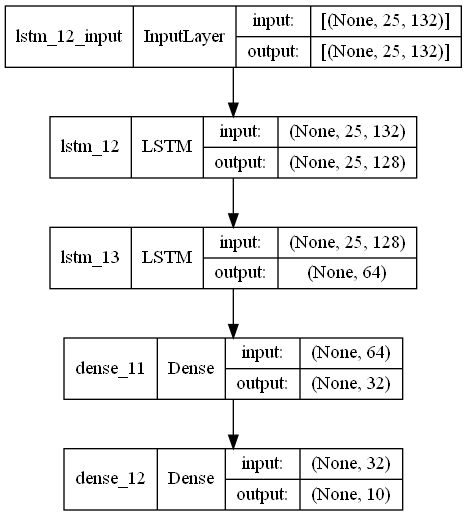

In [90]:
# Visualize
plot_model(lstm2_dense2_wd_rd2_lr5_e1k_b16, to_file = "arc_lstm2_dense2_wd_rd2_lr5_e1k_b16_1938_18032022.png", show_shapes = True)

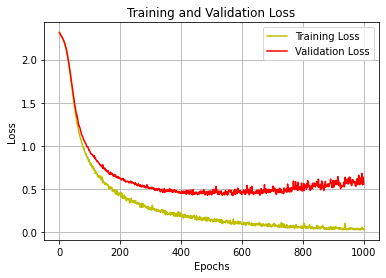

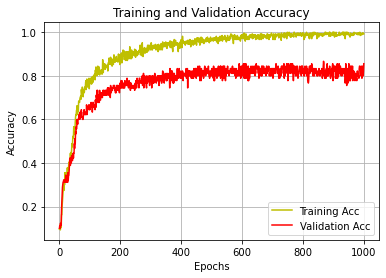

In [468]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [469]:
res = lstm2_dense2_wd_rd2_lr5_e1k_b16.predict(X_test)

In [470]:
yhat = lstm2_dense2_wd_rd2_lr5_e1k_b16.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [471]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 2 0 1 0 0 0 0 0]
 [2 6 0 0 1 0 0 0 0 0]
 [5 1 2 0 1 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 6 1 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 3 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 9]]


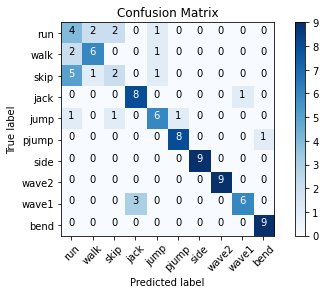

In [472]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [473]:
y_pred = lstm2_dense2_wd_rd2_lr5_e1k_b16.predict(X_test)
y_pred = (y_pred > 0.5)

In [474]:
_, acc = lstm2_dense2_wd_rd2_lr5_e1k_b16.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 57ms/step - loss: 1.0758 - categorical_accuracy: 0.7444
Accuracy =  74.44444298744202  %


In [475]:
accuracy_score(ytrue, yhat)

0.7444444444444445

In [476]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.33      0.44      0.38         9
        walk       0.67      0.67      0.67         9
        skip       0.40      0.22      0.29         9
        jack       0.73      0.89      0.80         9
        jump       0.67      0.67      0.67         9
       pjump       0.89      0.89      0.89         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.86      0.67      0.75         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.74        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.74      0.74      0.74        90



# lstm2_dense2_wd_rd2_lr5_e500_b16
lstm2 (256,128) + dense2 (64,10) + activation=default + nadam + epochs=500 + recurrent_dropout=0.2 + lr=0.00001 + batch=16 -> overfit, maybe e500 enough

In [477]:
# Define a sequential model
lstm2_dense2_wd_rd2_lr5_e500_b16 = Sequential([
    LSTM(256, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(128, recurrent_dropout=0.2, return_sequences=False),
    Dense(64, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [478]:
# Compile model with learning rate
lstm2_dense2_wd_rd2_lr5_e500_b16.compile(Nadam(learning_rate=0.00001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [479]:
# Training model with validation
history = lstm2_dense2_wd_rd2_lr5_e500_b16.fit(X_train, y_train, batch_size=16, epochs=500, shuffle=True, verbose=2,
                                                  validation_data=(X_valid, y_valid))

Epoch 1/500
17/17 - 13s - loss: 2.3277 - categorical_accuracy: 0.0926 - val_loss: 2.3238 - val_categorical_accuracy: 0.1000 - 13s/epoch - 750ms/step
Epoch 2/500
17/17 - 4s - loss: 2.3108 - categorical_accuracy: 0.1037 - val_loss: 2.3102 - val_categorical_accuracy: 0.0778 - 4s/epoch - 246ms/step
Epoch 3/500
17/17 - 4s - loss: 2.3019 - categorical_accuracy: 0.1000 - val_loss: 2.3002 - val_categorical_accuracy: 0.1000 - 4s/epoch - 242ms/step
Epoch 4/500
17/17 - 4s - loss: 2.2928 - categorical_accuracy: 0.1074 - val_loss: 2.2924 - val_categorical_accuracy: 0.1111 - 4s/epoch - 243ms/step
Epoch 5/500
17/17 - 4s - loss: 2.2822 - categorical_accuracy: 0.1148 - val_loss: 2.2859 - val_categorical_accuracy: 0.1222 - 4s/epoch - 243ms/step
Epoch 6/500
17/17 - 4s - loss: 2.2747 - categorical_accuracy: 0.1074 - val_loss: 2.2796 - val_categorical_accuracy: 0.1333 - 4s/epoch - 244ms/step
Epoch 7/500
17/17 - 4s - loss: 2.2693 - categorical_accuracy: 0.1481 - val_loss: 2.2728 - val_categorical_accuracy: 

Epoch 57/500
17/17 - 4s - loss: 1.1888 - categorical_accuracy: 0.6556 - val_loss: 1.2689 - val_categorical_accuracy: 0.5667 - 4s/epoch - 248ms/step
Epoch 58/500
17/17 - 4s - loss: 1.1703 - categorical_accuracy: 0.6630 - val_loss: 1.2502 - val_categorical_accuracy: 0.5889 - 4s/epoch - 243ms/step
Epoch 59/500
17/17 - 4s - loss: 1.1493 - categorical_accuracy: 0.6741 - val_loss: 1.2285 - val_categorical_accuracy: 0.5444 - 4s/epoch - 244ms/step
Epoch 60/500
17/17 - 4s - loss: 1.1491 - categorical_accuracy: 0.6444 - val_loss: 1.2314 - val_categorical_accuracy: 0.5556 - 4s/epoch - 244ms/step
Epoch 61/500
17/17 - 4s - loss: 1.1261 - categorical_accuracy: 0.6593 - val_loss: 1.2015 - val_categorical_accuracy: 0.5778 - 4s/epoch - 243ms/step
Epoch 62/500
17/17 - 4s - loss: 1.1164 - categorical_accuracy: 0.6704 - val_loss: 1.1855 - val_categorical_accuracy: 0.5556 - 4s/epoch - 242ms/step
Epoch 63/500
17/17 - 4s - loss: 1.1216 - categorical_accuracy: 0.6630 - val_loss: 1.1919 - val_categorical_accur

Epoch 113/500
17/17 - 4s - loss: 0.6654 - categorical_accuracy: 0.7963 - val_loss: 0.8718 - val_categorical_accuracy: 0.6444 - 4s/epoch - 255ms/step
Epoch 114/500
17/17 - 4s - loss: 0.6602 - categorical_accuracy: 0.8148 - val_loss: 0.8525 - val_categorical_accuracy: 0.6333 - 4s/epoch - 242ms/step
Epoch 115/500
17/17 - 4s - loss: 0.6688 - categorical_accuracy: 0.8185 - val_loss: 0.9061 - val_categorical_accuracy: 0.6333 - 4s/epoch - 245ms/step
Epoch 116/500
17/17 - 4s - loss: 0.6688 - categorical_accuracy: 0.8074 - val_loss: 0.8804 - val_categorical_accuracy: 0.6222 - 4s/epoch - 242ms/step
Epoch 117/500
17/17 - 4s - loss: 0.6333 - categorical_accuracy: 0.8407 - val_loss: 0.8880 - val_categorical_accuracy: 0.6444 - 4s/epoch - 241ms/step
Epoch 118/500
17/17 - 4s - loss: 0.6532 - categorical_accuracy: 0.8259 - val_loss: 0.8436 - val_categorical_accuracy: 0.6556 - 4s/epoch - 242ms/step
Epoch 119/500
17/17 - 4s - loss: 0.6293 - categorical_accuracy: 0.8259 - val_loss: 0.8738 - val_categorica

Epoch 168/500
17/17 - 5s - loss: 0.4608 - categorical_accuracy: 0.8667 - val_loss: 0.7191 - val_categorical_accuracy: 0.6889 - 5s/epoch - 278ms/step
Epoch 169/500
17/17 - 5s - loss: 0.4320 - categorical_accuracy: 0.8815 - val_loss: 0.6834 - val_categorical_accuracy: 0.7000 - 5s/epoch - 294ms/step
Epoch 170/500
17/17 - 5s - loss: 0.4535 - categorical_accuracy: 0.8667 - val_loss: 0.6957 - val_categorical_accuracy: 0.6778 - 5s/epoch - 269ms/step
Epoch 171/500
17/17 - 4s - loss: 0.4584 - categorical_accuracy: 0.8704 - val_loss: 0.7084 - val_categorical_accuracy: 0.6778 - 4s/epoch - 256ms/step
Epoch 172/500
17/17 - 4s - loss: 0.4398 - categorical_accuracy: 0.8815 - val_loss: 0.6938 - val_categorical_accuracy: 0.7000 - 4s/epoch - 242ms/step
Epoch 173/500
17/17 - 5s - loss: 0.4713 - categorical_accuracy: 0.8667 - val_loss: 0.7050 - val_categorical_accuracy: 0.6889 - 5s/epoch - 273ms/step
Epoch 174/500
17/17 - 5s - loss: 0.4289 - categorical_accuracy: 0.8815 - val_loss: 0.6988 - val_categorica

Epoch 223/500
17/17 - 4s - loss: 0.3541 - categorical_accuracy: 0.9000 - val_loss: 0.6772 - val_categorical_accuracy: 0.6778 - 4s/epoch - 260ms/step
Epoch 224/500
17/17 - 4s - loss: 0.3421 - categorical_accuracy: 0.9111 - val_loss: 0.6288 - val_categorical_accuracy: 0.7111 - 4s/epoch - 265ms/step
Epoch 225/500
17/17 - 4s - loss: 0.3324 - categorical_accuracy: 0.9148 - val_loss: 0.6623 - val_categorical_accuracy: 0.6889 - 4s/epoch - 265ms/step
Epoch 226/500
17/17 - 5s - loss: 0.3292 - categorical_accuracy: 0.9037 - val_loss: 0.6745 - val_categorical_accuracy: 0.7111 - 5s/epoch - 267ms/step
Epoch 227/500
17/17 - 4s - loss: 0.3509 - categorical_accuracy: 0.9000 - val_loss: 0.6280 - val_categorical_accuracy: 0.7111 - 4s/epoch - 264ms/step
Epoch 228/500
17/17 - 5s - loss: 0.3252 - categorical_accuracy: 0.9148 - val_loss: 0.6393 - val_categorical_accuracy: 0.7000 - 5s/epoch - 274ms/step
Epoch 229/500
17/17 - 4s - loss: 0.3132 - categorical_accuracy: 0.9407 - val_loss: 0.6509 - val_categorica

Epoch 278/500
17/17 - 4s - loss: 0.2649 - categorical_accuracy: 0.9296 - val_loss: 0.6363 - val_categorical_accuracy: 0.7444 - 4s/epoch - 260ms/step
Epoch 279/500
17/17 - 4s - loss: 0.2814 - categorical_accuracy: 0.9259 - val_loss: 0.6690 - val_categorical_accuracy: 0.7222 - 4s/epoch - 258ms/step
Epoch 280/500
17/17 - 4s - loss: 0.2525 - categorical_accuracy: 0.9370 - val_loss: 0.6572 - val_categorical_accuracy: 0.7444 - 4s/epoch - 258ms/step
Epoch 281/500
17/17 - 5s - loss: 0.2651 - categorical_accuracy: 0.9444 - val_loss: 0.6313 - val_categorical_accuracy: 0.7333 - 5s/epoch - 274ms/step
Epoch 282/500
17/17 - 4s - loss: 0.2566 - categorical_accuracy: 0.9444 - val_loss: 0.6809 - val_categorical_accuracy: 0.7333 - 4s/epoch - 262ms/step
Epoch 283/500
17/17 - 4s - loss: 0.2824 - categorical_accuracy: 0.9296 - val_loss: 0.6489 - val_categorical_accuracy: 0.7333 - 4s/epoch - 262ms/step
Epoch 284/500
17/17 - 5s - loss: 0.2675 - categorical_accuracy: 0.9185 - val_loss: 0.6187 - val_categorica

Epoch 333/500
17/17 - 4s - loss: 0.2185 - categorical_accuracy: 0.9370 - val_loss: 0.6097 - val_categorical_accuracy: 0.7222 - 4s/epoch - 258ms/step
Epoch 334/500
17/17 - 5s - loss: 0.2011 - categorical_accuracy: 0.9556 - val_loss: 0.6377 - val_categorical_accuracy: 0.7444 - 5s/epoch - 280ms/step
Epoch 335/500
17/17 - 5s - loss: 0.1993 - categorical_accuracy: 0.9444 - val_loss: 0.6486 - val_categorical_accuracy: 0.7556 - 5s/epoch - 268ms/step
Epoch 336/500
17/17 - 4s - loss: 0.1972 - categorical_accuracy: 0.9481 - val_loss: 0.6157 - val_categorical_accuracy: 0.7444 - 4s/epoch - 264ms/step
Epoch 337/500
17/17 - 4s - loss: 0.2094 - categorical_accuracy: 0.9519 - val_loss: 0.6277 - val_categorical_accuracy: 0.7333 - 4s/epoch - 261ms/step
Epoch 338/500
17/17 - 4s - loss: 0.1985 - categorical_accuracy: 0.9630 - val_loss: 0.6324 - val_categorical_accuracy: 0.7444 - 4s/epoch - 260ms/step
Epoch 339/500
17/17 - 4s - loss: 0.1989 - categorical_accuracy: 0.9556 - val_loss: 0.6513 - val_categorica

Epoch 388/500
17/17 - 4s - loss: 0.1569 - categorical_accuracy: 0.9667 - val_loss: 0.6357 - val_categorical_accuracy: 0.7333 - 4s/epoch - 262ms/step
Epoch 389/500
17/17 - 4s - loss: 0.1637 - categorical_accuracy: 0.9593 - val_loss: 0.6378 - val_categorical_accuracy: 0.7444 - 4s/epoch - 253ms/step
Epoch 390/500
17/17 - 5s - loss: 0.1781 - categorical_accuracy: 0.9593 - val_loss: 0.6491 - val_categorical_accuracy: 0.7444 - 5s/epoch - 273ms/step
Epoch 391/500
17/17 - 4s - loss: 0.1796 - categorical_accuracy: 0.9630 - val_loss: 0.6606 - val_categorical_accuracy: 0.7444 - 4s/epoch - 259ms/step
Epoch 392/500
17/17 - 4s - loss: 0.1670 - categorical_accuracy: 0.9556 - val_loss: 0.6592 - val_categorical_accuracy: 0.7222 - 4s/epoch - 257ms/step
Epoch 393/500
17/17 - 4s - loss: 0.1310 - categorical_accuracy: 0.9778 - val_loss: 0.6595 - val_categorical_accuracy: 0.7556 - 4s/epoch - 245ms/step
Epoch 394/500
17/17 - 4s - loss: 0.1462 - categorical_accuracy: 0.9778 - val_loss: 0.6487 - val_categorica

Epoch 443/500
17/17 - 4s - loss: 0.1490 - categorical_accuracy: 0.9630 - val_loss: 0.6712 - val_categorical_accuracy: 0.7556 - 4s/epoch - 257ms/step
Epoch 444/500
17/17 - 4s - loss: 0.1522 - categorical_accuracy: 0.9593 - val_loss: 0.6110 - val_categorical_accuracy: 0.7556 - 4s/epoch - 259ms/step
Epoch 445/500
17/17 - 4s - loss: 0.1368 - categorical_accuracy: 0.9778 - val_loss: 0.6222 - val_categorical_accuracy: 0.7222 - 4s/epoch - 254ms/step
Epoch 446/500
17/17 - 5s - loss: 0.1333 - categorical_accuracy: 0.9704 - val_loss: 0.6197 - val_categorical_accuracy: 0.7667 - 5s/epoch - 299ms/step
Epoch 447/500
17/17 - 5s - loss: 0.1365 - categorical_accuracy: 0.9778 - val_loss: 0.6556 - val_categorical_accuracy: 0.7333 - 5s/epoch - 290ms/step
Epoch 448/500
17/17 - 5s - loss: 0.1443 - categorical_accuracy: 0.9556 - val_loss: 0.6289 - val_categorical_accuracy: 0.7556 - 5s/epoch - 275ms/step
Epoch 449/500
17/17 - 5s - loss: 0.1132 - categorical_accuracy: 0.9778 - val_loss: 0.6477 - val_categorica

Epoch 498/500
17/17 - 4s - loss: 0.1139 - categorical_accuracy: 0.9741 - val_loss: 0.6910 - val_categorical_accuracy: 0.7556 - 4s/epoch - 240ms/step
Epoch 499/500
17/17 - 4s - loss: 0.1076 - categorical_accuracy: 0.9778 - val_loss: 0.6528 - val_categorical_accuracy: 0.7667 - 4s/epoch - 241ms/step
Epoch 500/500
17/17 - 4s - loss: 0.1197 - categorical_accuracy: 0.9741 - val_loss: 0.7204 - val_categorical_accuracy: 0.7444 - 4s/epoch - 249ms/step


In [480]:
lstm2_dense2_wd_rd2_lr5_e500_b16.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 25, 256)           398336    
                                                                 
 lstm_67 (LSTM)              (None, 128)               197120    
                                                                 
 dense_65 (Dense)            (None, 64)                8256      
                                                                 
 dense_66 (Dense)            (None, 10)                650       
                                                                 
Total params: 604,362
Trainable params: 604,362
Non-trainable params: 0
_________________________________________________________________


In [481]:
# Save Model
lstm2_dense2_wd_rd2_lr5_e500_b16.save("lstm2_dense2_wd_rd2_lr5_e500_b16_2104_18032022.h5")

In [482]:
# Load Model
lstm2_dense2_wd_rd2_lr5_e500_b16.load_weights("lstm2_dense2_wd_rd2_lr5_e500_b16_2104_18032022.h5")

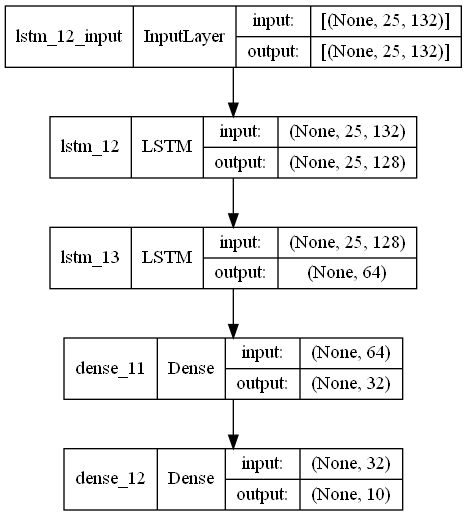

In [90]:
# Visualize
plot_model(lstm2_dense2_wd_rd2_lr5_e500_b16, to_file = "arc_lstm2_dense2_wd_rd2_lr5_e500_b16_2104_18032022.png", show_shapes = True)

In [ ]:
# Plot training and validation

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", zorder=3, label="Training Loss")
plt.plot(epochs, val_loss, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["categorical_accuracy"]
val_acc = history.history["val_categorical_accuracy"]
plt.plot(epochs, acc, "y", zorder=3, label="Training Acc")
plt.plot(epochs, val_acc, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [469]:
res = lstm2_dense2_wd_rd2_lr5_e500_b16.predict(X_test)

In [470]:
yhat = lstm2_dense2_wd_rd2_lr5_e500_b16.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [471]:
cm = confusion_matrix(y_true = ytrue, y_pred = yhat)

Confusion matrix, without normalization
[[4 2 2 0 1 0 0 0 0 0]
 [2 6 0 0 1 0 0 0 0 0]
 [5 1 2 0 1 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 6 1 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 3 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 9]]


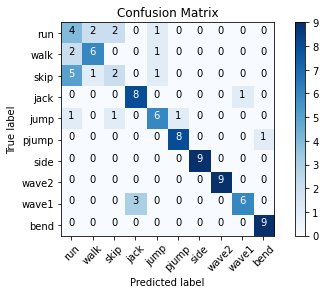

In [472]:
cm_plot_labels = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = "Confusion Matrix")

In [473]:
y_pred = lstm2_dense2_wd_rd2_lr5_e500_b16.predict(X_test)
y_pred = (y_pred > 0.5)

In [474]:
_, acc = lstm2_dense2_wd_rd2_lr5_e500_b16.evaluate(X_test, y_test)
print("Accuracy = ", (acc*100), " %")

3/3 [==============================] - 0s 57ms/step - loss: 1.0758 - categorical_accuracy: 0.7444
Accuracy =  74.44444298744202  %


In [475]:
accuracy_score(ytrue, yhat)

0.7444444444444445

In [476]:
print(classification_report(
    ytrue,
    yhat,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.33      0.44      0.38         9
        walk       0.67      0.67      0.67         9
        skip       0.40      0.22      0.29         9
        jack       0.73      0.89      0.80         9
        jump       0.67      0.67      0.67         9
       pjump       0.89      0.89      0.89         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.86      0.67      0.75         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.74        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.74      0.74      0.74        90



# Demo on a video

In [ ]:
# Probability visualisation with live side bar chart

colors = [(237, 17, 17), # walk:0 -> red
          (245, 117, 16), # run:1 -> orange
          (235, 224, 16), # jump:2 -> yellow
          (155, 235, 16), # gallop sideways:3 -> lime green
          (86, 224, 58), # bend:4 -> green
          (30, 227, 132), # one-hand wave:5 -> cyan
          (30, 224, 227), # two-hands wave:6 -> light blue
          (22, 38, 219), # jump in place:7 -> blue
          (170, 22, 219), # jumping jack:8 -> purple
          (219, 22, 104)] # skip:9 -> magenta

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return output_frame

In [ ]:
# Demo

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.3

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/demovideo-dataset-zoom-flip.mp4") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, pose)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-25:]
        
        if len(sequence) == 25:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            # Viz logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            if len(sentence) > 1:
                sentence = sentence[-1:]
                
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (720,40), (245,117,16), -1)
        cv2.putText(image, " ".join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow("OpenCV Feed", image)
        
        #Break
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [15]:
# emergency exit command
cap.release()
cv2.destroyAllWindows()